# Practice 1: Convolutional Neural Network - Deep Learning course

*   Alejandro Dopico Castro (alejandro.dopico2@udc.es).
*   Ana Xiangning Pereira Ezquerro (ana.ezquerro@udc.es).

In [1]:
import tensorflow as tf
from keras.optimizers import Adam
from keras.metrics import SparseCategoricalAccuracy
from logging import ERROR
tf.get_logger().setLevel(ERROR)
import warnings, os
warnings.filterwarnings("ignore")
from utils import *
from models import *
from typing import List, Tuple
model_accuracies: List[Tuple[str, int]] = []

# global variables 
IMG_SIZE = 64
BATCH_SIZE = 258
base_dir = 'animals/'
model_dir = 'results/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    

2024-03-01 13:26:26.939916: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 13:26:26.972955: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 13:26:26.972986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 13:26:26.973844: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 13:26:26.979031: I tensorflow/core/platform/cpu_feature_guar

2024-03-01 13:26:27.616251: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Table of Contents 

1. [Dataset preprocessing](#exercise-1-dataset-preprocessing)
2. [Custom Convolutional Models](#exercise-2-custom-convolutional-models)
    - [Simple Model](#21-simple-model)
    - [Mid Complex Model](#22-mid-complex-model)
    - [Model with residual connections](#23-model-with-residual-connections)
    - [Inception block](#24-inception-block)
    - [What happens if we add Data Augmentation?](#25-what-if-we-add-data-augmentation)
    - [Custom models comparison](#26-custom-models-comparison)

## Exercise 1. Dataset preprocessing

We decided to use for the image resolution $64\times 64$ for retrieving similar results than considering higher resolutions with the simpler architectures. The batch size is adapted to fit the GPU capabilities of the local machine. We used the original validation set for evaluation a split a 15% of the data for validation. All the input images were normalized to fit the range $[0,1]$ with the [Rescaling layer](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/).

In [2]:
train_dataset, val_dataset, test_dataset = load_data(base_dir, IMG_SIZE, BATCH_SIZE)

Found 13474 files belonging to 5 classes.


Using 11453 files for training.


Using 2021 files for validation.


2024-03-01 13:26:29.170793: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22453 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-03-01 13:26:29.171326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9997 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Found 1497 files belonging to 5 classes.


## Exercise 2. Custom Convolutional Models

For this exercise, we prepared four different convolutional architectures with increasing complexity and regularization methods to tackle the animal classification problem: ([1](#21-simple-model)) a simple linear approach with 2 convolutional layers interleaved with max-pooling, ([2](#22-mid-complex-model)) a more complex convolutional-linear model with 3 blocks of paired convolutions and max-poolings, ([3](#23-model-with-residual-connections)) a convolutional architecture based on residual connections ([He et al., 2015](https://arxiv.org/abs/1512.03385)), ([4](#24-inception-block)) the integration of the Inception block ([Szegedy et al., 2014](https://arxiv.org/abs/1409.4842)). We used the validation split to tune each hyperparameter configuration (although not all experiments are included in this notebook to facilitate the readibility) and applied some regularization methods learnt in previous practical lessons to avoid overfitting.

### 2.1. Simple Model

In [3]:
simple_model = SimpleModel(num_classes=5)
optimizer = Adam(learning_rate=1e-3)
simple_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
simple_model_history = train_model(simple_model, train_dataset, val_dataset, epochs=20, path=model_dir, batch_size=BATCH_SIZE, verbose=1).history
print(
    f"Final loss: training -> {simple_model_history['loss'][-1]:.2f}, validation -> {simple_model_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {simple_model_history['acc'][-1]:.2f}, \
        validation -> {simple_model_history['val_acc'][-1]:.2f}"
)
plot_history(simple_model_history, ['loss', 'acc'], name='Simple Model')

Epoch 1/20


2024-03-01 13:26:31.853114: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


2024-03-01 13:26:32.253097: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f60884edd90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-01 13:26:32.253119: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-01 13:26:32.253124: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-01 13:26:32.257887: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709295992.350581   18126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/45 [..............................] - ETA: 2:11 - loss: 1.6077 - acc: 0.2209

 3/45 [=>............................] - ETA: 1s - loss: 4.0276 - acc: 0.2183  

 4/45 [=>............................] - ETA: 2s - loss: 3.8878 - acc: 0.2151

 6/45 [===>..........................] - ETA: 2s - loss: 3.2969 - acc: 0.2248

 7/45 [===>..........................] - ETA: 2s - loss: 3.2699 - acc: 0.2265

 8/45 [====>.........................] - ETA: 2s - loss: 3.1673 - acc: 0.2292

 9/45 [=====>........................] - ETA: 2s - loss: 3.0075 - acc: 0.2235

10/45 [=====>........................] - ETA: 2s - loss: 2.8987 - acc: 0.2267

12/45 [=======>......................] - ETA: 2s - loss: 2.7198 - acc: 0.2464

13/45 [=======>......................] - ETA: 2s - loss: 2.6356 - acc: 0.2588

15/45 [=========>....................] - ETA: 2s - loss: 2.5059 - acc: 0.2798

16/45 [=========>....................] - ETA: 2s - loss: 2.4402 - acc: 0.2892

18/45 [===========>..................] - ETA: 2s - loss: 2.3230 - acc: 0.3058

19/45 [===========>..................] - ETA: 2s - loss: 2.2811 - acc: 0.3074

20/45 [============>.................] - ETA: 2s - loss: 2.2367 - acc: 0.3093

21/45 [=============>................] - ETA: 2s - loss: 2.1971 - acc: 0.3127

22/45 [=============>................] - ETA: 2s - loss: 2.1582 - acc: 0.3169

23/45 [==============>...............] - ETA: 2s - loss: 2.1209 - acc: 0.3237

24/45 [===============>..............] - ETA: 2s - loss: 2.0855 - acc: 0.3322

25/45 [===============>..............] - ETA: 1s - loss: 2.0547 - acc: 0.3381

26/45 [================>.............] - ETA: 1s - loss: 2.0271 - acc: 0.3420

27/45 [=================>............] - ETA: 1s - loss: 2.0003 - acc: 0.3463

28/45 [=================>............] - ETA: 1s - loss: 1.9757 - acc: 0.3517

29/45 [==================>...........] - ETA: 1s - loss: 1.9521 - acc: 0.3561

31/45 [===================>..........] - ETA: 1s - loss: 1.9054 - acc: 0.3683

32/45 [====================>.........] - ETA: 1s - loss: 1.8839 - acc: 0.3744

33/45 [=====================>........] - ETA: 1s - loss: 1.8610 - acc: 0.3805

34/45 [=====================>........] - ETA: 1s - loss: 1.8389 - acc: 0.3876

35/45 [======================>.......] - ETA: 0s - loss: 1.8204 - acc: 0.3926

36/45 [=======================>......] - ETA: 0s - loss: 1.8008 - acc: 0.3986

40/45 [=========================>....] - ETA: 0s - loss: 1.7350 - acc: 0.4151

45/45 [==============================] - ETA: 0s - loss: 1.6739 - acc: 0.4325

45/45 [==============================] - 8s 111ms/step - loss: 1.6739 - acc: 0.4325 - val_loss: 1.0598 - val_acc: 0.6145 - lr: 0.0010


Epoch 2/20


 1/45 [..............................] - ETA: 51s - loss: 0.9735 - acc: 0.6550

 2/45 [>.............................] - ETA: 2s - loss: 1.0273 - acc: 0.6221 

 3/45 [=>............................] - ETA: 3s - loss: 1.0585 - acc: 0.6111

 4/45 [=>............................] - ETA: 2s - loss: 1.0380 - acc: 0.6192

 6/45 [===>..........................] - ETA: 3s - loss: 1.0496 - acc: 0.6182

 7/45 [===>..........................] - ETA: 2s - loss: 1.0323 - acc: 0.6262

 8/45 [====>.........................] - ETA: 2s - loss: 1.0368 - acc: 0.6250

 9/45 [=====>........................] - ETA: 2s - loss: 1.0312 - acc: 0.6258

10/45 [=====>........................] - ETA: 2s - loss: 1.0225 - acc: 0.6279

12/45 [=======>......................] - ETA: 2s - loss: 1.0201 - acc: 0.6269

13/45 [=======>......................] - ETA: 3s - loss: 1.0177 - acc: 0.6294

15/45 [=========>....................] - ETA: 2s - loss: 1.0218 - acc: 0.6261

16/45 [=========>....................] - ETA: 2s - loss: 1.0151 - acc: 0.6284

17/45 [==========>...................] - ETA: 2s - loss: 1.0186 - acc: 0.6279

18/45 [===========>..................] - ETA: 2s - loss: 1.0204 - acc: 0.6238

19/45 [===========>..................] - ETA: 2s - loss: 1.0159 - acc: 0.6263

20/45 [============>.................] - ETA: 2s - loss: 1.0128 - acc: 0.6269

21/45 [=============>................] - ETA: 2s - loss: 1.0132 - acc: 0.6255

22/45 [=============>................] - ETA: 2s - loss: 1.0100 - acc: 0.6276

23/45 [==============>...............] - ETA: 2s - loss: 1.0068 - acc: 0.6296

24/45 [===============>..............] - ETA: 2s - loss: 1.0000 - acc: 0.6326

25/45 [===============>..............] - ETA: 1s - loss: 0.9985 - acc: 0.6333

26/45 [================>.............] - ETA: 1s - loss: 0.9984 - acc: 0.6343

27/45 [=================>............] - ETA: 1s - loss: 0.9986 - acc: 0.6339

28/45 [=================>............] - ETA: 1s - loss: 0.9989 - acc: 0.6325

29/45 [==================>...........] - ETA: 1s - loss: 0.9965 - acc: 0.6330

30/45 [===================>..........] - ETA: 1s - loss: 0.9911 - acc: 0.6360

31/45 [===================>..........] - ETA: 1s - loss: 0.9904 - acc: 0.6360

32/45 [====================>.........] - ETA: 1s - loss: 0.9898 - acc: 0.6361

33/45 [=====================>........] - ETA: 1s - loss: 0.9869 - acc: 0.6374

35/45 [======================>.......] - ETA: 0s - loss: 0.9826 - acc: 0.6371

36/45 [=======================>......] - ETA: 0s - loss: 0.9796 - acc: 0.6390

40/45 [=========================>....] - ETA: 0s - loss: 0.9698 - acc: 0.6442

45/45 [==============================] - 5s 92ms/step - loss: 0.9653 - acc: 0.6462 - val_loss: 0.8895 - val_acc: 0.6640 - lr: 0.0010


Epoch 3/20


 1/45 [..............................] - ETA: 52s - loss: 0.8833 - acc: 0.6628

 2/45 [>.............................] - ETA: 2s - loss: 0.9009 - acc: 0.6609 

 3/45 [=>............................] - ETA: 3s - loss: 0.8998 - acc: 0.6705

 4/45 [=>............................] - ETA: 2s - loss: 0.8833 - acc: 0.6773

 6/45 [===>..........................] - ETA: 3s - loss: 0.8579 - acc: 0.6912

 7/45 [===>..........................] - ETA: 2s - loss: 0.8644 - acc: 0.6883

 8/45 [====>.........................] - ETA: 2s - loss: 0.8577 - acc: 0.6865

 9/45 [=====>........................] - ETA: 2s - loss: 0.8566 - acc: 0.6869

10/45 [=====>........................] - ETA: 2s - loss: 0.8533 - acc: 0.6888

12/45 [=======>......................] - ETA: 2s - loss: 0.8655 - acc: 0.6828

13/45 [=======>......................] - ETA: 3s - loss: 0.8674 - acc: 0.6831

15/45 [=========>....................] - ETA: 2s - loss: 0.8600 - acc: 0.6832

16/45 [=========>....................] - ETA: 2s - loss: 0.8641 - acc: 0.6822

17/45 [==========>...................] - ETA: 2s - loss: 0.8603 - acc: 0.6842

18/45 [===========>..................] - ETA: 2s - loss: 0.8616 - acc: 0.6845

19/45 [===========>..................] - ETA: 2s - loss: 0.8574 - acc: 0.6848

20/45 [============>.................] - ETA: 2s - loss: 0.8561 - acc: 0.6872

21/45 [=============>................] - ETA: 2s - loss: 0.8549 - acc: 0.6881

22/45 [=============>................] - ETA: 2s - loss: 0.8535 - acc: 0.6887

23/45 [==============>...............] - ETA: 2s - loss: 0.8513 - acc: 0.6906

24/45 [===============>..............] - ETA: 2s - loss: 0.8490 - acc: 0.6922

25/45 [===============>..............] - ETA: 2s - loss: 0.8471 - acc: 0.6936

26/45 [================>.............] - ETA: 1s - loss: 0.8502 - acc: 0.6919

27/45 [=================>............] - ETA: 1s - loss: 0.8485 - acc: 0.6915

28/45 [=================>............] - ETA: 1s - loss: 0.8454 - acc: 0.6932

29/45 [==================>...........] - ETA: 1s - loss: 0.8426 - acc: 0.6942

31/45 [===================>..........] - ETA: 1s - loss: 0.8423 - acc: 0.6937

32/45 [====================>.........] - ETA: 1s - loss: 0.8410 - acc: 0.6937

33/45 [=====================>........] - ETA: 1s - loss: 0.8396 - acc: 0.6943

35/45 [======================>.......] - ETA: 0s - loss: 0.8372 - acc: 0.6952

36/45 [=======================>......] - ETA: 0s - loss: 0.8362 - acc: 0.6953

40/45 [=========================>....] - ETA: 0s - loss: 0.8357 - acc: 0.6964

45/45 [==============================] - 5s 92ms/step - loss: 0.8327 - acc: 0.6982 - val_loss: 0.8122 - val_acc: 0.6947 - lr: 0.0010


Epoch 4/20


 1/45 [..............................] - ETA: 50s - loss: 0.7162 - acc: 0.7713

 2/45 [>.............................] - ETA: 2s - loss: 0.7091 - acc: 0.7519 

 3/45 [=>............................] - ETA: 2s - loss: 0.7397 - acc: 0.7274

 4/45 [=>............................] - ETA: 2s - loss: 0.7461 - acc: 0.7209

 6/45 [===>..........................] - ETA: 3s - loss: 0.7543 - acc: 0.7248

 7/45 [===>..........................] - ETA: 2s - loss: 0.7572 - acc: 0.7226

 8/45 [====>.........................] - ETA: 2s - loss: 0.7617 - acc: 0.7204

 9/45 [=====>........................] - ETA: 2s - loss: 0.7703 - acc: 0.7179

10/45 [=====>........................] - ETA: 2s - loss: 0.7741 - acc: 0.7147

12/45 [=======>......................] - ETA: 2s - loss: 0.7797 - acc: 0.7119

13/45 [=======>......................] - ETA: 3s - loss: 0.7827 - acc: 0.7099

15/45 [=========>....................] - ETA: 2s - loss: 0.7882 - acc: 0.7078

16/45 [=========>....................] - ETA: 2s - loss: 0.7864 - acc: 0.7115

18/45 [===========>..................] - ETA: 2s - loss: 0.7856 - acc: 0.7127

19/45 [===========>..................] - ETA: 2s - loss: 0.7811 - acc: 0.7142

20/45 [============>.................] - ETA: 2s - loss: 0.7782 - acc: 0.7161

21/45 [=============>................] - ETA: 2s - loss: 0.7782 - acc: 0.7150

22/45 [=============>................] - ETA: 2s - loss: 0.7773 - acc: 0.7158

23/45 [==============>...............] - ETA: 2s - loss: 0.7802 - acc: 0.7147

24/45 [===============>..............] - ETA: 2s - loss: 0.7795 - acc: 0.7146

25/45 [===============>..............] - ETA: 1s - loss: 0.7825 - acc: 0.7132

26/45 [================>.............] - ETA: 1s - loss: 0.7868 - acc: 0.7115

27/45 [=================>............] - ETA: 1s - loss: 0.7863 - acc: 0.7120

28/45 [=================>............] - ETA: 1s - loss: 0.7838 - acc: 0.7119

29/45 [==================>...........] - ETA: 1s - loss: 0.7835 - acc: 0.7122

31/45 [===================>..........] - ETA: 1s - loss: 0.7797 - acc: 0.7149

32/45 [====================>.........] - ETA: 1s - loss: 0.7801 - acc: 0.7145

33/45 [=====================>........] - ETA: 1s - loss: 0.7790 - acc: 0.7159

35/45 [======================>.......] - ETA: 0s - loss: 0.7778 - acc: 0.7169

36/45 [=======================>......] - ETA: 0s - loss: 0.7793 - acc: 0.7165

40/45 [=========================>....] - ETA: 0s - loss: 0.7718 - acc: 0.7193

45/45 [==============================] - 5s 91ms/step - loss: 0.7697 - acc: 0.7197 - val_loss: 0.7822 - val_acc: 0.7046 - lr: 0.0010


Epoch 5/20


 1/45 [..............................] - ETA: 49s - loss: 0.8038 - acc: 0.6899

 2/45 [>.............................] - ETA: 2s - loss: 0.8312 - acc: 0.6841 

 3/45 [=>............................] - ETA: 3s - loss: 0.8177 - acc: 0.6899

 4/45 [=>............................] - ETA: 2s - loss: 0.7839 - acc: 0.6986

 6/45 [===>..........................] - ETA: 3s - loss: 0.7488 - acc: 0.7151

 7/45 [===>..........................] - ETA: 2s - loss: 0.7409 - acc: 0.7198

 8/45 [====>.........................] - ETA: 2s - loss: 0.7427 - acc: 0.7214

 9/45 [=====>........................] - ETA: 2s - loss: 0.7396 - acc: 0.7227

10/45 [=====>........................] - ETA: 2s - loss: 0.7333 - acc: 0.7271

12/45 [=======>......................] - ETA: 2s - loss: 0.7401 - acc: 0.7242

13/45 [=======>......................] - ETA: 3s - loss: 0.7392 - acc: 0.7275

15/45 [=========>....................] - ETA: 2s - loss: 0.7332 - acc: 0.7313

16/45 [=========>....................] - ETA: 2s - loss: 0.7335 - acc: 0.7321

18/45 [===========>..................] - ETA: 2s - loss: 0.7406 - acc: 0.7306

19/45 [===========>..................] - ETA: 2s - loss: 0.7385 - acc: 0.7317

20/45 [============>.................] - ETA: 2s - loss: 0.7376 - acc: 0.7316

21/45 [=============>................] - ETA: 2s - loss: 0.7360 - acc: 0.7342

22/45 [=============>................] - ETA: 2s - loss: 0.7302 - acc: 0.7363

23/45 [==============>...............] - ETA: 2s - loss: 0.7271 - acc: 0.7378

24/45 [===============>..............] - ETA: 2s - loss: 0.7242 - acc: 0.7390

25/45 [===============>..............] - ETA: 1s - loss: 0.7252 - acc: 0.7381

26/45 [================>.............] - ETA: 1s - loss: 0.7252 - acc: 0.7384

27/45 [=================>............] - ETA: 1s - loss: 0.7310 - acc: 0.7374

28/45 [=================>............] - ETA: 1s - loss: 0.7328 - acc: 0.7352

29/45 [==================>...........] - ETA: 1s - loss: 0.7332 - acc: 0.7348

31/45 [===================>..........] - ETA: 1s - loss: 0.7304 - acc: 0.7369

32/45 [====================>.........] - ETA: 1s - loss: 0.7306 - acc: 0.7361

33/45 [=====================>........] - ETA: 1s - loss: 0.7327 - acc: 0.7347

35/45 [======================>.......] - ETA: 0s - loss: 0.7302 - acc: 0.7347

36/45 [=======================>......] - ETA: 0s - loss: 0.7322 - acc: 0.7326

40/45 [=========================>....] - ETA: 0s - loss: 0.7290 - acc: 0.7338

45/45 [==============================] - 5s 91ms/step - loss: 0.7208 - acc: 0.7360 - val_loss: 0.7714 - val_acc: 0.7160 - lr: 0.0010


Epoch 6/20


 1/45 [..............................] - ETA: 50s - loss: 0.7528 - acc: 0.7016

 2/45 [>.............................] - ETA: 2s - loss: 0.7286 - acc: 0.7345 

 3/45 [=>............................] - ETA: 3s - loss: 0.7093 - acc: 0.7390

 4/45 [=>............................] - ETA: 2s - loss: 0.7370 - acc: 0.7200

 6/45 [===>..........................] - ETA: 3s - loss: 0.7116 - acc: 0.7319

 7/45 [===>..........................] - ETA: 2s - loss: 0.7134 - acc: 0.7326

 8/45 [====>.........................] - ETA: 2s - loss: 0.7166 - acc: 0.7292

 9/45 [=====>........................] - ETA: 2s - loss: 0.7075 - acc: 0.7321

10/45 [=====>........................] - ETA: 2s - loss: 0.7036 - acc: 0.7345

12/45 [=======>......................] - ETA: 2s - loss: 0.6957 - acc: 0.7422

13/45 [=======>......................] - ETA: 3s - loss: 0.6963 - acc: 0.7421

15/45 [=========>....................] - ETA: 2s - loss: 0.6911 - acc: 0.7447

16/45 [=========>....................] - ETA: 2s - loss: 0.6911 - acc: 0.7449

18/45 [===========>..................] - ETA: 2s - loss: 0.6929 - acc: 0.7450

19/45 [===========>..................] - ETA: 2s - loss: 0.6928 - acc: 0.7444

20/45 [============>.................] - ETA: 2s - loss: 0.6885 - acc: 0.7461

21/45 [=============>................] - ETA: 2s - loss: 0.6917 - acc: 0.7457

22/45 [=============>................] - ETA: 2s - loss: 0.6949 - acc: 0.7454

23/45 [==============>...............] - ETA: 2s - loss: 0.6913 - acc: 0.7472

24/45 [===============>..............] - ETA: 2s - loss: 0.6893 - acc: 0.7484

25/45 [===============>..............] - ETA: 1s - loss: 0.6896 - acc: 0.7493

26/45 [================>.............] - ETA: 1s - loss: 0.6899 - acc: 0.7488

27/45 [=================>............] - ETA: 1s - loss: 0.6896 - acc: 0.7491

28/45 [=================>............] - ETA: 1s - loss: 0.6893 - acc: 0.7494

29/45 [==================>...........] - ETA: 1s - loss: 0.6858 - acc: 0.7522

30/45 [===================>..........] - ETA: 1s - loss: 0.6873 - acc: 0.7506

31/45 [===================>..........] - ETA: 1s - loss: 0.6869 - acc: 0.7509

32/45 [====================>.........] - ETA: 1s - loss: 0.6821 - acc: 0.7535

33/45 [=====================>........] - ETA: 1s - loss: 0.6826 - acc: 0.7536

35/45 [======================>.......] - ETA: 0s - loss: 0.6807 - acc: 0.7539

36/45 [=======================>......] - ETA: 0s - loss: 0.6791 - acc: 0.7541

40/45 [=========================>....] - ETA: 0s - loss: 0.6780 - acc: 0.7547

45/45 [==============================] - 5s 91ms/step - loss: 0.6729 - acc: 0.7574 - val_loss: 0.7714 - val_acc: 0.7056 - lr: 0.0010


Epoch 7/20


 1/45 [..............................] - ETA: 49s - loss: 0.6746 - acc: 0.7674

 2/45 [>.............................] - ETA: 2s - loss: 0.6599 - acc: 0.7713 

 3/45 [=>............................] - ETA: 3s - loss: 0.6708 - acc: 0.7571

 4/45 [=>............................] - ETA: 2s - loss: 0.6584 - acc: 0.7674

 6/45 [===>..........................] - ETA: 3s - loss: 0.6653 - acc: 0.7616

 7/45 [===>..........................] - ETA: 2s - loss: 0.6713 - acc: 0.7619

 8/45 [====>.........................] - ETA: 2s - loss: 0.6655 - acc: 0.7631

 9/45 [=====>........................] - ETA: 2s - loss: 0.6682 - acc: 0.7614

10/45 [=====>........................] - ETA: 2s - loss: 0.6658 - acc: 0.7612

12/45 [=======>......................] - ETA: 2s - loss: 0.6556 - acc: 0.7665

13/45 [=======>......................] - ETA: 3s - loss: 0.6500 - acc: 0.7701

15/45 [=========>....................] - ETA: 2s - loss: 0.6575 - acc: 0.7674

16/45 [=========>....................] - ETA: 2s - loss: 0.6599 - acc: 0.7670

18/45 [===========>..................] - ETA: 2s - loss: 0.6590 - acc: 0.7687

19/45 [===========>..................] - ETA: 2s - loss: 0.6581 - acc: 0.7678

20/45 [============>.................] - ETA: 2s - loss: 0.6534 - acc: 0.7692

21/45 [=============>................] - ETA: 2s - loss: 0.6544 - acc: 0.7687

22/45 [=============>................] - ETA: 2s - loss: 0.6559 - acc: 0.7685

23/45 [==============>...............] - ETA: 2s - loss: 0.6519 - acc: 0.7690

24/45 [===============>..............] - ETA: 2s - loss: 0.6552 - acc: 0.7676

25/45 [===============>..............] - ETA: 1s - loss: 0.6551 - acc: 0.7682

26/45 [================>.............] - ETA: 1s - loss: 0.6519 - acc: 0.7695

27/45 [=================>............] - ETA: 1s - loss: 0.6505 - acc: 0.7696

28/45 [=================>............] - ETA: 1s - loss: 0.6537 - acc: 0.7673

29/45 [==================>...........] - ETA: 1s - loss: 0.6493 - acc: 0.7696

31/45 [===================>..........] - ETA: 1s - loss: 0.6464 - acc: 0.7714

32/45 [====================>.........] - ETA: 1s - loss: 0.6441 - acc: 0.7720

33/45 [=====================>........] - ETA: 1s - loss: 0.6435 - acc: 0.7720

35/45 [======================>.......] - ETA: 0s - loss: 0.6442 - acc: 0.7715

36/45 [=======================>......] - ETA: 0s - loss: 0.6436 - acc: 0.7722

40/45 [=========================>....] - ETA: 0s - loss: 0.6409 - acc: 0.7724

45/45 [==============================] - 5s 91ms/step - loss: 0.6388 - acc: 0.7733 - val_loss: 0.7355 - val_acc: 0.7209 - lr: 0.0010


Epoch 8/20


 1/45 [..............................] - ETA: 49s - loss: 0.6325 - acc: 0.7829

 2/45 [>.............................] - ETA: 2s - loss: 0.6153 - acc: 0.7926 

 3/45 [=>............................] - ETA: 3s - loss: 0.6415 - acc: 0.7726

 4/45 [=>............................] - ETA: 2s - loss: 0.6292 - acc: 0.7868

 6/45 [===>..........................] - ETA: 3s - loss: 0.6160 - acc: 0.7817

 7/45 [===>..........................] - ETA: 2s - loss: 0.6151 - acc: 0.7824

 8/45 [====>.........................] - ETA: 2s - loss: 0.6118 - acc: 0.7849

 9/45 [=====>........................] - ETA: 2s - loss: 0.6178 - acc: 0.7817

10/45 [=====>........................] - ETA: 2s - loss: 0.6184 - acc: 0.7818

12/45 [=======>......................] - ETA: 2s - loss: 0.6169 - acc: 0.7839

13/45 [=======>......................] - ETA: 3s - loss: 0.6215 - acc: 0.7826

15/45 [=========>....................] - ETA: 2s - loss: 0.6273 - acc: 0.7796

16/45 [=========>....................] - ETA: 2s - loss: 0.6232 - acc: 0.7812

18/45 [===========>..................] - ETA: 2s - loss: 0.6189 - acc: 0.7821

19/45 [===========>..................] - ETA: 2s - loss: 0.6158 - acc: 0.7840

20/45 [============>.................] - ETA: 2s - loss: 0.6114 - acc: 0.7866

21/45 [=============>................] - ETA: 2s - loss: 0.6130 - acc: 0.7866

22/45 [=============>................] - ETA: 2s - loss: 0.6113 - acc: 0.7865

23/45 [==============>...............] - ETA: 2s - loss: 0.6117 - acc: 0.7861

24/45 [===============>..............] - ETA: 2s - loss: 0.6097 - acc: 0.7860

25/45 [===============>..............] - ETA: 1s - loss: 0.6115 - acc: 0.7870

26/45 [================>.............] - ETA: 1s - loss: 0.6108 - acc: 0.7871

27/45 [=================>............] - ETA: 1s - loss: 0.6101 - acc: 0.7865

28/45 [=================>............] - ETA: 1s - loss: 0.6097 - acc: 0.7863

29/45 [==================>...........] - ETA: 1s - loss: 0.6097 - acc: 0.7863

31/45 [===================>..........] - ETA: 1s - loss: 0.6097 - acc: 0.7851

32/45 [====================>.........] - ETA: 1s - loss: 0.6076 - acc: 0.7857

33/45 [=====================>........] - ETA: 1s - loss: 0.6061 - acc: 0.7854

35/45 [======================>.......] - ETA: 0s - loss: 0.6025 - acc: 0.7865

36/45 [=======================>......] - ETA: 0s - loss: 0.6009 - acc: 0.7866

40/45 [=========================>....] - ETA: 0s - loss: 0.5993 - acc: 0.7864

45/45 [==============================] - 5s 91ms/step - loss: 0.5959 - acc: 0.7866 - val_loss: 0.7060 - val_acc: 0.7284 - lr: 0.0010


Epoch 9/20


 1/45 [..............................] - ETA: 49s - loss: 0.5548 - acc: 0.8101

 2/45 [>.............................] - ETA: 2s - loss: 0.5984 - acc: 0.7965 

 3/45 [=>............................] - ETA: 3s - loss: 0.5993 - acc: 0.7920

 4/45 [=>............................] - ETA: 2s - loss: 0.5792 - acc: 0.7955

 6/45 [===>..........................] - ETA: 3s - loss: 0.5755 - acc: 0.7997

 7/45 [===>..........................] - ETA: 2s - loss: 0.5749 - acc: 0.8029

 8/45 [====>.........................] - ETA: 2s - loss: 0.5807 - acc: 0.8014

 9/45 [=====>........................] - ETA: 2s - loss: 0.5862 - acc: 0.7984

10/45 [=====>........................] - ETA: 2s - loss: 0.5854 - acc: 0.7953

12/45 [=======>......................] - ETA: 2s - loss: 0.5836 - acc: 0.7968

13/45 [=======>......................] - ETA: 3s - loss: 0.5766 - acc: 0.7993

15/45 [=========>....................] - ETA: 2s - loss: 0.5755 - acc: 0.7992

16/45 [=========>....................] - ETA: 2s - loss: 0.5762 - acc: 0.7994

17/45 [==========>...................] - ETA: 2s - loss: 0.5726 - acc: 0.7998

18/45 [===========>..................] - ETA: 2s - loss: 0.5723 - acc: 0.8000

19/45 [===========>..................] - ETA: 2s - loss: 0.5736 - acc: 0.7991

20/45 [============>.................] - ETA: 2s - loss: 0.5742 - acc: 0.7986

21/45 [=============>................] - ETA: 2s - loss: 0.5754 - acc: 0.7988

22/45 [=============>................] - ETA: 2s - loss: 0.5742 - acc: 0.7986

23/45 [==============>...............] - ETA: 2s - loss: 0.5749 - acc: 0.7983

24/45 [===============>..............] - ETA: 2s - loss: 0.5739 - acc: 0.7978

25/45 [===============>..............] - ETA: 1s - loss: 0.5689 - acc: 0.7991

26/45 [================>.............] - ETA: 1s - loss: 0.5676 - acc: 0.7996

27/45 [=================>............] - ETA: 1s - loss: 0.5646 - acc: 0.8019

28/45 [=================>............] - ETA: 1s - loss: 0.5649 - acc: 0.8012

29/45 [==================>...........] - ETA: 1s - loss: 0.5647 - acc: 0.8018

31/45 [===================>..........] - ETA: 1s - loss: 0.5655 - acc: 0.8020

32/45 [====================>.........] - ETA: 1s - loss: 0.5652 - acc: 0.8014

33/45 [=====================>........] - ETA: 1s - loss: 0.5655 - acc: 0.8013

35/45 [======================>.......] - ETA: 0s - loss: 0.5646 - acc: 0.8020

36/45 [=======================>......] - ETA: 0s - loss: 0.5627 - acc: 0.8025

40/45 [=========================>....] - ETA: 0s - loss: 0.5623 - acc: 0.8012

45/45 [==============================] - 5s 91ms/step - loss: 0.5595 - acc: 0.8023 - val_loss: 0.7058 - val_acc: 0.7288 - lr: 0.0010


Epoch 10/20


 1/45 [..............................] - ETA: 49s - loss: 0.5566 - acc: 0.7868

 2/45 [>.............................] - ETA: 2s - loss: 0.5600 - acc: 0.7868 

 3/45 [=>............................] - ETA: 3s - loss: 0.5507 - acc: 0.7868

 4/45 [=>............................] - ETA: 2s - loss: 0.5377 - acc: 0.7984

 6/45 [===>..........................] - ETA: 3s - loss: 0.5492 - acc: 0.7959

 7/45 [===>..........................] - ETA: 2s - loss: 0.5540 - acc: 0.7990

 8/45 [====>.........................] - ETA: 2s - loss: 0.5547 - acc: 0.7989

 9/45 [=====>........................] - ETA: 2s - loss: 0.5649 - acc: 0.7976

10/45 [=====>........................] - ETA: 2s - loss: 0.5599 - acc: 0.7984

12/45 [=======>......................] - ETA: 2s - loss: 0.5593 - acc: 0.7997

13/45 [=======>......................] - ETA: 3s - loss: 0.5606 - acc: 0.7982

15/45 [=========>....................] - ETA: 2s - loss: 0.5603 - acc: 0.7979

16/45 [=========>....................] - ETA: 2s - loss: 0.5556 - acc: 0.7992

18/45 [===========>..................] - ETA: 2s - loss: 0.5573 - acc: 0.8004

19/45 [===========>..................] - ETA: 2s - loss: 0.5535 - acc: 0.8023

20/45 [============>.................] - ETA: 2s - loss: 0.5500 - acc: 0.8043

21/45 [=============>................] - ETA: 2s - loss: 0.5474 - acc: 0.8055

22/45 [=============>................] - ETA: 2s - loss: 0.5472 - acc: 0.8058

23/45 [==============>...............] - ETA: 2s - loss: 0.5451 - acc: 0.8062

24/45 [===============>..............] - ETA: 2s - loss: 0.5433 - acc: 0.8064

25/45 [===============>..............] - ETA: 1s - loss: 0.5404 - acc: 0.8076

26/45 [================>.............] - ETA: 1s - loss: 0.5395 - acc: 0.8065

27/45 [=================>............] - ETA: 1s - loss: 0.5383 - acc: 0.8081

28/45 [=================>............] - ETA: 1s - loss: 0.5354 - acc: 0.8086

29/45 [==================>...........] - ETA: 1s - loss: 0.5371 - acc: 0.8073

30/45 [===================>..........] - ETA: 1s - loss: 0.5376 - acc: 0.8065

31/45 [===================>..........] - ETA: 1s - loss: 0.5380 - acc: 0.8058

32/45 [====================>.........] - ETA: 1s - loss: 0.5381 - acc: 0.8066

33/45 [=====================>........] - ETA: 1s - loss: 0.5370 - acc: 0.8075

35/45 [======================>.......] - ETA: 0s - loss: 0.5334 - acc: 0.8083

36/45 [=======================>......] - ETA: 0s - loss: 0.5323 - acc: 0.8091

40/45 [=========================>....] - ETA: 0s - loss: 0.5325 - acc: 0.8084

45/45 [==============================] - 5s 91ms/step - loss: 0.5334 - acc: 0.8084 - val_loss: 0.7038 - val_acc: 0.7308 - lr: 0.0010


Epoch 11/20


 1/45 [..............................] - ETA: 50s - loss: 0.5211 - acc: 0.7829

 2/45 [>.............................] - ETA: 2s - loss: 0.5495 - acc: 0.7926 

 3/45 [=>............................] - ETA: 2s - loss: 0.5516 - acc: 0.7959

 4/45 [=>............................] - ETA: 2s - loss: 0.5401 - acc: 0.7994

 6/45 [===>..........................] - ETA: 3s - loss: 0.5387 - acc: 0.8114

 7/45 [===>..........................] - ETA: 2s - loss: 0.5335 - acc: 0.8162

 8/45 [====>.........................] - ETA: 2s - loss: 0.5280 - acc: 0.8140

 9/45 [=====>........................] - ETA: 2s - loss: 0.5288 - acc: 0.8135

10/45 [=====>........................] - ETA: 2s - loss: 0.5247 - acc: 0.8171

12/45 [=======>......................] - ETA: 2s - loss: 0.5210 - acc: 0.8162

13/45 [=======>......................] - ETA: 3s - loss: 0.5172 - acc: 0.8196

15/45 [=========>....................] - ETA: 2s - loss: 0.5156 - acc: 0.8199

16/45 [=========>....................] - ETA: 2s - loss: 0.5144 - acc: 0.8217

17/45 [==========>...................] - ETA: 2s - loss: 0.5133 - acc: 0.8222

18/45 [===========>..................] - ETA: 2s - loss: 0.5133 - acc: 0.8221

19/45 [===========>..................] - ETA: 2s - loss: 0.5157 - acc: 0.8221

20/45 [============>.................] - ETA: 2s - loss: 0.5123 - acc: 0.8234

21/45 [=============>................] - ETA: 2s - loss: 0.5112 - acc: 0.8236

22/45 [=============>................] - ETA: 2s - loss: 0.5085 - acc: 0.8249

23/45 [==============>...............] - ETA: 2s - loss: 0.5076 - acc: 0.8251

24/45 [===============>..............] - ETA: 2s - loss: 0.5048 - acc: 0.8259

25/45 [===============>..............] - ETA: 1s - loss: 0.5023 - acc: 0.8256

26/45 [================>.............] - ETA: 1s - loss: 0.5051 - acc: 0.8245

27/45 [=================>............] - ETA: 1s - loss: 0.5062 - acc: 0.8244

28/45 [=================>............] - ETA: 1s - loss: 0.5084 - acc: 0.8230

29/45 [==================>...........] - ETA: 1s - loss: 0.5066 - acc: 0.8237

31/45 [===================>..........] - ETA: 1s - loss: 0.5080 - acc: 0.8230

32/45 [====================>.........] - ETA: 1s - loss: 0.5075 - acc: 0.8223

33/45 [=====================>........] - ETA: 1s - loss: 0.5078 - acc: 0.8218

35/45 [======================>.......] - ETA: 0s - loss: 0.5092 - acc: 0.8226

36/45 [=======================>......] - ETA: 0s - loss: 0.5084 - acc: 0.8225

40/45 [=========================>....] - ETA: 0s - loss: 0.5102 - acc: 0.8211

45/45 [==============================] - 5s 91ms/step - loss: 0.5058 - acc: 0.8224 - val_loss: 0.7184 - val_acc: 0.7288 - lr: 0.0010


Epoch 12/20


 1/45 [..............................] - ETA: 49s - loss: 0.4825 - acc: 0.8023

 2/45 [>.............................] - ETA: 2s - loss: 0.4497 - acc: 0.8198 

 3/45 [=>............................] - ETA: 2s - loss: 0.4748 - acc: 0.8178

 4/45 [=>............................] - ETA: 2s - loss: 0.4815 - acc: 0.8169

 6/45 [===>..........................] - ETA: 3s - loss: 0.5063 - acc: 0.8127

 7/45 [===>..........................] - ETA: 2s - loss: 0.5027 - acc: 0.8151

 8/45 [====>.........................] - ETA: 2s - loss: 0.4960 - acc: 0.8207

 9/45 [=====>........................] - ETA: 2s - loss: 0.4971 - acc: 0.8217

10/45 [=====>........................] - ETA: 2s - loss: 0.5004 - acc: 0.8225

12/45 [=======>......................] - ETA: 2s - loss: 0.4937 - acc: 0.8278

13/45 [=======>......................] - ETA: 3s - loss: 0.4924 - acc: 0.8292

15/45 [=========>....................] - ETA: 2s - loss: 0.4996 - acc: 0.8251

16/45 [=========>....................] - ETA: 2s - loss: 0.4982 - acc: 0.8244

17/45 [==========>...................] - ETA: 2s - loss: 0.5017 - acc: 0.8256

18/45 [===========>..................] - ETA: 2s - loss: 0.4992 - acc: 0.8260

19/45 [===========>..................] - ETA: 2s - loss: 0.4966 - acc: 0.8260

20/45 [============>.................] - ETA: 2s - loss: 0.4953 - acc: 0.8279

21/45 [=============>................] - ETA: 2s - loss: 0.4937 - acc: 0.8282

22/45 [=============>................] - ETA: 2s - loss: 0.4938 - acc: 0.8280

23/45 [==============>...............] - ETA: 2s - loss: 0.4901 - acc: 0.8296

24/45 [===============>..............] - ETA: 2s - loss: 0.4906 - acc: 0.8303

25/45 [===============>..............] - ETA: 1s - loss: 0.4910 - acc: 0.8285

26/45 [================>.............] - ETA: 1s - loss: 0.4943 - acc: 0.8269

27/45 [=================>............] - ETA: 1s - loss: 0.4926 - acc: 0.8266

28/45 [=================>............] - ETA: 1s - loss: 0.4910 - acc: 0.8260

29/45 [==================>...........] - ETA: 1s - loss: 0.4879 - acc: 0.8269

31/45 [===================>..........] - ETA: 1s - loss: 0.4866 - acc: 0.8263

32/45 [====================>.........] - ETA: 1s - loss: 0.4869 - acc: 0.8264

33/45 [=====================>........] - ETA: 1s - loss: 0.4856 - acc: 0.8265

35/45 [======================>.......] - ETA: 0s - loss: 0.4809 - acc: 0.8292

36/45 [=======================>......] - ETA: 0s - loss: 0.4802 - acc: 0.8295

40/45 [=========================>....] - ETA: 0s - loss: 0.4812 - acc: 0.8288

45/45 [==============================] - 5s 92ms/step - loss: 0.4766 - acc: 0.8304 - val_loss: 0.6965 - val_acc: 0.7323 - lr: 0.0010


Epoch 13/20


 1/45 [..............................] - ETA: 49s - loss: 0.4372 - acc: 0.8372

 2/45 [>.............................] - ETA: 2s - loss: 0.3975 - acc: 0.8682 

 3/45 [=>............................] - ETA: 2s - loss: 0.3960 - acc: 0.8708

 4/45 [=>............................] - ETA: 2s - loss: 0.4199 - acc: 0.8576

 6/45 [===>..........................] - ETA: 3s - loss: 0.4288 - acc: 0.8527

 7/45 [===>..........................] - ETA: 2s - loss: 0.4371 - acc: 0.8494

 8/45 [====>.........................] - ETA: 2s - loss: 0.4437 - acc: 0.8445

 9/45 [=====>........................] - ETA: 2s - loss: 0.4397 - acc: 0.8467

10/45 [=====>........................] - ETA: 2s - loss: 0.4380 - acc: 0.8465

12/45 [=======>......................] - ETA: 2s - loss: 0.4415 - acc: 0.8495

13/45 [=======>......................] - ETA: 3s - loss: 0.4385 - acc: 0.8503

15/45 [=========>....................] - ETA: 2s - loss: 0.4530 - acc: 0.8475

16/45 [=========>....................] - ETA: 2s - loss: 0.4564 - acc: 0.8457

18/45 [===========>..................] - ETA: 2s - loss: 0.4526 - acc: 0.8471

19/45 [===========>..................] - ETA: 2s - loss: 0.4542 - acc: 0.8454

20/45 [============>.................] - ETA: 2s - loss: 0.4531 - acc: 0.8440

21/45 [=============>................] - ETA: 2s - loss: 0.4556 - acc: 0.8424

22/45 [=============>................] - ETA: 2s - loss: 0.4607 - acc: 0.8416

23/45 [==============>...............] - ETA: 2s - loss: 0.4597 - acc: 0.8419

24/45 [===============>..............] - ETA: 2s - loss: 0.4551 - acc: 0.8442

25/45 [===============>..............] - ETA: 1s - loss: 0.4570 - acc: 0.8431

26/45 [================>.............] - ETA: 1s - loss: 0.4543 - acc: 0.8442

27/45 [=================>............] - ETA: 1s - loss: 0.4539 - acc: 0.8447

28/45 [=================>............] - ETA: 1s - loss: 0.4557 - acc: 0.8432

29/45 [==================>...........] - ETA: 1s - loss: 0.4548 - acc: 0.8439

31/45 [===================>..........] - ETA: 1s - loss: 0.4546 - acc: 0.8435

32/45 [====================>.........] - ETA: 1s - loss: 0.4550 - acc: 0.8436

33/45 [=====================>........] - ETA: 1s - loss: 0.4546 - acc: 0.8439

35/45 [======================>.......] - ETA: 0s - loss: 0.4528 - acc: 0.8446

36/45 [=======================>......] - ETA: 0s - loss: 0.4519 - acc: 0.8449

40/45 [=========================>....] - ETA: 0s - loss: 0.4513 - acc: 0.8449

45/45 [==============================] - 5s 90ms/step - loss: 0.4485 - acc: 0.8453 - val_loss: 0.6972 - val_acc: 0.7348 - lr: 0.0010


Epoch 14/20


 1/45 [..............................] - ETA: 48s - loss: 0.4001 - acc: 0.8953

 2/45 [>.............................] - ETA: 2s - loss: 0.4318 - acc: 0.8663 

 3/45 [=>............................] - ETA: 2s - loss: 0.4448 - acc: 0.8605

 4/45 [=>............................] - ETA: 2s - loss: 0.4434 - acc: 0.8653

 6/45 [===>..........................] - ETA: 3s - loss: 0.4526 - acc: 0.8508

 7/45 [===>..........................] - ETA: 2s - loss: 0.4442 - acc: 0.8533

 8/45 [====>.........................] - ETA: 2s - loss: 0.4390 - acc: 0.8542

 9/45 [=====>........................] - ETA: 2s - loss: 0.4420 - acc: 0.8519

10/45 [=====>........................] - ETA: 2s - loss: 0.4334 - acc: 0.8554

12/45 [=======>......................] - ETA: 2s - loss: 0.4326 - acc: 0.8566

13/45 [=======>......................] - ETA: 3s - loss: 0.4304 - acc: 0.8578

15/45 [=========>....................] - ETA: 2s - loss: 0.4345 - acc: 0.8525

16/45 [=========>....................] - ETA: 2s - loss: 0.4321 - acc: 0.8549

18/45 [===========>..................] - ETA: 2s - loss: 0.4312 - acc: 0.8551

19/45 [===========>..................] - ETA: 2s - loss: 0.4298 - acc: 0.8552

20/45 [============>.................] - ETA: 2s - loss: 0.4261 - acc: 0.8574

21/45 [=============>................] - ETA: 2s - loss: 0.4278 - acc: 0.8560

22/45 [=============>................] - ETA: 2s - loss: 0.4298 - acc: 0.8543

23/45 [==============>...............] - ETA: 2s - loss: 0.4311 - acc: 0.8537

24/45 [===============>..............] - ETA: 2s - loss: 0.4312 - acc: 0.8526

25/45 [===============>..............] - ETA: 1s - loss: 0.4361 - acc: 0.8510

26/45 [================>.............] - ETA: 1s - loss: 0.4373 - acc: 0.8508

27/45 [=================>............] - ETA: 1s - loss: 0.4373 - acc: 0.8507

28/45 [=================>............] - ETA: 1s - loss: 0.4370 - acc: 0.8506

29/45 [==================>...........] - ETA: 1s - loss: 0.4355 - acc: 0.8512

31/45 [===================>..........] - ETA: 1s - loss: 0.4359 - acc: 0.8507

32/45 [====================>.........] - ETA: 1s - loss: 0.4366 - acc: 0.8498

33/45 [=====================>........] - ETA: 1s - loss: 0.4345 - acc: 0.8504

35/45 [======================>.......] - ETA: 0s - loss: 0.4325 - acc: 0.8511

36/45 [=======================>......] - ETA: 0s - loss: 0.4323 - acc: 0.8517

40/45 [=========================>....] - ETA: 0s - loss: 0.4303 - acc: 0.8516

45/45 [==============================] - 5s 91ms/step - loss: 0.4283 - acc: 0.8517 - val_loss: 0.7121 - val_acc: 0.7264 - lr: 0.0010


Epoch 15/20


 1/45 [..............................] - ETA: 49s - loss: 0.3777 - acc: 0.8566

 2/45 [>.............................] - ETA: 2s - loss: 0.3972 - acc: 0.8566 

 3/45 [=>............................] - ETA: 2s - loss: 0.3928 - acc: 0.8579

 4/45 [=>............................] - ETA: 2s - loss: 0.4134 - acc: 0.8517

 5/45 [==>...........................] - ETA: 2s - loss: 0.4136 - acc: 0.8535

 6/45 [===>..........................] - ETA: 3s - loss: 0.4231 - acc: 0.8488

 7/45 [===>..........................] - ETA: 2s - loss: 0.4170 - acc: 0.8566

 8/45 [====>.........................] - ETA: 2s - loss: 0.4152 - acc: 0.8566

 9/45 [=====>........................] - ETA: 2s - loss: 0.4182 - acc: 0.8549

10/45 [=====>........................] - ETA: 2s - loss: 0.4085 - acc: 0.8601

12/45 [=======>......................] - ETA: 2s - loss: 0.4135 - acc: 0.8598

13/45 [=======>......................] - ETA: 3s - loss: 0.4131 - acc: 0.8629

15/45 [=========>....................] - ETA: 2s - loss: 0.4154 - acc: 0.8638

16/45 [=========>....................] - ETA: 2s - loss: 0.4130 - acc: 0.8639

17/45 [==========>...................] - ETA: 2s - loss: 0.4158 - acc: 0.8602

18/45 [===========>..................] - ETA: 2s - loss: 0.4149 - acc: 0.8611

19/45 [===========>..................] - ETA: 2s - loss: 0.4133 - acc: 0.8611

20/45 [============>.................] - ETA: 2s - loss: 0.4181 - acc: 0.8601

21/45 [=============>................] - ETA: 2s - loss: 0.4159 - acc: 0.8603

22/45 [=============>................] - ETA: 2s - loss: 0.4138 - acc: 0.8606

23/45 [==============>...............] - ETA: 2s - loss: 0.4123 - acc: 0.8615

24/45 [===============>..............] - ETA: 2s - loss: 0.4101 - acc: 0.8630

25/45 [===============>..............] - ETA: 1s - loss: 0.4101 - acc: 0.8633

26/45 [================>.............] - ETA: 1s - loss: 0.4097 - acc: 0.8630

27/45 [=================>............] - ETA: 1s - loss: 0.4102 - acc: 0.8628

28/45 [=================>............] - ETA: 1s - loss: 0.4112 - acc: 0.8621

29/45 [==================>...........] - ETA: 1s - loss: 0.4109 - acc: 0.8615

30/45 [===================>..........] - ETA: 1s - loss: 0.4099 - acc: 0.8618

31/45 [===================>..........] - ETA: 1s - loss: 0.4107 - acc: 0.8617

32/45 [====================>.........] - ETA: 1s - loss: 0.4107 - acc: 0.8613

33/45 [=====================>........] - ETA: 1s - loss: 0.4096 - acc: 0.8606

35/45 [======================>.......] - ETA: 0s - loss: 0.4094 - acc: 0.8608

36/45 [=======================>......] - ETA: 0s - loss: 0.4098 - acc: 0.8608

40/45 [=========================>....] - ETA: 0s - loss: 0.4079 - acc: 0.8611

45/45 [==============================] - 5s 90ms/step - loss: 0.4081 - acc: 0.8593 - val_loss: 0.7375 - val_acc: 0.7170 - lr: 0.0010


Epoch 16/20


 1/45 [..............................] - ETA: 49s - loss: 0.3788 - acc: 0.8798

 2/45 [>.............................] - ETA: 2s - loss: 0.3614 - acc: 0.8953 

 3/45 [=>............................] - ETA: 2s - loss: 0.3706 - acc: 0.8889

 4/45 [=>............................] - ETA: 2s - loss: 0.3808 - acc: 0.8779

 6/45 [===>..........................] - ETA: 3s - loss: 0.3932 - acc: 0.8740

 7/45 [===>..........................] - ETA: 2s - loss: 0.3981 - acc: 0.8693

 8/45 [====>.........................] - ETA: 2s - loss: 0.3986 - acc: 0.8702

 9/45 [=====>........................] - ETA: 2s - loss: 0.3997 - acc: 0.8699

10/45 [=====>........................] - ETA: 2s - loss: 0.3998 - acc: 0.8686

12/45 [=======>......................] - ETA: 2s - loss: 0.3909 - acc: 0.8724

13/45 [=======>......................] - ETA: 3s - loss: 0.3914 - acc: 0.8739

15/45 [=========>....................] - ETA: 2s - loss: 0.3890 - acc: 0.8742

16/45 [=========>....................] - ETA: 2s - loss: 0.3914 - acc: 0.8735

18/45 [===========>..................] - ETA: 2s - loss: 0.3919 - acc: 0.8730

19/45 [===========>..................] - ETA: 2s - loss: 0.3925 - acc: 0.8705

20/45 [============>.................] - ETA: 2s - loss: 0.3923 - acc: 0.8709

21/45 [=============>................] - ETA: 2s - loss: 0.3957 - acc: 0.8693

22/45 [=============>................] - ETA: 2s - loss: 0.3988 - acc: 0.8672

23/45 [==============>...............] - ETA: 2s - loss: 0.3966 - acc: 0.8684

24/45 [===============>..............] - ETA: 2s - loss: 0.3959 - acc: 0.8677

25/45 [===============>..............] - ETA: 1s - loss: 0.3962 - acc: 0.8676

26/45 [================>.............] - ETA: 1s - loss: 0.3960 - acc: 0.8666

27/45 [=================>............] - ETA: 1s - loss: 0.3965 - acc: 0.8661

28/45 [=================>............] - ETA: 1s - loss: 0.3929 - acc: 0.8675

29/45 [==================>...........] - ETA: 1s - loss: 0.3937 - acc: 0.8669

30/45 [===================>..........] - ETA: 1s - loss: 0.3929 - acc: 0.8672

31/45 [===================>..........] - ETA: 1s - loss: 0.3908 - acc: 0.8682

32/45 [====================>.........] - ETA: 1s - loss: 0.3899 - acc: 0.8682

33/45 [=====================>........] - ETA: 1s - loss: 0.3897 - acc: 0.8689

35/45 [======================>.......] - ETA: 0s - loss: 0.3908 - acc: 0.8684

36/45 [=======================>......] - ETA: 0s - loss: 0.3899 - acc: 0.8691

40/45 [=========================>....] - ETA: 0s - loss: 0.3859 - acc: 0.8702

45/45 [==============================] - 5s 90ms/step - loss: 0.3844 - acc: 0.8709 - val_loss: 0.7172 - val_acc: 0.7378 - lr: 0.0010


Epoch 17/20


 1/45 [..............................] - ETA: 50s - loss: 0.3770 - acc: 0.8527

 2/45 [>.............................] - ETA: 2s - loss: 0.3802 - acc: 0.8566 

 3/45 [=>............................] - ETA: 3s - loss: 0.3781 - acc: 0.8605

 4/45 [=>............................] - ETA: 2s - loss: 0.3769 - acc: 0.8634

 6/45 [===>..........................] - ETA: 3s - loss: 0.3749 - acc: 0.8702

 7/45 [===>..........................] - ETA: 2s - loss: 0.3694 - acc: 0.8721

 8/45 [====>.........................] - ETA: 2s - loss: 0.3726 - acc: 0.8706

 9/45 [=====>........................] - ETA: 2s - loss: 0.3751 - acc: 0.8695

10/45 [=====>........................] - ETA: 2s - loss: 0.3691 - acc: 0.8736

12/45 [=======>......................] - ETA: 2s - loss: 0.3743 - acc: 0.8734

13/45 [=======>......................] - ETA: 3s - loss: 0.3716 - acc: 0.8760

15/45 [=========>....................] - ETA: 2s - loss: 0.3693 - acc: 0.8783

16/45 [=========>....................] - ETA: 2s - loss: 0.3676 - acc: 0.8789

18/45 [===========>..................] - ETA: 2s - loss: 0.3651 - acc: 0.8816

19/45 [===========>..................] - ETA: 2s - loss: 0.3683 - acc: 0.8807

20/45 [============>.................] - ETA: 2s - loss: 0.3670 - acc: 0.8806

21/45 [=============>................] - ETA: 2s - loss: 0.3683 - acc: 0.8802

22/45 [=============>................] - ETA: 2s - loss: 0.3669 - acc: 0.8807

23/45 [==============>...............] - ETA: 2s - loss: 0.3682 - acc: 0.8800

24/45 [===============>..............] - ETA: 2s - loss: 0.3670 - acc: 0.8803

25/45 [===============>..............] - ETA: 1s - loss: 0.3652 - acc: 0.8814

26/45 [================>.............] - ETA: 1s - loss: 0.3644 - acc: 0.8818

27/45 [=================>............] - ETA: 1s - loss: 0.3648 - acc: 0.8814

28/45 [=================>............] - ETA: 1s - loss: 0.3637 - acc: 0.8814

29/45 [==================>...........] - ETA: 1s - loss: 0.3626 - acc: 0.8816

31/45 [===================>..........] - ETA: 1s - loss: 0.3650 - acc: 0.8800

32/45 [====================>.........] - ETA: 1s - loss: 0.3677 - acc: 0.8791

33/45 [=====================>........] - ETA: 1s - loss: 0.3676 - acc: 0.8788

35/45 [======================>.......] - ETA: 0s - loss: 0.3693 - acc: 0.8776

36/45 [=======================>......] - ETA: 0s - loss: 0.3672 - acc: 0.8789

40/45 [=========================>....] - ETA: 0s - loss: 0.3650 - acc: 0.8797

45/45 [==============================] - 5s 90ms/step - loss: 0.3638 - acc: 0.8793 - val_loss: 0.7406 - val_acc: 0.7348 - lr: 0.0010


Epoch 18/20


 1/45 [..............................] - ETA: 49s - loss: 0.3858 - acc: 0.8566

 2/45 [>.............................] - ETA: 2s - loss: 0.3718 - acc: 0.8682 

 3/45 [=>............................] - ETA: 2s - loss: 0.3653 - acc: 0.8786

 4/45 [=>............................] - ETA: 2s - loss: 0.3556 - acc: 0.8818

 6/45 [===>..........................] - ETA: 3s - loss: 0.3449 - acc: 0.8850

 7/45 [===>..........................] - ETA: 2s - loss: 0.3480 - acc: 0.8826

 8/45 [====>.........................] - ETA: 2s - loss: 0.3499 - acc: 0.8813

 9/45 [=====>........................] - ETA: 2s - loss: 0.3535 - acc: 0.8803

10/45 [=====>........................] - ETA: 2s - loss: 0.3505 - acc: 0.8806

12/45 [=======>......................] - ETA: 2s - loss: 0.3412 - acc: 0.8882

13/45 [=======>......................] - ETA: 3s - loss: 0.3434 - acc: 0.8882

15/45 [=========>....................] - ETA: 2s - loss: 0.3429 - acc: 0.8891

16/45 [=========>....................] - ETA: 2s - loss: 0.3388 - acc: 0.8924

18/45 [===========>..................] - ETA: 2s - loss: 0.3399 - acc: 0.8928

19/45 [===========>..................] - ETA: 2s - loss: 0.3382 - acc: 0.8935

20/45 [============>.................] - ETA: 2s - loss: 0.3349 - acc: 0.8952

21/45 [=============>................] - ETA: 2s - loss: 0.3352 - acc: 0.8955

22/45 [=============>................] - ETA: 2s - loss: 0.3368 - acc: 0.8948

23/45 [==============>...............] - ETA: 2s - loss: 0.3364 - acc: 0.8953

24/45 [===============>..............] - ETA: 2s - loss: 0.3349 - acc: 0.8958

25/45 [===============>..............] - ETA: 1s - loss: 0.3334 - acc: 0.8964

26/45 [================>.............] - ETA: 1s - loss: 0.3311 - acc: 0.8977

27/45 [=================>............] - ETA: 1s - loss: 0.3313 - acc: 0.8969

28/45 [=================>............] - ETA: 1s - loss: 0.3313 - acc: 0.8973

29/45 [==================>...........] - ETA: 1s - loss: 0.3281 - acc: 0.8983

30/45 [===================>..........] - ETA: 1s - loss: 0.3288 - acc: 0.8984

31/45 [===================>..........] - ETA: 1s - loss: 0.3276 - acc: 0.8982

32/45 [====================>.........] - ETA: 1s - loss: 0.3288 - acc: 0.8974

33/45 [=====================>........] - ETA: 1s - loss: 0.3285 - acc: 0.8975

35/45 [======================>.......] - ETA: 0s - loss: 0.3283 - acc: 0.8973

36/45 [=======================>......] - ETA: 0s - loss: 0.3281 - acc: 0.8976

40/45 [=========================>....] - ETA: 0s - loss: 0.3248 - acc: 0.8986

45/45 [==============================] - 5s 90ms/step - loss: 0.3221 - acc: 0.8993 - val_loss: 0.7172 - val_acc: 0.7387 - lr: 2.0000e-04


Epoch 19/20


 1/45 [..............................] - ETA: 49s - loss: 0.2990 - acc: 0.9341

 2/45 [>.............................] - ETA: 2s - loss: 0.3119 - acc: 0.9186 

 3/45 [=>............................] - ETA: 3s - loss: 0.3172 - acc: 0.9173

 4/45 [=>............................] - ETA: 2s - loss: 0.3194 - acc: 0.9176

 6/45 [===>..........................] - ETA: 3s - loss: 0.3273 - acc: 0.9063

 7/45 [===>..........................] - ETA: 2s - loss: 0.3259 - acc: 0.9075

 8/45 [====>.........................] - ETA: 2s - loss: 0.3187 - acc: 0.9089

 9/45 [=====>........................] - ETA: 2s - loss: 0.3229 - acc: 0.9057

10/45 [=====>........................] - ETA: 2s - loss: 0.3184 - acc: 0.9070

12/45 [=======>......................] - ETA: 2s - loss: 0.3183 - acc: 0.9070

13/45 [=======>......................] - ETA: 3s - loss: 0.3200 - acc: 0.9079

15/45 [=========>....................] - ETA: 2s - loss: 0.3255 - acc: 0.9034

16/45 [=========>....................] - ETA: 2s - loss: 0.3223 - acc: 0.9046

18/45 [===========>..................] - ETA: 2s - loss: 0.3184 - acc: 0.9059

19/45 [===========>..................] - ETA: 2s - loss: 0.3215 - acc: 0.9033

20/45 [============>.................] - ETA: 2s - loss: 0.3218 - acc: 0.9039

21/45 [=============>................] - ETA: 2s - loss: 0.3200 - acc: 0.9048

22/45 [=============>................] - ETA: 2s - loss: 0.3194 - acc: 0.9045

23/45 [==============>...............] - ETA: 2s - loss: 0.3177 - acc: 0.9048

24/45 [===============>..............] - ETA: 2s - loss: 0.3199 - acc: 0.9033

25/45 [===============>..............] - ETA: 1s - loss: 0.3213 - acc: 0.9036

26/45 [================>.............] - ETA: 1s - loss: 0.3222 - acc: 0.9037

27/45 [=================>............] - ETA: 1s - loss: 0.3220 - acc: 0.9031

28/45 [=================>............] - ETA: 1s - loss: 0.3204 - acc: 0.9039

29/45 [==================>...........] - ETA: 1s - loss: 0.3206 - acc: 0.9035

31/45 [===================>..........] - ETA: 1s - loss: 0.3189 - acc: 0.9051

32/45 [====================>.........] - ETA: 1s - loss: 0.3164 - acc: 0.9058

33/45 [=====================>........] - ETA: 1s - loss: 0.3172 - acc: 0.9052

35/45 [======================>.......] - ETA: 0s - loss: 0.3162 - acc: 0.9053

36/45 [=======================>......] - ETA: 0s - loss: 0.3170 - acc: 0.9055

40/45 [=========================>....] - ETA: 0s - loss: 0.3157 - acc: 0.9049

45/45 [==============================] - 5s 90ms/step - loss: 0.3128 - acc: 0.9054 - val_loss: 0.7195 - val_acc: 0.7392 - lr: 2.0000e-04


Epoch 20/20


 1/45 [..............................] - ETA: 49s - loss: 0.2928 - acc: 0.9264

 2/45 [>.............................] - ETA: 2s - loss: 0.2879 - acc: 0.9205 

 3/45 [=>............................] - ETA: 3s - loss: 0.2876 - acc: 0.9225

 4/45 [=>............................] - ETA: 2s - loss: 0.2854 - acc: 0.9225

 6/45 [===>..........................] - ETA: 3s - loss: 0.3077 - acc: 0.9083

 7/45 [===>..........................] - ETA: 2s - loss: 0.3149 - acc: 0.9042

 8/45 [====>.........................] - ETA: 2s - loss: 0.3164 - acc: 0.9021

 9/45 [=====>........................] - ETA: 2s - loss: 0.3114 - acc: 0.9061

10/45 [=====>........................] - ETA: 2s - loss: 0.3146 - acc: 0.9054

12/45 [=======>......................] - ETA: 2s - loss: 0.3109 - acc: 0.9060

13/45 [=======>......................] - ETA: 3s - loss: 0.3153 - acc: 0.9061

15/45 [=========>....................] - ETA: 2s - loss: 0.3118 - acc: 0.9085

16/45 [=========>....................] - ETA: 2s - loss: 0.3176 - acc: 0.9077

18/45 [===========>..................] - ETA: 2s - loss: 0.3160 - acc: 0.9089

19/45 [===========>..................] - ETA: 2s - loss: 0.3167 - acc: 0.9076

20/45 [============>.................] - ETA: 2s - loss: 0.3138 - acc: 0.9089

21/45 [=============>................] - ETA: 2s - loss: 0.3122 - acc: 0.9099

22/45 [=============>................] - ETA: 2s - loss: 0.3108 - acc: 0.9098

23/45 [==============>...............] - ETA: 2s - loss: 0.3105 - acc: 0.9102

24/45 [===============>..............] - ETA: 2s - loss: 0.3117 - acc: 0.9104

25/45 [===============>..............] - ETA: 1s - loss: 0.3101 - acc: 0.9107

26/45 [================>.............] - ETA: 1s - loss: 0.3101 - acc: 0.9109

27/45 [=================>............] - ETA: 1s - loss: 0.3114 - acc: 0.9101

28/45 [=================>............] - ETA: 1s - loss: 0.3136 - acc: 0.9091

29/45 [==================>...........] - ETA: 1s - loss: 0.3125 - acc: 0.9092

31/45 [===================>..........] - ETA: 1s - loss: 0.3100 - acc: 0.9102

32/45 [====================>.........] - ETA: 1s - loss: 0.3113 - acc: 0.9089

33/45 [=====================>........] - ETA: 1s - loss: 0.3101 - acc: 0.9101

35/45 [======================>.......] - ETA: 0s - loss: 0.3105 - acc: 0.9095

36/45 [=======================>......] - ETA: 0s - loss: 0.3113 - acc: 0.9092

40/45 [=========================>....] - ETA: 0s - loss: 0.3087 - acc: 0.9098

45/45 [==============================] - 5s 91ms/step - loss: 0.3075 - acc: 0.9086 - val_loss: 0.7196 - val_acc: 0.7363 - lr: 2.0000e-04


Final loss: training -> 0.31, validation -> 0.72
Final accuracy: training -> 0.91,         validation -> 0.74


In [4]:
test_loss, test_accuracy = simple_model.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
print(simple_model.summary())
model_accuracies.append(("SimpleModel", test_accuracy))

1/6 [====>.........................] - ETA: 1s - loss: 0.5625 - acc: 0.7907

6/6 [==============================] - ETA: 0s - loss: 0.6700 - acc: 0.7528

6/6 [==============================] - 1s 42ms/step - loss: 0.6700 - acc: 0.7528


Model evaluated: Test Loss-> 0.6699788570404053, Test Accuracy -> 75.28%
Model: "simple_model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 rescaling (Rescaling)       multiple                  0         


 conv2d (Conv2D)             multiple                  896       


 max_pooling2d (MaxPooling2  multiple                  0         


 D)                                                              


 conv2d_1 (Conv2D)           multiple                  18496     


 max_pooling2d_1 (MaxPoolin  multiple                  0 (unused)


 g2D)                                                            


 flatten (Flatten)           multiple                  0         


 dense (Dense)               multiple                  269125    


Total params: 288517 (1.10 MB)


Trainable params: 288517 (1.10 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


None


### 2.2 Mid Complex Model

In [5]:
mid_model = MidModel(num_classes=5)
optimizer = Adam(learning_rate=1e-3)
mid_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
mid_model_history = train_model(
    mid_model, 
    train_dataset, 
    val_dataset, 
    epochs=30, 
    batch_size=BATCH_SIZE, 
    verbose=1, 
    path=model_dir, 
    lr_patience=5, 
    val_patience=10
).history
print(
    f"Final loss: training -> {mid_model_history['loss'][-1]:.2f}, validation -> {mid_model_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {mid_model_history['acc'][-1]:.2f}, validation -> {mid_model_history['val_acc'][-1]:.2f}"
)
plot_history(mid_model_history, ['loss', 'acc'], name='Mid Complex Model')

Epoch 1/30


2024-03-01 13:28:17.244291: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmid_model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 1/45 [..............................] - ETA: 4:02 - loss: 1.6116 - acc: 0.1589

 3/45 [=>............................] - ETA: 2s - loss: 1.6103 - acc: 0.1822  

 4/45 [=>............................] - ETA: 2s - loss: 1.6093 - acc: 0.1793

 6/45 [===>..........................] - ETA: 2s - loss: 1.6056 - acc: 0.2003

 7/45 [===>..........................] - ETA: 2s - loss: 1.6038 - acc: 0.2027

 8/45 [====>.........................] - ETA: 2s - loss: 1.6019 - acc: 0.2112

 9/45 [=====>........................] - ETA: 2s - loss: 1.5992 - acc: 0.2136

10/45 [=====>........................] - ETA: 2s - loss: 1.5960 - acc: 0.2182

12/45 [=======>......................] - ETA: 2s - loss: 1.5830 - acc: 0.2413

13/45 [=======>......................] - ETA: 2s - loss: 1.5741 - acc: 0.2570

15/45 [=========>....................] - ETA: 2s - loss: 1.5633 - acc: 0.2780

16/45 [=========>....................] - ETA: 2s - loss: 1.5623 - acc: 0.2834

18/45 [===========>..................] - ETA: 2s - loss: 1.5484 - acc: 0.2965

19/45 [===========>..................] - ETA: 2s - loss: 1.5396 - acc: 0.3052

20/45 [============>.................] - ETA: 2s - loss: 1.5343 - acc: 0.3081

21/45 [=============>................] - ETA: 2s - loss: 1.5298 - acc: 0.3119

22/45 [=============>................] - ETA: 2s - loss: 1.5236 - acc: 0.3180

23/45 [==============>...............] - ETA: 2s - loss: 1.5193 - acc: 0.3222

24/45 [===============>..............] - ETA: 2s - loss: 1.5127 - acc: 0.3259

25/45 [===============>..............] - ETA: 1s - loss: 1.5076 - acc: 0.3295

26/45 [================>.............] - ETA: 1s - loss: 1.5042 - acc: 0.3330

27/45 [=================>............] - ETA: 1s - loss: 1.4991 - acc: 0.3385

28/45 [=================>............] - ETA: 1s - loss: 1.4958 - acc: 0.3412

29/45 [==================>...........] - ETA: 1s - loss: 1.4941 - acc: 0.3435

30/45 [===================>..........] - ETA: 1s - loss: 1.4904 - acc: 0.3473

31/45 [===================>..........] - ETA: 1s - loss: 1.4840 - acc: 0.3518

32/45 [====================>.........] - ETA: 1s - loss: 1.4796 - acc: 0.3559

33/45 [=====================>........] - ETA: 1s - loss: 1.4756 - acc: 0.3589

35/45 [======================>.......] - ETA: 0s - loss: 1.4662 - acc: 0.3637

36/45 [=======================>......] - ETA: 0s - loss: 1.4605 - acc: 0.3670

39/45 [=========================>....] - ETA: 0s - loss: 1.4465 - acc: 0.3770

42/45 [===========================>..] - ETA: 0s - loss: 1.4329 - acc: 0.3843

45/45 [==============================] - ETA: 0s - loss: 1.4205 - acc: 0.3917

45/45 [==============================] - 11s 122ms/step - loss: 1.4205 - acc: 0.3917 - val_loss: 1.2417 - val_acc: 0.4904 - lr: 0.0010


Epoch 2/30


 1/45 [..............................] - ETA: 49s - loss: 1.2277 - acc: 0.5039

 2/45 [>.............................] - ETA: 2s - loss: 1.2089 - acc: 0.5233 

 3/45 [=>............................] - ETA: 3s - loss: 1.2427 - acc: 0.5142

 4/45 [=>............................] - ETA: 2s - loss: 1.2267 - acc: 0.5223

 5/45 [==>...........................] - ETA: 2s - loss: 1.2207 - acc: 0.5202

 6/45 [===>..........................] - ETA: 3s - loss: 1.2094 - acc: 0.5213

 7/45 [===>..........................] - ETA: 2s - loss: 1.2169 - acc: 0.5150

 8/45 [====>.........................] - ETA: 2s - loss: 1.2205 - acc: 0.5165

 9/45 [=====>........................] - ETA: 2s - loss: 1.2094 - acc: 0.5250

10/45 [=====>........................] - ETA: 2s - loss: 1.2004 - acc: 0.5252

12/45 [=======>......................] - ETA: 2s - loss: 1.1813 - acc: 0.5342

13/45 [=======>......................] - ETA: 3s - loss: 1.1729 - acc: 0.5352

15/45 [=========>....................] - ETA: 2s - loss: 1.1634 - acc: 0.5388

16/45 [=========>....................] - ETA: 2s - loss: 1.1592 - acc: 0.5436

18/45 [===========>..................] - ETA: 2s - loss: 1.1541 - acc: 0.5465

19/45 [===========>..................] - ETA: 2s - loss: 1.1472 - acc: 0.5498

20/45 [============>.................] - ETA: 2s - loss: 1.1451 - acc: 0.5508

21/45 [=============>................] - ETA: 2s - loss: 1.1402 - acc: 0.5548

22/45 [=============>................] - ETA: 2s - loss: 1.1355 - acc: 0.5587

23/45 [==============>...............] - ETA: 2s - loss: 1.1325 - acc: 0.5602

24/45 [===============>..............] - ETA: 2s - loss: 1.1263 - acc: 0.5638

25/45 [===============>..............] - ETA: 1s - loss: 1.1232 - acc: 0.5636

26/45 [================>.............] - ETA: 1s - loss: 1.1167 - acc: 0.5668

27/45 [=================>............] - ETA: 1s - loss: 1.1105 - acc: 0.5686

28/45 [=================>............] - ETA: 1s - loss: 1.1057 - acc: 0.5705

29/45 [==================>...........] - ETA: 1s - loss: 1.0993 - acc: 0.5723

31/45 [===================>..........] - ETA: 1s - loss: 1.0994 - acc: 0.5734

32/45 [====================>.........] - ETA: 1s - loss: 1.0952 - acc: 0.5758

33/45 [=====================>........] - ETA: 1s - loss: 1.0923 - acc: 0.5774

35/45 [======================>.......] - ETA: 0s - loss: 1.0830 - acc: 0.5817

36/45 [=======================>......] - ETA: 0s - loss: 1.0810 - acc: 0.5819

38/45 [========================>.....] - ETA: 0s - loss: 1.0717 - acc: 0.5863

41/45 [==========================>...] - ETA: 0s - loss: 1.0607 - acc: 0.5909

44/45 [============================>.] - ETA: 0s - loss: 1.0487 - acc: 0.5958

45/45 [==============================] - 5s 93ms/step - loss: 1.0473 - acc: 0.5960 - val_loss: 0.9045 - val_acc: 0.6467 - lr: 0.0010


Epoch 3/30


 1/45 [..............................] - ETA: 51s - loss: 0.9464 - acc: 0.6473

 2/45 [>.............................] - ETA: 2s - loss: 0.9059 - acc: 0.6609 

 3/45 [=>............................] - ETA: 3s - loss: 0.9366 - acc: 0.6563

 4/45 [=>............................] - ETA: 2s - loss: 0.9266 - acc: 0.6579

 6/45 [===>..........................] - ETA: 3s - loss: 0.9051 - acc: 0.6602

 7/45 [===>..........................] - ETA: 2s - loss: 0.9063 - acc: 0.6539

 8/45 [====>.........................] - ETA: 2s - loss: 0.9126 - acc: 0.6468

 9/45 [=====>........................] - ETA: 2s - loss: 0.9098 - acc: 0.6477

10/45 [=====>........................] - ETA: 2s - loss: 0.9122 - acc: 0.6457

12/45 [=======>......................] - ETA: 2s - loss: 0.9176 - acc: 0.6411

13/45 [=======>......................] - ETA: 3s - loss: 0.9087 - acc: 0.6452

15/45 [=========>....................] - ETA: 2s - loss: 0.8969 - acc: 0.6504

16/45 [=========>....................] - ETA: 2s - loss: 0.8924 - acc: 0.6519

18/45 [===========>..................] - ETA: 2s - loss: 0.8892 - acc: 0.6542

19/45 [===========>..................] - ETA: 2s - loss: 0.8812 - acc: 0.6585

20/45 [============>.................] - ETA: 2s - loss: 0.8733 - acc: 0.6618

21/45 [=============>................] - ETA: 2s - loss: 0.8689 - acc: 0.6635

22/45 [=============>................] - ETA: 2s - loss: 0.8624 - acc: 0.6656

23/45 [==============>...............] - ETA: 2s - loss: 0.8568 - acc: 0.6684

24/45 [===============>..............] - ETA: 2s - loss: 0.8570 - acc: 0.6693

25/45 [===============>..............] - ETA: 1s - loss: 0.8556 - acc: 0.6702

26/45 [================>.............] - ETA: 1s - loss: 0.8582 - acc: 0.6685

27/45 [=================>............] - ETA: 1s - loss: 0.8531 - acc: 0.6714

28/45 [=================>............] - ETA: 1s - loss: 0.8508 - acc: 0.6714

29/45 [==================>...........] - ETA: 1s - loss: 0.8477 - acc: 0.6719

30/45 [===================>..........] - ETA: 1s - loss: 0.8465 - acc: 0.6709

31/45 [===================>..........] - ETA: 1s - loss: 0.8427 - acc: 0.6720

32/45 [====================>.........] - ETA: 1s - loss: 0.8403 - acc: 0.6737

33/45 [=====================>........] - ETA: 1s - loss: 0.8392 - acc: 0.6747

35/45 [======================>.......] - ETA: 0s - loss: 0.8345 - acc: 0.6784

36/45 [=======================>......] - ETA: 0s - loss: 0.8333 - acc: 0.6792

38/45 [========================>.....] - ETA: 0s - loss: 0.8355 - acc: 0.6786

41/45 [==========================>...] - ETA: 0s - loss: 0.8270 - acc: 0.6818

44/45 [============================>.] - ETA: 0s - loss: 0.8195 - acc: 0.6853

45/45 [==============================] - 5s 93ms/step - loss: 0.8182 - acc: 0.6856 - val_loss: 0.7596 - val_acc: 0.7051 - lr: 0.0010


Epoch 4/30


 1/45 [..............................] - ETA: 50s - loss: 0.9481 - acc: 0.6357

 2/45 [>.............................] - ETA: 2s - loss: 0.7996 - acc: 0.7054 

 3/45 [=>............................] - ETA: 2s - loss: 0.7625 - acc: 0.7183

 4/45 [=>............................] - ETA: 2s - loss: 0.7772 - acc: 0.7054

 6/45 [===>..........................] - ETA: 3s - loss: 0.7830 - acc: 0.7041

 7/45 [===>..........................] - ETA: 2s - loss: 0.7799 - acc: 0.7004

 9/45 [=====>........................] - ETA: 2s - loss: 0.7774 - acc: 0.7011

10/45 [=====>........................] - ETA: 2s - loss: 0.7800 - acc: 0.6988

12/45 [=======>......................] - ETA: 2s - loss: 0.7679 - acc: 0.7012

13/45 [=======>......................] - ETA: 3s - loss: 0.7646 - acc: 0.7010

15/45 [=========>....................] - ETA: 2s - loss: 0.7576 - acc: 0.7049

16/45 [=========>....................] - ETA: 2s - loss: 0.7540 - acc: 0.7052

18/45 [===========>..................] - ETA: 2s - loss: 0.7435 - acc: 0.7119

19/45 [===========>..................] - ETA: 2s - loss: 0.7456 - acc: 0.7105

20/45 [============>.................] - ETA: 2s - loss: 0.7381 - acc: 0.7141

21/45 [=============>................] - ETA: 2s - loss: 0.7357 - acc: 0.7152

22/45 [=============>................] - ETA: 2s - loss: 0.7301 - acc: 0.7172

23/45 [==============>...............] - ETA: 2s - loss: 0.7246 - acc: 0.7201

24/45 [===============>..............] - ETA: 2s - loss: 0.7253 - acc: 0.7209

25/45 [===============>..............] - ETA: 2s - loss: 0.7228 - acc: 0.7217

26/45 [================>.............] - ETA: 1s - loss: 0.7187 - acc: 0.7236

27/45 [=================>............] - ETA: 1s - loss: 0.7170 - acc: 0.7241

28/45 [=================>............] - ETA: 1s - loss: 0.7161 - acc: 0.7252

29/45 [==================>...........] - ETA: 1s - loss: 0.7153 - acc: 0.7249

31/45 [===================>..........] - ETA: 1s - loss: 0.7100 - acc: 0.7264

32/45 [====================>.........] - ETA: 1s - loss: 0.7095 - acc: 0.7265

33/45 [=====================>........] - ETA: 1s - loss: 0.7063 - acc: 0.7275

35/45 [======================>.......] - ETA: 0s - loss: 0.7006 - acc: 0.7292

36/45 [=======================>......] - ETA: 0s - loss: 0.6993 - acc: 0.7298

39/45 [=========================>....] - ETA: 0s - loss: 0.6935 - acc: 0.7311

42/45 [===========================>..] - ETA: 0s - loss: 0.6876 - acc: 0.7322

45/45 [==============================] - 5s 94ms/step - loss: 0.6858 - acc: 0.7336 - val_loss: 0.6083 - val_acc: 0.7650 - lr: 0.0010


Epoch 5/30


 1/45 [..............................] - ETA: 49s - loss: 0.6008 - acc: 0.7752

 2/45 [>.............................] - ETA: 2s - loss: 0.5925 - acc: 0.7810 

 3/45 [=>............................] - ETA: 2s - loss: 0.6019 - acc: 0.7649

 4/45 [=>............................] - ETA: 2s - loss: 0.5854 - acc: 0.7733

 6/45 [===>..........................] - ETA: 3s - loss: 0.5833 - acc: 0.7726

 7/45 [===>..........................] - ETA: 2s - loss: 0.5742 - acc: 0.7780

 8/45 [====>.........................] - ETA: 2s - loss: 0.5920 - acc: 0.7737

 9/45 [=====>........................] - ETA: 2s - loss: 0.5937 - acc: 0.7739

10/45 [=====>........................] - ETA: 2s - loss: 0.6076 - acc: 0.7682

12/45 [=======>......................] - ETA: 2s - loss: 0.6122 - acc: 0.7678

13/45 [=======>......................] - ETA: 3s - loss: 0.6096 - acc: 0.7686

15/45 [=========>....................] - ETA: 2s - loss: 0.6143 - acc: 0.7682

16/45 [=========>....................] - ETA: 2s - loss: 0.6108 - acc: 0.7694

18/45 [===========>..................] - ETA: 2s - loss: 0.6129 - acc: 0.7687

19/45 [===========>..................] - ETA: 2s - loss: 0.6109 - acc: 0.7703

20/45 [============>.................] - ETA: 2s - loss: 0.6058 - acc: 0.7725

21/45 [=============>................] - ETA: 2s - loss: 0.6029 - acc: 0.7724

22/45 [=============>................] - ETA: 2s - loss: 0.5998 - acc: 0.7720

23/45 [==============>...............] - ETA: 2s - loss: 0.5970 - acc: 0.7740

24/45 [===============>..............] - ETA: 2s - loss: 0.5972 - acc: 0.7736

25/45 [===============>..............] - ETA: 1s - loss: 0.5922 - acc: 0.7743

26/45 [================>.............] - ETA: 1s - loss: 0.5894 - acc: 0.7759

27/45 [=================>............] - ETA: 1s - loss: 0.5889 - acc: 0.7753

28/45 [=================>............] - ETA: 1s - loss: 0.5882 - acc: 0.7756

29/45 [==================>...........] - ETA: 1s - loss: 0.5844 - acc: 0.7787

31/45 [===================>..........] - ETA: 1s - loss: 0.5833 - acc: 0.7787

32/45 [====================>.........] - ETA: 1s - loss: 0.5819 - acc: 0.7792

33/45 [=====================>........] - ETA: 1s - loss: 0.5796 - acc: 0.7800

35/45 [======================>.......] - ETA: 0s - loss: 0.5826 - acc: 0.7796

36/45 [=======================>......] - ETA: 0s - loss: 0.5821 - acc: 0.7795

39/45 [=========================>....] - ETA: 0s - loss: 0.5770 - acc: 0.7818

42/45 [===========================>..] - ETA: 0s - loss: 0.5718 - acc: 0.7834

45/45 [==============================] - 5s 93ms/step - loss: 0.5682 - acc: 0.7849 - val_loss: 0.5734 - val_acc: 0.7813 - lr: 0.0010


Epoch 6/30


 1/45 [..............................] - ETA: 50s - loss: 0.5666 - acc: 0.7984

 2/45 [>.............................] - ETA: 2s - loss: 0.5104 - acc: 0.8004 

 3/45 [=>............................] - ETA: 2s - loss: 0.5560 - acc: 0.7946

 4/45 [=>............................] - ETA: 2s - loss: 0.5526 - acc: 0.7926

 6/45 [===>..........................] - ETA: 3s - loss: 0.5452 - acc: 0.7939

 7/45 [===>..........................] - ETA: 2s - loss: 0.5455 - acc: 0.7957

 8/45 [====>.........................] - ETA: 2s - loss: 0.5326 - acc: 0.7989

 9/45 [=====>........................] - ETA: 2s - loss: 0.5317 - acc: 0.7984

10/45 [=====>........................] - ETA: 2s - loss: 0.5281 - acc: 0.7984

12/45 [=======>......................] - ETA: 2s - loss: 0.5249 - acc: 0.8017

13/45 [=======>......................] - ETA: 2s - loss: 0.5215 - acc: 0.8023

15/45 [=========>....................] - ETA: 2s - loss: 0.5160 - acc: 0.8044

16/45 [=========>....................] - ETA: 2s - loss: 0.5149 - acc: 0.8055

18/45 [===========>..................] - ETA: 2s - loss: 0.5102 - acc: 0.8079

19/45 [===========>..................] - ETA: 2s - loss: 0.5092 - acc: 0.8089

20/45 [============>.................] - ETA: 2s - loss: 0.5068 - acc: 0.8089

21/45 [=============>................] - ETA: 2s - loss: 0.5060 - acc: 0.8095

22/45 [=============>................] - ETA: 2s - loss: 0.5052 - acc: 0.8110

23/45 [==============>...............] - ETA: 2s - loss: 0.5032 - acc: 0.8108

24/45 [===============>..............] - ETA: 2s - loss: 0.5005 - acc: 0.8114

25/45 [===============>..............] - ETA: 1s - loss: 0.5009 - acc: 0.8112

26/45 [================>.............] - ETA: 1s - loss: 0.4993 - acc: 0.8126

27/45 [=================>............] - ETA: 1s - loss: 0.4958 - acc: 0.8147

28/45 [=================>............] - ETA: 1s - loss: 0.5000 - acc: 0.8134

29/45 [==================>...........] - ETA: 1s - loss: 0.5006 - acc: 0.8133

31/45 [===================>..........] - ETA: 1s - loss: 0.5021 - acc: 0.8116

32/45 [====================>.........] - ETA: 1s - loss: 0.5052 - acc: 0.8104

33/45 [=====================>........] - ETA: 1s - loss: 0.5028 - acc: 0.8116

35/45 [======================>.......] - ETA: 0s - loss: 0.4990 - acc: 0.8132

36/45 [=======================>......] - ETA: 0s - loss: 0.5010 - acc: 0.8126

39/45 [=========================>....] - ETA: 0s - loss: 0.5000 - acc: 0.8123

42/45 [===========================>..] - ETA: 0s - loss: 0.4975 - acc: 0.8116

45/45 [==============================] - 5s 93ms/step - loss: 0.4976 - acc: 0.8114 - val_loss: 0.5172 - val_acc: 0.8050 - lr: 0.0010


Epoch 7/30


 1/45 [..............................] - ETA: 50s - loss: 0.4972 - acc: 0.8256

 2/45 [>.............................] - ETA: 2s - loss: 0.4844 - acc: 0.8295 

 3/45 [=>............................] - ETA: 3s - loss: 0.4619 - acc: 0.8372

 4/45 [=>............................] - ETA: 2s - loss: 0.4690 - acc: 0.8275

 6/45 [===>..........................] - ETA: 3s - loss: 0.4686 - acc: 0.8275

 7/45 [===>..........................] - ETA: 2s - loss: 0.4752 - acc: 0.8239

 8/45 [====>.........................] - ETA: 2s - loss: 0.4726 - acc: 0.8207

 9/45 [=====>........................] - ETA: 2s - loss: 0.4768 - acc: 0.8200

10/45 [=====>........................] - ETA: 2s - loss: 0.4737 - acc: 0.8194

12/45 [=======>......................] - ETA: 2s - loss: 0.4670 - acc: 0.8240

13/45 [=======>......................] - ETA: 3s - loss: 0.4653 - acc: 0.8244

15/45 [=========>....................] - ETA: 2s - loss: 0.4689 - acc: 0.8235

16/45 [=========>....................] - ETA: 2s - loss: 0.4665 - acc: 0.8253

17/45 [==========>...................] - ETA: 2s - loss: 0.4664 - acc: 0.8251

18/45 [===========>..................] - ETA: 2s - loss: 0.4642 - acc: 0.8258

19/45 [===========>..................] - ETA: 2s - loss: 0.4614 - acc: 0.8256

20/45 [============>.................] - ETA: 2s - loss: 0.4581 - acc: 0.8275

21/45 [=============>................] - ETA: 2s - loss: 0.4566 - acc: 0.8278

22/45 [=============>................] - ETA: 2s - loss: 0.4557 - acc: 0.8286

23/45 [==============>...............] - ETA: 2s - loss: 0.4526 - acc: 0.8295

24/45 [===============>..............] - ETA: 2s - loss: 0.4487 - acc: 0.8307

25/45 [===============>..............] - ETA: 1s - loss: 0.4466 - acc: 0.8302

26/45 [================>.............] - ETA: 1s - loss: 0.4482 - acc: 0.8301

27/45 [=================>............] - ETA: 1s - loss: 0.4478 - acc: 0.8295

28/45 [=================>............] - ETA: 1s - loss: 0.4477 - acc: 0.8295

29/45 [==================>...........] - ETA: 1s - loss: 0.4447 - acc: 0.8309

30/45 [===================>..........] - ETA: 1s - loss: 0.4451 - acc: 0.8310

31/45 [===================>..........] - ETA: 1s - loss: 0.4420 - acc: 0.8321

32/45 [====================>.........] - ETA: 1s - loss: 0.4411 - acc: 0.8321

33/45 [=====================>........] - ETA: 1s - loss: 0.4396 - acc: 0.8323

35/45 [======================>.......] - ETA: 0s - loss: 0.4400 - acc: 0.8320

36/45 [=======================>......] - ETA: 0s - loss: 0.4395 - acc: 0.8323

39/45 [=========================>....] - ETA: 0s - loss: 0.4343 - acc: 0.8338

42/45 [===========================>..] - ETA: 0s - loss: 0.4316 - acc: 0.8345

45/45 [==============================] - 5s 93ms/step - loss: 0.4329 - acc: 0.8352 - val_loss: 0.4824 - val_acc: 0.8120 - lr: 0.0010


Epoch 8/30


 1/45 [..............................] - ETA: 49s - loss: 0.4284 - acc: 0.8140

 2/45 [>.............................] - ETA: 2s - loss: 0.4159 - acc: 0.8275 

 3/45 [=>............................] - ETA: 3s - loss: 0.4349 - acc: 0.8269

 4/45 [=>............................] - ETA: 2s - loss: 0.4534 - acc: 0.8198

 6/45 [===>..........................] - ETA: 3s - loss: 0.4358 - acc: 0.8359

 7/45 [===>..........................] - ETA: 2s - loss: 0.4337 - acc: 0.8333

 8/45 [====>.........................] - ETA: 2s - loss: 0.4281 - acc: 0.8372

 9/45 [=====>........................] - ETA: 2s - loss: 0.4330 - acc: 0.8351

10/45 [=====>........................] - ETA: 2s - loss: 0.4251 - acc: 0.8372

12/45 [=======>......................] - ETA: 2s - loss: 0.4298 - acc: 0.8382

13/45 [=======>......................] - ETA: 3s - loss: 0.4267 - acc: 0.8396

15/45 [=========>....................] - ETA: 2s - loss: 0.4237 - acc: 0.8390

16/45 [=========>....................] - ETA: 2s - loss: 0.4196 - acc: 0.8394

18/45 [===========>..................] - ETA: 2s - loss: 0.4223 - acc: 0.8402

19/45 [===========>..................] - ETA: 2s - loss: 0.4204 - acc: 0.8413

20/45 [============>.................] - ETA: 2s - loss: 0.4216 - acc: 0.8403

21/45 [=============>................] - ETA: 2s - loss: 0.4180 - acc: 0.8420

22/45 [=============>................] - ETA: 2s - loss: 0.4155 - acc: 0.8441

23/45 [==============>...............] - ETA: 2s - loss: 0.4143 - acc: 0.8446

24/45 [===============>..............] - ETA: 2s - loss: 0.4120 - acc: 0.8451

25/45 [===============>..............] - ETA: 1s - loss: 0.4078 - acc: 0.8471

26/45 [================>.............] - ETA: 1s - loss: 0.4096 - acc: 0.8463

27/45 [=================>............] - ETA: 1s - loss: 0.4120 - acc: 0.8457

28/45 [=================>............] - ETA: 1s - loss: 0.4110 - acc: 0.8458

29/45 [==================>...........] - ETA: 1s - loss: 0.4129 - acc: 0.8451

31/45 [===================>..........] - ETA: 1s - loss: 0.4094 - acc: 0.8467

32/45 [====================>.........] - ETA: 1s - loss: 0.4077 - acc: 0.8471

33/45 [=====================>........] - ETA: 1s - loss: 0.4077 - acc: 0.8471

35/45 [======================>.......] - ETA: 0s - loss: 0.4030 - acc: 0.8482

36/45 [=======================>......] - ETA: 0s - loss: 0.4026 - acc: 0.8479

39/45 [=========================>....] - ETA: 0s - loss: 0.3996 - acc: 0.8491

42/45 [===========================>..] - ETA: 0s - loss: 0.3975 - acc: 0.8491

45/45 [==============================] - 5s 92ms/step - loss: 0.3963 - acc: 0.8498 - val_loss: 0.4986 - val_acc: 0.8115 - lr: 0.0010


Epoch 9/30


 1/45 [..............................] - ETA: 49s - loss: 0.3791 - acc: 0.8527

 2/45 [>.............................] - ETA: 2s - loss: 0.3656 - acc: 0.8566 

 3/45 [=>............................] - ETA: 3s - loss: 0.4039 - acc: 0.8282

 4/45 [=>............................] - ETA: 2s - loss: 0.3926 - acc: 0.8295

 6/45 [===>..........................] - ETA: 3s - loss: 0.3951 - acc: 0.8385

 7/45 [===>..........................] - ETA: 2s - loss: 0.3865 - acc: 0.8433

 8/45 [====>.........................] - ETA: 2s - loss: 0.3786 - acc: 0.8454

 9/45 [=====>........................] - ETA: 2s - loss: 0.3820 - acc: 0.8454

10/45 [=====>........................] - ETA: 2s - loss: 0.3768 - acc: 0.8488

12/45 [=======>......................] - ETA: 2s - loss: 0.3703 - acc: 0.8530

13/45 [=======>......................] - ETA: 3s - loss: 0.3681 - acc: 0.8557

15/45 [=========>....................] - ETA: 2s - loss: 0.3765 - acc: 0.8543

16/45 [=========>....................] - ETA: 2s - loss: 0.3713 - acc: 0.8559

17/45 [==========>...................] - ETA: 2s - loss: 0.3663 - acc: 0.8582

18/45 [===========>..................] - ETA: 2s - loss: 0.3650 - acc: 0.8590

19/45 [===========>..................] - ETA: 2s - loss: 0.3678 - acc: 0.8590

20/45 [============>.................] - ETA: 2s - loss: 0.3726 - acc: 0.8576

21/45 [=============>................] - ETA: 2s - loss: 0.3705 - acc: 0.8588

22/45 [=============>................] - ETA: 2s - loss: 0.3702 - acc: 0.8587

23/45 [==============>...............] - ETA: 2s - loss: 0.3691 - acc: 0.8579

24/45 [===============>..............] - ETA: 2s - loss: 0.3663 - acc: 0.8590

25/45 [===============>..............] - ETA: 1s - loss: 0.3677 - acc: 0.8583

26/45 [================>.............] - ETA: 1s - loss: 0.3678 - acc: 0.8584

27/45 [=================>............] - ETA: 1s - loss: 0.3680 - acc: 0.8587

28/45 [=================>............] - ETA: 1s - loss: 0.3690 - acc: 0.8581

29/45 [==================>...........] - ETA: 1s - loss: 0.3700 - acc: 0.8581

31/45 [===================>..........] - ETA: 1s - loss: 0.3728 - acc: 0.8563

32/45 [====================>.........] - ETA: 1s - loss: 0.3703 - acc: 0.8583

33/45 [=====================>........] - ETA: 1s - loss: 0.3684 - acc: 0.8587

35/45 [======================>.......] - ETA: 0s - loss: 0.3664 - acc: 0.8590

36/45 [=======================>......] - ETA: 0s - loss: 0.3661 - acc: 0.8593

39/45 [=========================>....] - ETA: 0s - loss: 0.3641 - acc: 0.8607

42/45 [===========================>..] - ETA: 0s - loss: 0.3652 - acc: 0.8611

45/45 [==============================] - 5s 93ms/step - loss: 0.3667 - acc: 0.8613 - val_loss: 0.4868 - val_acc: 0.8189 - lr: 0.0010


Epoch 10/30


 1/45 [..............................] - ETA: 49s - loss: 0.3381 - acc: 0.8760

 2/45 [>.............................] - ETA: 2s - loss: 0.3731 - acc: 0.8605 

 3/45 [=>............................] - ETA: 2s - loss: 0.3703 - acc: 0.8579

 4/45 [=>............................] - ETA: 2s - loss: 0.3688 - acc: 0.8576

 6/45 [===>..........................] - ETA: 3s - loss: 0.3683 - acc: 0.8547

 7/45 [===>..........................] - ETA: 2s - loss: 0.3678 - acc: 0.8527

 8/45 [====>.........................] - ETA: 2s - loss: 0.3662 - acc: 0.8537

 9/45 [=====>........................] - ETA: 2s - loss: 0.3567 - acc: 0.8587

10/45 [=====>........................] - ETA: 2s - loss: 0.3476 - acc: 0.8640

12/45 [=======>......................] - ETA: 2s - loss: 0.3431 - acc: 0.8660

13/45 [=======>......................] - ETA: 3s - loss: 0.3386 - acc: 0.8679

15/45 [=========>....................] - ETA: 2s - loss: 0.3363 - acc: 0.8700

16/45 [=========>....................] - ETA: 2s - loss: 0.3335 - acc: 0.8711

18/45 [===========>..................] - ETA: 2s - loss: 0.3310 - acc: 0.8723

19/45 [===========>..................] - ETA: 2s - loss: 0.3299 - acc: 0.8739

20/45 [============>.................] - ETA: 2s - loss: 0.3375 - acc: 0.8713

21/45 [=============>................] - ETA: 2s - loss: 0.3331 - acc: 0.8743

22/45 [=============>................] - ETA: 2s - loss: 0.3305 - acc: 0.8749

23/45 [==============>...............] - ETA: 2s - loss: 0.3290 - acc: 0.8751

24/45 [===============>..............] - ETA: 2s - loss: 0.3258 - acc: 0.8760

25/45 [===============>..............] - ETA: 1s - loss: 0.3235 - acc: 0.8772

26/45 [================>.............] - ETA: 1s - loss: 0.3206 - acc: 0.8785

27/45 [=================>............] - ETA: 1s - loss: 0.3193 - acc: 0.8794

28/45 [=================>............] - ETA: 1s - loss: 0.3177 - acc: 0.8800

29/45 [==================>...........] - ETA: 1s - loss: 0.3184 - acc: 0.8792

31/45 [===================>..........] - ETA: 1s - loss: 0.3161 - acc: 0.8795

32/45 [====================>.........] - ETA: 1s - loss: 0.3150 - acc: 0.8800

33/45 [=====================>........] - ETA: 1s - loss: 0.3141 - acc: 0.8801

35/45 [======================>.......] - ETA: 0s - loss: 0.3120 - acc: 0.8814

36/45 [=======================>......] - ETA: 0s - loss: 0.3118 - acc: 0.8804

39/45 [=========================>....] - ETA: 0s - loss: 0.3105 - acc: 0.8812

42/45 [===========================>..] - ETA: 0s - loss: 0.3058 - acc: 0.8827

45/45 [==============================] - 5s 92ms/step - loss: 0.3047 - acc: 0.8832 - val_loss: 0.5519 - val_acc: 0.8140 - lr: 0.0010


Epoch 11/30


 1/45 [..............................] - ETA: 49s - loss: 0.3736 - acc: 0.8372

 2/45 [>.............................] - ETA: 2s - loss: 0.3336 - acc: 0.8663 

 3/45 [=>............................] - ETA: 2s - loss: 0.3232 - acc: 0.8708

 4/45 [=>............................] - ETA: 2s - loss: 0.3384 - acc: 0.8624

 6/45 [===>..........................] - ETA: 3s - loss: 0.3161 - acc: 0.8747

 7/45 [===>..........................] - ETA: 2s - loss: 0.3235 - acc: 0.8726

 8/45 [====>.........................] - ETA: 2s - loss: 0.3153 - acc: 0.8750

 9/45 [=====>........................] - ETA: 2s - loss: 0.3111 - acc: 0.8773

10/45 [=====>........................] - ETA: 2s - loss: 0.3101 - acc: 0.8798

12/45 [=======>......................] - ETA: 2s - loss: 0.3012 - acc: 0.8837

13/45 [=======>......................] - ETA: 3s - loss: 0.3001 - acc: 0.8840

15/45 [=========>....................] - ETA: 2s - loss: 0.3019 - acc: 0.8835

16/45 [=========>....................] - ETA: 2s - loss: 0.2971 - acc: 0.8866

17/45 [==========>...................] - ETA: 2s - loss: 0.2958 - acc: 0.8867

18/45 [===========>..................] - ETA: 2s - loss: 0.2946 - acc: 0.8878

19/45 [===========>..................] - ETA: 2s - loss: 0.2947 - acc: 0.8888

20/45 [============>.................] - ETA: 2s - loss: 0.2900 - acc: 0.8911

21/45 [=============>................] - ETA: 2s - loss: 0.2889 - acc: 0.8911

22/45 [=============>................] - ETA: 2s - loss: 0.2892 - acc: 0.8911

23/45 [==============>...............] - ETA: 2s - loss: 0.2878 - acc: 0.8915

24/45 [===============>..............] - ETA: 2s - loss: 0.2878 - acc: 0.8910

25/45 [===============>..............] - ETA: 1s - loss: 0.2847 - acc: 0.8922

26/45 [================>.............] - ETA: 1s - loss: 0.2827 - acc: 0.8925

27/45 [=================>............] - ETA: 1s - loss: 0.2827 - acc: 0.8923

28/45 [=================>............] - ETA: 1s - loss: 0.2817 - acc: 0.8930

29/45 [==================>...........] - ETA: 1s - loss: 0.2800 - acc: 0.8937

30/45 [===================>..........] - ETA: 1s - loss: 0.2776 - acc: 0.8941

31/45 [===================>..........] - ETA: 1s - loss: 0.2775 - acc: 0.8942

32/45 [====================>.........] - ETA: 1s - loss: 0.2790 - acc: 0.8943

33/45 [=====================>........] - ETA: 1s - loss: 0.2811 - acc: 0.8929

35/45 [======================>.......] - ETA: 0s - loss: 0.2804 - acc: 0.8925

36/45 [=======================>......] - ETA: 0s - loss: 0.2822 - acc: 0.8915

38/45 [========================>.....] - ETA: 0s - loss: 0.2812 - acc: 0.8921

41/45 [==========================>...] - ETA: 0s - loss: 0.2793 - acc: 0.8937

44/45 [============================>.] - ETA: 0s - loss: 0.2808 - acc: 0.8934

45/45 [==============================] - 5s 92ms/step - loss: 0.2809 - acc: 0.8933 - val_loss: 0.4871 - val_acc: 0.8318 - lr: 0.0010


Epoch 12/30


 1/45 [..............................] - ETA: 50s - loss: 0.2858 - acc: 0.8992

 2/45 [>.............................] - ETA: 2s - loss: 0.2910 - acc: 0.8915 

 3/45 [=>............................] - ETA: 2s - loss: 0.3207 - acc: 0.8786

 4/45 [=>............................] - ETA: 2s - loss: 0.3145 - acc: 0.8798

 6/45 [===>..........................] - ETA: 3s - loss: 0.3055 - acc: 0.8870

 7/45 [===>..........................] - ETA: 2s - loss: 0.3020 - acc: 0.8882

 8/45 [====>.........................] - ETA: 2s - loss: 0.3096 - acc: 0.8861

 9/45 [=====>........................] - ETA: 2s - loss: 0.3013 - acc: 0.8880

10/45 [=====>........................] - ETA: 2s - loss: 0.3097 - acc: 0.8868

12/45 [=======>......................] - ETA: 2s - loss: 0.2956 - acc: 0.8934

13/45 [=======>......................] - ETA: 3s - loss: 0.2958 - acc: 0.8921

15/45 [=========>....................] - ETA: 2s - loss: 0.2935 - acc: 0.8935

16/45 [=========>....................] - ETA: 2s - loss: 0.2961 - acc: 0.8910

18/45 [===========>..................] - ETA: 2s - loss: 0.2933 - acc: 0.8921

19/45 [===========>..................] - ETA: 2s - loss: 0.2932 - acc: 0.8919

20/45 [============>.................] - ETA: 2s - loss: 0.2919 - acc: 0.8922

21/45 [=============>................] - ETA: 2s - loss: 0.2874 - acc: 0.8946

22/45 [=============>................] - ETA: 2s - loss: 0.2853 - acc: 0.8952

23/45 [==============>...............] - ETA: 2s - loss: 0.2851 - acc: 0.8943

24/45 [===============>..............] - ETA: 2s - loss: 0.2835 - acc: 0.8952

25/45 [===============>..............] - ETA: 1s - loss: 0.2814 - acc: 0.8952

26/45 [================>.............] - ETA: 1s - loss: 0.2805 - acc: 0.8955

27/45 [=================>............] - ETA: 1s - loss: 0.2818 - acc: 0.8951

28/45 [=================>............] - ETA: 1s - loss: 0.2793 - acc: 0.8965

29/45 [==================>...........] - ETA: 1s - loss: 0.2781 - acc: 0.8964

31/45 [===================>..........] - ETA: 1s - loss: 0.2741 - acc: 0.8980

32/45 [====================>.........] - ETA: 1s - loss: 0.2726 - acc: 0.8981

33/45 [=====================>........] - ETA: 1s - loss: 0.2700 - acc: 0.8990

35/45 [======================>.......] - ETA: 0s - loss: 0.2686 - acc: 0.8988

36/45 [=======================>......] - ETA: 0s - loss: 0.2670 - acc: 0.8994

39/45 [=========================>....] - ETA: 0s - loss: 0.2663 - acc: 0.8991

42/45 [===========================>..] - ETA: 0s - loss: 0.2648 - acc: 0.8989

45/45 [==============================] - 5s 93ms/step - loss: 0.2633 - acc: 0.8993 - val_loss: 0.5084 - val_acc: 0.8243 - lr: 0.0010


Epoch 13/30


 1/45 [..............................] - ETA: 49s - loss: 0.2785 - acc: 0.9031

 2/45 [>.............................] - ETA: 2s - loss: 0.2967 - acc: 0.8934 

 3/45 [=>............................] - ETA: 3s - loss: 0.2584 - acc: 0.9083

 4/45 [=>............................] - ETA: 2s - loss: 0.2522 - acc: 0.9021

 6/45 [===>..........................] - ETA: 3s - loss: 0.2343 - acc: 0.9057

 7/45 [===>..........................] - ETA: 2s - loss: 0.2302 - acc: 0.9081

 8/45 [====>.........................] - ETA: 2s - loss: 0.2325 - acc: 0.9036

 9/45 [=====>........................] - ETA: 2s - loss: 0.2271 - acc: 0.9070

10/45 [=====>........................] - ETA: 2s - loss: 0.2310 - acc: 0.9054

12/45 [=======>......................] - ETA: 2s - loss: 0.2283 - acc: 0.9067

13/45 [=======>......................] - ETA: 3s - loss: 0.2219 - acc: 0.9097

15/45 [=========>....................] - ETA: 2s - loss: 0.2234 - acc: 0.9114

16/45 [=========>....................] - ETA: 2s - loss: 0.2191 - acc: 0.9135

17/45 [==========>...................] - ETA: 2s - loss: 0.2148 - acc: 0.9156

18/45 [===========>..................] - ETA: 2s - loss: 0.2124 - acc: 0.9175

19/45 [===========>..................] - ETA: 2s - loss: 0.2136 - acc: 0.9180

20/45 [============>.................] - ETA: 2s - loss: 0.2106 - acc: 0.9200

21/45 [=============>................] - ETA: 2s - loss: 0.2109 - acc: 0.9199

22/45 [=============>................] - ETA: 2s - loss: 0.2084 - acc: 0.9211

23/45 [==============>...............] - ETA: 2s - loss: 0.2052 - acc: 0.9226

24/45 [===============>..............] - ETA: 2s - loss: 0.2021 - acc: 0.9239

25/45 [===============>..............] - ETA: 1s - loss: 0.2029 - acc: 0.9240

26/45 [================>.............] - ETA: 1s - loss: 0.2005 - acc: 0.9253

27/45 [=================>............] - ETA: 1s - loss: 0.1990 - acc: 0.9264

28/45 [=================>............] - ETA: 1s - loss: 0.1962 - acc: 0.9280

29/45 [==================>...........] - ETA: 1s - loss: 0.1949 - acc: 0.9290

31/45 [===================>..........] - ETA: 1s - loss: 0.1913 - acc: 0.9302

32/45 [====================>.........] - ETA: 1s - loss: 0.1911 - acc: 0.9302

33/45 [=====================>........] - ETA: 1s - loss: 0.1899 - acc: 0.9309

35/45 [======================>.......] - ETA: 0s - loss: 0.1869 - acc: 0.9327

36/45 [=======================>......] - ETA: 0s - loss: 0.1858 - acc: 0.9332

39/45 [=========================>....] - ETA: 0s - loss: 0.1791 - acc: 0.9363

42/45 [===========================>..] - ETA: 0s - loss: 0.1768 - acc: 0.9375

45/45 [==============================] - 5s 94ms/step - loss: 0.1748 - acc: 0.9385 - val_loss: 0.4736 - val_acc: 0.8451 - lr: 2.0000e-04


Epoch 14/30


 1/45 [..............................] - ETA: 50s - loss: 0.1446 - acc: 0.9419

 2/45 [>.............................] - ETA: 2s - loss: 0.1319 - acc: 0.9535 

 3/45 [=>............................] - ETA: 2s - loss: 0.1615 - acc: 0.9444

 4/45 [=>............................] - ETA: 2s - loss: 0.1570 - acc: 0.9438

 6/45 [===>..........................] - ETA: 3s - loss: 0.1549 - acc: 0.9432

 7/45 [===>..........................] - ETA: 2s - loss: 0.1558 - acc: 0.9413

 8/45 [====>.........................] - ETA: 2s - loss: 0.1512 - acc: 0.9448

 9/45 [=====>........................] - ETA: 2s - loss: 0.1515 - acc: 0.9470

10/45 [=====>........................] - ETA: 2s - loss: 0.1525 - acc: 0.9461

12/45 [=======>......................] - ETA: 2s - loss: 0.1515 - acc: 0.9457

13/45 [=======>......................] - ETA: 3s - loss: 0.1500 - acc: 0.9463

15/45 [=========>....................] - ETA: 2s - loss: 0.1524 - acc: 0.9452

16/45 [=========>....................] - ETA: 2s - loss: 0.1520 - acc: 0.9462

18/45 [===========>..................] - ETA: 2s - loss: 0.1489 - acc: 0.9477

19/45 [===========>..................] - ETA: 2s - loss: 0.1494 - acc: 0.9474

20/45 [============>.................] - ETA: 2s - loss: 0.1511 - acc: 0.9465

21/45 [=============>................] - ETA: 2s - loss: 0.1506 - acc: 0.9465

22/45 [=============>................] - ETA: 2s - loss: 0.1492 - acc: 0.9475

23/45 [==============>...............] - ETA: 2s - loss: 0.1485 - acc: 0.9478

24/45 [===============>..............] - ETA: 2s - loss: 0.1490 - acc: 0.9477

25/45 [===============>..............] - ETA: 1s - loss: 0.1495 - acc: 0.9474

26/45 [================>.............] - ETA: 1s - loss: 0.1482 - acc: 0.9486

27/45 [=================>............] - ETA: 1s - loss: 0.1471 - acc: 0.9489

28/45 [=================>............] - ETA: 1s - loss: 0.1461 - acc: 0.9488

29/45 [==================>...........] - ETA: 1s - loss: 0.1447 - acc: 0.9491

30/45 [===================>..........] - ETA: 1s - loss: 0.1433 - acc: 0.9496

31/45 [===================>..........] - ETA: 1s - loss: 0.1427 - acc: 0.9500

32/45 [====================>.........] - ETA: 1s - loss: 0.1417 - acc: 0.9507

33/45 [=====================>........] - ETA: 1s - loss: 0.1403 - acc: 0.9513

35/45 [======================>.......] - ETA: 0s - loss: 0.1394 - acc: 0.9519

36/45 [=======================>......] - ETA: 0s - loss: 0.1399 - acc: 0.9519

39/45 [=========================>....] - ETA: 0s - loss: 0.1366 - acc: 0.9533

42/45 [===========================>..] - ETA: 0s - loss: 0.1351 - acc: 0.9536

45/45 [==============================] - 5s 93ms/step - loss: 0.1348 - acc: 0.9541 - val_loss: 0.4988 - val_acc: 0.8446 - lr: 2.0000e-04


Epoch 15/30


 1/45 [..............................] - ETA: 50s - loss: 0.1255 - acc: 0.9690

 2/45 [>.............................] - ETA: 2s - loss: 0.1224 - acc: 0.9651 

 3/45 [=>............................] - ETA: 3s - loss: 0.1362 - acc: 0.9587

 4/45 [=>............................] - ETA: 2s - loss: 0.1447 - acc: 0.9545

 6/45 [===>..........................] - ETA: 3s - loss: 0.1353 - acc: 0.9535

 7/45 [===>..........................] - ETA: 2s - loss: 0.1328 - acc: 0.9535

 8/45 [====>.........................] - ETA: 2s - loss: 0.1299 - acc: 0.9540

 9/45 [=====>........................] - ETA: 2s - loss: 0.1282 - acc: 0.9535

10/45 [=====>........................] - ETA: 2s - loss: 0.1254 - acc: 0.9539

12/45 [=======>......................] - ETA: 2s - loss: 0.1275 - acc: 0.9528

13/45 [=======>......................] - ETA: 3s - loss: 0.1280 - acc: 0.9532

15/45 [=========>....................] - ETA: 2s - loss: 0.1323 - acc: 0.9517

16/45 [=========>....................] - ETA: 2s - loss: 0.1322 - acc: 0.9520

18/45 [===========>..................] - ETA: 2s - loss: 0.1356 - acc: 0.9524

19/45 [===========>..................] - ETA: 2s - loss: 0.1341 - acc: 0.9529

20/45 [============>.................] - ETA: 2s - loss: 0.1348 - acc: 0.9521

21/45 [=============>................] - ETA: 2s - loss: 0.1331 - acc: 0.9533

22/45 [=============>................] - ETA: 2s - loss: 0.1320 - acc: 0.9537

23/45 [==============>...............] - ETA: 2s - loss: 0.1317 - acc: 0.9538

24/45 [===============>..............] - ETA: 2s - loss: 0.1292 - acc: 0.9546

25/45 [===============>..............] - ETA: 1s - loss: 0.1271 - acc: 0.9555

26/45 [================>.............] - ETA: 1s - loss: 0.1260 - acc: 0.9562

27/45 [=================>............] - ETA: 1s - loss: 0.1253 - acc: 0.9568

28/45 [=================>............] - ETA: 1s - loss: 0.1251 - acc: 0.9567

29/45 [==================>...........] - ETA: 1s - loss: 0.1241 - acc: 0.9575

31/45 [===================>..........] - ETA: 1s - loss: 0.1253 - acc: 0.9572

32/45 [====================>.........] - ETA: 1s - loss: 0.1246 - acc: 0.9572

33/45 [=====================>........] - ETA: 1s - loss: 0.1247 - acc: 0.9572

35/45 [======================>.......] - ETA: 0s - loss: 0.1235 - acc: 0.9578

36/45 [=======================>......] - ETA: 0s - loss: 0.1236 - acc: 0.9576

38/45 [========================>.....] - ETA: 0s - loss: 0.1224 - acc: 0.9584

41/45 [==========================>...] - ETA: 0s - loss: 0.1216 - acc: 0.9587

44/45 [============================>.] - ETA: 0s - loss: 0.1203 - acc: 0.9592

45/45 [==============================] - 5s 93ms/step - loss: 0.1203 - acc: 0.9591 - val_loss: 0.5062 - val_acc: 0.8451 - lr: 2.0000e-04


Epoch 16/30


 1/45 [..............................] - ETA: 50s - loss: 0.1060 - acc: 0.9535

 2/45 [>.............................] - ETA: 2s - loss: 0.1053 - acc: 0.9612 

 3/45 [=>............................] - ETA: 2s - loss: 0.1063 - acc: 0.9599

 4/45 [=>............................] - ETA: 2s - loss: 0.1121 - acc: 0.9564

 6/45 [===>..........................] - ETA: 3s - loss: 0.1056 - acc: 0.9599

 7/45 [===>..........................] - ETA: 2s - loss: 0.1045 - acc: 0.9607

 8/45 [====>.........................] - ETA: 2s - loss: 0.1085 - acc: 0.9598

 9/45 [=====>........................] - ETA: 2s - loss: 0.1081 - acc: 0.9617

10/45 [=====>........................] - ETA: 2s - loss: 0.1147 - acc: 0.9589

12/45 [=======>......................] - ETA: 2s - loss: 0.1146 - acc: 0.9590

13/45 [=======>......................] - ETA: 3s - loss: 0.1152 - acc: 0.9586

15/45 [=========>....................] - ETA: 2s - loss: 0.1182 - acc: 0.9563

16/45 [=========>....................] - ETA: 2s - loss: 0.1165 - acc: 0.9569

18/45 [===========>..................] - ETA: 2s - loss: 0.1175 - acc: 0.9571

19/45 [===========>..................] - ETA: 2s - loss: 0.1163 - acc: 0.9582

20/45 [============>.................] - ETA: 2s - loss: 0.1164 - acc: 0.9583

21/45 [=============>................] - ETA: 2s - loss: 0.1163 - acc: 0.9590

22/45 [=============>................] - ETA: 2s - loss: 0.1157 - acc: 0.9588

23/45 [==============>...............] - ETA: 2s - loss: 0.1156 - acc: 0.9589

24/45 [===============>..............] - ETA: 2s - loss: 0.1139 - acc: 0.9603

25/45 [===============>..............] - ETA: 1s - loss: 0.1137 - acc: 0.9605

26/45 [================>.............] - ETA: 1s - loss: 0.1128 - acc: 0.9606

27/45 [=================>............] - ETA: 1s - loss: 0.1123 - acc: 0.9608

28/45 [=================>............] - ETA: 1s - loss: 0.1110 - acc: 0.9615

29/45 [==================>...........] - ETA: 1s - loss: 0.1098 - acc: 0.9619

30/45 [===================>..........] - ETA: 1s - loss: 0.1085 - acc: 0.9627

31/45 [===================>..........] - ETA: 1s - loss: 0.1087 - acc: 0.9624

32/45 [====================>.........] - ETA: 1s - loss: 0.1083 - acc: 0.9622

33/45 [=====================>........] - ETA: 1s - loss: 0.1084 - acc: 0.9625

35/45 [======================>.......] - ETA: 0s - loss: 0.1078 - acc: 0.9632

36/45 [=======================>......] - ETA: 0s - loss: 0.1080 - acc: 0.9637

39/45 [=========================>....] - ETA: 0s - loss: 0.1064 - acc: 0.9637

42/45 [===========================>..] - ETA: 0s - loss: 0.1059 - acc: 0.9643

45/45 [==============================] - 5s 92ms/step - loss: 0.1049 - acc: 0.9650 - val_loss: 0.5319 - val_acc: 0.8506 - lr: 2.0000e-04


Epoch 17/30


 1/45 [..............................] - ETA: 49s - loss: 0.0907 - acc: 0.9612

 2/45 [>.............................] - ETA: 2s - loss: 0.0966 - acc: 0.9574 

 3/45 [=>............................] - ETA: 3s - loss: 0.1077 - acc: 0.9561

 4/45 [=>............................] - ETA: 2s - loss: 0.1232 - acc: 0.9545

 6/45 [===>..........................] - ETA: 3s - loss: 0.1145 - acc: 0.9554

 7/45 [===>..........................] - ETA: 2s - loss: 0.1132 - acc: 0.9574

 8/45 [====>.........................] - ETA: 2s - loss: 0.1165 - acc: 0.9564

 9/45 [=====>........................] - ETA: 2s - loss: 0.1118 - acc: 0.9582

10/45 [=====>........................] - ETA: 2s - loss: 0.1090 - acc: 0.9593

12/45 [=======>......................] - ETA: 2s - loss: 0.1075 - acc: 0.9603

13/45 [=======>......................] - ETA: 3s - loss: 0.1079 - acc: 0.9603

15/45 [=========>....................] - ETA: 2s - loss: 0.1104 - acc: 0.9602

16/45 [=========>....................] - ETA: 2s - loss: 0.1085 - acc: 0.9612

18/45 [===========>..................] - ETA: 2s - loss: 0.1060 - acc: 0.9625

19/45 [===========>..................] - ETA: 2s - loss: 0.1060 - acc: 0.9627

20/45 [============>.................] - ETA: 2s - loss: 0.1065 - acc: 0.9628

21/45 [=============>................] - ETA: 2s - loss: 0.1044 - acc: 0.9636

22/45 [=============>................] - ETA: 2s - loss: 0.1055 - acc: 0.9628

23/45 [==============>...............] - ETA: 2s - loss: 0.1062 - acc: 0.9626

24/45 [===============>..............] - ETA: 2s - loss: 0.1055 - acc: 0.9629

25/45 [===============>..............] - ETA: 1s - loss: 0.1053 - acc: 0.9631

26/45 [================>.............] - ETA: 1s - loss: 0.1045 - acc: 0.9632

27/45 [=================>............] - ETA: 1s - loss: 0.1035 - acc: 0.9640

28/45 [=================>............] - ETA: 1s - loss: 0.1030 - acc: 0.9641

29/45 [==================>...........] - ETA: 1s - loss: 0.1025 - acc: 0.9643

31/45 [===================>..........] - ETA: 1s - loss: 0.1020 - acc: 0.9645

32/45 [====================>.........] - ETA: 1s - loss: 0.1023 - acc: 0.9644

33/45 [=====================>........] - ETA: 1s - loss: 0.1010 - acc: 0.9650

35/45 [======================>.......] - ETA: 0s - loss: 0.0997 - acc: 0.9658

36/45 [=======================>......] - ETA: 0s - loss: 0.0995 - acc: 0.9661

39/45 [=========================>....] - ETA: 0s - loss: 0.0999 - acc: 0.9665

42/45 [===========================>..] - ETA: 0s - loss: 0.0974 - acc: 0.9675

45/45 [==============================] - 5s 92ms/step - loss: 0.0957 - acc: 0.9684 - val_loss: 0.5677 - val_acc: 0.8491 - lr: 2.0000e-04


Epoch 18/30


 1/45 [..............................] - ETA: 50s - loss: 0.0851 - acc: 0.9612

 2/45 [>.............................] - ETA: 2s - loss: 0.1096 - acc: 0.9554 

 3/45 [=>............................] - ETA: 3s - loss: 0.1078 - acc: 0.9561

 4/45 [=>............................] - ETA: 2s - loss: 0.0982 - acc: 0.9603

 5/45 [==>...........................] - ETA: 2s - loss: 0.0941 - acc: 0.9651

 6/45 [===>..........................] - ETA: 3s - loss: 0.0927 - acc: 0.9658

 7/45 [===>..........................] - ETA: 2s - loss: 0.0950 - acc: 0.9657

 8/45 [====>.........................] - ETA: 2s - loss: 0.0954 - acc: 0.9656

 9/45 [=====>........................] - ETA: 2s - loss: 0.0907 - acc: 0.9664

10/45 [=====>........................] - ETA: 2s - loss: 0.0898 - acc: 0.9674

12/45 [=======>......................] - ETA: 2s - loss: 0.0899 - acc: 0.9680

13/45 [=======>......................] - ETA: 3s - loss: 0.0922 - acc: 0.9672

15/45 [=========>....................] - ETA: 2s - loss: 0.0903 - acc: 0.9680

16/45 [=========>....................] - ETA: 2s - loss: 0.0915 - acc: 0.9671

18/45 [===========>..................] - ETA: 2s - loss: 0.0938 - acc: 0.9681

19/45 [===========>..................] - ETA: 2s - loss: 0.0952 - acc: 0.9670

20/45 [============>.................] - ETA: 2s - loss: 0.0966 - acc: 0.9659

21/45 [=============>................] - ETA: 2s - loss: 0.0964 - acc: 0.9659

22/45 [=============>................] - ETA: 2s - loss: 0.0949 - acc: 0.9667

23/45 [==============>...............] - ETA: 2s - loss: 0.0934 - acc: 0.9676

24/45 [===============>..............] - ETA: 2s - loss: 0.0925 - acc: 0.9679

25/45 [===============>..............] - ETA: 1s - loss: 0.0928 - acc: 0.9679

26/45 [================>.............] - ETA: 1s - loss: 0.0937 - acc: 0.9678

27/45 [=================>............] - ETA: 1s - loss: 0.0930 - acc: 0.9681

28/45 [=================>............] - ETA: 1s - loss: 0.0925 - acc: 0.9682

29/45 [==================>...........] - ETA: 1s - loss: 0.0911 - acc: 0.9689

31/45 [===================>..........] - ETA: 1s - loss: 0.0893 - acc: 0.9701

32/45 [====================>.........] - ETA: 1s - loss: 0.0890 - acc: 0.9698

33/45 [=====================>........] - ETA: 1s - loss: 0.0884 - acc: 0.9699

35/45 [======================>.......] - ETA: 0s - loss: 0.0879 - acc: 0.9700

36/45 [=======================>......] - ETA: 0s - loss: 0.0881 - acc: 0.9701

39/45 [=========================>....] - ETA: 0s - loss: 0.0871 - acc: 0.9706

42/45 [===========================>..] - ETA: 0s - loss: 0.0859 - acc: 0.9708

45/45 [==============================] - 5s 93ms/step - loss: 0.0848 - acc: 0.9718 - val_loss: 0.5972 - val_acc: 0.8417 - lr: 2.0000e-04


Epoch 19/30


 1/45 [..............................] - ETA: 49s - loss: 0.0919 - acc: 0.9690

 2/45 [>.............................] - ETA: 2s - loss: 0.0974 - acc: 0.9651 

 3/45 [=>............................] - ETA: 3s - loss: 0.0929 - acc: 0.9651

 4/45 [=>............................] - ETA: 2s - loss: 0.0927 - acc: 0.9700

 6/45 [===>..........................] - ETA: 3s - loss: 0.0892 - acc: 0.9722

 7/45 [===>..........................] - ETA: 2s - loss: 0.0853 - acc: 0.9729

 8/45 [====>.........................] - ETA: 2s - loss: 0.0825 - acc: 0.9738

 9/45 [=====>........................] - ETA: 2s - loss: 0.0805 - acc: 0.9755

10/45 [=====>........................] - ETA: 2s - loss: 0.0788 - acc: 0.9764

12/45 [=======>......................] - ETA: 2s - loss: 0.0789 - acc: 0.9767

13/45 [=======>......................] - ETA: 3s - loss: 0.0785 - acc: 0.9761

15/45 [=========>....................] - ETA: 2s - loss: 0.0769 - acc: 0.9762

16/45 [=========>....................] - ETA: 2s - loss: 0.0796 - acc: 0.9753

18/45 [===========>..................] - ETA: 2s - loss: 0.0778 - acc: 0.9763

19/45 [===========>..................] - ETA: 2s - loss: 0.0769 - acc: 0.9767

20/45 [============>.................] - ETA: 2s - loss: 0.0760 - acc: 0.9766

21/45 [=============>................] - ETA: 2s - loss: 0.0767 - acc: 0.9767

22/45 [=============>................] - ETA: 2s - loss: 0.0753 - acc: 0.9774

23/45 [==============>...............] - ETA: 2s - loss: 0.0741 - acc: 0.9784

24/45 [===============>..............] - ETA: 2s - loss: 0.0730 - acc: 0.9790

25/45 [===============>..............] - ETA: 1s - loss: 0.0721 - acc: 0.9794

26/45 [================>.............] - ETA: 1s - loss: 0.0717 - acc: 0.9797

27/45 [=================>............] - ETA: 1s - loss: 0.0708 - acc: 0.9800

28/45 [=================>............] - ETA: 1s - loss: 0.0703 - acc: 0.9803

29/45 [==================>...........] - ETA: 1s - loss: 0.0711 - acc: 0.9801

31/45 [===================>..........] - ETA: 1s - loss: 0.0700 - acc: 0.9804

32/45 [====================>.........] - ETA: 1s - loss: 0.0693 - acc: 0.9805

33/45 [=====================>........] - ETA: 1s - loss: 0.0687 - acc: 0.9810

34/45 [=====================>........] - ETA: 1s - loss: 0.0690 - acc: 0.9807

35/45 [======================>.......] - ETA: 0s - loss: 0.0691 - acc: 0.9808

36/45 [=======================>......] - ETA: 0s - loss: 0.0685 - acc: 0.9812

39/45 [=========================>....] - ETA: 0s - loss: 0.0678 - acc: 0.9817

42/45 [===========================>..] - ETA: 0s - loss: 0.0668 - acc: 0.9819

45/45 [==============================] - 5s 93ms/step - loss: 0.0657 - acc: 0.9824 - val_loss: 0.5949 - val_acc: 0.8501 - lr: 4.0000e-05


Epoch 20/30


 1/45 [..............................] - ETA: 50s - loss: 0.0632 - acc: 0.9845

 2/45 [>.............................] - ETA: 2s - loss: 0.0821 - acc: 0.9748 

 3/45 [=>............................] - ETA: 2s - loss: 0.0793 - acc: 0.9767

 4/45 [=>............................] - ETA: 2s - loss: 0.0799 - acc: 0.9748

 5/45 [==>...........................] - ETA: 2s - loss: 0.0769 - acc: 0.9775

 6/45 [===>..........................] - ETA: 3s - loss: 0.0764 - acc: 0.9774

 7/45 [===>..........................] - ETA: 2s - loss: 0.0787 - acc: 0.9779

 8/45 [====>.........................] - ETA: 2s - loss: 0.0753 - acc: 0.9792

 9/45 [=====>........................] - ETA: 2s - loss: 0.0730 - acc: 0.9802

10/45 [=====>........................] - ETA: 2s - loss: 0.0709 - acc: 0.9810

12/45 [=======>......................] - ETA: 2s - loss: 0.0709 - acc: 0.9813

13/45 [=======>......................] - ETA: 3s - loss: 0.0710 - acc: 0.9815

15/45 [=========>....................] - ETA: 2s - loss: 0.0729 - acc: 0.9809

16/45 [=========>....................] - ETA: 2s - loss: 0.0714 - acc: 0.9811

18/45 [===========>..................] - ETA: 2s - loss: 0.0688 - acc: 0.9819

19/45 [===========>..................] - ETA: 2s - loss: 0.0681 - acc: 0.9823

20/45 [============>.................] - ETA: 2s - loss: 0.0679 - acc: 0.9820

21/45 [=============>................] - ETA: 2s - loss: 0.0666 - acc: 0.9825

22/45 [=============>................] - ETA: 2s - loss: 0.0677 - acc: 0.9822

23/45 [==============>...............] - ETA: 2s - loss: 0.0669 - acc: 0.9821

24/45 [===============>..............] - ETA: 2s - loss: 0.0670 - acc: 0.9824

25/45 [===============>..............] - ETA: 1s - loss: 0.0665 - acc: 0.9825

26/45 [================>.............] - ETA: 1s - loss: 0.0662 - acc: 0.9823

27/45 [=================>............] - ETA: 1s - loss: 0.0663 - acc: 0.9821

28/45 [=================>............] - ETA: 1s - loss: 0.0658 - acc: 0.9823

29/45 [==================>...........] - ETA: 1s - loss: 0.0653 - acc: 0.9825

30/45 [===================>..........] - ETA: 1s - loss: 0.0651 - acc: 0.9824

31/45 [===================>..........] - ETA: 1s - loss: 0.0650 - acc: 0.9824

32/45 [====================>.........] - ETA: 1s - loss: 0.0643 - acc: 0.9827

33/45 [=====================>........] - ETA: 1s - loss: 0.0646 - acc: 0.9827

35/45 [======================>.......] - ETA: 0s - loss: 0.0645 - acc: 0.9827

36/45 [=======================>......] - ETA: 0s - loss: 0.0647 - acc: 0.9829

39/45 [=========================>....] - ETA: 0s - loss: 0.0636 - acc: 0.9833

42/45 [===========================>..] - ETA: 0s - loss: 0.0631 - acc: 0.9837

45/45 [==============================] - 5s 92ms/step - loss: 0.0619 - acc: 0.9842 - val_loss: 0.6033 - val_acc: 0.8501 - lr: 4.0000e-05


Epoch 21/30


 1/45 [..............................] - ETA: 50s - loss: 0.0409 - acc: 1.0000

 2/45 [>.............................] - ETA: 2s - loss: 0.0414 - acc: 0.9942 

 3/45 [=>............................] - ETA: 3s - loss: 0.0650 - acc: 0.9806

 4/45 [=>............................] - ETA: 2s - loss: 0.0635 - acc: 0.9816

 6/45 [===>..........................] - ETA: 3s - loss: 0.0689 - acc: 0.9780

 8/45 [====>.........................] - ETA: 2s - loss: 0.0688 - acc: 0.9782

 9/45 [=====>........................] - ETA: 2s - loss: 0.0679 - acc: 0.9785

10/45 [=====>........................] - ETA: 2s - loss: 0.0662 - acc: 0.9791

12/45 [=======>......................] - ETA: 2s - loss: 0.0667 - acc: 0.9806

13/45 [=======>......................] - ETA: 3s - loss: 0.0667 - acc: 0.9803

15/45 [=========>....................] - ETA: 2s - loss: 0.0680 - acc: 0.9801

16/45 [=========>....................] - ETA: 2s - loss: 0.0673 - acc: 0.9806

17/45 [==========>...................] - ETA: 2s - loss: 0.0668 - acc: 0.9806

18/45 [===========>..................] - ETA: 2s - loss: 0.0665 - acc: 0.9811

19/45 [===========>..................] - ETA: 2s - loss: 0.0677 - acc: 0.9810

20/45 [============>.................] - ETA: 2s - loss: 0.0683 - acc: 0.9806

21/45 [=============>................] - ETA: 2s - loss: 0.0669 - acc: 0.9814

22/45 [=============>................] - ETA: 2s - loss: 0.0657 - acc: 0.9820

23/45 [==============>...............] - ETA: 2s - loss: 0.0646 - acc: 0.9825

24/45 [===============>..............] - ETA: 2s - loss: 0.0652 - acc: 0.9822

25/45 [===============>..............] - ETA: 1s - loss: 0.0656 - acc: 0.9822

26/45 [================>.............] - ETA: 1s - loss: 0.0647 - acc: 0.9824

27/45 [=================>............] - ETA: 1s - loss: 0.0644 - acc: 0.9823

28/45 [=================>............] - ETA: 1s - loss: 0.0640 - acc: 0.9826

29/45 [==================>...........] - ETA: 1s - loss: 0.0634 - acc: 0.9830

31/45 [===================>..........] - ETA: 1s - loss: 0.0621 - acc: 0.9836

32/45 [====================>.........] - ETA: 1s - loss: 0.0615 - acc: 0.9839

33/45 [=====================>........] - ETA: 1s - loss: 0.0605 - acc: 0.9844

35/45 [======================>.......] - ETA: 0s - loss: 0.0596 - acc: 0.9847

36/45 [=======================>......] - ETA: 0s - loss: 0.0593 - acc: 0.9848

39/45 [=========================>....] - ETA: 0s - loss: 0.0587 - acc: 0.9846

42/45 [===========================>..] - ETA: 0s - loss: 0.0580 - acc: 0.9852

45/45 [==============================] - 5s 92ms/step - loss: 0.0585 - acc: 0.9852 - val_loss: 0.6069 - val_acc: 0.8486 - lr: 4.0000e-05


Epoch 22/30


 1/45 [..............................] - ETA: 50s - loss: 0.0410 - acc: 0.9884

 2/45 [>.............................] - ETA: 2s - loss: 0.0481 - acc: 0.9884 

 3/45 [=>............................] - ETA: 2s - loss: 0.0459 - acc: 0.9910

 4/45 [=>............................] - ETA: 2s - loss: 0.0520 - acc: 0.9874

 6/45 [===>..........................] - ETA: 3s - loss: 0.0539 - acc: 0.9864

 7/45 [===>..........................] - ETA: 2s - loss: 0.0542 - acc: 0.9867

 8/45 [====>.........................] - ETA: 2s - loss: 0.0569 - acc: 0.9850

 9/45 [=====>........................] - ETA: 2s - loss: 0.0570 - acc: 0.9849

10/45 [=====>........................] - ETA: 2s - loss: 0.0570 - acc: 0.9853

12/45 [=======>......................] - ETA: 2s - loss: 0.0561 - acc: 0.9855

13/45 [=======>......................] - ETA: 3s - loss: 0.0564 - acc: 0.9854

15/45 [=========>....................] - ETA: 2s - loss: 0.0589 - acc: 0.9840

16/45 [=========>....................] - ETA: 2s - loss: 0.0607 - acc: 0.9838

18/45 [===========>..................] - ETA: 2s - loss: 0.0592 - acc: 0.9843

19/45 [===========>..................] - ETA: 2s - loss: 0.0586 - acc: 0.9843

20/45 [============>.................] - ETA: 2s - loss: 0.0579 - acc: 0.9839

21/45 [=============>................] - ETA: 2s - loss: 0.0583 - acc: 0.9834

22/45 [=============>................] - ETA: 2s - loss: 0.0593 - acc: 0.9829

23/45 [==============>...............] - ETA: 2s - loss: 0.0584 - acc: 0.9833

24/45 [===============>..............] - ETA: 2s - loss: 0.0596 - acc: 0.9832

25/45 [===============>..............] - ETA: 1s - loss: 0.0597 - acc: 0.9833

26/45 [================>.............] - ETA: 1s - loss: 0.0597 - acc: 0.9833

27/45 [=================>............] - ETA: 1s - loss: 0.0593 - acc: 0.9835

28/45 [=================>............] - ETA: 1s - loss: 0.0600 - acc: 0.9833

29/45 [==================>...........] - ETA: 1s - loss: 0.0594 - acc: 0.9837

31/45 [===================>..........] - ETA: 1s - loss: 0.0592 - acc: 0.9835

32/45 [====================>.........] - ETA: 1s - loss: 0.0586 - acc: 0.9838

33/45 [=====================>........] - ETA: 1s - loss: 0.0580 - acc: 0.9841

35/45 [======================>.......] - ETA: 0s - loss: 0.0579 - acc: 0.9843

36/45 [=======================>......] - ETA: 0s - loss: 0.0579 - acc: 0.9844

38/45 [========================>.....] - ETA: 0s - loss: 0.0577 - acc: 0.9845

41/45 [==========================>...] - ETA: 0s - loss: 0.0566 - acc: 0.9848

44/45 [============================>.] - ETA: 0s - loss: 0.0570 - acc: 0.9849

45/45 [==============================] - 5s 93ms/step - loss: 0.0571 - acc: 0.9849 - val_loss: 0.6231 - val_acc: 0.8476 - lr: 4.0000e-05


Epoch 23/30


 1/45 [..............................] - ETA: 49s - loss: 0.0401 - acc: 0.9922

 2/45 [>.............................] - ETA: 2s - loss: 0.0565 - acc: 0.9845 

 3/45 [=>............................] - ETA: 2s - loss: 0.0654 - acc: 0.9767

 4/45 [=>............................] - ETA: 2s - loss: 0.0735 - acc: 0.9758

 6/45 [===>..........................] - ETA: 3s - loss: 0.0691 - acc: 0.9780

 7/45 [===>..........................] - ETA: 2s - loss: 0.0650 - acc: 0.9801

 8/45 [====>.........................] - ETA: 2s - loss: 0.0641 - acc: 0.9806

 9/45 [=====>........................] - ETA: 2s - loss: 0.0647 - acc: 0.9802

10/45 [=====>........................] - ETA: 2s - loss: 0.0662 - acc: 0.9798

12/45 [=======>......................] - ETA: 2s - loss: 0.0648 - acc: 0.9809

13/45 [=======>......................] - ETA: 3s - loss: 0.0640 - acc: 0.9806

15/45 [=========>....................] - ETA: 2s - loss: 0.0616 - acc: 0.9817

16/45 [=========>....................] - ETA: 2s - loss: 0.0649 - acc: 0.9806

18/45 [===========>..................] - ETA: 2s - loss: 0.0635 - acc: 0.9815

19/45 [===========>..................] - ETA: 2s - loss: 0.0624 - acc: 0.9820

20/45 [============>.................] - ETA: 2s - loss: 0.0613 - acc: 0.9826

21/45 [=============>................] - ETA: 2s - loss: 0.0603 - acc: 0.9830

22/45 [=============>................] - ETA: 2s - loss: 0.0605 - acc: 0.9834

23/45 [==============>...............] - ETA: 2s - loss: 0.0597 - acc: 0.9837

24/45 [===============>..............] - ETA: 2s - loss: 0.0595 - acc: 0.9835

25/45 [===============>..............] - ETA: 1s - loss: 0.0601 - acc: 0.9834

26/45 [================>.............] - ETA: 1s - loss: 0.0597 - acc: 0.9836

27/45 [=================>............] - ETA: 1s - loss: 0.0595 - acc: 0.9838

28/45 [=================>............] - ETA: 1s - loss: 0.0588 - acc: 0.9842

29/45 [==================>...........] - ETA: 1s - loss: 0.0586 - acc: 0.9842

31/45 [===================>..........] - ETA: 1s - loss: 0.0591 - acc: 0.9840

32/45 [====================>.........] - ETA: 1s - loss: 0.0586 - acc: 0.9844

33/45 [=====================>........] - ETA: 1s - loss: 0.0582 - acc: 0.9844

35/45 [======================>.......] - ETA: 0s - loss: 0.0579 - acc: 0.9844

36/45 [=======================>......] - ETA: 0s - loss: 0.0576 - acc: 0.9846

39/45 [=========================>....] - ETA: 0s - loss: 0.0563 - acc: 0.9854

42/45 [===========================>..] - ETA: 0s - loss: 0.0555 - acc: 0.9856

45/45 [==============================] - 5s 92ms/step - loss: 0.0556 - acc: 0.9856 - val_loss: 0.6237 - val_acc: 0.8491 - lr: 4.0000e-05


Final loss: training -> 0.06, validation -> 0.62
Final accuracy: training -> 0.99, validation -> 0.85


In [6]:
test_loss, test_accuracy = mid_model.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
print(mid_model.summary())
model_accuracies.append(("MidModel", test_accuracy))

1/6 [====>.........................] - ETA: 1s - loss: 0.8419 - acc: 0.8333

6/6 [==============================] - ETA: 0s - loss: 0.6002 - acc: 0.8537

6/6 [==============================] - 1s 44ms/step - loss: 0.6002 - acc: 0.8537


Model evaluated: Test Loss-> 0.6001508235931396, Test Accuracy -> 85.37%
Model: "mid_model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 rescaling_1 (Rescaling)     multiple                  0         


 conv2d_2 (Conv2D)           multiple                  896       


 conv2d_3 (Conv2D)           multiple                  9248      


 max_pooling2d_2 (MaxPoolin  multiple                  0         


 g2D)                                                            


 dropout (Dropout)           multiple                  0         


 conv2d_4 (Conv2D)           multiple                  18496     


 conv2d_5 (Conv2D)           multiple                  36928     


 conv2d_6 (Conv2D)           multiple                  73856     


 conv2d_7 (Conv2D)           multiple                  147584    


 flatten_1 (Flatten)         multiple                  0         


 dense_1 (Dense)             multiple                  262272    


 dense_2 (Dense)             multiple                  645       


Total params: 549925 (2.10 MB)


Trainable params: 549925 (2.10 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


None


### 2.3 Model with residual connections

In [7]:
resnet = CustomResNet(num_classes=5)
optimizer = Adam(learning_rate=1e-3)
resnet.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
resnet_history = train_model(
    resnet,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10,
).history
print(
    f"Final loss: training -> {resnet_history['loss'][-1]:.2f}, validation -> {resnet_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {resnet_history['acc'][-1]:.2f}, validation -> {resnet_history['val_acc'][-1]:.2f}"
)
plot_history(resnet_history, ['loss', 'acc'], name='Custom ResNet')

Epoch 1/50


 1/45 [..............................] - ETA: 6:55 - loss: 1.8908 - acc: 0.2093

 3/45 [=>............................] - ETA: 2s - loss: 3.7929 - acc: 0.2171  

 4/45 [=>............................] - ETA: 2s - loss: 3.7379 - acc: 0.2287

 6/45 [===>..........................] - ETA: 2s - loss: 3.4007 - acc: 0.2455

 7/45 [===>..........................] - ETA: 2s - loss: 3.2443 - acc: 0.2530

 8/45 [====>.........................] - ETA: 2s - loss: 3.0558 - acc: 0.2616

 9/45 [=====>........................] - ETA: 2s - loss: 2.9402 - acc: 0.2640

10/45 [=====>........................] - ETA: 2s - loss: 2.8092 - acc: 0.2636

12/45 [=======>......................] - ETA: 2s - loss: 2.6081 - acc: 0.2707

13/45 [=======>......................] - ETA: 2s - loss: 2.5324 - acc: 0.2692

15/45 [=========>....................] - ETA: 2s - loss: 2.4018 - acc: 0.2742

16/45 [=========>....................] - ETA: 2s - loss: 2.3568 - acc: 0.2723

18/45 [===========>..................] - ETA: 2s - loss: 2.2681 - acc: 0.2817

19/45 [===========>..................] - ETA: 2s - loss: 2.2280 - acc: 0.2891

20/45 [============>.................] - ETA: 2s - loss: 2.1952 - acc: 0.2903

21/45 [=============>................] - ETA: 2s - loss: 2.1618 - acc: 0.2938

22/45 [=============>................] - ETA: 2s - loss: 2.1317 - acc: 0.2983

23/45 [==============>...............] - ETA: 2s - loss: 2.1012 - acc: 0.3032

24/45 [===============>..............] - ETA: 2s - loss: 2.0742 - acc: 0.3073

25/45 [===============>..............] - ETA: 1s - loss: 2.0523 - acc: 0.3091

26/45 [================>.............] - ETA: 1s - loss: 2.0286 - acc: 0.3126

27/45 [=================>............] - ETA: 1s - loss: 2.0101 - acc: 0.3142

28/45 [=================>............] - ETA: 1s - loss: 1.9904 - acc: 0.3166

29/45 [==================>...........] - ETA: 1s - loss: 1.9755 - acc: 0.3170

31/45 [===================>..........] - ETA: 1s - loss: 1.9403 - acc: 0.3237

32/45 [====================>.........] - ETA: 1s - loss: 1.9243 - acc: 0.3258

33/45 [=====================>........] - ETA: 1s - loss: 1.9070 - acc: 0.3299

35/45 [======================>.......] - ETA: 0s - loss: 1.8741 - acc: 0.3395

36/45 [=======================>......] - ETA: 0s - loss: 1.8603 - acc: 0.3414

38/45 [========================>.....] - ETA: 0s - loss: 1.8323 - acc: 0.3485

40/45 [=========================>....] - ETA: 0s - loss: 1.8066 - acc: 0.3533

42/45 [===========================>..] - ETA: 0s - loss: 1.7842 - acc: 0.3587

44/45 [============================>.] - ETA: 0s - loss: 1.7591 - acc: 0.3644

45/45 [==============================] - ETA: 0s - loss: 1.7547 - acc: 0.3652

45/45 [==============================] - 17s 169ms/step - loss: 1.7547 - acc: 0.3652 - val_loss: 1.7080 - val_acc: 0.2266 - lr: 0.0010


Epoch 2/50


 1/45 [..............................] - ETA: 50s - loss: 1.2526 - acc: 0.4922

 2/45 [>.............................] - ETA: 2s - loss: 1.1983 - acc: 0.5155 

 3/45 [=>............................] - ETA: 3s - loss: 1.1807 - acc: 0.5258

 4/45 [=>............................] - ETA: 2s - loss: 1.1669 - acc: 0.5359

 6/45 [===>..........................] - ETA: 3s - loss: 1.1532 - acc: 0.5401

 7/45 [===>..........................] - ETA: 2s - loss: 1.1284 - acc: 0.5581

 8/45 [====>.........................] - ETA: 2s - loss: 1.1084 - acc: 0.5693

 9/45 [=====>........................] - ETA: 2s - loss: 1.1075 - acc: 0.5668

10/45 [=====>........................] - ETA: 2s - loss: 1.0955 - acc: 0.5709

12/45 [=======>......................] - ETA: 2s - loss: 1.0739 - acc: 0.5811

13/45 [=======>......................] - ETA: 3s - loss: 1.0665 - acc: 0.5832

15/45 [=========>....................] - ETA: 2s - loss: 1.0541 - acc: 0.5879

16/45 [=========>....................] - ETA: 2s - loss: 1.0465 - acc: 0.5894

17/45 [==========>...................] - ETA: 2s - loss: 1.0384 - acc: 0.5923

18/45 [===========>..................] - ETA: 2s - loss: 1.0291 - acc: 0.5967

19/45 [===========>..................] - ETA: 2s - loss: 1.0176 - acc: 0.6010

20/45 [============>.................] - ETA: 2s - loss: 1.0107 - acc: 0.6039

21/45 [=============>................] - ETA: 2s - loss: 1.0065 - acc: 0.6054

22/45 [=============>................] - ETA: 2s - loss: 1.0019 - acc: 0.6068

23/45 [==============>...............] - ETA: 2s - loss: 0.9931 - acc: 0.6100

24/45 [===============>..............] - ETA: 2s - loss: 0.9837 - acc: 0.6140

25/45 [===============>..............] - ETA: 1s - loss: 0.9759 - acc: 0.6166

26/45 [================>.............] - ETA: 1s - loss: 0.9675 - acc: 0.6206

27/45 [=================>............] - ETA: 1s - loss: 0.9612 - acc: 0.6227

28/45 [=================>............] - ETA: 1s - loss: 0.9548 - acc: 0.6249

29/45 [==================>...........] - ETA: 1s - loss: 0.9470 - acc: 0.6284

31/45 [===================>..........] - ETA: 1s - loss: 0.9338 - acc: 0.6330

32/45 [====================>.........] - ETA: 1s - loss: 0.9290 - acc: 0.6347

33/45 [=====================>........] - ETA: 1s - loss: 0.9231 - acc: 0.6368

35/45 [======================>.......] - ETA: 0s - loss: 0.9105 - acc: 0.6415

36/45 [=======================>......] - ETA: 0s - loss: 0.9073 - acc: 0.6428

38/45 [========================>.....] - ETA: 0s - loss: 0.8927 - acc: 0.6475

40/45 [=========================>....] - ETA: 0s - loss: 0.8828 - acc: 0.6513

42/45 [===========================>..] - ETA: 0s - loss: 0.8733 - acc: 0.6553

44/45 [============================>.] - ETA: 0s - loss: 0.8673 - acc: 0.6577

45/45 [==============================] - 5s 94ms/step - loss: 0.8654 - acc: 0.6583 - val_loss: 2.4784 - val_acc: 0.2088 - lr: 0.0010


Epoch 3/50


 1/45 [..............................] - ETA: 50s - loss: 0.6611 - acc: 0.7403

 2/45 [>.............................] - ETA: 2s - loss: 0.6576 - acc: 0.7442 

 3/45 [=>............................] - ETA: 3s - loss: 0.6769 - acc: 0.7287

 4/45 [=>............................] - ETA: 2s - loss: 0.6748 - acc: 0.7277

 6/45 [===>..........................] - ETA: 3s - loss: 0.6866 - acc: 0.7300

 7/45 [===>..........................] - ETA: 2s - loss: 0.6911 - acc: 0.7315

 8/45 [====>.........................] - ETA: 2s - loss: 0.6926 - acc: 0.7297

 9/45 [=====>........................] - ETA: 2s - loss: 0.7027 - acc: 0.7231

10/45 [=====>........................] - ETA: 2s - loss: 0.6989 - acc: 0.7264

12/45 [=======>......................] - ETA: 2s - loss: 0.6920 - acc: 0.7277

13/45 [=======>......................] - ETA: 3s - loss: 0.6978 - acc: 0.7242

15/45 [=========>....................] - ETA: 2s - loss: 0.6870 - acc: 0.7292

16/45 [=========>....................] - ETA: 2s - loss: 0.6847 - acc: 0.7301

18/45 [===========>..................] - ETA: 2s - loss: 0.6749 - acc: 0.7351

19/45 [===========>..................] - ETA: 2s - loss: 0.6725 - acc: 0.7366

20/45 [============>.................] - ETA: 2s - loss: 0.6646 - acc: 0.7391

21/45 [=============>................] - ETA: 2s - loss: 0.6627 - acc: 0.7407

22/45 [=============>................] - ETA: 2s - loss: 0.6569 - acc: 0.7438

23/45 [==============>...............] - ETA: 2s - loss: 0.6561 - acc: 0.7442

24/45 [===============>..............] - ETA: 2s - loss: 0.6485 - acc: 0.7469

25/45 [===============>..............] - ETA: 1s - loss: 0.6484 - acc: 0.7478

26/45 [================>.............] - ETA: 1s - loss: 0.6422 - acc: 0.7496

27/45 [=================>............] - ETA: 1s - loss: 0.6393 - acc: 0.7501

28/45 [=================>............] - ETA: 1s - loss: 0.6384 - acc: 0.7499

29/45 [==================>...........] - ETA: 1s - loss: 0.6342 - acc: 0.7509

31/45 [===================>..........] - ETA: 1s - loss: 0.6246 - acc: 0.7559

32/45 [====================>.........] - ETA: 1s - loss: 0.6192 - acc: 0.7587

33/45 [=====================>........] - ETA: 1s - loss: 0.6142 - acc: 0.7611

35/45 [======================>.......] - ETA: 0s - loss: 0.6083 - acc: 0.7635

36/45 [=======================>......] - ETA: 0s - loss: 0.6061 - acc: 0.7645

38/45 [========================>.....] - ETA: 0s - loss: 0.6012 - acc: 0.7666

40/45 [=========================>....] - ETA: 0s - loss: 0.5984 - acc: 0.7683

42/45 [===========================>..] - ETA: 0s - loss: 0.5953 - acc: 0.7688

44/45 [============================>.] - ETA: 0s - loss: 0.5927 - acc: 0.7696

45/45 [==============================] - 5s 94ms/step - loss: 0.5926 - acc: 0.7698 - val_loss: 2.2795 - val_acc: 0.2598 - lr: 0.0010


Epoch 4/50


 1/45 [..............................] - ETA: 50s - loss: 0.5776 - acc: 0.7674

 2/45 [>.............................] - ETA: 2s - loss: 0.5745 - acc: 0.7636 

 3/45 [=>............................] - ETA: 2s - loss: 0.5659 - acc: 0.7739

 4/45 [=>............................] - ETA: 2s - loss: 0.5551 - acc: 0.7733

 6/45 [===>..........................] - ETA: 3s - loss: 0.5692 - acc: 0.7610

 7/45 [===>..........................] - ETA: 2s - loss: 0.5605 - acc: 0.7630

 8/45 [====>.........................] - ETA: 2s - loss: 0.5671 - acc: 0.7626

 9/45 [=====>........................] - ETA: 2s - loss: 0.5613 - acc: 0.7640

10/45 [=====>........................] - ETA: 2s - loss: 0.5558 - acc: 0.7690

12/45 [=======>......................] - ETA: 2s - loss: 0.5429 - acc: 0.7771

13/45 [=======>......................] - ETA: 3s - loss: 0.5439 - acc: 0.7761

15/45 [=========>....................] - ETA: 2s - loss: 0.5359 - acc: 0.7817

16/45 [=========>....................] - ETA: 2s - loss: 0.5357 - acc: 0.7822

17/45 [==========>...................] - ETA: 2s - loss: 0.5384 - acc: 0.7811

18/45 [===========>..................] - ETA: 2s - loss: 0.5330 - acc: 0.7842

19/45 [===========>..................] - ETA: 2s - loss: 0.5301 - acc: 0.7862

20/45 [============>.................] - ETA: 2s - loss: 0.5291 - acc: 0.7874

21/45 [=============>................] - ETA: 2s - loss: 0.5275 - acc: 0.7876

22/45 [=============>................] - ETA: 2s - loss: 0.5196 - acc: 0.7903

23/45 [==============>...............] - ETA: 2s - loss: 0.5156 - acc: 0.7932

24/45 [===============>..............] - ETA: 2s - loss: 0.5127 - acc: 0.7949

25/45 [===============>..............] - ETA: 1s - loss: 0.5098 - acc: 0.7967

26/45 [================>.............] - ETA: 1s - loss: 0.5059 - acc: 0.7984

27/45 [=================>............] - ETA: 1s - loss: 0.5055 - acc: 0.7993

28/45 [=================>............] - ETA: 1s - loss: 0.5014 - acc: 0.8008

29/45 [==================>...........] - ETA: 1s - loss: 0.4964 - acc: 0.8027

31/45 [===================>..........] - ETA: 1s - loss: 0.4946 - acc: 0.8025

32/45 [====================>.........] - ETA: 1s - loss: 0.4947 - acc: 0.8031

33/45 [=====================>........] - ETA: 1s - loss: 0.4933 - acc: 0.8037

35/45 [======================>.......] - ETA: 0s - loss: 0.4876 - acc: 0.8066

36/45 [=======================>......] - ETA: 0s - loss: 0.4861 - acc: 0.8073

38/45 [========================>.....] - ETA: 0s - loss: 0.4821 - acc: 0.8096

40/45 [=========================>....] - ETA: 0s - loss: 0.4744 - acc: 0.8136

42/45 [===========================>..] - ETA: 0s - loss: 0.4728 - acc: 0.8136

44/45 [============================>.] - ETA: 0s - loss: 0.4681 - acc: 0.8159

45/45 [==============================] - 5s 94ms/step - loss: 0.4676 - acc: 0.8162 - val_loss: 3.6356 - val_acc: 0.2078 - lr: 0.0010


Epoch 5/50


 1/45 [..............................] - ETA: 50s - loss: 0.4052 - acc: 0.8411

 2/45 [>.............................] - ETA: 2s - loss: 0.4512 - acc: 0.8275 

 3/45 [=>............................] - ETA: 2s - loss: 0.4546 - acc: 0.8191

 4/45 [=>............................] - ETA: 2s - loss: 0.4489 - acc: 0.8188

 6/45 [===>..........................] - ETA: 3s - loss: 0.4390 - acc: 0.8275

 7/45 [===>..........................] - ETA: 2s - loss: 0.4397 - acc: 0.8245

 8/45 [====>.........................] - ETA: 2s - loss: 0.4301 - acc: 0.8285

 9/45 [=====>........................] - ETA: 2s - loss: 0.4250 - acc: 0.8316

10/45 [=====>........................] - ETA: 2s - loss: 0.4220 - acc: 0.8318

12/45 [=======>......................] - ETA: 2s - loss: 0.4210 - acc: 0.8320

13/45 [=======>......................] - ETA: 3s - loss: 0.4207 - acc: 0.8342

15/45 [=========>....................] - ETA: 2s - loss: 0.4218 - acc: 0.8341

16/45 [=========>....................] - ETA: 2s - loss: 0.4259 - acc: 0.8350

17/45 [==========>...................] - ETA: 2s - loss: 0.4250 - acc: 0.8347

18/45 [===========>..................] - ETA: 2s - loss: 0.4232 - acc: 0.8353

19/45 [===========>..................] - ETA: 2s - loss: 0.4217 - acc: 0.8364

20/45 [============>.................] - ETA: 2s - loss: 0.4174 - acc: 0.8384

21/45 [=============>................] - ETA: 2s - loss: 0.4147 - acc: 0.8391

22/45 [=============>................] - ETA: 2s - loss: 0.4114 - acc: 0.8406

23/45 [==============>...............] - ETA: 2s - loss: 0.4067 - acc: 0.8424

24/45 [===============>..............] - ETA: 2s - loss: 0.4063 - acc: 0.8421

25/45 [===============>..............] - ETA: 1s - loss: 0.4052 - acc: 0.8423

26/45 [================>.............] - ETA: 1s - loss: 0.4042 - acc: 0.8427

27/45 [=================>............] - ETA: 1s - loss: 0.4030 - acc: 0.8431

28/45 [=================>............] - ETA: 1s - loss: 0.4011 - acc: 0.8440

29/45 [==================>...........] - ETA: 1s - loss: 0.3976 - acc: 0.8455

31/45 [===================>..........] - ETA: 1s - loss: 0.3923 - acc: 0.8480

32/45 [====================>.........] - ETA: 1s - loss: 0.3888 - acc: 0.8488

33/45 [=====================>........] - ETA: 1s - loss: 0.3894 - acc: 0.8488

35/45 [======================>.......] - ETA: 0s - loss: 0.3857 - acc: 0.8501

36/45 [=======================>......] - ETA: 0s - loss: 0.3819 - acc: 0.8515

38/45 [========================>.....] - ETA: 0s - loss: 0.3792 - acc: 0.8531

40/45 [=========================>....] - ETA: 0s - loss: 0.3778 - acc: 0.8543

42/45 [===========================>..] - ETA: 0s - loss: 0.3746 - acc: 0.8551

44/45 [============================>.] - ETA: 0s - loss: 0.3710 - acc: 0.8566

45/45 [==============================] - 5s 93ms/step - loss: 0.3707 - acc: 0.8565 - val_loss: 3.8966 - val_acc: 0.2217 - lr: 0.0010


Epoch 6/50


 1/45 [..............................] - ETA: 50s - loss: 0.3028 - acc: 0.8798

 2/45 [>.............................] - ETA: 2s - loss: 0.3564 - acc: 0.8547 

 3/45 [=>............................] - ETA: 2s - loss: 0.3654 - acc: 0.8566

 4/45 [=>............................] - ETA: 2s - loss: 0.3367 - acc: 0.8653

 6/45 [===>..........................] - ETA: 3s - loss: 0.3288 - acc: 0.8689

 7/45 [===>..........................] - ETA: 2s - loss: 0.3389 - acc: 0.8660

 9/45 [=====>........................] - ETA: 2s - loss: 0.3316 - acc: 0.8695

10/45 [=====>........................] - ETA: 2s - loss: 0.3253 - acc: 0.8709

12/45 [=======>......................] - ETA: 2s - loss: 0.3360 - acc: 0.8653

13/45 [=======>......................] - ETA: 3s - loss: 0.3429 - acc: 0.8637

15/45 [=========>....................] - ETA: 2s - loss: 0.3414 - acc: 0.8636

16/45 [=========>....................] - ETA: 2s - loss: 0.3374 - acc: 0.8641

18/45 [===========>..................] - ETA: 2s - loss: 0.3354 - acc: 0.8648

19/45 [===========>..................] - ETA: 2s - loss: 0.3363 - acc: 0.8652

20/45 [============>.................] - ETA: 2s - loss: 0.3312 - acc: 0.8678

21/45 [=============>................] - ETA: 2s - loss: 0.3315 - acc: 0.8680

22/45 [=============>................] - ETA: 2s - loss: 0.3285 - acc: 0.8693

23/45 [==============>...............] - ETA: 2s - loss: 0.3279 - acc: 0.8701

24/45 [===============>..............] - ETA: 2s - loss: 0.3284 - acc: 0.8703

25/45 [===============>..............] - ETA: 1s - loss: 0.3269 - acc: 0.8704

26/45 [================>.............] - ETA: 1s - loss: 0.3262 - acc: 0.8710

27/45 [=================>............] - ETA: 1s - loss: 0.3256 - acc: 0.8717

28/45 [=================>............] - ETA: 1s - loss: 0.3247 - acc: 0.8728

29/45 [==================>...........] - ETA: 1s - loss: 0.3237 - acc: 0.8730

31/45 [===================>..........] - ETA: 1s - loss: 0.3216 - acc: 0.8737

32/45 [====================>.........] - ETA: 1s - loss: 0.3204 - acc: 0.8748

33/45 [=====================>........] - ETA: 1s - loss: 0.3165 - acc: 0.8764

35/45 [======================>.......] - ETA: 0s - loss: 0.3147 - acc: 0.8777

36/45 [=======================>......] - ETA: 0s - loss: 0.3141 - acc: 0.8783

38/45 [========================>.....] - ETA: 0s - loss: 0.3108 - acc: 0.8794

40/45 [=========================>....] - ETA: 0s - loss: 0.3065 - acc: 0.8812

42/45 [===========================>..] - ETA: 0s - loss: 0.3054 - acc: 0.8816

44/45 [============================>.] - ETA: 0s - loss: 0.3042 - acc: 0.8823

45/45 [==============================] - 5s 94ms/step - loss: 0.3034 - acc: 0.8825 - val_loss: 3.9844 - val_acc: 0.3172 - lr: 0.0010


Epoch 7/50


 1/45 [..............................] - ETA: 50s - loss: 0.2584 - acc: 0.8992

 2/45 [>.............................] - ETA: 2s - loss: 0.2514 - acc: 0.9070 

 3/45 [=>............................] - ETA: 3s - loss: 0.2566 - acc: 0.9031

 4/45 [=>............................] - ETA: 2s - loss: 0.2537 - acc: 0.9079

 6/45 [===>..........................] - ETA: 3s - loss: 0.2607 - acc: 0.9063

 7/45 [===>..........................] - ETA: 2s - loss: 0.2487 - acc: 0.9109

 8/45 [====>.........................] - ETA: 2s - loss: 0.2470 - acc: 0.9094

 9/45 [=====>........................] - ETA: 2s - loss: 0.2412 - acc: 0.9121

10/45 [=====>........................] - ETA: 2s - loss: 0.2362 - acc: 0.9136

12/45 [=======>......................] - ETA: 2s - loss: 0.2382 - acc: 0.9109

13/45 [=======>......................] - ETA: 2s - loss: 0.2363 - acc: 0.9120

15/45 [=========>....................] - ETA: 2s - loss: 0.2252 - acc: 0.9178

16/45 [=========>....................] - ETA: 2s - loss: 0.2242 - acc: 0.9181

18/45 [===========>..................] - ETA: 2s - loss: 0.2183 - acc: 0.9205

19/45 [===========>..................] - ETA: 2s - loss: 0.2151 - acc: 0.9215

20/45 [============>.................] - ETA: 2s - loss: 0.2119 - acc: 0.9229

21/45 [=============>................] - ETA: 2s - loss: 0.2107 - acc: 0.9236

22/45 [=============>................] - ETA: 2s - loss: 0.2075 - acc: 0.9251

23/45 [==============>...............] - ETA: 2s - loss: 0.2039 - acc: 0.9270

24/45 [===============>..............] - ETA: 2s - loss: 0.2016 - acc: 0.9276

25/45 [===============>..............] - ETA: 1s - loss: 0.2000 - acc: 0.9285

26/45 [================>.............] - ETA: 1s - loss: 0.1982 - acc: 0.9292

27/45 [=================>............] - ETA: 1s - loss: 0.1959 - acc: 0.9304

28/45 [=================>............] - ETA: 1s - loss: 0.1933 - acc: 0.9322

29/45 [==================>...........] - ETA: 1s - loss: 0.1901 - acc: 0.9332

31/45 [===================>..........] - ETA: 1s - loss: 0.1834 - acc: 0.9360

32/45 [====================>.........] - ETA: 1s - loss: 0.1816 - acc: 0.9367

33/45 [=====================>........] - ETA: 1s - loss: 0.1794 - acc: 0.9374

35/45 [======================>.......] - ETA: 0s - loss: 0.1757 - acc: 0.9390

36/45 [=======================>......] - ETA: 0s - loss: 0.1753 - acc: 0.9392

38/45 [========================>.....] - ETA: 0s - loss: 0.1702 - acc: 0.9412

40/45 [=========================>....] - ETA: 0s - loss: 0.1669 - acc: 0.9427

42/45 [===========================>..] - ETA: 0s - loss: 0.1629 - acc: 0.9444

44/45 [============================>.] - ETA: 0s - loss: 0.1594 - acc: 0.9456

45/45 [==============================] - 5s 93ms/step - loss: 0.1591 - acc: 0.9458 - val_loss: 3.8799 - val_acc: 0.3023 - lr: 2.0000e-04


Epoch 8/50


 1/45 [..............................] - ETA: 49s - loss: 0.0845 - acc: 0.9729

 2/45 [>.............................] - ETA: 2s - loss: 0.0900 - acc: 0.9729 

 3/45 [=>............................] - ETA: 2s - loss: 0.0946 - acc: 0.9703

 4/45 [=>............................] - ETA: 2s - loss: 0.0937 - acc: 0.9690

 6/45 [===>..........................] - ETA: 3s - loss: 0.1038 - acc: 0.9664

 7/45 [===>..........................] - ETA: 2s - loss: 0.1110 - acc: 0.9646

 8/45 [====>.........................] - ETA: 2s - loss: 0.1170 - acc: 0.9603

 9/45 [=====>........................] - ETA: 2s - loss: 0.1121 - acc: 0.9625

10/45 [=====>........................] - ETA: 2s - loss: 0.1093 - acc: 0.9636

12/45 [=======>......................] - ETA: 2s - loss: 0.1081 - acc: 0.9625

13/45 [=======>......................] - ETA: 3s - loss: 0.1072 - acc: 0.9630

15/45 [=========>....................] - ETA: 2s - loss: 0.1051 - acc: 0.9651

16/45 [=========>....................] - ETA: 2s - loss: 0.1025 - acc: 0.9663

18/45 [===========>..................] - ETA: 2s - loss: 0.1017 - acc: 0.9660

19/45 [===========>..................] - ETA: 2s - loss: 0.0993 - acc: 0.9670

20/45 [============>.................] - ETA: 2s - loss: 0.0977 - acc: 0.9676

21/45 [=============>................] - ETA: 2s - loss: 0.0972 - acc: 0.9684

22/45 [=============>................] - ETA: 2s - loss: 0.0962 - acc: 0.9690

23/45 [==============>...............] - ETA: 2s - loss: 0.0964 - acc: 0.9693

24/45 [===============>..............] - ETA: 2s - loss: 0.0958 - acc: 0.9695

25/45 [===============>..............] - ETA: 1s - loss: 0.0942 - acc: 0.9702

26/45 [================>.............] - ETA: 1s - loss: 0.0932 - acc: 0.9705

27/45 [=================>............] - ETA: 1s - loss: 0.0930 - acc: 0.9704

28/45 [=================>............] - ETA: 1s - loss: 0.0916 - acc: 0.9711

29/45 [==================>...........] - ETA: 1s - loss: 0.0908 - acc: 0.9714

31/45 [===================>..........] - ETA: 1s - loss: 0.0897 - acc: 0.9721

32/45 [====================>.........] - ETA: 1s - loss: 0.0884 - acc: 0.9725

33/45 [=====================>........] - ETA: 1s - loss: 0.0873 - acc: 0.9730

34/45 [=====================>........] - ETA: 1s - loss: 0.0860 - acc: 0.9733

35/45 [======================>.......] - ETA: 0s - loss: 0.0856 - acc: 0.9735

36/45 [=======================>......] - ETA: 0s - loss: 0.0850 - acc: 0.9738

38/45 [========================>.....] - ETA: 0s - loss: 0.0832 - acc: 0.9744

40/45 [=========================>....] - ETA: 0s - loss: 0.0817 - acc: 0.9750

42/45 [===========================>..] - ETA: 0s - loss: 0.0797 - acc: 0.9755

44/45 [============================>.] - ETA: 0s - loss: 0.0793 - acc: 0.9755

45/45 [==============================] - 5s 94ms/step - loss: 0.0789 - acc: 0.9756 - val_loss: 3.4302 - val_acc: 0.3345 - lr: 2.0000e-04


Epoch 9/50


 1/45 [..............................] - ETA: 50s - loss: 0.0494 - acc: 0.9922

 2/45 [>.............................] - ETA: 2s - loss: 0.0471 - acc: 0.9884 

 3/45 [=>............................] - ETA: 3s - loss: 0.0412 - acc: 0.9910

 4/45 [=>............................] - ETA: 2s - loss: 0.0444 - acc: 0.9893

 5/45 [==>...........................] - ETA: 2s - loss: 0.0491 - acc: 0.9884

 6/45 [===>..........................] - ETA: 3s - loss: 0.0506 - acc: 0.9871

 7/45 [===>..........................] - ETA: 2s - loss: 0.0508 - acc: 0.9862

 8/45 [====>.........................] - ETA: 2s - loss: 0.0537 - acc: 0.9850

 9/45 [=====>........................] - ETA: 2s - loss: 0.0521 - acc: 0.9854

10/45 [=====>........................] - ETA: 2s - loss: 0.0502 - acc: 0.9857

12/45 [=======>......................] - ETA: 2s - loss: 0.0520 - acc: 0.9835

13/45 [=======>......................] - ETA: 3s - loss: 0.0506 - acc: 0.9845

15/45 [=========>....................] - ETA: 2s - loss: 0.0492 - acc: 0.9855

16/45 [=========>....................] - ETA: 2s - loss: 0.0484 - acc: 0.9857

18/45 [===========>..................] - ETA: 2s - loss: 0.0458 - acc: 0.9866

19/45 [===========>..................] - ETA: 2s - loss: 0.0464 - acc: 0.9869

20/45 [============>.................] - ETA: 2s - loss: 0.0455 - acc: 0.9872

21/45 [=============>................] - ETA: 2s - loss: 0.0443 - acc: 0.9878

22/45 [=============>................] - ETA: 2s - loss: 0.0449 - acc: 0.9875

23/45 [==============>...............] - ETA: 2s - loss: 0.0442 - acc: 0.9879

24/45 [===============>..............] - ETA: 2s - loss: 0.0435 - acc: 0.9880

25/45 [===============>..............] - ETA: 1s - loss: 0.0428 - acc: 0.9884

26/45 [================>.............] - ETA: 1s - loss: 0.0425 - acc: 0.9885

27/45 [=================>............] - ETA: 1s - loss: 0.0429 - acc: 0.9882

28/45 [=================>............] - ETA: 1s - loss: 0.0435 - acc: 0.9878

29/45 [==================>...........] - ETA: 1s - loss: 0.0429 - acc: 0.9880

30/45 [===================>..........] - ETA: 1s - loss: 0.0419 - acc: 0.9884

31/45 [===================>..........] - ETA: 1s - loss: 0.0418 - acc: 0.9885

32/45 [====================>.........] - ETA: 1s - loss: 0.0411 - acc: 0.9889

33/45 [=====================>........] - ETA: 1s - loss: 0.0406 - acc: 0.9892

35/45 [======================>.......] - ETA: 0s - loss: 0.0397 - acc: 0.9894

36/45 [=======================>......] - ETA: 0s - loss: 0.0394 - acc: 0.9896

38/45 [========================>.....] - ETA: 0s - loss: 0.0390 - acc: 0.9897

40/45 [=========================>....] - ETA: 0s - loss: 0.0386 - acc: 0.9900

42/45 [===========================>..] - ETA: 0s - loss: 0.0378 - acc: 0.9904

44/45 [============================>.] - ETA: 0s - loss: 0.0377 - acc: 0.9905

45/45 [==============================] - 5s 94ms/step - loss: 0.0378 - acc: 0.9906 - val_loss: 2.9542 - val_acc: 0.4028 - lr: 2.0000e-04


Epoch 10/50


 1/45 [..............................] - ETA: 50s - loss: 0.0255 - acc: 0.9922

 2/45 [>.............................] - ETA: 2s - loss: 0.0220 - acc: 0.9961 

 3/45 [=>............................] - ETA: 2s - loss: 0.0264 - acc: 0.9948

 4/45 [=>............................] - ETA: 2s - loss: 0.0252 - acc: 0.9942

 6/45 [===>..........................] - ETA: 3s - loss: 0.0277 - acc: 0.9929

 7/45 [===>..........................] - ETA: 2s - loss: 0.0269 - acc: 0.9939

 8/45 [====>.........................] - ETA: 2s - loss: 0.0257 - acc: 0.9942

 9/45 [=====>........................] - ETA: 2s - loss: 0.0247 - acc: 0.9948

10/45 [=====>........................] - ETA: 2s - loss: 0.0249 - acc: 0.9953

12/45 [=======>......................] - ETA: 2s - loss: 0.0249 - acc: 0.9955

13/45 [=======>......................] - ETA: 3s - loss: 0.0248 - acc: 0.9952

15/45 [=========>....................] - ETA: 2s - loss: 0.0238 - acc: 0.9953

16/45 [=========>....................] - ETA: 2s - loss: 0.0233 - acc: 0.9956

18/45 [===========>..................] - ETA: 2s - loss: 0.0227 - acc: 0.9957

19/45 [===========>..................] - ETA: 2s - loss: 0.0242 - acc: 0.9955

20/45 [============>.................] - ETA: 2s - loss: 0.0236 - acc: 0.9957

21/45 [=============>................] - ETA: 2s - loss: 0.0241 - acc: 0.9956

22/45 [=============>................] - ETA: 2s - loss: 0.0241 - acc: 0.9956

23/45 [==============>...............] - ETA: 2s - loss: 0.0237 - acc: 0.9958

24/45 [===============>..............] - ETA: 2s - loss: 0.0235 - acc: 0.9960

25/45 [===============>..............] - ETA: 1s - loss: 0.0233 - acc: 0.9960

26/45 [================>.............] - ETA: 1s - loss: 0.0229 - acc: 0.9961

27/45 [=================>............] - ETA: 1s - loss: 0.0225 - acc: 0.9963

28/45 [=================>............] - ETA: 1s - loss: 0.0221 - acc: 0.9964

29/45 [==================>...........] - ETA: 1s - loss: 0.0220 - acc: 0.9964

30/45 [===================>..........] - ETA: 1s - loss: 0.0216 - acc: 0.9965

31/45 [===================>..........] - ETA: 1s - loss: 0.0211 - acc: 0.9966

32/45 [====================>.........] - ETA: 1s - loss: 0.0210 - acc: 0.9966

33/45 [=====================>........] - ETA: 1s - loss: 0.0206 - acc: 0.9967

35/45 [======================>.......] - ETA: 0s - loss: 0.0201 - acc: 0.9968

36/45 [=======================>......] - ETA: 0s - loss: 0.0200 - acc: 0.9967

38/45 [========================>.....] - ETA: 0s - loss: 0.0195 - acc: 0.9967

40/45 [=========================>....] - ETA: 0s - loss: 0.0191 - acc: 0.9969

42/45 [===========================>..] - ETA: 0s - loss: 0.0190 - acc: 0.9968

44/45 [============================>.] - ETA: 0s - loss: 0.0187 - acc: 0.9968

45/45 [==============================] - 5s 94ms/step - loss: 0.0186 - acc: 0.9969 - val_loss: 2.3049 - val_acc: 0.5319 - lr: 2.0000e-04


Epoch 11/50


 1/45 [..............................] - ETA: 50s - loss: 0.0136 - acc: 0.9961

 2/45 [>.............................] - ETA: 2s - loss: 0.0114 - acc: 0.9981 

 3/45 [=>............................] - ETA: 3s - loss: 0.0161 - acc: 0.9961

 4/45 [=>............................] - ETA: 2s - loss: 0.0135 - acc: 0.9971

 5/45 [==>...........................] - ETA: 2s - loss: 0.0122 - acc: 0.9977

 6/45 [===>..........................] - ETA: 3s - loss: 0.0115 - acc: 0.9981

 7/45 [===>..........................] - ETA: 2s - loss: 0.0119 - acc: 0.9978

 8/45 [====>.........................] - ETA: 2s - loss: 0.0111 - acc: 0.9981

 9/45 [=====>........................] - ETA: 2s - loss: 0.0109 - acc: 0.9983

10/45 [=====>........................] - ETA: 2s - loss: 0.0121 - acc: 0.9977

12/45 [=======>......................] - ETA: 2s - loss: 0.0128 - acc: 0.9974

13/45 [=======>......................] - ETA: 3s - loss: 0.0125 - acc: 0.9976

15/45 [=========>....................] - ETA: 2s - loss: 0.0122 - acc: 0.9979

16/45 [=========>....................] - ETA: 2s - loss: 0.0123 - acc: 0.9976

18/45 [===========>..................] - ETA: 2s - loss: 0.0120 - acc: 0.9978

19/45 [===========>..................] - ETA: 2s - loss: 0.0127 - acc: 0.9976

20/45 [============>.................] - ETA: 2s - loss: 0.0124 - acc: 0.9977

21/45 [=============>................] - ETA: 2s - loss: 0.0126 - acc: 0.9976

22/45 [=============>................] - ETA: 2s - loss: 0.0122 - acc: 0.9977

23/45 [==============>...............] - ETA: 2s - loss: 0.0120 - acc: 0.9976

24/45 [===============>..............] - ETA: 2s - loss: 0.0118 - acc: 0.9977

25/45 [===============>..............] - ETA: 1s - loss: 0.0115 - acc: 0.9978

26/45 [================>.............] - ETA: 1s - loss: 0.0116 - acc: 0.9978

27/45 [=================>............] - ETA: 1s - loss: 0.0114 - acc: 0.9978

28/45 [=================>............] - ETA: 1s - loss: 0.0114 - acc: 0.9978

29/45 [==================>...........] - ETA: 1s - loss: 0.0111 - acc: 0.9979

30/45 [===================>..........] - ETA: 1s - loss: 0.0109 - acc: 0.9979

31/45 [===================>..........] - ETA: 1s - loss: 0.0109 - acc: 0.9979

32/45 [====================>.........] - ETA: 1s - loss: 0.0106 - acc: 0.9979

33/45 [=====================>........] - ETA: 1s - loss: 0.0105 - acc: 0.9980

35/45 [======================>.......] - ETA: 0s - loss: 0.0103 - acc: 0.9981

36/45 [=======================>......] - ETA: 0s - loss: 0.0103 - acc: 0.9982

38/45 [========================>.....] - ETA: 0s - loss: 0.0103 - acc: 0.9981

40/45 [=========================>....] - ETA: 0s - loss: 0.0100 - acc: 0.9982

42/45 [===========================>..] - ETA: 0s - loss: 0.0098 - acc: 0.9982

44/45 [============================>.] - ETA: 0s - loss: 0.0102 - acc: 0.9982

45/45 [==============================] - 5s 94ms/step - loss: 0.0102 - acc: 0.9983 - val_loss: 2.0139 - val_acc: 0.5952 - lr: 2.0000e-04


Final loss: training -> 0.01, validation -> 2.01
Final accuracy: training -> 1.00, validation -> 0.60


In [8]:
test_loss, test_accuracy = resnet.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
model_accuracies.append(("ResNet", test_accuracy))
resnet.summary()

1/6 [====>.........................] - ETA: 1s - loss: 2.0390 - acc: 0.6202

6/6 [==============================] - ETA: 0s - loss: 1.9908 - acc: 0.5858

6/6 [==============================] - 1s 116ms/step - loss: 1.9908 - acc: 0.5858


Model evaluated: Test Loss-> 1.99079167842865, Test Accuracy -> 58.58%
Model: "custom_res_net"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 rescaling_2 (Rescaling)     multiple                  0         


 zero_padding2d (ZeroPaddin  multiple                  0         


 g2D)                                                            


 conv2d_8 (Conv2D)           multiple                  9472      


 batch_normalization (Batch  multiple                  256       


 Normalization)                                                  


 max_pooling2d_3 (MaxPoolin  multiple                  0         


 g2D)                                                            


 identity_block (IdentityBl  multiple                  74368     


 ock)                                                            


 identity_block_1 (Identity  multiple                  74368     


 Block)                                                          


 convolution_block (Convolu  multiple                  230784    


 tionBlock)                                                      


 identity_block_2 (Identity  multiple                  296192    


 Block)                                                          


 convolution_block_1 (Convo  multiple                  920320    


 lutionBlock)                                                    


 identity_block_3 (Identity  multiple                  1182208   


 Block)                                                          


 convolution_block_2 (Convo  multiple                  3675648   


 lutionBlock)                                                    


 identity_block_4 (Identity  multiple                  4723712   


 Block)                                                          


 dense_3 (Dense)             multiple                  513000    


 dense_4 (Dense)             multiple                  5005      


Total params: 11705333 (44.65 MB)


Trainable params: 11697525 (44.62 MB)


Non-trainable params: 7808 (30.50 KB)


_________________________________________________________________


### 2.4. Inception block

In [9]:
inception = InceptionModel(num_classes=5, num_blocks=3, n_filters=[(64, 64, 64, 64) for _ in range(3)])
optimizer = Adam(learning_rate=1e-4)
inception.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
inception_history = train_model(
    inception,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {inception_history['loss'][-1]:.2f}, validation -> {inception_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {inception_history['acc'][-1]:.2f}, validation -> {inception_history['val_acc'][-1]:.2f}"
)
plot_history(inception_history, ['loss', 'acc'], name='Inception Model')

Epoch 1/50


 1/45 [..............................] - ETA: 11:25 - loss: 2.1961 - acc: 0.2016

 2/45 [>.............................] - ETA: 5s - loss: 2.0319 - acc: 0.2888   

 3/45 [=>............................] - ETA: 5s - loss: 1.8575 - acc: 0.3592

 4/45 [=>............................] - ETA: 5s - loss: 1.7627 - acc: 0.4050

 5/45 [==>...........................] - ETA: 4s - loss: 1.7075 - acc: 0.4271

 6/45 [===>..........................] - ETA: 5s - loss: 1.6467 - acc: 0.4470

 7/45 [===>..........................] - ETA: 4s - loss: 1.5889 - acc: 0.4640

 8/45 [====>.........................] - ETA: 4s - loss: 1.5481 - acc: 0.4782

 9/45 [=====>........................] - ETA: 4s - loss: 1.5072 - acc: 0.4901

10/45 [=====>........................] - ETA: 4s - loss: 1.4685 - acc: 0.5023

11/45 [======>.......................] - ETA: 4s - loss: 1.4394 - acc: 0.5113

12/45 [=======>......................] - ETA: 4s - loss: 1.4040 - acc: 0.5220

13/45 [=======>......................] - ETA: 4s - loss: 1.3819 - acc: 0.5301

14/45 [========>.....................] - ETA: 4s - loss: 1.3578 - acc: 0.5374

15/45 [=========>....................] - ETA: 3s - loss: 1.3382 - acc: 0.5444

16/45 [=========>....................] - ETA: 3s - loss: 1.3228 - acc: 0.5506

17/45 [==========>...................] - ETA: 3s - loss: 1.3021 - acc: 0.5584

18/45 [===========>..................] - ETA: 3s - loss: 1.2766 - acc: 0.5670

19/45 [===========>..................] - ETA: 3s - loss: 1.2543 - acc: 0.5741

20/45 [============>.................] - ETA: 3s - loss: 1.2317 - acc: 0.5816

21/45 [=============>................] - ETA: 3s - loss: 1.2134 - acc: 0.5879

22/45 [=============>................] - ETA: 2s - loss: 1.1986 - acc: 0.5909

23/45 [==============>...............] - ETA: 2s - loss: 1.1870 - acc: 0.5940

24/45 [===============>..............] - ETA: 2s - loss: 1.1685 - acc: 0.5995

25/45 [===============>..............] - ETA: 2s - loss: 1.1639 - acc: 0.6005

26/45 [================>.............] - ETA: 2s - loss: 1.1553 - acc: 0.6032

27/45 [=================>............] - ETA: 2s - loss: 1.1427 - acc: 0.6062

28/45 [=================>............] - ETA: 2s - loss: 1.1328 - acc: 0.6092

29/45 [==================>...........] - ETA: 2s - loss: 1.1222 - acc: 0.6135

30/45 [===================>..........] - ETA: 1s - loss: 1.1114 - acc: 0.6173

31/45 [===================>..........] - ETA: 1s - loss: 1.1013 - acc: 0.6207

32/45 [====================>.........] - ETA: 1s - loss: 1.0952 - acc: 0.6233

33/45 [=====================>........] - ETA: 1s - loss: 1.0843 - acc: 0.6263

34/45 [=====================>........] - ETA: 1s - loss: 1.0735 - acc: 0.6297

35/45 [======================>.......] - ETA: 1s - loss: 1.0624 - acc: 0.6331

36/45 [=======================>......] - ETA: 1s - loss: 1.0551 - acc: 0.6350

37/45 [=======================>......] - ETA: 1s - loss: 1.0495 - acc: 0.6358

38/45 [========================>.....] - ETA: 0s - loss: 1.0440 - acc: 0.6379

39/45 [=========================>....] - ETA: 0s - loss: 1.0352 - acc: 0.6408

40/45 [=========================>....] - ETA: 0s - loss: 1.0293 - acc: 0.6422

41/45 [==========================>...] - ETA: 0s - loss: 1.0208 - acc: 0.6445

42/45 [===========================>..] - ETA: 0s - loss: 1.0115 - acc: 0.6476

43/45 [===========================>..] - ETA: 0s - loss: 1.0034 - acc: 0.6501

44/45 [============================>.] - ETA: 0s - loss: 0.9977 - acc: 0.6522

45/45 [==============================] - ETA: 0s - loss: 0.9962 - acc: 0.6528

45/45 [==============================] - 30s 333ms/step - loss: 0.9962 - acc: 0.6528 - val_loss: 1.6673 - val_acc: 0.2509 - lr: 1.0000e-04


Epoch 2/50


 1/45 [..............................] - ETA: 55s - loss: 0.5671 - acc: 0.7829

 2/45 [>.............................] - ETA: 5s - loss: 0.6064 - acc: 0.7694 

 3/45 [=>............................] - ETA: 5s - loss: 0.5906 - acc: 0.7804

 4/45 [=>............................] - ETA: 5s - loss: 0.5898 - acc: 0.7888

 5/45 [==>...........................] - ETA: 5s - loss: 0.5848 - acc: 0.7884

 6/45 [===>..........................] - ETA: 5s - loss: 0.5854 - acc: 0.7920

 7/45 [===>..........................] - ETA: 4s - loss: 0.5697 - acc: 0.7940

 8/45 [====>.........................] - ETA: 4s - loss: 0.5739 - acc: 0.7917

 9/45 [=====>........................] - ETA: 4s - loss: 0.5666 - acc: 0.7946

10/45 [=====>........................] - ETA: 4s - loss: 0.5722 - acc: 0.7942

11/45 [======>.......................] - ETA: 4s - loss: 0.5638 - acc: 0.7963

12/45 [=======>......................] - ETA: 4s - loss: 0.5618 - acc: 0.7959

13/45 [=======>......................] - ETA: 4s - loss: 0.5623 - acc: 0.7946

14/45 [========>.....................] - ETA: 4s - loss: 0.5573 - acc: 0.7960

15/45 [=========>....................] - ETA: 4s - loss: 0.5615 - acc: 0.7938

16/45 [=========>....................] - ETA: 3s - loss: 0.5589 - acc: 0.7958

17/45 [==========>...................] - ETA: 3s - loss: 0.5519 - acc: 0.7980

18/45 [===========>..................] - ETA: 3s - loss: 0.5479 - acc: 0.7991

19/45 [===========>..................] - ETA: 3s - loss: 0.5419 - acc: 0.8021

20/45 [============>.................] - ETA: 3s - loss: 0.5365 - acc: 0.8043

21/45 [=============>................] - ETA: 3s - loss: 0.5315 - acc: 0.8060

22/45 [=============>................] - ETA: 3s - loss: 0.5296 - acc: 0.8076

23/45 [==============>...............] - ETA: 2s - loss: 0.5288 - acc: 0.8082

24/45 [===============>..............] - ETA: 2s - loss: 0.5304 - acc: 0.8078

25/45 [===============>..............] - ETA: 2s - loss: 0.5289 - acc: 0.8087

26/45 [================>.............] - ETA: 2s - loss: 0.5345 - acc: 0.8078

27/45 [=================>............] - ETA: 2s - loss: 0.5309 - acc: 0.8098

28/45 [=================>............] - ETA: 2s - loss: 0.5313 - acc: 0.8090

29/45 [==================>...........] - ETA: 2s - loss: 0.5287 - acc: 0.8099

30/45 [===================>..........] - ETA: 1s - loss: 0.5243 - acc: 0.8119

31/45 [===================>..........] - ETA: 1s - loss: 0.5207 - acc: 0.8132

32/45 [====================>.........] - ETA: 1s - loss: 0.5162 - acc: 0.8150

33/45 [=====================>........] - ETA: 1s - loss: 0.5155 - acc: 0.8151

34/45 [=====================>........] - ETA: 1s - loss: 0.5131 - acc: 0.8159

35/45 [======================>.......] - ETA: 1s - loss: 0.5127 - acc: 0.8155

36/45 [=======================>......] - ETA: 1s - loss: 0.5121 - acc: 0.8147

37/45 [=======================>......] - ETA: 1s - loss: 0.5108 - acc: 0.8156

38/45 [========================>.....] - ETA: 0s - loss: 0.5110 - acc: 0.8159

39/45 [=========================>....] - ETA: 0s - loss: 0.5079 - acc: 0.8163

40/45 [=========================>....] - ETA: 0s - loss: 0.5070 - acc: 0.8165

41/45 [==========================>...] - ETA: 0s - loss: 0.5061 - acc: 0.8166

42/45 [===========================>..] - ETA: 0s - loss: 0.5060 - acc: 0.8164

43/45 [===========================>..] - ETA: 0s - loss: 0.5047 - acc: 0.8165

44/45 [============================>.] - ETA: 0s - loss: 0.5041 - acc: 0.8168

45/45 [==============================] - ETA: 0s - loss: 0.5041 - acc: 0.8164

45/45 [==============================] - 7s 138ms/step - loss: 0.5041 - acc: 0.8164 - val_loss: 2.4037 - val_acc: 0.2217 - lr: 1.0000e-04


Epoch 3/50


 1/45 [..............................] - ETA: 54s - loss: 0.3608 - acc: 0.8643

 2/45 [>.............................] - ETA: 5s - loss: 0.3743 - acc: 0.8527 

 3/45 [=>............................] - ETA: 5s - loss: 0.3981 - acc: 0.8385

 4/45 [=>............................] - ETA: 5s - loss: 0.3886 - acc: 0.8459

 5/45 [==>...........................] - ETA: 5s - loss: 0.3915 - acc: 0.8450

 6/45 [===>..........................] - ETA: 5s - loss: 0.3840 - acc: 0.8514

 7/45 [===>..........................] - ETA: 4s - loss: 0.3892 - acc: 0.8516

 8/45 [====>.........................] - ETA: 4s - loss: 0.3929 - acc: 0.8488

 9/45 [=====>........................] - ETA: 4s - loss: 0.3907 - acc: 0.8514

10/45 [=====>........................] - ETA: 4s - loss: 0.3866 - acc: 0.8531

11/45 [======>.......................] - ETA: 4s - loss: 0.3844 - acc: 0.8538

12/45 [=======>......................] - ETA: 4s - loss: 0.3814 - acc: 0.8537

13/45 [=======>......................] - ETA: 4s - loss: 0.3788 - acc: 0.8551

14/45 [========>.....................] - ETA: 4s - loss: 0.3790 - acc: 0.8566

15/45 [=========>....................] - ETA: 4s - loss: 0.3800 - acc: 0.8556

16/45 [=========>....................] - ETA: 3s - loss: 0.3736 - acc: 0.8573

17/45 [==========>...................] - ETA: 3s - loss: 0.3723 - acc: 0.8570

18/45 [===========>..................] - ETA: 3s - loss: 0.3693 - acc: 0.8583

19/45 [===========>..................] - ETA: 3s - loss: 0.3718 - acc: 0.8566

20/45 [============>.................] - ETA: 3s - loss: 0.3708 - acc: 0.8585

21/45 [=============>................] - ETA: 3s - loss: 0.3661 - acc: 0.8616

22/45 [=============>................] - ETA: 3s - loss: 0.3668 - acc: 0.8613

23/45 [==============>...............] - ETA: 2s - loss: 0.3648 - acc: 0.8625

24/45 [===============>..............] - ETA: 2s - loss: 0.3629 - acc: 0.8630

25/45 [===============>..............] - ETA: 2s - loss: 0.3591 - acc: 0.8637

26/45 [================>.............] - ETA: 2s - loss: 0.3585 - acc: 0.8642

27/45 [=================>............] - ETA: 2s - loss: 0.3572 - acc: 0.8645

28/45 [=================>............] - ETA: 2s - loss: 0.3555 - acc: 0.8657

29/45 [==================>...........] - ETA: 2s - loss: 0.3539 - acc: 0.8663

30/45 [===================>..........] - ETA: 1s - loss: 0.3494 - acc: 0.8685

31/45 [===================>..........] - ETA: 1s - loss: 0.3502 - acc: 0.8682

32/45 [====================>.........] - ETA: 1s - loss: 0.3497 - acc: 0.8685

33/45 [=====================>........] - ETA: 1s - loss: 0.3500 - acc: 0.8680

34/45 [=====================>........] - ETA: 1s - loss: 0.3473 - acc: 0.8695

35/45 [======================>.......] - ETA: 1s - loss: 0.3458 - acc: 0.8700

36/45 [=======================>......] - ETA: 1s - loss: 0.3445 - acc: 0.8703

37/45 [=======================>......] - ETA: 1s - loss: 0.3459 - acc: 0.8685

38/45 [========================>.....] - ETA: 0s - loss: 0.3446 - acc: 0.8692

39/45 [=========================>....] - ETA: 0s - loss: 0.3432 - acc: 0.8695

40/45 [=========================>....] - ETA: 0s - loss: 0.3418 - acc: 0.8703

41/45 [==========================>...] - ETA: 0s - loss: 0.3416 - acc: 0.8699

42/45 [===========================>..] - ETA: 0s - loss: 0.3408 - acc: 0.8702

43/45 [===========================>..] - ETA: 0s - loss: 0.3403 - acc: 0.8707

44/45 [============================>.] - ETA: 0s - loss: 0.3398 - acc: 0.8709

45/45 [==============================] - ETA: 0s - loss: 0.3394 - acc: 0.8711

45/45 [==============================] - 7s 138ms/step - loss: 0.3394 - acc: 0.8711 - val_loss: 3.1730 - val_acc: 0.2088 - lr: 1.0000e-04


Epoch 4/50


 1/45 [..............................] - ETA: 55s - loss: 0.2614 - acc: 0.9109

 2/45 [>.............................] - ETA: 5s - loss: 0.2846 - acc: 0.8934 

 3/45 [=>............................] - ETA: 5s - loss: 0.2594 - acc: 0.9018

 4/45 [=>............................] - ETA: 5s - loss: 0.2589 - acc: 0.9060

 5/45 [==>...........................] - ETA: 5s - loss: 0.2633 - acc: 0.9047

 6/45 [===>..........................] - ETA: 5s - loss: 0.2565 - acc: 0.9076

 7/45 [===>..........................] - ETA: 4s - loss: 0.2547 - acc: 0.9103

 8/45 [====>.........................] - ETA: 4s - loss: 0.2486 - acc: 0.9142

 9/45 [=====>........................] - ETA: 4s - loss: 0.2434 - acc: 0.9156

10/45 [=====>........................] - ETA: 4s - loss: 0.2378 - acc: 0.9194

11/45 [======>.......................] - ETA: 4s - loss: 0.2442 - acc: 0.9137

12/45 [=======>......................] - ETA: 4s - loss: 0.2425 - acc: 0.9147

13/45 [=======>......................] - ETA: 4s - loss: 0.2456 - acc: 0.9135

14/45 [========>.....................] - ETA: 4s - loss: 0.2496 - acc: 0.9120

15/45 [=========>....................] - ETA: 4s - loss: 0.2487 - acc: 0.9124

16/45 [=========>....................] - ETA: 3s - loss: 0.2483 - acc: 0.9135

17/45 [==========>...................] - ETA: 3s - loss: 0.2466 - acc: 0.9143

18/45 [===========>..................] - ETA: 3s - loss: 0.2432 - acc: 0.9152

19/45 [===========>..................] - ETA: 3s - loss: 0.2407 - acc: 0.9162

20/45 [============>.................] - ETA: 3s - loss: 0.2372 - acc: 0.9184

21/45 [=============>................] - ETA: 3s - loss: 0.2342 - acc: 0.9192

22/45 [=============>................] - ETA: 3s - loss: 0.2326 - acc: 0.9200

23/45 [==============>...............] - ETA: 2s - loss: 0.2305 - acc: 0.9210

24/45 [===============>..............] - ETA: 2s - loss: 0.2323 - acc: 0.9207

25/45 [===============>..............] - ETA: 2s - loss: 0.2319 - acc: 0.9206

26/45 [================>.............] - ETA: 2s - loss: 0.2327 - acc: 0.9195

27/45 [=================>............] - ETA: 2s - loss: 0.2299 - acc: 0.9209

28/45 [=================>............] - ETA: 2s - loss: 0.2287 - acc: 0.9218

29/45 [==================>...........] - ETA: 2s - loss: 0.2280 - acc: 0.9217

30/45 [===================>..........] - ETA: 1s - loss: 0.2280 - acc: 0.9214

31/45 [===================>..........] - ETA: 1s - loss: 0.2291 - acc: 0.9210

32/45 [====================>.........] - ETA: 1s - loss: 0.2288 - acc: 0.9211

33/45 [=====================>........] - ETA: 1s - loss: 0.2276 - acc: 0.9215

34/45 [=====================>........] - ETA: 1s - loss: 0.2267 - acc: 0.9220

35/45 [======================>.......] - ETA: 1s - loss: 0.2265 - acc: 0.9221

36/45 [=======================>......] - ETA: 1s - loss: 0.2272 - acc: 0.9214

37/45 [=======================>......] - ETA: 1s - loss: 0.2269 - acc: 0.9214

38/45 [========================>.....] - ETA: 0s - loss: 0.2264 - acc: 0.9214

39/45 [=========================>....] - ETA: 0s - loss: 0.2255 - acc: 0.9218

40/45 [=========================>....] - ETA: 0s - loss: 0.2254 - acc: 0.9219

41/45 [==========================>...] - ETA: 0s - loss: 0.2248 - acc: 0.9222

42/45 [===========================>..] - ETA: 0s - loss: 0.2245 - acc: 0.9221

43/45 [===========================>..] - ETA: 0s - loss: 0.2244 - acc: 0.9222

44/45 [============================>.] - ETA: 0s - loss: 0.2246 - acc: 0.9221

45/45 [==============================] - ETA: 0s - loss: 0.2245 - acc: 0.9223

45/45 [==============================] - 7s 138ms/step - loss: 0.2245 - acc: 0.9223 - val_loss: 2.8747 - val_acc: 0.2217 - lr: 1.0000e-04


Epoch 5/50


 1/45 [..............................] - ETA: 54s - loss: 0.1690 - acc: 0.9457

 2/45 [>.............................] - ETA: 5s - loss: 0.1675 - acc: 0.9477 

 3/45 [=>............................] - ETA: 5s - loss: 0.1869 - acc: 0.9367

 4/45 [=>............................] - ETA: 5s - loss: 0.1807 - acc: 0.9399

 5/45 [==>...........................] - ETA: 5s - loss: 0.1795 - acc: 0.9419

 6/45 [===>..........................] - ETA: 5s - loss: 0.1719 - acc: 0.9451

 7/45 [===>..........................] - ETA: 4s - loss: 0.1676 - acc: 0.9491

 8/45 [====>.........................] - ETA: 4s - loss: 0.1778 - acc: 0.9443

 9/45 [=====>........................] - ETA: 4s - loss: 0.1809 - acc: 0.9423

10/45 [=====>........................] - ETA: 4s - loss: 0.1765 - acc: 0.9442

11/45 [======>.......................] - ETA: 4s - loss: 0.1727 - acc: 0.9471

12/45 [=======>......................] - ETA: 4s - loss: 0.1705 - acc: 0.9474

13/45 [=======>......................] - ETA: 4s - loss: 0.1758 - acc: 0.9460

14/45 [========>.....................] - ETA: 4s - loss: 0.1723 - acc: 0.9477

15/45 [=========>....................] - ETA: 3s - loss: 0.1735 - acc: 0.9457

16/45 [=========>....................] - ETA: 3s - loss: 0.1726 - acc: 0.9455

17/45 [==========>...................] - ETA: 3s - loss: 0.1711 - acc: 0.9453

18/45 [===========>..................] - ETA: 3s - loss: 0.1697 - acc: 0.9464

19/45 [===========>..................] - ETA: 3s - loss: 0.1692 - acc: 0.9459

20/45 [============>.................] - ETA: 3s - loss: 0.1684 - acc: 0.9459

21/45 [=============>................] - ETA: 3s - loss: 0.1681 - acc: 0.9461

22/45 [=============>................] - ETA: 3s - loss: 0.1700 - acc: 0.9454

23/45 [==============>...............] - ETA: 2s - loss: 0.1694 - acc: 0.9454

24/45 [===============>..............] - ETA: 2s - loss: 0.1684 - acc: 0.9462

25/45 [===============>..............] - ETA: 2s - loss: 0.1673 - acc: 0.9470

26/45 [================>.............] - ETA: 2s - loss: 0.1667 - acc: 0.9468

27/45 [=================>............] - ETA: 2s - loss: 0.1669 - acc: 0.9467

28/45 [=================>............] - ETA: 2s - loss: 0.1653 - acc: 0.9475

29/45 [==================>...........] - ETA: 2s - loss: 0.1661 - acc: 0.9473

30/45 [===================>..........] - ETA: 1s - loss: 0.1646 - acc: 0.9483

31/45 [===================>..........] - ETA: 1s - loss: 0.1649 - acc: 0.9477

32/45 [====================>.........] - ETA: 1s - loss: 0.1643 - acc: 0.9479

33/45 [=====================>........] - ETA: 1s - loss: 0.1643 - acc: 0.9484

34/45 [=====================>........] - ETA: 1s - loss: 0.1634 - acc: 0.9490

35/45 [======================>.......] - ETA: 1s - loss: 0.1642 - acc: 0.9488

36/45 [=======================>......] - ETA: 1s - loss: 0.1641 - acc: 0.9492

37/45 [=======================>......] - ETA: 1s - loss: 0.1644 - acc: 0.9492

38/45 [========================>.....] - ETA: 0s - loss: 0.1641 - acc: 0.9490

39/45 [=========================>....] - ETA: 0s - loss: 0.1638 - acc: 0.9491

40/45 [=========================>....] - ETA: 0s - loss: 0.1645 - acc: 0.9486

41/45 [==========================>...] - ETA: 0s - loss: 0.1642 - acc: 0.9489

42/45 [===========================>..] - ETA: 0s - loss: 0.1645 - acc: 0.9487

43/45 [===========================>..] - ETA: 0s - loss: 0.1640 - acc: 0.9490

44/45 [============================>.] - ETA: 0s - loss: 0.1644 - acc: 0.9489

45/45 [==============================] - ETA: 0s - loss: 0.1640 - acc: 0.9490

45/45 [==============================] - 7s 138ms/step - loss: 0.1640 - acc: 0.9490 - val_loss: 2.1129 - val_acc: 0.2845 - lr: 1.0000e-04


Epoch 6/50


 1/45 [..............................] - ETA: 55s - loss: 0.1300 - acc: 0.9651

 2/45 [>.............................] - ETA: 5s - loss: 0.1364 - acc: 0.9574 

 3/45 [=>............................] - ETA: 5s - loss: 0.1351 - acc: 0.9574

 4/45 [=>............................] - ETA: 5s - loss: 0.1311 - acc: 0.9603

 5/45 [==>...........................] - ETA: 5s - loss: 0.1330 - acc: 0.9581

 6/45 [===>..........................] - ETA: 5s - loss: 0.1303 - acc: 0.9593

 7/45 [===>..........................] - ETA: 4s - loss: 0.1293 - acc: 0.9590

 8/45 [====>.........................] - ETA: 4s - loss: 0.1281 - acc: 0.9593

 9/45 [=====>........................] - ETA: 4s - loss: 0.1265 - acc: 0.9608

10/45 [=====>........................] - ETA: 4s - loss: 0.1266 - acc: 0.9609

11/45 [======>.......................] - ETA: 4s - loss: 0.1266 - acc: 0.9616

12/45 [=======>......................] - ETA: 4s - loss: 0.1252 - acc: 0.9622

13/45 [=======>......................] - ETA: 4s - loss: 0.1248 - acc: 0.9627

14/45 [========>.....................] - ETA: 4s - loss: 0.1243 - acc: 0.9629

15/45 [=========>....................] - ETA: 3s - loss: 0.1236 - acc: 0.9630

16/45 [=========>....................] - ETA: 3s - loss: 0.1263 - acc: 0.9622

17/45 [==========>...................] - ETA: 3s - loss: 0.1268 - acc: 0.9626

18/45 [===========>..................] - ETA: 3s - loss: 0.1262 - acc: 0.9630

19/45 [===========>..................] - ETA: 3s - loss: 0.1261 - acc: 0.9633

20/45 [============>.................] - ETA: 3s - loss: 0.1251 - acc: 0.9640

21/45 [=============>................] - ETA: 3s - loss: 0.1241 - acc: 0.9646

22/45 [=============>................] - ETA: 2s - loss: 0.1230 - acc: 0.9648

23/45 [==============>...............] - ETA: 2s - loss: 0.1223 - acc: 0.9651

24/45 [===============>..............] - ETA: 2s - loss: 0.1217 - acc: 0.9651

25/45 [===============>..............] - ETA: 2s - loss: 0.1222 - acc: 0.9648

26/45 [================>.............] - ETA: 2s - loss: 0.1224 - acc: 0.9642

27/45 [=================>............] - ETA: 2s - loss: 0.1214 - acc: 0.9645

28/45 [=================>............] - ETA: 2s - loss: 0.1213 - acc: 0.9648

29/45 [==================>...........] - ETA: 2s - loss: 0.1215 - acc: 0.9648

30/45 [===================>..........] - ETA: 1s - loss: 0.1220 - acc: 0.9650

31/45 [===================>..........] - ETA: 1s - loss: 0.1210 - acc: 0.9654

32/45 [====================>.........] - ETA: 1s - loss: 0.1206 - acc: 0.9655

33/45 [=====================>........] - ETA: 1s - loss: 0.1211 - acc: 0.9651

34/45 [=====================>........] - ETA: 1s - loss: 0.1209 - acc: 0.9651

35/45 [======================>.......] - ETA: 1s - loss: 0.1207 - acc: 0.9653

36/45 [=======================>......] - ETA: 1s - loss: 0.1205 - acc: 0.9655

37/45 [=======================>......] - ETA: 1s - loss: 0.1197 - acc: 0.9657

38/45 [========================>.....] - ETA: 0s - loss: 0.1198 - acc: 0.9654

39/45 [=========================>....] - ETA: 0s - loss: 0.1191 - acc: 0.9657

40/45 [=========================>....] - ETA: 0s - loss: 0.1189 - acc: 0.9659

41/45 [==========================>...] - ETA: 0s - loss: 0.1183 - acc: 0.9662

42/45 [===========================>..] - ETA: 0s - loss: 0.1175 - acc: 0.9666

43/45 [===========================>..] - ETA: 0s - loss: 0.1171 - acc: 0.9666

44/45 [============================>.] - ETA: 0s - loss: 0.1162 - acc: 0.9670

45/45 [==============================] - ETA: 0s - loss: 0.1160 - acc: 0.9672

45/45 [==============================] - 7s 138ms/step - loss: 0.1160 - acc: 0.9672 - val_loss: 2.2421 - val_acc: 0.3454 - lr: 1.0000e-04


Epoch 7/50


 1/45 [..............................] - ETA: 54s - loss: 0.1057 - acc: 0.9651

 2/45 [>.............................] - ETA: 5s - loss: 0.1020 - acc: 0.9651 

 3/45 [=>............................] - ETA: 5s - loss: 0.1008 - acc: 0.9651

 4/45 [=>............................] - ETA: 5s - loss: 0.0934 - acc: 0.9729

 5/45 [==>...........................] - ETA: 5s - loss: 0.0921 - acc: 0.9736

 6/45 [===>..........................] - ETA: 5s - loss: 0.0869 - acc: 0.9761

 7/45 [===>..........................] - ETA: 4s - loss: 0.0857 - acc: 0.9779

 8/45 [====>.........................] - ETA: 4s - loss: 0.0842 - acc: 0.9792

 9/45 [=====>........................] - ETA: 4s - loss: 0.0836 - acc: 0.9798

10/45 [=====>........................] - ETA: 4s - loss: 0.0836 - acc: 0.9787

11/45 [======>.......................] - ETA: 4s - loss: 0.0827 - acc: 0.9796

12/45 [=======>......................] - ETA: 4s - loss: 0.0825 - acc: 0.9797

13/45 [=======>......................] - ETA: 4s - loss: 0.0813 - acc: 0.9803

14/45 [========>.....................] - ETA: 4s - loss: 0.0806 - acc: 0.9809

15/45 [=========>....................] - ETA: 4s - loss: 0.0804 - acc: 0.9809

16/45 [=========>....................] - ETA: 3s - loss: 0.0809 - acc: 0.9818

17/45 [==========>...................] - ETA: 3s - loss: 0.0792 - acc: 0.9824

18/45 [===========>..................] - ETA: 3s - loss: 0.0788 - acc: 0.9828

19/45 [===========>..................] - ETA: 3s - loss: 0.0785 - acc: 0.9831

20/45 [============>.................] - ETA: 3s - loss: 0.0773 - acc: 0.9837

21/45 [=============>................] - ETA: 3s - loss: 0.0766 - acc: 0.9841

22/45 [=============>................] - ETA: 3s - loss: 0.0761 - acc: 0.9845

23/45 [==============>...............] - ETA: 2s - loss: 0.0754 - acc: 0.9850

24/45 [===============>..............] - ETA: 2s - loss: 0.0747 - acc: 0.9853

25/45 [===============>..............] - ETA: 2s - loss: 0.0745 - acc: 0.9856

26/45 [================>.............] - ETA: 2s - loss: 0.0740 - acc: 0.9855

27/45 [=================>............] - ETA: 2s - loss: 0.0734 - acc: 0.9859

28/45 [=================>............] - ETA: 2s - loss: 0.0730 - acc: 0.9863

29/45 [==================>...........] - ETA: 2s - loss: 0.0721 - acc: 0.9868

30/45 [===================>..........] - ETA: 1s - loss: 0.0719 - acc: 0.9870

31/45 [===================>..........] - ETA: 1s - loss: 0.0723 - acc: 0.9870

32/45 [====================>.........] - ETA: 1s - loss: 0.0725 - acc: 0.9872

33/45 [=====================>........] - ETA: 1s - loss: 0.0722 - acc: 0.9873

34/45 [=====================>........] - ETA: 1s - loss: 0.0718 - acc: 0.9875

35/45 [======================>.......] - ETA: 1s - loss: 0.0719 - acc: 0.9875

36/45 [=======================>......] - ETA: 1s - loss: 0.0716 - acc: 0.9877

37/45 [=======================>......] - ETA: 1s - loss: 0.0708 - acc: 0.9880

38/45 [========================>.....] - ETA: 0s - loss: 0.0704 - acc: 0.9882

39/45 [=========================>....] - ETA: 0s - loss: 0.0703 - acc: 0.9882

40/45 [=========================>....] - ETA: 0s - loss: 0.0700 - acc: 0.9882

41/45 [==========================>...] - ETA: 0s - loss: 0.0695 - acc: 0.9882

42/45 [===========================>..] - ETA: 0s - loss: 0.0692 - acc: 0.9883

43/45 [===========================>..] - ETA: 0s - loss: 0.0687 - acc: 0.9885

44/45 [============================>.] - ETA: 0s - loss: 0.0687 - acc: 0.9887

45/45 [==============================] - ETA: 0s - loss: 0.0687 - acc: 0.9886

45/45 [==============================] - 7s 138ms/step - loss: 0.0687 - acc: 0.9886 - val_loss: 1.7919 - val_acc: 0.4122 - lr: 2.0000e-05


Epoch 8/50


 1/45 [..............................] - ETA: 54s - loss: 0.0813 - acc: 0.9806

 2/45 [>.............................] - ETA: 5s - loss: 0.0754 - acc: 0.9845 

 3/45 [=>............................] - ETA: 5s - loss: 0.0657 - acc: 0.9884

 4/45 [=>............................] - ETA: 5s - loss: 0.0651 - acc: 0.9884

 5/45 [==>...........................] - ETA: 5s - loss: 0.0636 - acc: 0.9899

 6/45 [===>..........................] - ETA: 5s - loss: 0.0646 - acc: 0.9890

 7/45 [===>..........................] - ETA: 4s - loss: 0.0685 - acc: 0.9867

 8/45 [====>.........................] - ETA: 4s - loss: 0.0654 - acc: 0.9884

 9/45 [=====>........................] - ETA: 4s - loss: 0.0676 - acc: 0.9879

10/45 [=====>........................] - ETA: 4s - loss: 0.0671 - acc: 0.9884

11/45 [======>.......................] - ETA: 4s - loss: 0.0650 - acc: 0.9894

12/45 [=======>......................] - ETA: 4s - loss: 0.0661 - acc: 0.9890

13/45 [=======>......................] - ETA: 4s - loss: 0.0658 - acc: 0.9899

14/45 [========>.....................] - ETA: 4s - loss: 0.0647 - acc: 0.9906

15/45 [=========>....................] - ETA: 4s - loss: 0.0641 - acc: 0.9910

16/45 [=========>....................] - ETA: 3s - loss: 0.0639 - acc: 0.9908

17/45 [==========>...................] - ETA: 3s - loss: 0.0634 - acc: 0.9911

18/45 [===========>..................] - ETA: 3s - loss: 0.0643 - acc: 0.9907

19/45 [===========>..................] - ETA: 3s - loss: 0.0642 - acc: 0.9910

20/45 [============>.................] - ETA: 3s - loss: 0.0643 - acc: 0.9907

21/45 [=============>................] - ETA: 3s - loss: 0.0643 - acc: 0.9910

22/45 [=============>................] - ETA: 3s - loss: 0.0638 - acc: 0.9912

23/45 [==============>...............] - ETA: 2s - loss: 0.0631 - acc: 0.9914

24/45 [===============>..............] - ETA: 2s - loss: 0.0622 - acc: 0.9918

25/45 [===============>..............] - ETA: 2s - loss: 0.0614 - acc: 0.9919

26/45 [================>.............] - ETA: 2s - loss: 0.0614 - acc: 0.9919

27/45 [=================>............] - ETA: 2s - loss: 0.0611 - acc: 0.9922

28/45 [=================>............] - ETA: 2s - loss: 0.0607 - acc: 0.9922

29/45 [==================>...........] - ETA: 2s - loss: 0.0604 - acc: 0.9921

30/45 [===================>..........] - ETA: 1s - loss: 0.0608 - acc: 0.9919

31/45 [===================>..........] - ETA: 1s - loss: 0.0602 - acc: 0.9921

32/45 [====================>.........] - ETA: 1s - loss: 0.0606 - acc: 0.9920

33/45 [=====================>........] - ETA: 1s - loss: 0.0602 - acc: 0.9922

34/45 [=====================>........] - ETA: 1s - loss: 0.0601 - acc: 0.9921

35/45 [======================>.......] - ETA: 1s - loss: 0.0602 - acc: 0.9921

36/45 [=======================>......] - ETA: 1s - loss: 0.0601 - acc: 0.9922

37/45 [=======================>......] - ETA: 1s - loss: 0.0599 - acc: 0.9922

38/45 [========================>.....] - ETA: 0s - loss: 0.0601 - acc: 0.9924

39/45 [=========================>....] - ETA: 0s - loss: 0.0601 - acc: 0.9923

40/45 [=========================>....] - ETA: 0s - loss: 0.0598 - acc: 0.9925

41/45 [==========================>...] - ETA: 0s - loss: 0.0599 - acc: 0.9925

42/45 [===========================>..] - ETA: 0s - loss: 0.0598 - acc: 0.9927

43/45 [===========================>..] - ETA: 0s - loss: 0.0596 - acc: 0.9927

44/45 [============================>.] - ETA: 0s - loss: 0.0594 - acc: 0.9928

45/45 [==============================] - ETA: 0s - loss: 0.0593 - acc: 0.9928

45/45 [==============================] - 8s 148ms/step - loss: 0.0593 - acc: 0.9928 - val_loss: 1.3123 - val_acc: 0.5522 - lr: 2.0000e-05


Epoch 9/50


 1/45 [..............................] - ETA: 54s - loss: 0.0449 - acc: 1.0000

 2/45 [>.............................] - ETA: 5s - loss: 0.0527 - acc: 0.9961 

 3/45 [=>............................] - ETA: 5s - loss: 0.0556 - acc: 0.9948

 4/45 [=>............................] - ETA: 5s - loss: 0.0550 - acc: 0.9952

 5/45 [==>...........................] - ETA: 5s - loss: 0.0575 - acc: 0.9938

 6/45 [===>..........................] - ETA: 5s - loss: 0.0580 - acc: 0.9929

 7/45 [===>..........................] - ETA: 4s - loss: 0.0600 - acc: 0.9917

 8/45 [====>.........................] - ETA: 4s - loss: 0.0599 - acc: 0.9927

 9/45 [=====>........................] - ETA: 4s - loss: 0.0606 - acc: 0.9922

10/45 [=====>........................] - ETA: 4s - loss: 0.0611 - acc: 0.9922

11/45 [======>.......................] - ETA: 4s - loss: 0.0602 - acc: 0.9922

12/45 [=======>......................] - ETA: 4s - loss: 0.0596 - acc: 0.9926

13/45 [=======>......................] - ETA: 4s - loss: 0.0599 - acc: 0.9925

14/45 [========>.....................] - ETA: 4s - loss: 0.0588 - acc: 0.9925

15/45 [=========>....................] - ETA: 3s - loss: 0.0580 - acc: 0.9930

16/45 [=========>....................] - ETA: 3s - loss: 0.0581 - acc: 0.9930

17/45 [==========>...................] - ETA: 3s - loss: 0.0585 - acc: 0.9927

18/45 [===========>..................] - ETA: 3s - loss: 0.0580 - acc: 0.9925

19/45 [===========>..................] - ETA: 3s - loss: 0.0578 - acc: 0.9929

20/45 [============>.................] - ETA: 3s - loss: 0.0575 - acc: 0.9928

21/45 [=============>................] - ETA: 3s - loss: 0.0574 - acc: 0.9930

22/45 [=============>................] - ETA: 2s - loss: 0.0568 - acc: 0.9933

23/45 [==============>...............] - ETA: 2s - loss: 0.0565 - acc: 0.9934

24/45 [===============>..............] - ETA: 2s - loss: 0.0566 - acc: 0.9935

25/45 [===============>..............] - ETA: 2s - loss: 0.0569 - acc: 0.9935

26/45 [================>.............] - ETA: 2s - loss: 0.0568 - acc: 0.9934

27/45 [=================>............] - ETA: 2s - loss: 0.0563 - acc: 0.9935

28/45 [=================>............] - ETA: 2s - loss: 0.0560 - acc: 0.9938

29/45 [==================>...........] - ETA: 2s - loss: 0.0556 - acc: 0.9940

30/45 [===================>..........] - ETA: 1s - loss: 0.0555 - acc: 0.9941

31/45 [===================>..........] - ETA: 1s - loss: 0.0550 - acc: 0.9941

32/45 [====================>.........] - ETA: 1s - loss: 0.0551 - acc: 0.9939

33/45 [=====================>........] - ETA: 1s - loss: 0.0551 - acc: 0.9939

34/45 [=====================>........] - ETA: 1s - loss: 0.0548 - acc: 0.9938

35/45 [======================>.......] - ETA: 1s - loss: 0.0549 - acc: 0.9937

36/45 [=======================>......] - ETA: 1s - loss: 0.0544 - acc: 0.9938

37/45 [=======================>......] - ETA: 1s - loss: 0.0545 - acc: 0.9938

38/45 [========================>.....] - ETA: 0s - loss: 0.0545 - acc: 0.9938

39/45 [=========================>....] - ETA: 0s - loss: 0.0545 - acc: 0.9938

40/45 [=========================>....] - ETA: 0s - loss: 0.0553 - acc: 0.9935

41/45 [==========================>...] - ETA: 0s - loss: 0.0551 - acc: 0.9937

42/45 [===========================>..] - ETA: 0s - loss: 0.0552 - acc: 0.9936

43/45 [===========================>..] - ETA: 0s - loss: 0.0552 - acc: 0.9937

44/45 [============================>.] - ETA: 0s - loss: 0.0552 - acc: 0.9937

45/45 [==============================] - ETA: 0s - loss: 0.0555 - acc: 0.9936

45/45 [==============================] - 8s 148ms/step - loss: 0.0555 - acc: 0.9936 - val_loss: 1.1336 - val_acc: 0.6244 - lr: 2.0000e-05


Epoch 10/50


 1/45 [..............................] - ETA: 53s - loss: 0.0625 - acc: 0.9845

 2/45 [>.............................] - ETA: 5s - loss: 0.0632 - acc: 0.9845 

 3/45 [=>............................] - ETA: 5s - loss: 0.0648 - acc: 0.9871

 4/45 [=>............................] - ETA: 5s - loss: 0.0634 - acc: 0.9893

 5/45 [==>...........................] - ETA: 5s - loss: 0.0610 - acc: 0.9915

 6/45 [===>..........................] - ETA: 5s - loss: 0.0583 - acc: 0.9929

 7/45 [===>..........................] - ETA: 4s - loss: 0.0592 - acc: 0.9922

 8/45 [====>.........................] - ETA: 4s - loss: 0.0584 - acc: 0.9927

 9/45 [=====>........................] - ETA: 4s - loss: 0.0575 - acc: 0.9931

10/45 [=====>........................] - ETA: 4s - loss: 0.0575 - acc: 0.9930

11/45 [======>.......................] - ETA: 4s - loss: 0.0570 - acc: 0.9933

12/45 [=======>......................] - ETA: 4s - loss: 0.0561 - acc: 0.9939

13/45 [=======>......................] - ETA: 4s - loss: 0.0558 - acc: 0.9940

14/45 [========>.....................] - ETA: 4s - loss: 0.0557 - acc: 0.9939

15/45 [=========>....................] - ETA: 4s - loss: 0.0550 - acc: 0.9941

16/45 [=========>....................] - ETA: 3s - loss: 0.0548 - acc: 0.9942

17/45 [==========>...................] - ETA: 3s - loss: 0.0541 - acc: 0.9945

18/45 [===========>..................] - ETA: 3s - loss: 0.0543 - acc: 0.9946

19/45 [===========>..................] - ETA: 3s - loss: 0.0547 - acc: 0.9947

20/45 [============>.................] - ETA: 3s - loss: 0.0540 - acc: 0.9950

21/45 [=============>................] - ETA: 3s - loss: 0.0532 - acc: 0.9950

22/45 [=============>................] - ETA: 3s - loss: 0.0529 - acc: 0.9952

23/45 [==============>...............] - ETA: 2s - loss: 0.0529 - acc: 0.9951

24/45 [===============>..............] - ETA: 2s - loss: 0.0533 - acc: 0.9948

25/45 [===============>..............] - ETA: 2s - loss: 0.0539 - acc: 0.9946

26/45 [================>.............] - ETA: 2s - loss: 0.0537 - acc: 0.9946

27/45 [=================>............] - ETA: 2s - loss: 0.0536 - acc: 0.9947

28/45 [=================>............] - ETA: 2s - loss: 0.0535 - acc: 0.9946

29/45 [==================>...........] - ETA: 2s - loss: 0.0528 - acc: 0.9948

30/45 [===================>..........] - ETA: 1s - loss: 0.0525 - acc: 0.9950

31/45 [===================>..........] - ETA: 1s - loss: 0.0523 - acc: 0.9951

32/45 [====================>.........] - ETA: 1s - loss: 0.0521 - acc: 0.9952

33/45 [=====================>........] - ETA: 1s - loss: 0.0523 - acc: 0.9951

34/45 [=====================>........] - ETA: 1s - loss: 0.0521 - acc: 0.9952

35/45 [======================>.......] - ETA: 1s - loss: 0.0517 - acc: 0.9953

36/45 [=======================>......] - ETA: 1s - loss: 0.0518 - acc: 0.9955

37/45 [=======================>......] - ETA: 1s - loss: 0.0516 - acc: 0.9955

38/45 [========================>.....] - ETA: 0s - loss: 0.0515 - acc: 0.9956

39/45 [=========================>....] - ETA: 0s - loss: 0.0514 - acc: 0.9956

40/45 [=========================>....] - ETA: 0s - loss: 0.0515 - acc: 0.9955

41/45 [==========================>...] - ETA: 0s - loss: 0.0514 - acc: 0.9954

42/45 [===========================>..] - ETA: 0s - loss: 0.0514 - acc: 0.9955

43/45 [===========================>..] - ETA: 0s - loss: 0.0513 - acc: 0.9955

44/45 [============================>.] - ETA: 0s - loss: 0.0511 - acc: 0.9956

45/45 [==============================] - ETA: 0s - loss: 0.0510 - acc: 0.9955

45/45 [==============================] - 8s 148ms/step - loss: 0.0510 - acc: 0.9955 - val_loss: 0.8676 - val_acc: 0.7061 - lr: 2.0000e-05


Epoch 11/50


 1/45 [..............................] - ETA: 54s - loss: 0.0709 - acc: 0.9845

 2/45 [>.............................] - ETA: 5s - loss: 0.0555 - acc: 0.9903 

 3/45 [=>............................] - ETA: 5s - loss: 0.0567 - acc: 0.9910

 4/45 [=>............................] - ETA: 5s - loss: 0.0568 - acc: 0.9903

 5/45 [==>...........................] - ETA: 5s - loss: 0.0540 - acc: 0.9922

 6/45 [===>..........................] - ETA: 5s - loss: 0.0530 - acc: 0.9922

 7/45 [===>..........................] - ETA: 4s - loss: 0.0522 - acc: 0.9917

 8/45 [====>.........................] - ETA: 4s - loss: 0.0513 - acc: 0.9927

 9/45 [=====>........................] - ETA: 4s - loss: 0.0510 - acc: 0.9931

10/45 [=====>........................] - ETA: 4s - loss: 0.0501 - acc: 0.9938

11/45 [======>.......................] - ETA: 4s - loss: 0.0498 - acc: 0.9944

12/45 [=======>......................] - ETA: 4s - loss: 0.0497 - acc: 0.9942

13/45 [=======>......................] - ETA: 4s - loss: 0.0497 - acc: 0.9943

14/45 [========>.....................] - ETA: 4s - loss: 0.0503 - acc: 0.9939

15/45 [=========>....................] - ETA: 4s - loss: 0.0497 - acc: 0.9941

16/45 [=========>....................] - ETA: 3s - loss: 0.0500 - acc: 0.9939

17/45 [==========>...................] - ETA: 3s - loss: 0.0493 - acc: 0.9941

18/45 [===========>..................] - ETA: 3s - loss: 0.0504 - acc: 0.9935

19/45 [===========>..................] - ETA: 3s - loss: 0.0498 - acc: 0.9937

20/45 [============>.................] - ETA: 3s - loss: 0.0502 - acc: 0.9934

21/45 [=============>................] - ETA: 3s - loss: 0.0503 - acc: 0.9934

22/45 [=============>................] - ETA: 3s - loss: 0.0503 - acc: 0.9935

23/45 [==============>...............] - ETA: 2s - loss: 0.0495 - acc: 0.9938

24/45 [===============>..............] - ETA: 2s - loss: 0.0491 - acc: 0.9940

25/45 [===============>..............] - ETA: 2s - loss: 0.0488 - acc: 0.9940

26/45 [================>.............] - ETA: 2s - loss: 0.0492 - acc: 0.9937

27/45 [=================>............] - ETA: 2s - loss: 0.0489 - acc: 0.9940

28/45 [=================>............] - ETA: 2s - loss: 0.0484 - acc: 0.9942

29/45 [==================>...........] - ETA: 2s - loss: 0.0484 - acc: 0.9944

30/45 [===================>..........] - ETA: 1s - loss: 0.0482 - acc: 0.9944

31/45 [===================>..........] - ETA: 1s - loss: 0.0480 - acc: 0.9945

32/45 [====================>.........] - ETA: 1s - loss: 0.0482 - acc: 0.9942

33/45 [=====================>........] - ETA: 1s - loss: 0.0481 - acc: 0.9940

34/45 [=====================>........] - ETA: 1s - loss: 0.0480 - acc: 0.9940

35/45 [======================>.......] - ETA: 1s - loss: 0.0481 - acc: 0.9939

36/45 [=======================>......] - ETA: 1s - loss: 0.0480 - acc: 0.9940

37/45 [=======================>......] - ETA: 1s - loss: 0.0478 - acc: 0.9940

38/45 [========================>.....] - ETA: 0s - loss: 0.0477 - acc: 0.9942

39/45 [=========================>....] - ETA: 0s - loss: 0.0475 - acc: 0.9943

40/45 [=========================>....] - ETA: 0s - loss: 0.0475 - acc: 0.9943

41/45 [==========================>...] - ETA: 0s - loss: 0.0472 - acc: 0.9944

42/45 [===========================>..] - ETA: 0s - loss: 0.0472 - acc: 0.9945

43/45 [===========================>..] - ETA: 0s - loss: 0.0470 - acc: 0.9946

44/45 [============================>.] - ETA: 0s - loss: 0.0469 - acc: 0.9947

45/45 [==============================] - ETA: 0s - loss: 0.0470 - acc: 0.9948

45/45 [==============================] - 8s 148ms/step - loss: 0.0470 - acc: 0.9948 - val_loss: 0.7021 - val_acc: 0.7571 - lr: 2.0000e-05


Epoch 12/50


 1/45 [..............................] - ETA: 55s - loss: 0.0372 - acc: 1.0000

 2/45 [>.............................] - ETA: 5s - loss: 0.0455 - acc: 0.9942 

 3/45 [=>............................] - ETA: 5s - loss: 0.0444 - acc: 0.9948

 4/45 [=>............................] - ETA: 5s - loss: 0.0433 - acc: 0.9961

 5/45 [==>...........................] - ETA: 5s - loss: 0.0436 - acc: 0.9969

 6/45 [===>..........................] - ETA: 5s - loss: 0.0434 - acc: 0.9968

 7/45 [===>..........................] - ETA: 4s - loss: 0.0457 - acc: 0.9950

 8/45 [====>.........................] - ETA: 4s - loss: 0.0465 - acc: 0.9952

 9/45 [=====>........................] - ETA: 4s - loss: 0.0454 - acc: 0.9957

10/45 [=====>........................] - ETA: 4s - loss: 0.0454 - acc: 0.9953

11/45 [======>.......................] - ETA: 4s - loss: 0.0448 - acc: 0.9958

12/45 [=======>......................] - ETA: 4s - loss: 0.0443 - acc: 0.9961

13/45 [=======>......................] - ETA: 4s - loss: 0.0444 - acc: 0.9964

14/45 [========>.....................] - ETA: 4s - loss: 0.0442 - acc: 0.9964

15/45 [=========>....................] - ETA: 4s - loss: 0.0436 - acc: 0.9966

16/45 [=========>....................] - ETA: 3s - loss: 0.0435 - acc: 0.9969

17/45 [==========>...................] - ETA: 3s - loss: 0.0433 - acc: 0.9968

18/45 [===========>..................] - ETA: 3s - loss: 0.0433 - acc: 0.9968

19/45 [===========>..................] - ETA: 3s - loss: 0.0435 - acc: 0.9967

20/45 [============>.................] - ETA: 3s - loss: 0.0442 - acc: 0.9965

21/45 [=============>................] - ETA: 3s - loss: 0.0443 - acc: 0.9967

22/45 [=============>................] - ETA: 3s - loss: 0.0445 - acc: 0.9965

23/45 [==============>...............] - ETA: 2s - loss: 0.0444 - acc: 0.9965

24/45 [===============>..............] - ETA: 2s - loss: 0.0444 - acc: 0.9964

25/45 [===============>..............] - ETA: 2s - loss: 0.0444 - acc: 0.9963

26/45 [================>.............] - ETA: 2s - loss: 0.0444 - acc: 0.9964

27/45 [=================>............] - ETA: 2s - loss: 0.0440 - acc: 0.9966

28/45 [=================>............] - ETA: 2s - loss: 0.0446 - acc: 0.9960

29/45 [==================>...........] - ETA: 2s - loss: 0.0443 - acc: 0.9961

30/45 [===================>..........] - ETA: 1s - loss: 0.0438 - acc: 0.9963

31/45 [===================>..........] - ETA: 1s - loss: 0.0441 - acc: 0.9962

32/45 [====================>.........] - ETA: 1s - loss: 0.0446 - acc: 0.9959

33/45 [=====================>........] - ETA: 1s - loss: 0.0444 - acc: 0.9960

34/45 [=====================>........] - ETA: 1s - loss: 0.0442 - acc: 0.9961

35/45 [======================>.......] - ETA: 1s - loss: 0.0439 - acc: 0.9962

36/45 [=======================>......] - ETA: 1s - loss: 0.0438 - acc: 0.9963

37/45 [=======================>......] - ETA: 1s - loss: 0.0436 - acc: 0.9963

38/45 [========================>.....] - ETA: 0s - loss: 0.0437 - acc: 0.9964

39/45 [=========================>....] - ETA: 0s - loss: 0.0435 - acc: 0.9965

40/45 [=========================>....] - ETA: 0s - loss: 0.0435 - acc: 0.9966

41/45 [==========================>...] - ETA: 0s - loss: 0.0434 - acc: 0.9966

42/45 [===========================>..] - ETA: 0s - loss: 0.0432 - acc: 0.9966

43/45 [===========================>..] - ETA: 0s - loss: 0.0433 - acc: 0.9967

44/45 [============================>.] - ETA: 0s - loss: 0.0433 - acc: 0.9967

45/45 [==============================] - ETA: 0s - loss: 0.0434 - acc: 0.9967

45/45 [==============================] - 8s 148ms/step - loss: 0.0434 - acc: 0.9967 - val_loss: 0.5642 - val_acc: 0.7986 - lr: 2.0000e-05


Epoch 13/50


 1/45 [..............................] - ETA: 54s - loss: 0.0469 - acc: 0.9961

 2/45 [>.............................] - ETA: 5s - loss: 0.0482 - acc: 0.9961 

 3/45 [=>............................] - ETA: 5s - loss: 0.0486 - acc: 0.9948

 4/45 [=>............................] - ETA: 5s - loss: 0.0496 - acc: 0.9932

 5/45 [==>...........................] - ETA: 5s - loss: 0.0473 - acc: 0.9938

 6/45 [===>..........................] - ETA: 5s - loss: 0.0461 - acc: 0.9948

 7/45 [===>..........................] - ETA: 4s - loss: 0.0459 - acc: 0.9950

 8/45 [====>.........................] - ETA: 4s - loss: 0.0446 - acc: 0.9952

 9/45 [=====>........................] - ETA: 4s - loss: 0.0436 - acc: 0.9957

10/45 [=====>........................] - ETA: 4s - loss: 0.0445 - acc: 0.9961

11/45 [======>.......................] - ETA: 4s - loss: 0.0441 - acc: 0.9965

12/45 [=======>......................] - ETA: 4s - loss: 0.0440 - acc: 0.9961

13/45 [=======>......................] - ETA: 4s - loss: 0.0430 - acc: 0.9964

14/45 [========>.....................] - ETA: 4s - loss: 0.0432 - acc: 0.9964

15/45 [=========>....................] - ETA: 4s - loss: 0.0420 - acc: 0.9966

16/45 [=========>....................] - ETA: 3s - loss: 0.0424 - acc: 0.9964

17/45 [==========>...................] - ETA: 3s - loss: 0.0422 - acc: 0.9966

18/45 [===========>..................] - ETA: 3s - loss: 0.0420 - acc: 0.9966

19/45 [===========>..................] - ETA: 3s - loss: 0.0422 - acc: 0.9965

20/45 [============>.................] - ETA: 3s - loss: 0.0425 - acc: 0.9963

21/45 [=============>................] - ETA: 3s - loss: 0.0422 - acc: 0.9963

22/45 [=============>................] - ETA: 3s - loss: 0.0422 - acc: 0.9965

23/45 [==============>...............] - ETA: 2s - loss: 0.0420 - acc: 0.9965

24/45 [===============>..............] - ETA: 2s - loss: 0.0415 - acc: 0.9966

25/45 [===============>..............] - ETA: 2s - loss: 0.0412 - acc: 0.9967

26/45 [================>.............] - ETA: 2s - loss: 0.0410 - acc: 0.9969

27/45 [=================>............] - ETA: 2s - loss: 0.0410 - acc: 0.9967

28/45 [=================>............] - ETA: 2s - loss: 0.0408 - acc: 0.9967

29/45 [==================>...........] - ETA: 2s - loss: 0.0409 - acc: 0.9967

30/45 [===================>..........] - ETA: 1s - loss: 0.0411 - acc: 0.9966

31/45 [===================>..........] - ETA: 1s - loss: 0.0413 - acc: 0.9965

32/45 [====================>.........] - ETA: 1s - loss: 0.0417 - acc: 0.9960

33/45 [=====================>........] - ETA: 1s - loss: 0.0418 - acc: 0.9960

34/45 [=====================>........] - ETA: 1s - loss: 0.0418 - acc: 0.9960

35/45 [======================>.......] - ETA: 1s - loss: 0.0420 - acc: 0.9961

36/45 [=======================>......] - ETA: 1s - loss: 0.0420 - acc: 0.9961

37/45 [=======================>......] - ETA: 1s - loss: 0.0420 - acc: 0.9961

38/45 [========================>.....] - ETA: 0s - loss: 0.0421 - acc: 0.9961

39/45 [=========================>....] - ETA: 0s - loss: 0.0419 - acc: 0.9962

40/45 [=========================>....] - ETA: 0s - loss: 0.0417 - acc: 0.9962

41/45 [==========================>...] - ETA: 0s - loss: 0.0420 - acc: 0.9962

42/45 [===========================>..] - ETA: 0s - loss: 0.0421 - acc: 0.9962

43/45 [===========================>..] - ETA: 0s - loss: 0.0418 - acc: 0.9963

44/45 [============================>.] - ETA: 0s - loss: 0.0416 - acc: 0.9964

45/45 [==============================] - ETA: 0s - loss: 0.0416 - acc: 0.9964

45/45 [==============================] - 7s 138ms/step - loss: 0.0416 - acc: 0.9964 - val_loss: 0.5824 - val_acc: 0.8011 - lr: 2.0000e-05


Epoch 14/50


 1/45 [..............................] - ETA: 54s - loss: 0.0574 - acc: 0.9922

 2/45 [>.............................] - ETA: 5s - loss: 0.0603 - acc: 0.9903 

 3/45 [=>............................] - ETA: 5s - loss: 0.0559 - acc: 0.9910

 4/45 [=>............................] - ETA: 5s - loss: 0.0525 - acc: 0.9922

 5/45 [==>...........................] - ETA: 5s - loss: 0.0492 - acc: 0.9930

 6/45 [===>..........................] - ETA: 5s - loss: 0.0474 - acc: 0.9935

 7/45 [===>..........................] - ETA: 4s - loss: 0.0465 - acc: 0.9945

 8/45 [====>.........................] - ETA: 4s - loss: 0.0440 - acc: 0.9952

 9/45 [=====>........................] - ETA: 4s - loss: 0.0437 - acc: 0.9953

10/45 [=====>........................] - ETA: 4s - loss: 0.0437 - acc: 0.9957

11/45 [======>.......................] - ETA: 4s - loss: 0.0434 - acc: 0.9954

12/45 [=======>......................] - ETA: 4s - loss: 0.0428 - acc: 0.9958

13/45 [=======>......................] - ETA: 4s - loss: 0.0424 - acc: 0.9958

14/45 [========>.....................] - ETA: 4s - loss: 0.0417 - acc: 0.9961

15/45 [=========>....................] - ETA: 4s - loss: 0.0411 - acc: 0.9964

16/45 [=========>....................] - ETA: 3s - loss: 0.0416 - acc: 0.9964

17/45 [==========>...................] - ETA: 3s - loss: 0.0421 - acc: 0.9961

18/45 [===========>..................] - ETA: 3s - loss: 0.0422 - acc: 0.9959

19/45 [===========>..................] - ETA: 3s - loss: 0.0426 - acc: 0.9955

20/45 [============>.................] - ETA: 3s - loss: 0.0422 - acc: 0.9957

21/45 [=============>................] - ETA: 3s - loss: 0.0422 - acc: 0.9958

22/45 [=============>................] - ETA: 3s - loss: 0.0416 - acc: 0.9959

23/45 [==============>...............] - ETA: 2s - loss: 0.0413 - acc: 0.9960

24/45 [===============>..............] - ETA: 2s - loss: 0.0411 - acc: 0.9961

25/45 [===============>..............] - ETA: 2s - loss: 0.0408 - acc: 0.9963

26/45 [================>.............] - ETA: 2s - loss: 0.0406 - acc: 0.9964

27/45 [=================>............] - ETA: 2s - loss: 0.0406 - acc: 0.9964

28/45 [=================>............] - ETA: 2s - loss: 0.0401 - acc: 0.9965

29/45 [==================>...........] - ETA: 2s - loss: 0.0401 - acc: 0.9965

30/45 [===================>..........] - ETA: 1s - loss: 0.0398 - acc: 0.9966

31/45 [===================>..........] - ETA: 1s - loss: 0.0397 - acc: 0.9966

32/45 [====================>.........] - ETA: 1s - loss: 0.0393 - acc: 0.9967

33/45 [=====================>........] - ETA: 1s - loss: 0.0391 - acc: 0.9968

34/45 [=====================>........] - ETA: 1s - loss: 0.0389 - acc: 0.9969

35/45 [======================>.......] - ETA: 1s - loss: 0.0389 - acc: 0.9970

36/45 [=======================>......] - ETA: 1s - loss: 0.0388 - acc: 0.9971

37/45 [=======================>......] - ETA: 1s - loss: 0.0387 - acc: 0.9971

38/45 [========================>.....] - ETA: 0s - loss: 0.0385 - acc: 0.9971

39/45 [=========================>....] - ETA: 0s - loss: 0.0386 - acc: 0.9972

40/45 [=========================>....] - ETA: 0s - loss: 0.0386 - acc: 0.9973

41/45 [==========================>...] - ETA: 0s - loss: 0.0384 - acc: 0.9974

42/45 [===========================>..] - ETA: 0s - loss: 0.0386 - acc: 0.9974

43/45 [===========================>..] - ETA: 0s - loss: 0.0386 - acc: 0.9974

44/45 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9974

45/45 [==============================] - ETA: 0s - loss: 0.0384 - acc: 0.9975

45/45 [==============================] - 8s 147ms/step - loss: 0.0384 - acc: 0.9975 - val_loss: 0.4671 - val_acc: 0.8273 - lr: 2.0000e-05


Epoch 15/50


 1/45 [..............................] - ETA: 54s - loss: 0.0353 - acc: 0.9961

 2/45 [>.............................] - ETA: 5s - loss: 0.0321 - acc: 0.9981 

 3/45 [=>............................] - ETA: 5s - loss: 0.0375 - acc: 0.9961

 4/45 [=>............................] - ETA: 5s - loss: 0.0361 - acc: 0.9952

 5/45 [==>...........................] - ETA: 5s - loss: 0.0351 - acc: 0.9961

 6/45 [===>..........................] - ETA: 5s - loss: 0.0351 - acc: 0.9961

 7/45 [===>..........................] - ETA: 4s - loss: 0.0361 - acc: 0.9950

 8/45 [====>.........................] - ETA: 4s - loss: 0.0359 - acc: 0.9956

 9/45 [=====>........................] - ETA: 4s - loss: 0.0357 - acc: 0.9957

10/45 [=====>........................] - ETA: 4s - loss: 0.0370 - acc: 0.9957

11/45 [======>.......................] - ETA: 4s - loss: 0.0373 - acc: 0.9954

12/45 [=======>......................] - ETA: 4s - loss: 0.0365 - acc: 0.9958

13/45 [=======>......................] - ETA: 4s - loss: 0.0361 - acc: 0.9961

14/45 [========>.....................] - ETA: 4s - loss: 0.0356 - acc: 0.9964

15/45 [=========>....................] - ETA: 4s - loss: 0.0358 - acc: 0.9964

16/45 [=========>....................] - ETA: 3s - loss: 0.0359 - acc: 0.9964

17/45 [==========>...................] - ETA: 3s - loss: 0.0363 - acc: 0.9959

18/45 [===========>..................] - ETA: 3s - loss: 0.0367 - acc: 0.9959

19/45 [===========>..................] - ETA: 3s - loss: 0.0365 - acc: 0.9961

20/45 [============>.................] - ETA: 3s - loss: 0.0368 - acc: 0.9959

21/45 [=============>................] - ETA: 3s - loss: 0.0366 - acc: 0.9961

22/45 [=============>................] - ETA: 3s - loss: 0.0362 - acc: 0.9963

23/45 [==============>...............] - ETA: 2s - loss: 0.0358 - acc: 0.9965

24/45 [===============>..............] - ETA: 2s - loss: 0.0358 - acc: 0.9964

25/45 [===============>..............] - ETA: 2s - loss: 0.0361 - acc: 0.9964

26/45 [================>.............] - ETA: 2s - loss: 0.0363 - acc: 0.9964

27/45 [=================>............] - ETA: 2s - loss: 0.0366 - acc: 0.9963

28/45 [=================>............] - ETA: 2s - loss: 0.0363 - acc: 0.9964

29/45 [==================>...........] - ETA: 2s - loss: 0.0363 - acc: 0.9965

30/45 [===================>..........] - ETA: 1s - loss: 0.0360 - acc: 0.9966

31/45 [===================>..........] - ETA: 1s - loss: 0.0363 - acc: 0.9966

32/45 [====================>.........] - ETA: 1s - loss: 0.0362 - acc: 0.9966

33/45 [=====================>........] - ETA: 1s - loss: 0.0359 - acc: 0.9967

34/45 [=====================>........] - ETA: 1s - loss: 0.0358 - acc: 0.9968

35/45 [======================>.......] - ETA: 1s - loss: 0.0358 - acc: 0.9968

36/45 [=======================>......] - ETA: 1s - loss: 0.0357 - acc: 0.9969

37/45 [=======================>......] - ETA: 1s - loss: 0.0356 - acc: 0.9970

38/45 [========================>.....] - ETA: 0s - loss: 0.0357 - acc: 0.9970

39/45 [=========================>....] - ETA: 0s - loss: 0.0357 - acc: 0.9970

40/45 [=========================>....] - ETA: 0s - loss: 0.0355 - acc: 0.9971

41/45 [==========================>...] - ETA: 0s - loss: 0.0354 - acc: 0.9972

42/45 [===========================>..] - ETA: 0s - loss: 0.0353 - acc: 0.9972

43/45 [===========================>..] - ETA: 0s - loss: 0.0353 - acc: 0.9972

44/45 [============================>.] - ETA: 0s - loss: 0.0353 - acc: 0.9973

45/45 [==============================] - ETA: 0s - loss: 0.0352 - acc: 0.9973

45/45 [==============================] - 8s 147ms/step - loss: 0.0352 - acc: 0.9973 - val_loss: 0.4519 - val_acc: 0.8407 - lr: 2.0000e-05


Epoch 16/50


 1/45 [..............................] - ETA: 54s - loss: 0.0384 - acc: 1.0000

 2/45 [>.............................] - ETA: 5s - loss: 0.0335 - acc: 0.9981 

 3/45 [=>............................] - ETA: 5s - loss: 0.0360 - acc: 0.9987

 4/45 [=>............................] - ETA: 5s - loss: 0.0339 - acc: 0.9990

 5/45 [==>...........................] - ETA: 5s - loss: 0.0350 - acc: 0.9984

 6/45 [===>..........................] - ETA: 5s - loss: 0.0348 - acc: 0.9981

 7/45 [===>..........................] - ETA: 4s - loss: 0.0334 - acc: 0.9983

 8/45 [====>.........................] - ETA: 4s - loss: 0.0328 - acc: 0.9985

 9/45 [=====>........................] - ETA: 4s - loss: 0.0333 - acc: 0.9987

10/45 [=====>........................] - ETA: 4s - loss: 0.0338 - acc: 0.9984

11/45 [======>.......................] - ETA: 4s - loss: 0.0345 - acc: 0.9979

12/45 [=======>......................] - ETA: 4s - loss: 0.0349 - acc: 0.9977

13/45 [=======>......................] - ETA: 4s - loss: 0.0357 - acc: 0.9976

14/45 [========>.....................] - ETA: 4s - loss: 0.0359 - acc: 0.9975

15/45 [=========>....................] - ETA: 3s - loss: 0.0367 - acc: 0.9972

16/45 [=========>....................] - ETA: 3s - loss: 0.0367 - acc: 0.9969

17/45 [==========>...................] - ETA: 3s - loss: 0.0363 - acc: 0.9970

18/45 [===========>..................] - ETA: 3s - loss: 0.0367 - acc: 0.9968

19/45 [===========>..................] - ETA: 3s - loss: 0.0364 - acc: 0.9969

20/45 [============>.................] - ETA: 3s - loss: 0.0359 - acc: 0.9971

21/45 [=============>................] - ETA: 3s - loss: 0.0355 - acc: 0.9972

22/45 [=============>................] - ETA: 3s - loss: 0.0354 - acc: 0.9972

23/45 [==============>...............] - ETA: 2s - loss: 0.0356 - acc: 0.9970

24/45 [===============>..............] - ETA: 2s - loss: 0.0355 - acc: 0.9971

25/45 [===============>..............] - ETA: 2s - loss: 0.0353 - acc: 0.9972

26/45 [================>.............] - ETA: 2s - loss: 0.0357 - acc: 0.9972

27/45 [=================>............] - ETA: 2s - loss: 0.0356 - acc: 0.9971

28/45 [=================>............] - ETA: 2s - loss: 0.0352 - acc: 0.9972

29/45 [==================>...........] - ETA: 2s - loss: 0.0348 - acc: 0.9973

30/45 [===================>..........] - ETA: 1s - loss: 0.0347 - acc: 0.9973

31/45 [===================>..........] - ETA: 1s - loss: 0.0347 - acc: 0.9972

32/45 [====================>.........] - ETA: 1s - loss: 0.0343 - acc: 0.9973

33/45 [=====================>........] - ETA: 1s - loss: 0.0341 - acc: 0.9974

34/45 [=====================>........] - ETA: 1s - loss: 0.0340 - acc: 0.9975

35/45 [======================>.......] - ETA: 1s - loss: 0.0338 - acc: 0.9976

36/45 [=======================>......] - ETA: 1s - loss: 0.0338 - acc: 0.9975

37/45 [=======================>......] - ETA: 1s - loss: 0.0337 - acc: 0.9976

38/45 [========================>.....] - ETA: 0s - loss: 0.0338 - acc: 0.9976

39/45 [=========================>....] - ETA: 0s - loss: 0.0338 - acc: 0.9975

40/45 [=========================>....] - ETA: 0s - loss: 0.0339 - acc: 0.9976

41/45 [==========================>...] - ETA: 0s - loss: 0.0338 - acc: 0.9976

42/45 [===========================>..] - ETA: 0s - loss: 0.0338 - acc: 0.9977

43/45 [===========================>..] - ETA: 0s - loss: 0.0336 - acc: 0.9977

44/45 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9975

45/45 [==============================] - ETA: 0s - loss: 0.0340 - acc: 0.9975

45/45 [==============================] - 7s 138ms/step - loss: 0.0340 - acc: 0.9975 - val_loss: 0.4555 - val_acc: 0.8446 - lr: 2.0000e-05


Epoch 17/50


 1/45 [..............................] - ETA: 55s - loss: 0.0393 - acc: 0.9922

 2/45 [>.............................] - ETA: 5s - loss: 0.0373 - acc: 0.9961 

 3/45 [=>............................] - ETA: 5s - loss: 0.0372 - acc: 0.9961

 4/45 [=>............................] - ETA: 5s - loss: 0.0366 - acc: 0.9971

 5/45 [==>...........................] - ETA: 5s - loss: 0.0361 - acc: 0.9977

 6/45 [===>..........................] - ETA: 5s - loss: 0.0345 - acc: 0.9981

 7/45 [===>..........................] - ETA: 4s - loss: 0.0336 - acc: 0.9983

 8/45 [====>.........................] - ETA: 4s - loss: 0.0337 - acc: 0.9985

 9/45 [=====>........................] - ETA: 4s - loss: 0.0333 - acc: 0.9987

10/45 [=====>........................] - ETA: 4s - loss: 0.0341 - acc: 0.9981

11/45 [======>.......................] - ETA: 4s - loss: 0.0341 - acc: 0.9982

12/45 [=======>......................] - ETA: 4s - loss: 0.0333 - acc: 0.9984

13/45 [=======>......................] - ETA: 4s - loss: 0.0335 - acc: 0.9982

14/45 [========>.....................] - ETA: 4s - loss: 0.0339 - acc: 0.9978

15/45 [=========>....................] - ETA: 3s - loss: 0.0335 - acc: 0.9979

16/45 [=========>....................] - ETA: 3s - loss: 0.0329 - acc: 0.9978

17/45 [==========>...................] - ETA: 3s - loss: 0.0326 - acc: 0.9979

18/45 [===========>..................] - ETA: 3s - loss: 0.0326 - acc: 0.9981

19/45 [===========>..................] - ETA: 3s - loss: 0.0328 - acc: 0.9976

20/45 [============>.................] - ETA: 3s - loss: 0.0329 - acc: 0.9975

21/45 [=============>................] - ETA: 3s - loss: 0.0328 - acc: 0.9974

22/45 [=============>................] - ETA: 3s - loss: 0.0327 - acc: 0.9975

23/45 [==============>...............] - ETA: 2s - loss: 0.0326 - acc: 0.9976

24/45 [===============>..............] - ETA: 2s - loss: 0.0327 - acc: 0.9977

25/45 [===============>..............] - ETA: 2s - loss: 0.0327 - acc: 0.9978

26/45 [================>.............] - ETA: 2s - loss: 0.0326 - acc: 0.9979

27/45 [=================>............] - ETA: 2s - loss: 0.0324 - acc: 0.9980

28/45 [=================>............] - ETA: 2s - loss: 0.0322 - acc: 0.9981

29/45 [==================>...........] - ETA: 2s - loss: 0.0323 - acc: 0.9981

30/45 [===================>..........] - ETA: 1s - loss: 0.0322 - acc: 0.9982

31/45 [===================>..........] - ETA: 1s - loss: 0.0323 - acc: 0.9982

32/45 [====================>.........] - ETA: 1s - loss: 0.0324 - acc: 0.9983

33/45 [=====================>........] - ETA: 1s - loss: 0.0323 - acc: 0.9984

34/45 [=====================>........] - ETA: 1s - loss: 0.0323 - acc: 0.9983

35/45 [======================>.......] - ETA: 1s - loss: 0.0321 - acc: 0.9983

36/45 [=======================>......] - ETA: 1s - loss: 0.0322 - acc: 0.9983

37/45 [=======================>......] - ETA: 1s - loss: 0.0321 - acc: 0.9983

38/45 [========================>.....] - ETA: 0s - loss: 0.0321 - acc: 0.9984

39/45 [=========================>....] - ETA: 0s - loss: 0.0323 - acc: 0.9981

40/45 [=========================>....] - ETA: 0s - loss: 0.0323 - acc: 0.9982

41/45 [==========================>...] - ETA: 0s - loss: 0.0322 - acc: 0.9982

42/45 [===========================>..] - ETA: 0s - loss: 0.0320 - acc: 0.9982

43/45 [===========================>..] - ETA: 0s - loss: 0.0321 - acc: 0.9982

44/45 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9982

45/45 [==============================] - ETA: 0s - loss: 0.0321 - acc: 0.9983

45/45 [==============================] - 8s 147ms/step - loss: 0.0321 - acc: 0.9983 - val_loss: 0.4506 - val_acc: 0.8565 - lr: 2.0000e-05


Epoch 18/50


 1/45 [..............................] - ETA: 54s - loss: 0.0344 - acc: 0.9961

 2/45 [>.............................] - ETA: 5s - loss: 0.0382 - acc: 0.9961 

 3/45 [=>............................] - ETA: 5s - loss: 0.0373 - acc: 0.9935

 4/45 [=>............................] - ETA: 5s - loss: 0.0351 - acc: 0.9952

 5/45 [==>...........................] - ETA: 5s - loss: 0.0336 - acc: 0.9961

 6/45 [===>..........................] - ETA: 5s - loss: 0.0338 - acc: 0.9955

 7/45 [===>..........................] - ETA: 4s - loss: 0.0345 - acc: 0.9950

 8/45 [====>.........................] - ETA: 4s - loss: 0.0360 - acc: 0.9942

 9/45 [=====>........................] - ETA: 4s - loss: 0.0357 - acc: 0.9944

10/45 [=====>........................] - ETA: 4s - loss: 0.0344 - acc: 0.9950

11/45 [======>.......................] - ETA: 4s - loss: 0.0339 - acc: 0.9951

12/45 [=======>......................] - ETA: 4s - loss: 0.0332 - acc: 0.9955

13/45 [=======>......................] - ETA: 4s - loss: 0.0327 - acc: 0.9958

14/45 [========>.....................] - ETA: 4s - loss: 0.0325 - acc: 0.9961

15/45 [=========>....................] - ETA: 4s - loss: 0.0334 - acc: 0.9961

16/45 [=========>....................] - ETA: 3s - loss: 0.0334 - acc: 0.9964

17/45 [==========>...................] - ETA: 3s - loss: 0.0329 - acc: 0.9966

18/45 [===========>..................] - ETA: 3s - loss: 0.0328 - acc: 0.9966

19/45 [===========>..................] - ETA: 3s - loss: 0.0322 - acc: 0.9967

20/45 [============>.................] - ETA: 3s - loss: 0.0330 - acc: 0.9965

21/45 [=============>................] - ETA: 3s - loss: 0.0329 - acc: 0.9967

22/45 [=============>................] - ETA: 3s - loss: 0.0327 - acc: 0.9968

23/45 [==============>...............] - ETA: 2s - loss: 0.0332 - acc: 0.9970

24/45 [===============>..............] - ETA: 2s - loss: 0.0329 - acc: 0.9971

25/45 [===============>..............] - ETA: 2s - loss: 0.0330 - acc: 0.9972

26/45 [================>.............] - ETA: 2s - loss: 0.0326 - acc: 0.9973

27/45 [=================>............] - ETA: 2s - loss: 0.0324 - acc: 0.9974

28/45 [=================>............] - ETA: 2s - loss: 0.0323 - acc: 0.9975

29/45 [==================>...........] - ETA: 2s - loss: 0.0320 - acc: 0.9976

30/45 [===================>..........] - ETA: 1s - loss: 0.0320 - acc: 0.9977

31/45 [===================>..........] - ETA: 1s - loss: 0.0318 - acc: 0.9976

32/45 [====================>.........] - ETA: 1s - loss: 0.0319 - acc: 0.9976

33/45 [=====================>........] - ETA: 1s - loss: 0.0318 - acc: 0.9977

34/45 [=====================>........] - ETA: 1s - loss: 0.0317 - acc: 0.9977

35/45 [======================>.......] - ETA: 1s - loss: 0.0317 - acc: 0.9978

36/45 [=======================>......] - ETA: 1s - loss: 0.0315 - acc: 0.9978

37/45 [=======================>......] - ETA: 1s - loss: 0.0315 - acc: 0.9978

38/45 [========================>.....] - ETA: 0s - loss: 0.0316 - acc: 0.9979

39/45 [=========================>....] - ETA: 0s - loss: 0.0316 - acc: 0.9978

40/45 [=========================>....] - ETA: 0s - loss: 0.0314 - acc: 0.9979

41/45 [==========================>...] - ETA: 0s - loss: 0.0314 - acc: 0.9978

42/45 [===========================>..] - ETA: 0s - loss: 0.0311 - acc: 0.9979

43/45 [===========================>..] - ETA: 0s - loss: 0.0311 - acc: 0.9978

44/45 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9979

45/45 [==============================] - ETA: 0s - loss: 0.0310 - acc: 0.9979

45/45 [==============================] - 7s 138ms/step - loss: 0.0310 - acc: 0.9979 - val_loss: 0.4632 - val_acc: 0.8530 - lr: 2.0000e-05


Epoch 19/50


 1/45 [..............................] - ETA: 54s - loss: 0.0261 - acc: 0.9961

 2/45 [>.............................] - ETA: 5s - loss: 0.0314 - acc: 0.9961 

 3/45 [=>............................] - ETA: 5s - loss: 0.0312 - acc: 0.9974

 4/45 [=>............................] - ETA: 5s - loss: 0.0304 - acc: 0.9981

 5/45 [==>...........................] - ETA: 5s - loss: 0.0311 - acc: 0.9977

 6/45 [===>..........................] - ETA: 5s - loss: 0.0305 - acc: 0.9974

 7/45 [===>..........................] - ETA: 4s - loss: 0.0299 - acc: 0.9978

 8/45 [====>.........................] - ETA: 4s - loss: 0.0295 - acc: 0.9981

 9/45 [=====>........................] - ETA: 4s - loss: 0.0304 - acc: 0.9974

10/45 [=====>........................] - ETA: 4s - loss: 0.0309 - acc: 0.9977

11/45 [======>.......................] - ETA: 4s - loss: 0.0312 - acc: 0.9979

12/45 [=======>......................] - ETA: 4s - loss: 0.0315 - acc: 0.9974

13/45 [=======>......................] - ETA: 4s - loss: 0.0317 - acc: 0.9973

14/45 [========>.....................] - ETA: 4s - loss: 0.0315 - acc: 0.9972

15/45 [=========>....................] - ETA: 3s - loss: 0.0319 - acc: 0.9966

16/45 [=========>....................] - ETA: 3s - loss: 0.0320 - acc: 0.9969

17/45 [==========>...................] - ETA: 3s - loss: 0.0317 - acc: 0.9970

18/45 [===========>..................] - ETA: 3s - loss: 0.0317 - acc: 0.9972

19/45 [===========>..................] - ETA: 3s - loss: 0.0314 - acc: 0.9973

20/45 [============>.................] - ETA: 3s - loss: 0.0317 - acc: 0.9973

21/45 [=============>................] - ETA: 3s - loss: 0.0313 - acc: 0.9974

22/45 [=============>................] - ETA: 3s - loss: 0.0309 - acc: 0.9975

23/45 [==============>...............] - ETA: 2s - loss: 0.0306 - acc: 0.9976

24/45 [===============>..............] - ETA: 2s - loss: 0.0309 - acc: 0.9977

25/45 [===============>..............] - ETA: 2s - loss: 0.0305 - acc: 0.9978

26/45 [================>.............] - ETA: 2s - loss: 0.0306 - acc: 0.9979

27/45 [=================>............] - ETA: 2s - loss: 0.0304 - acc: 0.9980

28/45 [=================>............] - ETA: 2s - loss: 0.0302 - acc: 0.9981

29/45 [==================>...........] - ETA: 2s - loss: 0.0300 - acc: 0.9980

30/45 [===================>..........] - ETA: 1s - loss: 0.0296 - acc: 0.9981

31/45 [===================>..........] - ETA: 1s - loss: 0.0295 - acc: 0.9981

32/45 [====================>.........] - ETA: 1s - loss: 0.0294 - acc: 0.9982

33/45 [=====================>........] - ETA: 1s - loss: 0.0293 - acc: 0.9982

34/45 [=====================>........] - ETA: 1s - loss: 0.0292 - acc: 0.9983

35/45 [======================>.......] - ETA: 1s - loss: 0.0292 - acc: 0.9982

36/45 [=======================>......] - ETA: 1s - loss: 0.0293 - acc: 0.9983

37/45 [=======================>......] - ETA: 1s - loss: 0.0292 - acc: 0.9983

38/45 [========================>.....] - ETA: 0s - loss: 0.0291 - acc: 0.9984

39/45 [=========================>....] - ETA: 0s - loss: 0.0293 - acc: 0.9984

40/45 [=========================>....] - ETA: 0s - loss: 0.0294 - acc: 0.9984

41/45 [==========================>...] - ETA: 0s - loss: 0.0294 - acc: 0.9983

42/45 [===========================>..] - ETA: 0s - loss: 0.0294 - acc: 0.9983

43/45 [===========================>..] - ETA: 0s - loss: 0.0294 - acc: 0.9984

44/45 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9984

45/45 [==============================] - ETA: 0s - loss: 0.0293 - acc: 0.9984

45/45 [==============================] - 7s 138ms/step - loss: 0.0293 - acc: 0.9984 - val_loss: 0.4639 - val_acc: 0.8535 - lr: 2.0000e-05


Epoch 20/50


 1/45 [..............................] - ETA: 54s - loss: 0.0313 - acc: 0.9961

 2/45 [>.............................] - ETA: 5s - loss: 0.0286 - acc: 0.9981 

 3/45 [=>............................] - ETA: 5s - loss: 0.0291 - acc: 0.9987

 4/45 [=>............................] - ETA: 5s - loss: 0.0347 - acc: 0.9942

 5/45 [==>...........................] - ETA: 5s - loss: 0.0318 - acc: 0.9953

 6/45 [===>..........................] - ETA: 5s - loss: 0.0307 - acc: 0.9961

 7/45 [===>..........................] - ETA: 4s - loss: 0.0312 - acc: 0.9967

 8/45 [====>.........................] - ETA: 4s - loss: 0.0301 - acc: 0.9971

 9/45 [=====>........................] - ETA: 4s - loss: 0.0292 - acc: 0.9974

10/45 [=====>........................] - ETA: 4s - loss: 0.0287 - acc: 0.9977

11/45 [======>.......................] - ETA: 4s - loss: 0.0288 - acc: 0.9975

12/45 [=======>......................] - ETA: 4s - loss: 0.0293 - acc: 0.9977

13/45 [=======>......................] - ETA: 4s - loss: 0.0292 - acc: 0.9979

14/45 [========>.....................] - ETA: 4s - loss: 0.0293 - acc: 0.9981

15/45 [=========>....................] - ETA: 3s - loss: 0.0292 - acc: 0.9979

16/45 [=========>....................] - ETA: 3s - loss: 0.0290 - acc: 0.9981

17/45 [==========>...................] - ETA: 3s - loss: 0.0286 - acc: 0.9979

18/45 [===========>..................] - ETA: 3s - loss: 0.0290 - acc: 0.9978

19/45 [===========>..................] - ETA: 3s - loss: 0.0286 - acc: 0.9980

20/45 [============>.................] - ETA: 3s - loss: 0.0287 - acc: 0.9979

21/45 [=============>................] - ETA: 3s - loss: 0.0287 - acc: 0.9978

22/45 [=============>................] - ETA: 3s - loss: 0.0287 - acc: 0.9977

23/45 [==============>...............] - ETA: 2s - loss: 0.0285 - acc: 0.9978

24/45 [===============>..............] - ETA: 2s - loss: 0.0286 - acc: 0.9979

25/45 [===============>..............] - ETA: 2s - loss: 0.0287 - acc: 0.9980

26/45 [================>.............] - ETA: 2s - loss: 0.0288 - acc: 0.9979

27/45 [=================>............] - ETA: 2s - loss: 0.0286 - acc: 0.9980

28/45 [=================>............] - ETA: 2s - loss: 0.0285 - acc: 0.9979

29/45 [==================>...........] - ETA: 2s - loss: 0.0282 - acc: 0.9980

30/45 [===================>..........] - ETA: 1s - loss: 0.0280 - acc: 0.9981

31/45 [===================>..........] - ETA: 1s - loss: 0.0280 - acc: 0.9981

32/45 [====================>.........] - ETA: 1s - loss: 0.0280 - acc: 0.9982

33/45 [=====================>........] - ETA: 1s - loss: 0.0281 - acc: 0.9981

34/45 [=====================>........] - ETA: 1s - loss: 0.0278 - acc: 0.9982

35/45 [======================>.......] - ETA: 1s - loss: 0.0281 - acc: 0.9980

36/45 [=======================>......] - ETA: 1s - loss: 0.0281 - acc: 0.9978

37/45 [=======================>......] - ETA: 1s - loss: 0.0282 - acc: 0.9978

38/45 [========================>.....] - ETA: 0s - loss: 0.0280 - acc: 0.9979

39/45 [=========================>....] - ETA: 0s - loss: 0.0279 - acc: 0.9978

40/45 [=========================>....] - ETA: 0s - loss: 0.0278 - acc: 0.9979

41/45 [==========================>...] - ETA: 0s - loss: 0.0277 - acc: 0.9978

42/45 [===========================>..] - ETA: 0s - loss: 0.0277 - acc: 0.9979

43/45 [===========================>..] - ETA: 0s - loss: 0.0276 - acc: 0.9978

44/45 [============================>.] - ETA: 0s - loss: 0.0274 - acc: 0.9979

45/45 [==============================] - ETA: 0s - loss: 0.0275 - acc: 0.9978

45/45 [==============================] - 7s 138ms/step - loss: 0.0275 - acc: 0.9978 - val_loss: 0.4897 - val_acc: 0.8486 - lr: 2.0000e-05


Epoch 21/50


 1/45 [..............................] - ETA: 53s - loss: 0.0294 - acc: 0.9961

 2/45 [>.............................] - ETA: 5s - loss: 0.0260 - acc: 0.9981 

 3/45 [=>............................] - ETA: 5s - loss: 0.0249 - acc: 0.9987

 4/45 [=>............................] - ETA: 5s - loss: 0.0255 - acc: 0.9990

 5/45 [==>...........................] - ETA: 5s - loss: 0.0260 - acc: 0.9992

 6/45 [===>..........................] - ETA: 5s - loss: 0.0255 - acc: 0.9994

 7/45 [===>..........................] - ETA: 4s - loss: 0.0252 - acc: 0.9994

 8/45 [====>.........................] - ETA: 4s - loss: 0.0244 - acc: 0.9995

 9/45 [=====>........................] - ETA: 4s - loss: 0.0247 - acc: 0.9991

10/45 [=====>........................] - ETA: 4s - loss: 0.0268 - acc: 0.9988

11/45 [======>.......................] - ETA: 4s - loss: 0.0260 - acc: 0.9989

12/45 [=======>......................] - ETA: 4s - loss: 0.0256 - acc: 0.9990

13/45 [=======>......................] - ETA: 4s - loss: 0.0256 - acc: 0.9991

14/45 [========>.....................] - ETA: 4s - loss: 0.0260 - acc: 0.9989

15/45 [=========>....................] - ETA: 4s - loss: 0.0258 - acc: 0.9990

16/45 [=========>....................] - ETA: 3s - loss: 0.0256 - acc: 0.9990

17/45 [==========>...................] - ETA: 3s - loss: 0.0258 - acc: 0.9991

18/45 [===========>..................] - ETA: 3s - loss: 0.0255 - acc: 0.9991

19/45 [===========>..................] - ETA: 3s - loss: 0.0257 - acc: 0.9988

20/45 [============>.................] - ETA: 3s - loss: 0.0257 - acc: 0.9988

21/45 [=============>................] - ETA: 3s - loss: 0.0255 - acc: 0.9989

22/45 [=============>................] - ETA: 3s - loss: 0.0255 - acc: 0.9989

23/45 [==============>...............] - ETA: 2s - loss: 0.0252 - acc: 0.9990

24/45 [===============>..............] - ETA: 2s - loss: 0.0250 - acc: 0.9990

25/45 [===============>..............] - ETA: 2s - loss: 0.0248 - acc: 0.9991

26/45 [================>.............] - ETA: 2s - loss: 0.0247 - acc: 0.9991

27/45 [=================>............] - ETA: 2s - loss: 0.0245 - acc: 0.9990

28/45 [=================>............] - ETA: 2s - loss: 0.0244 - acc: 0.9990

29/45 [==================>...........] - ETA: 2s - loss: 0.0243 - acc: 0.9991

30/45 [===================>..........] - ETA: 1s - loss: 0.0242 - acc: 0.9990

31/45 [===================>..........] - ETA: 1s - loss: 0.0242 - acc: 0.9990

32/45 [====================>.........] - ETA: 1s - loss: 0.0242 - acc: 0.9990

33/45 [=====================>........] - ETA: 1s - loss: 0.0242 - acc: 0.9991

34/45 [=====================>........] - ETA: 1s - loss: 0.0241 - acc: 0.9991

35/45 [======================>.......] - ETA: 1s - loss: 0.0240 - acc: 0.9991

36/45 [=======================>......] - ETA: 1s - loss: 0.0241 - acc: 0.9991

37/45 [=======================>......] - ETA: 1s - loss: 0.0240 - acc: 0.9992

38/45 [========================>.....] - ETA: 0s - loss: 0.0239 - acc: 0.9992

39/45 [=========================>....] - ETA: 0s - loss: 0.0241 - acc: 0.9991

40/45 [=========================>....] - ETA: 0s - loss: 0.0240 - acc: 0.9991

41/45 [==========================>...] - ETA: 0s - loss: 0.0238 - acc: 0.9991

42/45 [===========================>..] - ETA: 0s - loss: 0.0237 - acc: 0.9992

43/45 [===========================>..] - ETA: 0s - loss: 0.0236 - acc: 0.9992

44/45 [============================>.] - ETA: 0s - loss: 0.0236 - acc: 0.9992

45/45 [==============================] - ETA: 0s - loss: 0.0237 - acc: 0.9992

45/45 [==============================] - 7s 138ms/step - loss: 0.0237 - acc: 0.9992 - val_loss: 0.4743 - val_acc: 0.8530 - lr: 2.0000e-05


Epoch 22/50


 1/45 [..............................] - ETA: 55s - loss: 0.0250 - acc: 1.0000

 2/45 [>.............................] - ETA: 5s - loss: 0.0315 - acc: 0.9981 

 3/45 [=>............................] - ETA: 5s - loss: 0.0299 - acc: 0.9987

 4/45 [=>............................] - ETA: 5s - loss: 0.0285 - acc: 0.9981

 5/45 [==>...........................] - ETA: 5s - loss: 0.0269 - acc: 0.9984

 6/45 [===>..........................] - ETA: 5s - loss: 0.0261 - acc: 0.9987

 7/45 [===>..........................] - ETA: 4s - loss: 0.0258 - acc: 0.9989

 8/45 [====>.........................] - ETA: 4s - loss: 0.0246 - acc: 0.9990

 9/45 [=====>........................] - ETA: 4s - loss: 0.0259 - acc: 0.9983

10/45 [=====>........................] - ETA: 4s - loss: 0.0252 - acc: 0.9984

11/45 [======>.......................] - ETA: 4s - loss: 0.0249 - acc: 0.9986

12/45 [=======>......................] - ETA: 4s - loss: 0.0252 - acc: 0.9987

13/45 [=======>......................] - ETA: 4s - loss: 0.0249 - acc: 0.9988

14/45 [========>.....................] - ETA: 4s - loss: 0.0249 - acc: 0.9989

15/45 [=========>....................] - ETA: 4s - loss: 0.0250 - acc: 0.9987

16/45 [=========>....................] - ETA: 3s - loss: 0.0249 - acc: 0.9988

17/45 [==========>...................] - ETA: 3s - loss: 0.0248 - acc: 0.9989

18/45 [===========>..................] - ETA: 3s - loss: 0.0249 - acc: 0.9989

19/45 [===========>..................] - ETA: 3s - loss: 0.0247 - acc: 0.9990

20/45 [============>.................] - ETA: 3s - loss: 0.0245 - acc: 0.9988

21/45 [=============>................] - ETA: 3s - loss: 0.0243 - acc: 0.9989

22/45 [=============>................] - ETA: 3s - loss: 0.0242 - acc: 0.9988

23/45 [==============>...............] - ETA: 2s - loss: 0.0242 - acc: 0.9988

24/45 [===============>..............] - ETA: 2s - loss: 0.0240 - acc: 0.9989

25/45 [===============>..............] - ETA: 2s - loss: 0.0240 - acc: 0.9989

26/45 [================>.............] - ETA: 2s - loss: 0.0242 - acc: 0.9990

27/45 [=================>............] - ETA: 2s - loss: 0.0240 - acc: 0.9990

28/45 [=================>............] - ETA: 2s - loss: 0.0239 - acc: 0.9990

29/45 [==================>...........] - ETA: 2s - loss: 0.0239 - acc: 0.9991

30/45 [===================>..........] - ETA: 1s - loss: 0.0236 - acc: 0.9991

31/45 [===================>..........] - ETA: 1s - loss: 0.0235 - acc: 0.9991

32/45 [====================>.........] - ETA: 1s - loss: 0.0236 - acc: 0.9992

33/45 [=====================>........] - ETA: 1s - loss: 0.0236 - acc: 0.9991

34/45 [=====================>........] - ETA: 1s - loss: 0.0236 - acc: 0.9991

35/45 [======================>.......] - ETA: 1s - loss: 0.0234 - acc: 0.9991

36/45 [=======================>......] - ETA: 1s - loss: 0.0234 - acc: 0.9991

37/45 [=======================>......] - ETA: 1s - loss: 0.0234 - acc: 0.9991

38/45 [========================>.....] - ETA: 0s - loss: 0.0236 - acc: 0.9991

39/45 [=========================>....] - ETA: 0s - loss: 0.0237 - acc: 0.9991

40/45 [=========================>....] - ETA: 0s - loss: 0.0236 - acc: 0.9991

41/45 [==========================>...] - ETA: 0s - loss: 0.0235 - acc: 0.9991

42/45 [===========================>..] - ETA: 0s - loss: 0.0235 - acc: 0.9992

43/45 [===========================>..] - ETA: 0s - loss: 0.0237 - acc: 0.9991

44/45 [============================>.] - ETA: 0s - loss: 0.0238 - acc: 0.9990

45/45 [==============================] - ETA: 0s - loss: 0.0238 - acc: 0.9990

45/45 [==============================] - 7s 138ms/step - loss: 0.0238 - acc: 0.9990 - val_loss: 0.4761 - val_acc: 0.8491 - lr: 2.0000e-05


Epoch 23/50


 1/45 [..............................] - ETA: 55s - loss: 0.0275 - acc: 1.0000

 2/45 [>.............................] - ETA: 5s - loss: 0.0258 - acc: 1.0000 

 3/45 [=>............................] - ETA: 5s - loss: 0.0249 - acc: 1.0000

 4/45 [=>............................] - ETA: 5s - loss: 0.0255 - acc: 1.0000

 5/45 [==>...........................] - ETA: 5s - loss: 0.0256 - acc: 1.0000

 6/45 [===>..........................] - ETA: 5s - loss: 0.0256 - acc: 1.0000

 7/45 [===>..........................] - ETA: 4s - loss: 0.0250 - acc: 1.0000

 8/45 [====>.........................] - ETA: 4s - loss: 0.0245 - acc: 1.0000

 9/45 [=====>........................] - ETA: 4s - loss: 0.0237 - acc: 1.0000

10/45 [=====>........................] - ETA: 4s - loss: 0.0234 - acc: 1.0000

11/45 [======>.......................] - ETA: 4s - loss: 0.0231 - acc: 1.0000

12/45 [=======>......................] - ETA: 4s - loss: 0.0230 - acc: 0.9997

13/45 [=======>......................] - ETA: 4s - loss: 0.0230 - acc: 0.9997

14/45 [========>.....................] - ETA: 4s - loss: 0.0228 - acc: 0.9997

15/45 [=========>....................] - ETA: 4s - loss: 0.0231 - acc: 0.9995

16/45 [=========>....................] - ETA: 3s - loss: 0.0230 - acc: 0.9993

17/45 [==========>...................] - ETA: 3s - loss: 0.0229 - acc: 0.9993

18/45 [===========>..................] - ETA: 3s - loss: 0.0230 - acc: 0.9991

19/45 [===========>..................] - ETA: 3s - loss: 0.0231 - acc: 0.9990

20/45 [============>.................] - ETA: 3s - loss: 0.0229 - acc: 0.9990

21/45 [=============>................] - ETA: 3s - loss: 0.0226 - acc: 0.9991

22/45 [=============>................] - ETA: 3s - loss: 0.0224 - acc: 0.9991

23/45 [==============>...............] - ETA: 2s - loss: 0.0228 - acc: 0.9988

24/45 [===============>..............] - ETA: 2s - loss: 0.0227 - acc: 0.9989

25/45 [===============>..............] - ETA: 2s - loss: 0.0229 - acc: 0.9988

26/45 [================>.............] - ETA: 2s - loss: 0.0228 - acc: 0.9988

27/45 [=================>............] - ETA: 2s - loss: 0.0227 - acc: 0.9987

28/45 [=================>............] - ETA: 2s - loss: 0.0227 - acc: 0.9988

29/45 [==================>...........] - ETA: 2s - loss: 0.0225 - acc: 0.9988

30/45 [===================>..........] - ETA: 1s - loss: 0.0222 - acc: 0.9988

31/45 [===================>..........] - ETA: 1s - loss: 0.0221 - acc: 0.9989

32/45 [====================>.........] - ETA: 1s - loss: 0.0220 - acc: 0.9989

33/45 [=====================>........] - ETA: 1s - loss: 0.0220 - acc: 0.9989

34/45 [=====================>........] - ETA: 1s - loss: 0.0218 - acc: 0.9990

35/45 [======================>.......] - ETA: 1s - loss: 0.0220 - acc: 0.9990

36/45 [=======================>......] - ETA: 1s - loss: 0.0219 - acc: 0.9990

37/45 [=======================>......] - ETA: 1s - loss: 0.0218 - acc: 0.9991

38/45 [========================>.....] - ETA: 0s - loss: 0.0218 - acc: 0.9991

39/45 [=========================>....] - ETA: 0s - loss: 0.0218 - acc: 0.9990

40/45 [=========================>....] - ETA: 0s - loss: 0.0217 - acc: 0.9990

41/45 [==========================>...] - ETA: 0s - loss: 0.0216 - acc: 0.9991

42/45 [===========================>..] - ETA: 0s - loss: 0.0216 - acc: 0.9991

43/45 [===========================>..] - ETA: 0s - loss: 0.0215 - acc: 0.9991

44/45 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9991

45/45 [==============================] - ETA: 0s - loss: 0.0217 - acc: 0.9991

45/45 [==============================] - 7s 139ms/step - loss: 0.0217 - acc: 0.9991 - val_loss: 0.4752 - val_acc: 0.8486 - lr: 4.0000e-06


Epoch 24/50


 1/45 [..............................] - ETA: 55s - loss: 0.0182 - acc: 1.0000

 2/45 [>.............................] - ETA: 5s - loss: 0.0170 - acc: 1.0000 

 3/45 [=>............................] - ETA: 5s - loss: 0.0188 - acc: 1.0000

 4/45 [=>............................] - ETA: 5s - loss: 0.0189 - acc: 1.0000

 5/45 [==>...........................] - ETA: 5s - loss: 0.0190 - acc: 1.0000

 6/45 [===>..........................] - ETA: 5s - loss: 0.0211 - acc: 0.9994

 7/45 [===>..........................] - ETA: 4s - loss: 0.0205 - acc: 0.9994

 8/45 [====>.........................] - ETA: 4s - loss: 0.0204 - acc: 0.9995

 9/45 [=====>........................] - ETA: 4s - loss: 0.0197 - acc: 0.9996

10/45 [=====>........................] - ETA: 4s - loss: 0.0198 - acc: 0.9996

11/45 [======>.......................] - ETA: 4s - loss: 0.0198 - acc: 0.9996

12/45 [=======>......................] - ETA: 4s - loss: 0.0194 - acc: 0.9997

13/45 [=======>......................] - ETA: 4s - loss: 0.0198 - acc: 0.9997

14/45 [========>.....................] - ETA: 4s - loss: 0.0196 - acc: 0.9997

15/45 [=========>....................] - ETA: 4s - loss: 0.0199 - acc: 0.9997

16/45 [=========>....................] - ETA: 3s - loss: 0.0200 - acc: 0.9998

17/45 [==========>...................] - ETA: 3s - loss: 0.0204 - acc: 0.9998

18/45 [===========>..................] - ETA: 3s - loss: 0.0204 - acc: 0.9998

19/45 [===========>..................] - ETA: 3s - loss: 0.0205 - acc: 0.9996

20/45 [============>.................] - ETA: 3s - loss: 0.0205 - acc: 0.9994

21/45 [=============>................] - ETA: 3s - loss: 0.0204 - acc: 0.9994

22/45 [=============>................] - ETA: 3s - loss: 0.0205 - acc: 0.9995

23/45 [==============>...............] - ETA: 2s - loss: 0.0203 - acc: 0.9993

24/45 [===============>..............] - ETA: 2s - loss: 0.0202 - acc: 0.9994

25/45 [===============>..............] - ETA: 2s - loss: 0.0202 - acc: 0.9994

26/45 [================>.............] - ETA: 2s - loss: 0.0201 - acc: 0.9994

27/45 [=================>............] - ETA: 2s - loss: 0.0201 - acc: 0.9994

28/45 [=================>............] - ETA: 2s - loss: 0.0201 - acc: 0.9993

29/45 [==================>...........] - ETA: 2s - loss: 0.0202 - acc: 0.9993

30/45 [===================>..........] - ETA: 1s - loss: 0.0202 - acc: 0.9992

31/45 [===================>..........] - ETA: 1s - loss: 0.0201 - acc: 0.9992

32/45 [====================>.........] - ETA: 1s - loss: 0.0201 - acc: 0.9993

33/45 [=====================>........] - ETA: 1s - loss: 0.0203 - acc: 0.9992

34/45 [=====================>........] - ETA: 1s - loss: 0.0202 - acc: 0.9992

35/45 [======================>.......] - ETA: 1s - loss: 0.0204 - acc: 0.9992

36/45 [=======================>......] - ETA: 1s - loss: 0.0204 - acc: 0.9992

37/45 [=======================>......] - ETA: 1s - loss: 0.0204 - acc: 0.9993

38/45 [========================>.....] - ETA: 0s - loss: 0.0204 - acc: 0.9993

39/45 [=========================>....] - ETA: 0s - loss: 0.0203 - acc: 0.9993

40/45 [=========================>....] - ETA: 0s - loss: 0.0203 - acc: 0.9993

41/45 [==========================>...] - ETA: 0s - loss: 0.0203 - acc: 0.9992

42/45 [===========================>..] - ETA: 0s - loss: 0.0202 - acc: 0.9993

43/45 [===========================>..] - ETA: 0s - loss: 0.0202 - acc: 0.9993

44/45 [============================>.] - ETA: 0s - loss: 0.0202 - acc: 0.9993

45/45 [==============================] - ETA: 0s - loss: 0.0201 - acc: 0.9993

45/45 [==============================] - 7s 139ms/step - loss: 0.0201 - acc: 0.9993 - val_loss: 0.4726 - val_acc: 0.8540 - lr: 4.0000e-06


Epoch 25/50


 1/45 [..............................] - ETA: 54s - loss: 0.0278 - acc: 1.0000

 2/45 [>.............................] - ETA: 5s - loss: 0.0224 - acc: 1.0000 

 3/45 [=>............................] - ETA: 5s - loss: 0.0233 - acc: 0.9987

 4/45 [=>............................] - ETA: 5s - loss: 0.0236 - acc: 0.9990

 5/45 [==>...........................] - ETA: 5s - loss: 0.0220 - acc: 0.9992

 6/45 [===>..........................] - ETA: 5s - loss: 0.0219 - acc: 0.9994

 7/45 [===>..........................] - ETA: 4s - loss: 0.0215 - acc: 0.9994

 8/45 [====>.........................] - ETA: 4s - loss: 0.0212 - acc: 0.9995

 9/45 [=====>........................] - ETA: 4s - loss: 0.0208 - acc: 0.9996

10/45 [=====>........................] - ETA: 4s - loss: 0.0214 - acc: 0.9992

11/45 [======>.......................] - ETA: 4s - loss: 0.0210 - acc: 0.9993

12/45 [=======>......................] - ETA: 4s - loss: 0.0214 - acc: 0.9990

13/45 [=======>......................] - ETA: 4s - loss: 0.0218 - acc: 0.9991

14/45 [========>.....................] - ETA: 4s - loss: 0.0218 - acc: 0.9989

15/45 [=========>....................] - ETA: 4s - loss: 0.0217 - acc: 0.9990

16/45 [=========>....................] - ETA: 3s - loss: 0.0220 - acc: 0.9988

17/45 [==========>...................] - ETA: 3s - loss: 0.0218 - acc: 0.9989

18/45 [===========>..................] - ETA: 3s - loss: 0.0216 - acc: 0.9989

19/45 [===========>..................] - ETA: 3s - loss: 0.0214 - acc: 0.9990

20/45 [============>.................] - ETA: 3s - loss: 0.0216 - acc: 0.9990

21/45 [=============>................] - ETA: 3s - loss: 0.0216 - acc: 0.9991

22/45 [=============>................] - ETA: 3s - loss: 0.0217 - acc: 0.9991

23/45 [==============>...............] - ETA: 2s - loss: 0.0215 - acc: 0.9992

24/45 [===============>..............] - ETA: 2s - loss: 0.0215 - acc: 0.9990

25/45 [===============>..............] - ETA: 2s - loss: 0.0217 - acc: 0.9991

26/45 [================>.............] - ETA: 2s - loss: 0.0215 - acc: 0.9991

27/45 [=================>............] - ETA: 2s - loss: 0.0214 - acc: 0.9991

28/45 [=================>............] - ETA: 2s - loss: 0.0214 - acc: 0.9992

29/45 [==================>...........] - ETA: 2s - loss: 0.0213 - acc: 0.9992

30/45 [===================>..........] - ETA: 1s - loss: 0.0212 - acc: 0.9992

31/45 [===================>..........] - ETA: 1s - loss: 0.0211 - acc: 0.9992

32/45 [====================>.........] - ETA: 1s - loss: 0.0211 - acc: 0.9993

33/45 [=====================>........] - ETA: 1s - loss: 0.0210 - acc: 0.9993

34/45 [=====================>........] - ETA: 1s - loss: 0.0209 - acc: 0.9993

35/45 [======================>.......] - ETA: 1s - loss: 0.0209 - acc: 0.9993

36/45 [=======================>......] - ETA: 1s - loss: 0.0210 - acc: 0.9994

37/45 [=======================>......] - ETA: 1s - loss: 0.0210 - acc: 0.9994

38/45 [========================>.....] - ETA: 0s - loss: 0.0210 - acc: 0.9994

39/45 [=========================>....] - ETA: 0s - loss: 0.0210 - acc: 0.9994

40/45 [=========================>....] - ETA: 0s - loss: 0.0210 - acc: 0.9994

41/45 [==========================>...] - ETA: 0s - loss: 0.0208 - acc: 0.9994

42/45 [===========================>..] - ETA: 0s - loss: 0.0208 - acc: 0.9994

43/45 [===========================>..] - ETA: 0s - loss: 0.0208 - acc: 0.9995

44/45 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9995

45/45 [==============================] - ETA: 0s - loss: 0.0209 - acc: 0.9995

45/45 [==============================] - 7s 138ms/step - loss: 0.0209 - acc: 0.9995 - val_loss: 0.4673 - val_acc: 0.8585 - lr: 4.0000e-06


Epoch 26/50


 1/45 [..............................] - ETA: 54s - loss: 0.0209 - acc: 1.0000

 2/45 [>.............................] - ETA: 5s - loss: 0.0204 - acc: 1.0000 

 3/45 [=>............................] - ETA: 5s - loss: 0.0209 - acc: 1.0000

 4/45 [=>............................] - ETA: 5s - loss: 0.0205 - acc: 1.0000

 5/45 [==>...........................] - ETA: 5s - loss: 0.0200 - acc: 1.0000

 6/45 [===>..........................] - ETA: 5s - loss: 0.0202 - acc: 1.0000

 7/45 [===>..........................] - ETA: 4s - loss: 0.0205 - acc: 0.9994

 8/45 [====>.........................] - ETA: 4s - loss: 0.0206 - acc: 0.9995

 9/45 [=====>........................] - ETA: 4s - loss: 0.0211 - acc: 0.9991

10/45 [=====>........................] - ETA: 4s - loss: 0.0217 - acc: 0.9988

11/45 [======>.......................] - ETA: 4s - loss: 0.0215 - acc: 0.9989

12/45 [=======>......................] - ETA: 4s - loss: 0.0215 - acc: 0.9990

13/45 [=======>......................] - ETA: 4s - loss: 0.0215 - acc: 0.9991

14/45 [========>.....................] - ETA: 4s - loss: 0.0216 - acc: 0.9989

15/45 [=========>....................] - ETA: 4s - loss: 0.0215 - acc: 0.9990

16/45 [=========>....................] - ETA: 3s - loss: 0.0215 - acc: 0.9990

17/45 [==========>...................] - ETA: 3s - loss: 0.0213 - acc: 0.9991

18/45 [===========>..................] - ETA: 3s - loss: 0.0212 - acc: 0.9991

19/45 [===========>..................] - ETA: 3s - loss: 0.0210 - acc: 0.9992

20/45 [============>.................] - ETA: 3s - loss: 0.0208 - acc: 0.9992

21/45 [=============>................] - ETA: 3s - loss: 0.0208 - acc: 0.9993

22/45 [=============>................] - ETA: 3s - loss: 0.0206 - acc: 0.9993

23/45 [==============>...............] - ETA: 2s - loss: 0.0206 - acc: 0.9992

24/45 [===============>..............] - ETA: 2s - loss: 0.0207 - acc: 0.9990

25/45 [===============>..............] - ETA: 2s - loss: 0.0207 - acc: 0.9991

26/45 [================>.............] - ETA: 2s - loss: 0.0206 - acc: 0.9991

27/45 [=================>............] - ETA: 2s - loss: 0.0205 - acc: 0.9991

28/45 [=================>............] - ETA: 2s - loss: 0.0204 - acc: 0.9992

29/45 [==================>...........] - ETA: 2s - loss: 0.0202 - acc: 0.9992

30/45 [===================>..........] - ETA: 1s - loss: 0.0203 - acc: 0.9992

31/45 [===================>..........] - ETA: 1s - loss: 0.0201 - acc: 0.9992

32/45 [====================>.........] - ETA: 1s - loss: 0.0201 - acc: 0.9993

33/45 [=====================>........] - ETA: 1s - loss: 0.0203 - acc: 0.9993

34/45 [=====================>........] - ETA: 1s - loss: 0.0202 - acc: 0.9993

35/45 [======================>.......] - ETA: 1s - loss: 0.0203 - acc: 0.9992

36/45 [=======================>......] - ETA: 1s - loss: 0.0202 - acc: 0.9992

37/45 [=======================>......] - ETA: 1s - loss: 0.0202 - acc: 0.9993

38/45 [========================>.....] - ETA: 0s - loss: 0.0201 - acc: 0.9993

39/45 [=========================>....] - ETA: 0s - loss: 0.0202 - acc: 0.9993

40/45 [=========================>....] - ETA: 0s - loss: 0.0202 - acc: 0.9993

41/45 [==========================>...] - ETA: 0s - loss: 0.0202 - acc: 0.9993

42/45 [===========================>..] - ETA: 0s - loss: 0.0201 - acc: 0.9994

43/45 [===========================>..] - ETA: 0s - loss: 0.0200 - acc: 0.9994

44/45 [============================>.] - ETA: 0s - loss: 0.0200 - acc: 0.9994

45/45 [==============================] - ETA: 0s - loss: 0.0200 - acc: 0.9994

45/45 [==============================] - 7s 138ms/step - loss: 0.0200 - acc: 0.9994 - val_loss: 0.4716 - val_acc: 0.8560 - lr: 4.0000e-06


Epoch 27/50


 1/45 [..............................] - ETA: 55s - loss: 0.0200 - acc: 1.0000

 2/45 [>.............................] - ETA: 5s - loss: 0.0214 - acc: 0.9981 

 3/45 [=>............................] - ETA: 5s - loss: 0.0202 - acc: 0.9987

 4/45 [=>............................] - ETA: 5s - loss: 0.0199 - acc: 0.9981

 5/45 [==>...........................] - ETA: 5s - loss: 0.0215 - acc: 0.9984

 6/45 [===>..........................] - ETA: 5s - loss: 0.0217 - acc: 0.9981

 7/45 [===>..........................] - ETA: 5s - loss: 0.0213 - acc: 0.9983

 8/45 [====>.........................] - ETA: 4s - loss: 0.0217 - acc: 0.9981

 9/45 [=====>........................] - ETA: 4s - loss: 0.0209 - acc: 0.9983

10/45 [=====>........................] - ETA: 4s - loss: 0.0206 - acc: 0.9984

11/45 [======>.......................] - ETA: 4s - loss: 0.0204 - acc: 0.9986

12/45 [=======>......................] - ETA: 4s - loss: 0.0202 - acc: 0.9987

13/45 [=======>......................] - ETA: 4s - loss: 0.0201 - acc: 0.9988

14/45 [========>.....................] - ETA: 4s - loss: 0.0199 - acc: 0.9989

15/45 [=========>....................] - ETA: 4s - loss: 0.0198 - acc: 0.9990

16/45 [=========>....................] - ETA: 3s - loss: 0.0201 - acc: 0.9990

17/45 [==========>...................] - ETA: 3s - loss: 0.0204 - acc: 0.9991

18/45 [===========>..................] - ETA: 3s - loss: 0.0200 - acc: 0.9991

19/45 [===========>..................] - ETA: 3s - loss: 0.0198 - acc: 0.9992

20/45 [============>.................] - ETA: 3s - loss: 0.0199 - acc: 0.9992

21/45 [=============>................] - ETA: 3s - loss: 0.0198 - acc: 0.9993

22/45 [=============>................] - ETA: 3s - loss: 0.0201 - acc: 0.9993

23/45 [==============>...............] - ETA: 2s - loss: 0.0203 - acc: 0.9992

24/45 [===============>..............] - ETA: 2s - loss: 0.0203 - acc: 0.9992

25/45 [===============>..............] - ETA: 2s - loss: 0.0204 - acc: 0.9992

26/45 [================>.............] - ETA: 2s - loss: 0.0204 - acc: 0.9993

27/45 [=================>............] - ETA: 2s - loss: 0.0204 - acc: 0.9993

28/45 [=================>............] - ETA: 2s - loss: 0.0202 - acc: 0.9993

29/45 [==================>...........] - ETA: 2s - loss: 0.0203 - acc: 0.9993

30/45 [===================>..........] - ETA: 1s - loss: 0.0202 - acc: 0.9994

31/45 [===================>..........] - ETA: 1s - loss: 0.0201 - acc: 0.9994

32/45 [====================>.........] - ETA: 1s - loss: 0.0200 - acc: 0.9994

33/45 [=====================>........] - ETA: 1s - loss: 0.0199 - acc: 0.9994

34/45 [=====================>........] - ETA: 1s - loss: 0.0200 - acc: 0.9992

35/45 [======================>.......] - ETA: 1s - loss: 0.0200 - acc: 0.9992

36/45 [=======================>......] - ETA: 1s - loss: 0.0199 - acc: 0.9992

37/45 [=======================>......] - ETA: 1s - loss: 0.0197 - acc: 0.9993

38/45 [========================>.....] - ETA: 0s - loss: 0.0196 - acc: 0.9993

39/45 [=========================>....] - ETA: 0s - loss: 0.0195 - acc: 0.9993

40/45 [=========================>....] - ETA: 0s - loss: 0.0195 - acc: 0.9993

41/45 [==========================>...] - ETA: 0s - loss: 0.0194 - acc: 0.9993

42/45 [===========================>..] - ETA: 0s - loss: 0.0195 - acc: 0.9994

43/45 [===========================>..] - ETA: 0s - loss: 0.0194 - acc: 0.9994

44/45 [============================>.] - ETA: 0s - loss: 0.0194 - acc: 0.9994

45/45 [==============================] - ETA: 0s - loss: 0.0194 - acc: 0.9994

45/45 [==============================] - 7s 139ms/step - loss: 0.0194 - acc: 0.9994 - val_loss: 0.4671 - val_acc: 0.8595 - lr: 4.0000e-06


Final loss: training -> 0.02, validation -> 0.47
Final accuracy: training -> 1.00, validation -> 0.86


In [10]:
test_loss, test_accuracy = inception.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
model_accuracies.append(("Inception", test_accuracy))
inception.summary()

1/6 [====>.........................] - ETA: 1s - loss: 0.5236 - acc: 0.8333

3/6 [==============>...............] - ETA: 0s - loss: 0.4247 - acc: 0.8605

5/6 [========================>.....] - ETA: 0s - loss: 0.4211 - acc: 0.8628

6/6 [==============================] - ETA: 0s - loss: 0.4048 - acc: 0.8657

6/6 [==============================] - 2s 398ms/step - loss: 0.4048 - acc: 0.8657


Model evaluated: Test Loss-> 0.40481072664260864, Test Accuracy -> 86.57%
Model: "inception_model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 rescaling_3 (Rescaling)     multiple                  0         


 inception (Inception)       multiple                  111808    


 inception_1 (Inception)     multiple                  127424    


 inception_2 (Inception)     multiple                  127424    


 conv2d_35 (Conv2D)          multiple                  147520    


 conv2d_43 (Conv2D)          multiple                  147520    


 conv2d_51 (Conv2D)          multiple                  147520    


 batch_normalization_17 (Ba  multiple                  256       


 tchNormalization)                                               


 batch_normalization_18 (Ba  multiple                  256       


 tchNormalization)                                               


 batch_normalization_19 (Ba  multiple                  256       


 tchNormalization)                                               


 dense_5 (Dense)             multiple                  9217000   


 dropout_1 (Dropout)         multiple                  0         


 dense_6 (Dense)             multiple                  5005      


Total params: 10031989 (38.27 MB)


Trainable params: 10031605 (38.27 MB)


Non-trainable params: 384 (1.50 KB)


_________________________________________________________________


### 2.5 What if we add Data Augmentation?

In [11]:
from keras.models import Sequential
resnet_data_aug = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.GaussianNoise(0.01),
    CustomResNet(num_classes=5)
])

resnet_data_aug.compile(optimizer="adam", loss="sparse_categorical_crossentropy",  metrics=[SparseCategoricalAccuracy('acc')])
resnet_data_aug_history = train_model(
    resnet_data_aug,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10,
).history

print(
    f"Final loss: training -> {resnet_data_aug_history['loss'][-1]:.2f}, validation -> {resnet_data_aug_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {resnet_data_aug_history['acc'][-1]:.2f}, validation -> {resnet_data_aug_history['val_acc'][-1]:.2f}"
)
plot_history(resnet_data_aug_history, ['loss', 'acc'], name='Augmented ResNet Model')

Epoch 1/50


 1/45 [..............................] - ETA: 5:05 - loss: 1.7884 - acc: 0.1977

 3/45 [=>............................] - ETA: 2s - loss: 4.6889 - acc: 0.2106  

 4/45 [=>............................] - ETA: 2s - loss: 4.0237 - acc: 0.2413

 6/45 [===>..........................] - ETA: 2s - loss: 3.4127 - acc: 0.2293

 7/45 [===>..........................] - ETA: 2s - loss: 3.1782 - acc: 0.2265

 8/45 [====>.........................] - ETA: 2s - loss: 3.0160 - acc: 0.2219

 9/45 [=====>........................] - ETA: 2s - loss: 2.8936 - acc: 0.2300

10/45 [=====>........................] - ETA: 2s - loss: 2.7884 - acc: 0.2310

12/45 [=======>......................] - ETA: 2s - loss: 2.5985 - acc: 0.2397

13/45 [=======>......................] - ETA: 2s - loss: 2.5234 - acc: 0.2478

15/45 [=========>....................] - ETA: 2s - loss: 2.4005 - acc: 0.2594

16/45 [=========>....................] - ETA: 2s - loss: 2.3514 - acc: 0.2631

17/45 [==========>...................] - ETA: 2s - loss: 2.3072 - acc: 0.2688

18/45 [===========>..................] - ETA: 2s - loss: 2.2643 - acc: 0.2715

19/45 [===========>..................] - ETA: 2s - loss: 2.2256 - acc: 0.2756

20/45 [============>.................] - ETA: 2s - loss: 2.1888 - acc: 0.2806

21/45 [=============>................] - ETA: 2s - loss: 2.1562 - acc: 0.2831

22/45 [=============>................] - ETA: 2s - loss: 2.1257 - acc: 0.2861

23/45 [==============>...............] - ETA: 2s - loss: 2.1020 - acc: 0.2858

24/45 [===============>..............] - ETA: 2s - loss: 2.0774 - acc: 0.2881

25/45 [===============>..............] - ETA: 1s - loss: 2.0551 - acc: 0.2932

26/45 [================>.............] - ETA: 1s - loss: 2.0344 - acc: 0.2952

27/45 [=================>............] - ETA: 1s - loss: 2.0109 - acc: 0.2993

28/45 [=================>............] - ETA: 1s - loss: 1.9897 - acc: 0.3037

29/45 [==================>...........] - ETA: 1s - loss: 1.9727 - acc: 0.3045

30/45 [===================>..........] - ETA: 1s - loss: 1.9542 - acc: 0.3065

31/45 [===================>..........] - ETA: 1s - loss: 1.9380 - acc: 0.3078

32/45 [====================>.........] - ETA: 1s - loss: 1.9229 - acc: 0.3096

33/45 [=====================>........] - ETA: 1s - loss: 1.9104 - acc: 0.3118

35/45 [======================>.......] - ETA: 0s - loss: 1.8853 - acc: 0.3154

36/45 [=======================>......] - ETA: 0s - loss: 1.8723 - acc: 0.3171

38/45 [========================>.....] - ETA: 0s - loss: 1.8514 - acc: 0.3212

40/45 [=========================>....] - ETA: 0s - loss: 1.8306 - acc: 0.3244

42/45 [===========================>..] - ETA: 0s - loss: 1.8112 - acc: 0.3265

44/45 [============================>.] - ETA: 0s - loss: 1.7923 - acc: 0.3307

45/45 [==============================] - 12s 110ms/step - loss: 1.7886 - acc: 0.3312 - val_loss: 2.8841 - val_acc: 0.2123 - lr: 0.0010


Epoch 2/50


 1/45 [..............................] - ETA: 50s - loss: 1.3885 - acc: 0.4147

 2/45 [>.............................] - ETA: 2s - loss: 1.3941 - acc: 0.4147 

 3/45 [=>............................] - ETA: 3s - loss: 1.4107 - acc: 0.4147

 4/45 [=>............................] - ETA: 2s - loss: 1.4101 - acc: 0.4070

 6/45 [===>..........................] - ETA: 3s - loss: 1.3888 - acc: 0.4083

 7/45 [===>..........................] - ETA: 2s - loss: 1.3808 - acc: 0.4136

 8/45 [====>.........................] - ETA: 2s - loss: 1.3784 - acc: 0.4138

 9/45 [=====>........................] - ETA: 2s - loss: 1.3734 - acc: 0.4152

10/45 [=====>........................] - ETA: 2s - loss: 1.3683 - acc: 0.4128

12/45 [=======>......................] - ETA: 2s - loss: 1.3534 - acc: 0.4189

13/45 [=======>......................] - ETA: 3s - loss: 1.3522 - acc: 0.4180

15/45 [=========>....................] - ETA: 2s - loss: 1.3399 - acc: 0.4233

16/45 [=========>....................] - ETA: 2s - loss: 1.3326 - acc: 0.4266

18/45 [===========>..................] - ETA: 2s - loss: 1.3214 - acc: 0.4335

19/45 [===========>..................] - ETA: 2s - loss: 1.3182 - acc: 0.4343

20/45 [============>.................] - ETA: 2s - loss: 1.3153 - acc: 0.4374

21/45 [=============>................] - ETA: 2s - loss: 1.3125 - acc: 0.4389

22/45 [=============>................] - ETA: 2s - loss: 1.3097 - acc: 0.4389

23/45 [==============>...............] - ETA: 2s - loss: 1.3118 - acc: 0.4388

24/45 [===============>..............] - ETA: 2s - loss: 1.3103 - acc: 0.4393

25/45 [===============>..............] - ETA: 1s - loss: 1.3092 - acc: 0.4416

26/45 [================>.............] - ETA: 1s - loss: 1.3078 - acc: 0.4420

27/45 [=================>............] - ETA: 1s - loss: 1.3056 - acc: 0.4430

28/45 [=================>............] - ETA: 1s - loss: 1.3030 - acc: 0.4448

29/45 [==================>...........] - ETA: 1s - loss: 1.3016 - acc: 0.4455

30/45 [===================>..........] - ETA: 1s - loss: 1.2983 - acc: 0.4459

31/45 [===================>..........] - ETA: 1s - loss: 1.2909 - acc: 0.4485

32/45 [====================>.........] - ETA: 1s - loss: 1.2890 - acc: 0.4506

33/45 [=====================>........] - ETA: 1s - loss: 1.2846 - acc: 0.4518

35/45 [======================>.......] - ETA: 0s - loss: 1.2804 - acc: 0.4543

36/45 [=======================>......] - ETA: 0s - loss: 1.2787 - acc: 0.4555

38/45 [========================>.....] - ETA: 0s - loss: 1.2748 - acc: 0.4588

40/45 [=========================>....] - ETA: 0s - loss: 1.2679 - acc: 0.4634

42/45 [===========================>..] - ETA: 0s - loss: 1.2617 - acc: 0.4659

44/45 [============================>.] - ETA: 0s - loss: 1.2541 - acc: 0.4703

45/45 [==============================] - 6s 105ms/step - loss: 1.2516 - acc: 0.4717 - val_loss: 2.6935 - val_acc: 0.2053 - lr: 0.0010


Epoch 3/50


 1/45 [..............................] - ETA: 50s - loss: 1.1483 - acc: 0.5194

 2/45 [>.............................] - ETA: 2s - loss: 1.1354 - acc: 0.5252 

 3/45 [=>............................] - ETA: 3s - loss: 1.1172 - acc: 0.5465

 4/45 [=>............................] - ETA: 2s - loss: 1.1219 - acc: 0.5455

 6/45 [===>..........................] - ETA: 3s - loss: 1.0983 - acc: 0.5556

 7/45 [===>..........................] - ETA: 2s - loss: 1.0855 - acc: 0.5592

 8/45 [====>.........................] - ETA: 2s - loss: 1.0767 - acc: 0.5635

 9/45 [=====>........................] - ETA: 2s - loss: 1.0718 - acc: 0.5633

10/45 [=====>........................] - ETA: 2s - loss: 1.0683 - acc: 0.5640

12/45 [=======>......................] - ETA: 2s - loss: 1.0610 - acc: 0.5662

13/45 [=======>......................] - ETA: 3s - loss: 1.0659 - acc: 0.5632

15/45 [=========>....................] - ETA: 2s - loss: 1.0578 - acc: 0.5620

16/45 [=========>....................] - ETA: 2s - loss: 1.0553 - acc: 0.5637

18/45 [===========>..................] - ETA: 2s - loss: 1.0545 - acc: 0.5622

19/45 [===========>..................] - ETA: 2s - loss: 1.0506 - acc: 0.5647

20/45 [============>.................] - ETA: 2s - loss: 1.0433 - acc: 0.5690

21/45 [=============>................] - ETA: 2s - loss: 1.0399 - acc: 0.5714

22/45 [=============>................] - ETA: 2s - loss: 1.0359 - acc: 0.5721

23/45 [==============>...............] - ETA: 2s - loss: 1.0299 - acc: 0.5758

24/45 [===============>..............] - ETA: 2s - loss: 1.0246 - acc: 0.5783

25/45 [===============>..............] - ETA: 1s - loss: 1.0194 - acc: 0.5812

26/45 [================>.............] - ETA: 1s - loss: 1.0162 - acc: 0.5829

27/45 [=================>............] - ETA: 1s - loss: 1.0149 - acc: 0.5841

28/45 [=================>............] - ETA: 1s - loss: 1.0133 - acc: 0.5853

29/45 [==================>...........] - ETA: 1s - loss: 1.0118 - acc: 0.5859

30/45 [===================>..........] - ETA: 1s - loss: 1.0070 - acc: 0.5885

31/45 [===================>..........] - ETA: 1s - loss: 1.0013 - acc: 0.5908

32/45 [====================>.........] - ETA: 1s - loss: 0.9976 - acc: 0.5916

33/45 [=====================>........] - ETA: 1s - loss: 0.9918 - acc: 0.5957

35/45 [======================>.......] - ETA: 0s - loss: 0.9823 - acc: 0.6006

36/45 [=======================>......] - ETA: 0s - loss: 0.9769 - acc: 0.6037

38/45 [========================>.....] - ETA: 0s - loss: 0.9683 - acc: 0.6075

40/45 [=========================>....] - ETA: 0s - loss: 0.9594 - acc: 0.6104

42/45 [===========================>..] - ETA: 0s - loss: 0.9547 - acc: 0.6123

44/45 [============================>.] - ETA: 0s - loss: 0.9510 - acc: 0.6150

45/45 [==============================] - 5s 94ms/step - loss: 0.9516 - acc: 0.6149 - val_loss: 3.3484 - val_acc: 0.2944 - lr: 0.0010


Epoch 4/50


 1/45 [..............................] - ETA: 51s - loss: 0.8671 - acc: 0.6395

 2/45 [>.............................] - ETA: 2s - loss: 0.9258 - acc: 0.6376 

 3/45 [=>............................] - ETA: 3s - loss: 0.9044 - acc: 0.6447

 4/45 [=>............................] - ETA: 2s - loss: 0.8906 - acc: 0.6502

 6/45 [===>..........................] - ETA: 3s - loss: 0.8813 - acc: 0.6479

 7/45 [===>..........................] - ETA: 2s - loss: 0.8773 - acc: 0.6495

 8/45 [====>.........................] - ETA: 2s - loss: 0.8751 - acc: 0.6521

 9/45 [=====>........................] - ETA: 2s - loss: 0.8604 - acc: 0.6598

10/45 [=====>........................] - ETA: 2s - loss: 0.8541 - acc: 0.6612

12/45 [=======>......................] - ETA: 2s - loss: 0.8479 - acc: 0.6631

13/45 [=======>......................] - ETA: 3s - loss: 0.8451 - acc: 0.6664

15/45 [=========>....................] - ETA: 2s - loss: 0.8261 - acc: 0.6755

16/45 [=========>....................] - ETA: 2s - loss: 0.8234 - acc: 0.6761

17/45 [==========>...................] - ETA: 2s - loss: 0.8231 - acc: 0.6778

18/45 [===========>..................] - ETA: 2s - loss: 0.8163 - acc: 0.6813

19/45 [===========>..................] - ETA: 2s - loss: 0.8161 - acc: 0.6814

20/45 [============>.................] - ETA: 2s - loss: 0.8154 - acc: 0.6798

21/45 [=============>................] - ETA: 2s - loss: 0.8093 - acc: 0.6846

22/45 [=============>................] - ETA: 2s - loss: 0.8070 - acc: 0.6857

23/45 [==============>...............] - ETA: 2s - loss: 0.8056 - acc: 0.6872

24/45 [===============>..............] - ETA: 2s - loss: 0.7984 - acc: 0.6893

25/45 [===============>..............] - ETA: 1s - loss: 0.7960 - acc: 0.6902

26/45 [================>.............] - ETA: 1s - loss: 0.7948 - acc: 0.6901

27/45 [=================>............] - ETA: 1s - loss: 0.7886 - acc: 0.6921

28/45 [=================>............] - ETA: 1s - loss: 0.7846 - acc: 0.6935

29/45 [==================>...........] - ETA: 1s - loss: 0.7816 - acc: 0.6939

30/45 [===================>..........] - ETA: 1s - loss: 0.7776 - acc: 0.6963

31/45 [===================>..........] - ETA: 1s - loss: 0.7773 - acc: 0.6969

32/45 [====================>.........] - ETA: 1s - loss: 0.7748 - acc: 0.6984

33/45 [=====================>........] - ETA: 1s - loss: 0.7746 - acc: 0.6991

35/45 [======================>.......] - ETA: 0s - loss: 0.7736 - acc: 0.6983

36/45 [=======================>......] - ETA: 0s - loss: 0.7715 - acc: 0.6989

38/45 [========================>.....] - ETA: 0s - loss: 0.7656 - acc: 0.7022

40/45 [=========================>....] - ETA: 0s - loss: 0.7634 - acc: 0.7030

42/45 [===========================>..] - ETA: 0s - loss: 0.7577 - acc: 0.7058

44/45 [============================>.] - ETA: 0s - loss: 0.7504 - acc: 0.7089

45/45 [==============================] - 5s 94ms/step - loss: 0.7490 - acc: 0.7094 - val_loss: 3.6612 - val_acc: 0.2533 - lr: 0.0010


Epoch 5/50


 1/45 [..............................] - ETA: 50s - loss: 0.7017 - acc: 0.7403

 2/45 [>.............................] - ETA: 2s - loss: 0.6872 - acc: 0.7364 

 3/45 [=>............................] - ETA: 3s - loss: 0.7129 - acc: 0.7235

 4/45 [=>............................] - ETA: 2s - loss: 0.7184 - acc: 0.7200

 6/45 [===>..........................] - ETA: 3s - loss: 0.7072 - acc: 0.7229

 7/45 [===>..........................] - ETA: 2s - loss: 0.6901 - acc: 0.7309

 8/45 [====>.........................] - ETA: 2s - loss: 0.6759 - acc: 0.7345

 9/45 [=====>........................] - ETA: 2s - loss: 0.6817 - acc: 0.7326

10/45 [=====>........................] - ETA: 2s - loss: 0.6761 - acc: 0.7337

12/45 [=======>......................] - ETA: 2s - loss: 0.6771 - acc: 0.7377

13/45 [=======>......................] - ETA: 3s - loss: 0.6699 - acc: 0.7418

15/45 [=========>....................] - ETA: 2s - loss: 0.6678 - acc: 0.7439

16/45 [=========>....................] - ETA: 2s - loss: 0.6646 - acc: 0.7452

18/45 [===========>..................] - ETA: 2s - loss: 0.6599 - acc: 0.7474

19/45 [===========>..................] - ETA: 2s - loss: 0.6578 - acc: 0.7472

20/45 [============>.................] - ETA: 2s - loss: 0.6583 - acc: 0.7481

21/45 [=============>................] - ETA: 2s - loss: 0.6568 - acc: 0.7492

22/45 [=============>................] - ETA: 2s - loss: 0.6571 - acc: 0.7486

23/45 [==============>...............] - ETA: 2s - loss: 0.6590 - acc: 0.7474

24/45 [===============>..............] - ETA: 2s - loss: 0.6550 - acc: 0.7479

25/45 [===============>..............] - ETA: 1s - loss: 0.6543 - acc: 0.7487

26/45 [================>.............] - ETA: 1s - loss: 0.6539 - acc: 0.7485

27/45 [=================>............] - ETA: 1s - loss: 0.6496 - acc: 0.7495

28/45 [=================>............] - ETA: 1s - loss: 0.6494 - acc: 0.7492

29/45 [==================>...........] - ETA: 1s - loss: 0.6470 - acc: 0.7493

31/45 [===================>..........] - ETA: 1s - loss: 0.6466 - acc: 0.7496

32/45 [====================>.........] - ETA: 1s - loss: 0.6432 - acc: 0.7501

33/45 [=====================>........] - ETA: 1s - loss: 0.6399 - acc: 0.7516

35/45 [======================>.......] - ETA: 0s - loss: 0.6375 - acc: 0.7514

36/45 [=======================>......] - ETA: 0s - loss: 0.6388 - acc: 0.7510

38/45 [========================>.....] - ETA: 0s - loss: 0.6367 - acc: 0.7520

40/45 [=========================>....] - ETA: 0s - loss: 0.6316 - acc: 0.7549

42/45 [===========================>..] - ETA: 0s - loss: 0.6276 - acc: 0.7566

44/45 [============================>.] - ETA: 0s - loss: 0.6267 - acc: 0.7562

45/45 [==============================] - 5s 94ms/step - loss: 0.6270 - acc: 0.7560 - val_loss: 2.8674 - val_acc: 0.2890 - lr: 0.0010


Epoch 6/50


 1/45 [..............................] - ETA: 50s - loss: 0.6369 - acc: 0.7674

 2/45 [>.............................] - ETA: 2s - loss: 0.6352 - acc: 0.7616 

 3/45 [=>............................] - ETA: 3s - loss: 0.6397 - acc: 0.7584

 4/45 [=>............................] - ETA: 2s - loss: 0.6397 - acc: 0.7539

 6/45 [===>..........................] - ETA: 3s - loss: 0.6248 - acc: 0.7558

 7/45 [===>..........................] - ETA: 2s - loss: 0.6095 - acc: 0.7575

 8/45 [====>.........................] - ETA: 2s - loss: 0.6189 - acc: 0.7534

 9/45 [=====>........................] - ETA: 2s - loss: 0.6043 - acc: 0.7601

10/45 [=====>........................] - ETA: 2s - loss: 0.5899 - acc: 0.7705

12/45 [=======>......................] - ETA: 2s - loss: 0.5837 - acc: 0.7733

13/45 [=======>......................] - ETA: 3s - loss: 0.5842 - acc: 0.7707

15/45 [=========>....................] - ETA: 2s - loss: 0.5869 - acc: 0.7669

16/45 [=========>....................] - ETA: 2s - loss: 0.5812 - acc: 0.7699

17/45 [==========>...................] - ETA: 2s - loss: 0.5765 - acc: 0.7711

18/45 [===========>..................] - ETA: 2s - loss: 0.5712 - acc: 0.7741

19/45 [===========>..................] - ETA: 2s - loss: 0.5694 - acc: 0.7746

20/45 [============>.................] - ETA: 2s - loss: 0.5694 - acc: 0.7752

21/45 [=============>................] - ETA: 2s - loss: 0.5702 - acc: 0.7748

22/45 [=============>................] - ETA: 2s - loss: 0.5697 - acc: 0.7755

23/45 [==============>...............] - ETA: 2s - loss: 0.5676 - acc: 0.7772

24/45 [===============>..............] - ETA: 2s - loss: 0.5666 - acc: 0.7781

25/45 [===============>..............] - ETA: 1s - loss: 0.5652 - acc: 0.7791

26/45 [================>.............] - ETA: 1s - loss: 0.5657 - acc: 0.7795

27/45 [=================>............] - ETA: 1s - loss: 0.5674 - acc: 0.7785

28/45 [=================>............] - ETA: 1s - loss: 0.5709 - acc: 0.7769

29/45 [==================>...........] - ETA: 1s - loss: 0.5734 - acc: 0.7760

31/45 [===================>..........] - ETA: 1s - loss: 0.5697 - acc: 0.7778

32/45 [====================>.........] - ETA: 1s - loss: 0.5652 - acc: 0.7793

33/45 [=====================>........] - ETA: 1s - loss: 0.5669 - acc: 0.7793

35/45 [======================>.......] - ETA: 0s - loss: 0.5608 - acc: 0.7819

36/45 [=======================>......] - ETA: 0s - loss: 0.5599 - acc: 0.7822

38/45 [========================>.....] - ETA: 0s - loss: 0.5583 - acc: 0.7839

40/45 [=========================>....] - ETA: 0s - loss: 0.5592 - acc: 0.7829

42/45 [===========================>..] - ETA: 0s - loss: 0.5621 - acc: 0.7828

44/45 [============================>.] - ETA: 0s - loss: 0.5617 - acc: 0.7830

45/45 [==============================] - 6s 104ms/step - loss: 0.5615 - acc: 0.7829 - val_loss: 1.9001 - val_acc: 0.3780 - lr: 0.0010


Epoch 7/50


 1/45 [..............................] - ETA: 50s - loss: 0.6328 - acc: 0.7519

 2/45 [>.............................] - ETA: 2s - loss: 0.6141 - acc: 0.7442 

 3/45 [=>............................] - ETA: 2s - loss: 0.6017 - acc: 0.7519

 4/45 [=>............................] - ETA: 2s - loss: 0.5968 - acc: 0.7529

 6/45 [===>..........................] - ETA: 3s - loss: 0.5837 - acc: 0.7642

 7/45 [===>..........................] - ETA: 2s - loss: 0.5730 - acc: 0.7708

 9/45 [=====>........................] - ETA: 2s - loss: 0.5705 - acc: 0.7752

10/45 [=====>........................] - ETA: 2s - loss: 0.5652 - acc: 0.7771

12/45 [=======>......................] - ETA: 2s - loss: 0.5661 - acc: 0.7781

13/45 [=======>......................] - ETA: 3s - loss: 0.5621 - acc: 0.7806

15/45 [=========>....................] - ETA: 2s - loss: 0.5525 - acc: 0.7840

16/45 [=========>....................] - ETA: 2s - loss: 0.5501 - acc: 0.7851

17/45 [==========>...................] - ETA: 2s - loss: 0.5428 - acc: 0.7868

18/45 [===========>..................] - ETA: 2s - loss: 0.5414 - acc: 0.7881

19/45 [===========>..................] - ETA: 2s - loss: 0.5368 - acc: 0.7897

20/45 [============>.................] - ETA: 2s - loss: 0.5348 - acc: 0.7897

21/45 [=============>................] - ETA: 2s - loss: 0.5340 - acc: 0.7913

22/45 [=============>................] - ETA: 2s - loss: 0.5315 - acc: 0.7925

23/45 [==============>...............] - ETA: 2s - loss: 0.5302 - acc: 0.7932

24/45 [===============>..............] - ETA: 2s - loss: 0.5313 - acc: 0.7931

25/45 [===============>..............] - ETA: 1s - loss: 0.5303 - acc: 0.7940

26/45 [================>.............] - ETA: 1s - loss: 0.5287 - acc: 0.7950

27/45 [=================>............] - ETA: 1s - loss: 0.5274 - acc: 0.7956

28/45 [=================>............] - ETA: 1s - loss: 0.5274 - acc: 0.7947

29/45 [==================>...........] - ETA: 1s - loss: 0.5291 - acc: 0.7940

30/45 [===================>..........] - ETA: 1s - loss: 0.5245 - acc: 0.7951

31/45 [===================>..........] - ETA: 1s - loss: 0.5214 - acc: 0.7966

32/45 [====================>.........] - ETA: 1s - loss: 0.5230 - acc: 0.7963

33/45 [=====================>........] - ETA: 1s - loss: 0.5206 - acc: 0.7977

35/45 [======================>.......] - ETA: 0s - loss: 0.5217 - acc: 0.7975

36/45 [=======================>......] - ETA: 0s - loss: 0.5228 - acc: 0.7973

38/45 [========================>.....] - ETA: 0s - loss: 0.5166 - acc: 0.7990

40/45 [=========================>....] - ETA: 0s - loss: 0.5146 - acc: 0.8005

42/45 [===========================>..] - ETA: 0s - loss: 0.5166 - acc: 0.7989

44/45 [============================>.] - ETA: 0s - loss: 0.5152 - acc: 0.7998

45/45 [==============================] - 6s 105ms/step - loss: 0.5150 - acc: 0.7998 - val_loss: 1.6215 - val_acc: 0.4448 - lr: 0.0010


Epoch 8/50


 1/45 [..............................] - ETA: 51s - loss: 0.5075 - acc: 0.8140

 2/45 [>.............................] - ETA: 2s - loss: 0.5522 - acc: 0.7946 

 3/45 [=>............................] - ETA: 2s - loss: 0.5551 - acc: 0.7894

 4/45 [=>............................] - ETA: 2s - loss: 0.5341 - acc: 0.7965

 6/45 [===>..........................] - ETA: 3s - loss: 0.5093 - acc: 0.8062

 7/45 [===>..........................] - ETA: 2s - loss: 0.5155 - acc: 0.8007

 8/45 [====>.........................] - ETA: 2s - loss: 0.5065 - acc: 0.8052

 9/45 [=====>........................] - ETA: 2s - loss: 0.5120 - acc: 0.7997

10/45 [=====>........................] - ETA: 2s - loss: 0.5116 - acc: 0.8023

12/45 [=======>......................] - ETA: 2s - loss: 0.5211 - acc: 0.8001

13/45 [=======>......................] - ETA: 3s - loss: 0.5187 - acc: 0.8029

15/45 [=========>....................] - ETA: 2s - loss: 0.5250 - acc: 0.8018

16/45 [=========>....................] - ETA: 2s - loss: 0.5285 - acc: 0.8014

17/45 [==========>...................] - ETA: 2s - loss: 0.5272 - acc: 0.8026

18/45 [===========>..................] - ETA: 2s - loss: 0.5249 - acc: 0.8043

19/45 [===========>..................] - ETA: 2s - loss: 0.5213 - acc: 0.8050

20/45 [============>.................] - ETA: 2s - loss: 0.5167 - acc: 0.8056

21/45 [=============>................] - ETA: 2s - loss: 0.5111 - acc: 0.8071

22/45 [=============>................] - ETA: 2s - loss: 0.5039 - acc: 0.8099

23/45 [==============>...............] - ETA: 2s - loss: 0.5016 - acc: 0.8113

24/45 [===============>..............] - ETA: 2s - loss: 0.5007 - acc: 0.8115

25/45 [===============>..............] - ETA: 1s - loss: 0.4980 - acc: 0.8126

26/45 [================>.............] - ETA: 1s - loss: 0.4979 - acc: 0.8126

27/45 [=================>............] - ETA: 1s - loss: 0.4970 - acc: 0.8125

28/45 [=================>............] - ETA: 1s - loss: 0.4967 - acc: 0.8133

29/45 [==================>...........] - ETA: 1s - loss: 0.4955 - acc: 0.8132

31/45 [===================>..........] - ETA: 1s - loss: 0.4972 - acc: 0.8125

32/45 [====================>.........] - ETA: 1s - loss: 0.4951 - acc: 0.8130

33/45 [=====================>........] - ETA: 1s - loss: 0.4956 - acc: 0.8127

35/45 [======================>.......] - ETA: 0s - loss: 0.4972 - acc: 0.8116

36/45 [=======================>......] - ETA: 0s - loss: 0.4948 - acc: 0.8122

38/45 [========================>.....] - ETA: 0s - loss: 0.4910 - acc: 0.8134

40/45 [=========================>....] - ETA: 0s - loss: 0.4889 - acc: 0.8136

42/45 [===========================>..] - ETA: 0s - loss: 0.4855 - acc: 0.8143

44/45 [============================>.] - ETA: 0s - loss: 0.4830 - acc: 0.8149

45/45 [==============================] - 6s 105ms/step - loss: 0.4827 - acc: 0.8151 - val_loss: 0.7815 - val_acc: 0.6992 - lr: 0.0010


Epoch 9/50


 1/45 [..............................] - ETA: 50s - loss: 0.4174 - acc: 0.8527

 2/45 [>.............................] - ETA: 2s - loss: 0.4667 - acc: 0.8314 

 3/45 [=>............................] - ETA: 3s - loss: 0.4584 - acc: 0.8269

 4/45 [=>............................] - ETA: 2s - loss: 0.4540 - acc: 0.8227

 6/45 [===>..........................] - ETA: 3s - loss: 0.4622 - acc: 0.8159

 7/45 [===>..........................] - ETA: 2s - loss: 0.4572 - acc: 0.8200

 8/45 [====>.........................] - ETA: 2s - loss: 0.4558 - acc: 0.8227

 9/45 [=====>........................] - ETA: 2s - loss: 0.4540 - acc: 0.8230

10/45 [=====>........................] - ETA: 2s - loss: 0.4507 - acc: 0.8252

12/45 [=======>......................] - ETA: 2s - loss: 0.4444 - acc: 0.8282

13/45 [=======>......................] - ETA: 3s - loss: 0.4425 - acc: 0.8283

15/45 [=========>....................] - ETA: 2s - loss: 0.4435 - acc: 0.8287

16/45 [=========>....................] - ETA: 2s - loss: 0.4502 - acc: 0.8261

17/45 [==========>...................] - ETA: 2s - loss: 0.4460 - acc: 0.8288

18/45 [===========>..................] - ETA: 2s - loss: 0.4529 - acc: 0.8269

19/45 [===========>..................] - ETA: 2s - loss: 0.4509 - acc: 0.8268

20/45 [============>.................] - ETA: 2s - loss: 0.4520 - acc: 0.8266

21/45 [=============>................] - ETA: 2s - loss: 0.4501 - acc: 0.8276

22/45 [=============>................] - ETA: 2s - loss: 0.4469 - acc: 0.8295

23/45 [==============>...............] - ETA: 2s - loss: 0.4444 - acc: 0.8301

24/45 [===============>..............] - ETA: 2s - loss: 0.4423 - acc: 0.8309

25/45 [===============>..............] - ETA: 2s - loss: 0.4382 - acc: 0.8326

26/45 [================>.............] - ETA: 1s - loss: 0.4394 - acc: 0.8318

27/45 [=================>............] - ETA: 1s - loss: 0.4389 - acc: 0.8316

28/45 [=================>............] - ETA: 1s - loss: 0.4371 - acc: 0.8326

29/45 [==================>...........] - ETA: 1s - loss: 0.4348 - acc: 0.8336

31/45 [===================>..........] - ETA: 1s - loss: 0.4344 - acc: 0.8335

32/45 [====================>.........] - ETA: 1s - loss: 0.4359 - acc: 0.8331

33/45 [=====================>........] - ETA: 1s - loss: 0.4379 - acc: 0.8327

35/45 [======================>.......] - ETA: 0s - loss: 0.4349 - acc: 0.8341

36/45 [=======================>......] - ETA: 0s - loss: 0.4343 - acc: 0.8342

38/45 [========================>.....] - ETA: 0s - loss: 0.4318 - acc: 0.8351

40/45 [=========================>....] - ETA: 0s - loss: 0.4308 - acc: 0.8357

42/45 [===========================>..] - ETA: 0s - loss: 0.4308 - acc: 0.8354

44/45 [============================>.] - ETA: 0s - loss: 0.4315 - acc: 0.8347

45/45 [==============================] - 5s 95ms/step - loss: 0.4312 - acc: 0.8347 - val_loss: 1.2135 - val_acc: 0.5705 - lr: 0.0010


Epoch 10/50


 1/45 [..............................] - ETA: 49s - loss: 0.4355 - acc: 0.8256

 2/45 [>.............................] - ETA: 2s - loss: 0.4563 - acc: 0.8217 

 3/45 [=>............................] - ETA: 3s - loss: 0.4425 - acc: 0.8269

 4/45 [=>............................] - ETA: 2s - loss: 0.4354 - acc: 0.8275

 6/45 [===>..........................] - ETA: 3s - loss: 0.4474 - acc: 0.8262

 7/45 [===>..........................] - ETA: 2s - loss: 0.4414 - acc: 0.8322

 8/45 [====>.........................] - ETA: 2s - loss: 0.4496 - acc: 0.8275

 9/45 [=====>........................] - ETA: 2s - loss: 0.4567 - acc: 0.8264

10/45 [=====>........................] - ETA: 2s - loss: 0.4470 - acc: 0.8302

12/45 [=======>......................] - ETA: 2s - loss: 0.4502 - acc: 0.8262

13/45 [=======>......................] - ETA: 2s - loss: 0.4436 - acc: 0.8286

15/45 [=========>....................] - ETA: 2s - loss: 0.4434 - acc: 0.8295

16/45 [=========>....................] - ETA: 2s - loss: 0.4441 - acc: 0.8292

18/45 [===========>..................] - ETA: 2s - loss: 0.4354 - acc: 0.8331

19/45 [===========>..................] - ETA: 2s - loss: 0.4371 - acc: 0.8319

20/45 [============>.................] - ETA: 2s - loss: 0.4351 - acc: 0.8339

21/45 [=============>................] - ETA: 2s - loss: 0.4327 - acc: 0.8352

22/45 [=============>................] - ETA: 2s - loss: 0.4314 - acc: 0.8358

23/45 [==============>...............] - ETA: 2s - loss: 0.4274 - acc: 0.8377

24/45 [===============>..............] - ETA: 2s - loss: 0.4279 - acc: 0.8372

25/45 [===============>..............] - ETA: 1s - loss: 0.4246 - acc: 0.8384

26/45 [================>.............] - ETA: 1s - loss: 0.4211 - acc: 0.8397

27/45 [=================>............] - ETA: 1s - loss: 0.4187 - acc: 0.8408

28/45 [=================>............] - ETA: 1s - loss: 0.4164 - acc: 0.8419

29/45 [==================>...........] - ETA: 1s - loss: 0.4192 - acc: 0.8412

30/45 [===================>..........] - ETA: 1s - loss: 0.4191 - acc: 0.8415

31/45 [===================>..........] - ETA: 1s - loss: 0.4183 - acc: 0.8423

32/45 [====================>.........] - ETA: 1s - loss: 0.4177 - acc: 0.8424

33/45 [=====================>........] - ETA: 1s - loss: 0.4163 - acc: 0.8427

35/45 [======================>.......] - ETA: 0s - loss: 0.4176 - acc: 0.8422

36/45 [=======================>......] - ETA: 0s - loss: 0.4185 - acc: 0.8412

38/45 [========================>.....] - ETA: 0s - loss: 0.4150 - acc: 0.8423

40/45 [=========================>....] - ETA: 0s - loss: 0.4135 - acc: 0.8430

42/45 [===========================>..] - ETA: 0s - loss: 0.4114 - acc: 0.8436

44/45 [============================>.] - ETA: 0s - loss: 0.4088 - acc: 0.8452

45/45 [==============================] - 5s 93ms/step - loss: 0.4089 - acc: 0.8450 - val_loss: 1.8077 - val_acc: 0.4602 - lr: 0.0010


Epoch 11/50


 1/45 [..............................] - ETA: 50s - loss: 0.3276 - acc: 0.8605

 2/45 [>.............................] - ETA: 2s - loss: 0.4026 - acc: 0.8469 

 3/45 [=>............................] - ETA: 3s - loss: 0.4344 - acc: 0.8385

 4/45 [=>............................] - ETA: 2s - loss: 0.4203 - acc: 0.8372

 6/45 [===>..........................] - ETA: 3s - loss: 0.4353 - acc: 0.8301

 7/45 [===>..........................] - ETA: 2s - loss: 0.4287 - acc: 0.8322

 8/45 [====>.........................] - ETA: 2s - loss: 0.4226 - acc: 0.8353

 9/45 [=====>........................] - ETA: 2s - loss: 0.4142 - acc: 0.8385

10/45 [=====>........................] - ETA: 2s - loss: 0.4151 - acc: 0.8403

12/45 [=======>......................] - ETA: 2s - loss: 0.4195 - acc: 0.8414

13/45 [=======>......................] - ETA: 3s - loss: 0.4277 - acc: 0.8375

15/45 [=========>....................] - ETA: 2s - loss: 0.4244 - acc: 0.8367

16/45 [=========>....................] - ETA: 2s - loss: 0.4258 - acc: 0.8370

18/45 [===========>..................] - ETA: 2s - loss: 0.4206 - acc: 0.8368

19/45 [===========>..................] - ETA: 2s - loss: 0.4210 - acc: 0.8374

20/45 [============>.................] - ETA: 2s - loss: 0.4217 - acc: 0.8362

21/45 [=============>................] - ETA: 2s - loss: 0.4223 - acc: 0.8368

22/45 [=============>................] - ETA: 2s - loss: 0.4202 - acc: 0.8370

23/45 [==============>...............] - ETA: 2s - loss: 0.4189 - acc: 0.8379

24/45 [===============>..............] - ETA: 2s - loss: 0.4179 - acc: 0.8387

25/45 [===============>..............] - ETA: 1s - loss: 0.4155 - acc: 0.8402

26/45 [================>.............] - ETA: 1s - loss: 0.4146 - acc: 0.8399

27/45 [=================>............] - ETA: 1s - loss: 0.4134 - acc: 0.8412

28/45 [=================>............] - ETA: 1s - loss: 0.4129 - acc: 0.8409

29/45 [==================>...........] - ETA: 1s - loss: 0.4125 - acc: 0.8412

30/45 [===================>..........] - ETA: 1s - loss: 0.4117 - acc: 0.8410

31/45 [===================>..........] - ETA: 1s - loss: 0.4100 - acc: 0.8416

32/45 [====================>.........] - ETA: 1s - loss: 0.4063 - acc: 0.8429

33/45 [=====================>........] - ETA: 1s - loss: 0.4038 - acc: 0.8443

35/45 [======================>.......] - ETA: 0s - loss: 0.4002 - acc: 0.8463

36/45 [=======================>......] - ETA: 0s - loss: 0.3975 - acc: 0.8474

38/45 [========================>.....] - ETA: 0s - loss: 0.3991 - acc: 0.8470

40/45 [=========================>....] - ETA: 0s - loss: 0.3964 - acc: 0.8483

42/45 [===========================>..] - ETA: 0s - loss: 0.3959 - acc: 0.8487

44/45 [============================>.] - ETA: 0s - loss: 0.3956 - acc: 0.8486

45/45 [==============================] - 5s 94ms/step - loss: 0.3954 - acc: 0.8486 - val_loss: 0.9041 - val_acc: 0.6992 - lr: 0.0010


Epoch 12/50


 1/45 [..............................] - ETA: 50s - loss: 0.3545 - acc: 0.8721

 2/45 [>.............................] - ETA: 2s - loss: 0.3978 - acc: 0.8488 

 3/45 [=>............................] - ETA: 3s - loss: 0.4251 - acc: 0.8424

 4/45 [=>............................] - ETA: 2s - loss: 0.4200 - acc: 0.8430

 6/45 [===>..........................] - ETA: 3s - loss: 0.4192 - acc: 0.8398

 7/45 [===>..........................] - ETA: 2s - loss: 0.4134 - acc: 0.8411

 8/45 [====>.........................] - ETA: 2s - loss: 0.4072 - acc: 0.8430

 9/45 [=====>........................] - ETA: 2s - loss: 0.4055 - acc: 0.8437

10/45 [=====>........................] - ETA: 2s - loss: 0.3956 - acc: 0.8477

12/45 [=======>......................] - ETA: 2s - loss: 0.3896 - acc: 0.8514

13/45 [=======>......................] - ETA: 3s - loss: 0.3900 - acc: 0.8503

15/45 [=========>....................] - ETA: 2s - loss: 0.3888 - acc: 0.8532

16/45 [=========>....................] - ETA: 2s - loss: 0.3838 - acc: 0.8556

18/45 [===========>..................] - ETA: 2s - loss: 0.3852 - acc: 0.8555

19/45 [===========>..................] - ETA: 2s - loss: 0.3826 - acc: 0.8564

20/45 [============>.................] - ETA: 2s - loss: 0.3833 - acc: 0.8564

21/45 [=============>................] - ETA: 2s - loss: 0.3830 - acc: 0.8566

22/45 [=============>................] - ETA: 2s - loss: 0.3831 - acc: 0.8569

23/45 [==============>...............] - ETA: 2s - loss: 0.3790 - acc: 0.8581

24/45 [===============>..............] - ETA: 2s - loss: 0.3776 - acc: 0.8589

25/45 [===============>..............] - ETA: 1s - loss: 0.3763 - acc: 0.8595

26/45 [================>.............] - ETA: 1s - loss: 0.3727 - acc: 0.8609

27/45 [=================>............] - ETA: 1s - loss: 0.3686 - acc: 0.8623

28/45 [=================>............] - ETA: 1s - loss: 0.3682 - acc: 0.8623

29/45 [==================>...........] - ETA: 1s - loss: 0.3682 - acc: 0.8626

30/45 [===================>..........] - ETA: 1s - loss: 0.3670 - acc: 0.8625

31/45 [===================>..........] - ETA: 1s - loss: 0.3667 - acc: 0.8626

32/45 [====================>.........] - ETA: 1s - loss: 0.3652 - acc: 0.8626

33/45 [=====================>........] - ETA: 1s - loss: 0.3654 - acc: 0.8623

35/45 [======================>.......] - ETA: 0s - loss: 0.3615 - acc: 0.8645

36/45 [=======================>......] - ETA: 0s - loss: 0.3616 - acc: 0.8641

38/45 [========================>.....] - ETA: 0s - loss: 0.3608 - acc: 0.8640

40/45 [=========================>....] - ETA: 0s - loss: 0.3599 - acc: 0.8643

42/45 [===========================>..] - ETA: 0s - loss: 0.3582 - acc: 0.8650

44/45 [============================>.] - ETA: 0s - loss: 0.3561 - acc: 0.8655

45/45 [==============================] - 6s 106ms/step - loss: 0.3566 - acc: 0.8651 - val_loss: 0.6280 - val_acc: 0.7650 - lr: 0.0010


Epoch 13/50


 1/45 [..............................] - ETA: 50s - loss: 0.4170 - acc: 0.8527

 2/45 [>.............................] - ETA: 2s - loss: 0.3920 - acc: 0.8624 

 3/45 [=>............................] - ETA: 3s - loss: 0.4013 - acc: 0.8540

 4/45 [=>............................] - ETA: 2s - loss: 0.4049 - acc: 0.8479

 6/45 [===>..........................] - ETA: 3s - loss: 0.3964 - acc: 0.8495

 7/45 [===>..........................] - ETA: 2s - loss: 0.4012 - acc: 0.8511

 8/45 [====>.........................] - ETA: 2s - loss: 0.3947 - acc: 0.8537

 9/45 [=====>........................] - ETA: 2s - loss: 0.3946 - acc: 0.8519

10/45 [=====>........................] - ETA: 2s - loss: 0.3836 - acc: 0.8562

12/45 [=======>......................] - ETA: 2s - loss: 0.3823 - acc: 0.8569

13/45 [=======>......................] - ETA: 3s - loss: 0.3741 - acc: 0.8602

15/45 [=========>....................] - ETA: 2s - loss: 0.3678 - acc: 0.8633

16/45 [=========>....................] - ETA: 2s - loss: 0.3651 - acc: 0.8643

18/45 [===========>..................] - ETA: 2s - loss: 0.3622 - acc: 0.8646

19/45 [===========>..................] - ETA: 2s - loss: 0.3608 - acc: 0.8643

20/45 [============>.................] - ETA: 2s - loss: 0.3596 - acc: 0.8643

21/45 [=============>................] - ETA: 2s - loss: 0.3594 - acc: 0.8640

22/45 [=============>................] - ETA: 2s - loss: 0.3600 - acc: 0.8642

23/45 [==============>...............] - ETA: 2s - loss: 0.3571 - acc: 0.8652

24/45 [===============>..............] - ETA: 2s - loss: 0.3555 - acc: 0.8658

25/45 [===============>..............] - ETA: 1s - loss: 0.3535 - acc: 0.8665

26/45 [================>.............] - ETA: 1s - loss: 0.3536 - acc: 0.8664

27/45 [=================>............] - ETA: 1s - loss: 0.3540 - acc: 0.8659

28/45 [=================>............] - ETA: 1s - loss: 0.3527 - acc: 0.8666

29/45 [==================>...........] - ETA: 1s - loss: 0.3494 - acc: 0.8675

31/45 [===================>..........] - ETA: 1s - loss: 0.3494 - acc: 0.8680

32/45 [====================>.........] - ETA: 1s - loss: 0.3493 - acc: 0.8680

33/45 [=====================>........] - ETA: 1s - loss: 0.3497 - acc: 0.8680

35/45 [======================>.......] - ETA: 0s - loss: 0.3458 - acc: 0.8695

36/45 [=======================>......] - ETA: 0s - loss: 0.3432 - acc: 0.8707

38/45 [========================>.....] - ETA: 0s - loss: 0.3412 - acc: 0.8714

40/45 [=========================>....] - ETA: 0s - loss: 0.3428 - acc: 0.8706

42/45 [===========================>..] - ETA: 0s - loss: 0.3406 - acc: 0.8707

44/45 [============================>.] - ETA: 0s - loss: 0.3419 - acc: 0.8697

45/45 [==============================] - 5s 94ms/step - loss: 0.3412 - acc: 0.8700 - val_loss: 1.6450 - val_acc: 0.5280 - lr: 0.0010


Epoch 14/50


 1/45 [..............................] - ETA: 51s - loss: 0.3245 - acc: 0.8876

 2/45 [>.............................] - ETA: 2s - loss: 0.3633 - acc: 0.8663 

 3/45 [=>............................] - ETA: 3s - loss: 0.3799 - acc: 0.8553

 4/45 [=>............................] - ETA: 2s - loss: 0.3693 - acc: 0.8585

 6/45 [===>..........................] - ETA: 3s - loss: 0.3677 - acc: 0.8637

 7/45 [===>..........................] - ETA: 2s - loss: 0.3629 - acc: 0.8638

 8/45 [====>.........................] - ETA: 2s - loss: 0.3514 - acc: 0.8687

 9/45 [=====>........................] - ETA: 2s - loss: 0.3534 - acc: 0.8704

10/45 [=====>........................] - ETA: 2s - loss: 0.3504 - acc: 0.8713

12/45 [=======>......................] - ETA: 2s - loss: 0.3517 - acc: 0.8689

13/45 [=======>......................] - ETA: 3s - loss: 0.3514 - acc: 0.8694

15/45 [=========>....................] - ETA: 2s - loss: 0.3492 - acc: 0.8690

16/45 [=========>....................] - ETA: 2s - loss: 0.3478 - acc: 0.8689

18/45 [===========>..................] - ETA: 2s - loss: 0.3444 - acc: 0.8710

19/45 [===========>..................] - ETA: 2s - loss: 0.3435 - acc: 0.8725

20/45 [============>.................] - ETA: 2s - loss: 0.3370 - acc: 0.8752

21/45 [=============>................] - ETA: 2s - loss: 0.3356 - acc: 0.8765

22/45 [=============>................] - ETA: 2s - loss: 0.3363 - acc: 0.8765

23/45 [==============>...............] - ETA: 2s - loss: 0.3376 - acc: 0.8758

24/45 [===============>..............] - ETA: 2s - loss: 0.3380 - acc: 0.8760

25/45 [===============>..............] - ETA: 2s - loss: 0.3390 - acc: 0.8755

26/45 [================>.............] - ETA: 1s - loss: 0.3391 - acc: 0.8743

27/45 [=================>............] - ETA: 1s - loss: 0.3380 - acc: 0.8737

28/45 [=================>............] - ETA: 1s - loss: 0.3388 - acc: 0.8738

29/45 [==================>...........] - ETA: 1s - loss: 0.3391 - acc: 0.8738

31/45 [===================>..........] - ETA: 1s - loss: 0.3410 - acc: 0.8727

32/45 [====================>.........] - ETA: 1s - loss: 0.3413 - acc: 0.8731

33/45 [=====================>........] - ETA: 1s - loss: 0.3408 - acc: 0.8735

35/45 [======================>.......] - ETA: 0s - loss: 0.3366 - acc: 0.8746

36/45 [=======================>......] - ETA: 0s - loss: 0.3366 - acc: 0.8754

38/45 [========================>.....] - ETA: 0s - loss: 0.3383 - acc: 0.8746

40/45 [=========================>....] - ETA: 0s - loss: 0.3369 - acc: 0.8749

42/45 [===========================>..] - ETA: 0s - loss: 0.3333 - acc: 0.8763

44/45 [============================>.] - ETA: 0s - loss: 0.3316 - acc: 0.8773

45/45 [==============================] - 6s 106ms/step - loss: 0.3320 - acc: 0.8772 - val_loss: 0.3962 - val_acc: 0.8580 - lr: 0.0010


Epoch 15/50


 1/45 [..............................] - ETA: 50s - loss: 0.2838 - acc: 0.8876

 2/45 [>.............................] - ETA: 2s - loss: 0.3704 - acc: 0.8547 

 3/45 [=>............................] - ETA: 3s - loss: 0.3566 - acc: 0.8566

 4/45 [=>............................] - ETA: 2s - loss: 0.3553 - acc: 0.8576

 6/45 [===>..........................] - ETA: 3s - loss: 0.3276 - acc: 0.8714

 7/45 [===>..........................] - ETA: 2s - loss: 0.3300 - acc: 0.8715

 8/45 [====>.........................] - ETA: 2s - loss: 0.3264 - acc: 0.8721

 9/45 [=====>........................] - ETA: 2s - loss: 0.3364 - acc: 0.8704

10/45 [=====>........................] - ETA: 2s - loss: 0.3405 - acc: 0.8686

12/45 [=======>......................] - ETA: 2s - loss: 0.3430 - acc: 0.8669

13/45 [=======>......................] - ETA: 3s - loss: 0.3402 - acc: 0.8673

15/45 [=========>....................] - ETA: 2s - loss: 0.3361 - acc: 0.8682

16/45 [=========>....................] - ETA: 2s - loss: 0.3343 - acc: 0.8694

18/45 [===========>..................] - ETA: 2s - loss: 0.3275 - acc: 0.8725

19/45 [===========>..................] - ETA: 2s - loss: 0.3272 - acc: 0.8727

20/45 [============>.................] - ETA: 2s - loss: 0.3275 - acc: 0.8723

21/45 [=============>................] - ETA: 2s - loss: 0.3282 - acc: 0.8725

22/45 [=============>................] - ETA: 2s - loss: 0.3273 - acc: 0.8728

23/45 [==============>...............] - ETA: 2s - loss: 0.3262 - acc: 0.8736

24/45 [===============>..............] - ETA: 2s - loss: 0.3266 - acc: 0.8724

25/45 [===============>..............] - ETA: 1s - loss: 0.3254 - acc: 0.8729

26/45 [================>.............] - ETA: 1s - loss: 0.3267 - acc: 0.8725

27/45 [=================>............] - ETA: 1s - loss: 0.3269 - acc: 0.8724

28/45 [=================>............] - ETA: 1s - loss: 0.3272 - acc: 0.8726

29/45 [==================>...........] - ETA: 1s - loss: 0.3229 - acc: 0.8744

30/45 [===================>..........] - ETA: 1s - loss: 0.3209 - acc: 0.8753

31/45 [===================>..........] - ETA: 1s - loss: 0.3167 - acc: 0.8771

32/45 [====================>.........] - ETA: 1s - loss: 0.3163 - acc: 0.8774

33/45 [=====================>........] - ETA: 1s - loss: 0.3157 - acc: 0.8777

35/45 [======================>.......] - ETA: 0s - loss: 0.3178 - acc: 0.8773

36/45 [=======================>......] - ETA: 0s - loss: 0.3170 - acc: 0.8779

38/45 [========================>.....] - ETA: 0s - loss: 0.3168 - acc: 0.8778

40/45 [=========================>....] - ETA: 0s - loss: 0.3144 - acc: 0.8788

42/45 [===========================>..] - ETA: 0s - loss: 0.3114 - acc: 0.8800

44/45 [============================>.] - ETA: 0s - loss: 0.3090 - acc: 0.8818

45/45 [==============================] - 5s 94ms/step - loss: 0.3085 - acc: 0.8821 - val_loss: 0.6002 - val_acc: 0.7857 - lr: 0.0010


Epoch 16/50


 1/45 [..............................] - ETA: 50s - loss: 0.2918 - acc: 0.8798

 2/45 [>.............................] - ETA: 2s - loss: 0.3730 - acc: 0.8488 

 3/45 [=>............................] - ETA: 3s - loss: 0.3363 - acc: 0.8618

 4/45 [=>............................] - ETA: 2s - loss: 0.3322 - acc: 0.8605

 6/45 [===>..........................] - ETA: 3s - loss: 0.3280 - acc: 0.8656

 7/45 [===>..........................] - ETA: 2s - loss: 0.3322 - acc: 0.8654

 8/45 [====>.........................] - ETA: 2s - loss: 0.3229 - acc: 0.8711

 9/45 [=====>........................] - ETA: 2s - loss: 0.3145 - acc: 0.8738

10/45 [=====>........................] - ETA: 2s - loss: 0.3074 - acc: 0.8764

12/45 [=======>......................] - ETA: 2s - loss: 0.3002 - acc: 0.8782

13/45 [=======>......................] - ETA: 3s - loss: 0.2970 - acc: 0.8790

15/45 [=========>....................] - ETA: 2s - loss: 0.2910 - acc: 0.8842

16/45 [=========>....................] - ETA: 2s - loss: 0.2879 - acc: 0.8854

18/45 [===========>..................] - ETA: 2s - loss: 0.2943 - acc: 0.8816

19/45 [===========>..................] - ETA: 2s - loss: 0.2930 - acc: 0.8827

20/45 [============>.................] - ETA: 2s - loss: 0.2928 - acc: 0.8829

21/45 [=============>................] - ETA: 2s - loss: 0.2913 - acc: 0.8845

22/45 [=============>................] - ETA: 2s - loss: 0.2930 - acc: 0.8828

23/45 [==============>...............] - ETA: 2s - loss: 0.2932 - acc: 0.8829

24/45 [===============>..............] - ETA: 2s - loss: 0.2892 - acc: 0.8850

25/45 [===============>..............] - ETA: 1s - loss: 0.2884 - acc: 0.8851

26/45 [================>.............] - ETA: 1s - loss: 0.2884 - acc: 0.8848

27/45 [=================>............] - ETA: 1s - loss: 0.2854 - acc: 0.8863

28/45 [=================>............] - ETA: 1s - loss: 0.2836 - acc: 0.8877

29/45 [==================>...........] - ETA: 1s - loss: 0.2838 - acc: 0.8877

31/45 [===================>..........] - ETA: 1s - loss: 0.2843 - acc: 0.8881

32/45 [====================>.........] - ETA: 1s - loss: 0.2827 - acc: 0.8886

33/45 [=====================>........] - ETA: 1s - loss: 0.2828 - acc: 0.8887

35/45 [======================>.......] - ETA: 0s - loss: 0.2848 - acc: 0.8877

36/45 [=======================>......] - ETA: 0s - loss: 0.2859 - acc: 0.8873

38/45 [========================>.....] - ETA: 0s - loss: 0.2870 - acc: 0.8867

40/45 [=========================>....] - ETA: 0s - loss: 0.2876 - acc: 0.8866

42/45 [===========================>..] - ETA: 0s - loss: 0.2861 - acc: 0.8869

44/45 [============================>.] - ETA: 0s - loss: 0.2874 - acc: 0.8865

45/45 [==============================] - 5s 94ms/step - loss: 0.2881 - acc: 0.8861 - val_loss: 1.6250 - val_acc: 0.5601 - lr: 0.0010


Epoch 17/50


 1/45 [..............................] - ETA: 49s - loss: 0.2820 - acc: 0.8915

 2/45 [>.............................] - ETA: 2s - loss: 0.3027 - acc: 0.8818 

 3/45 [=>............................] - ETA: 3s - loss: 0.3280 - acc: 0.8669

 4/45 [=>............................] - ETA: 2s - loss: 0.3326 - acc: 0.8643

 6/45 [===>..........................] - ETA: 3s - loss: 0.3297 - acc: 0.8682

 7/45 [===>..........................] - ETA: 2s - loss: 0.3196 - acc: 0.8732

 8/45 [====>.........................] - ETA: 2s - loss: 0.3130 - acc: 0.8760

 9/45 [=====>........................] - ETA: 2s - loss: 0.3099 - acc: 0.8773

10/45 [=====>........................] - ETA: 2s - loss: 0.3169 - acc: 0.8744

12/45 [=======>......................] - ETA: 2s - loss: 0.3109 - acc: 0.8773

13/45 [=======>......................] - ETA: 3s - loss: 0.3120 - acc: 0.8790

15/45 [=========>....................] - ETA: 2s - loss: 0.3023 - acc: 0.8848

16/45 [=========>....................] - ETA: 2s - loss: 0.3036 - acc: 0.8837

18/45 [===========>..................] - ETA: 2s - loss: 0.3032 - acc: 0.8852

19/45 [===========>..................] - ETA: 2s - loss: 0.2996 - acc: 0.8866

20/45 [============>.................] - ETA: 2s - loss: 0.2978 - acc: 0.8882

21/45 [=============>................] - ETA: 2s - loss: 0.2970 - acc: 0.8880

22/45 [=============>................] - ETA: 2s - loss: 0.2961 - acc: 0.8887

23/45 [==============>...............] - ETA: 2s - loss: 0.2989 - acc: 0.8871

24/45 [===============>..............] - ETA: 2s - loss: 0.3005 - acc: 0.8871

25/45 [===============>..............] - ETA: 1s - loss: 0.2978 - acc: 0.8884

26/45 [================>.............] - ETA: 1s - loss: 0.2992 - acc: 0.8879

27/45 [=================>............] - ETA: 1s - loss: 0.2993 - acc: 0.8882

28/45 [=================>............] - ETA: 1s - loss: 0.2987 - acc: 0.8886

29/45 [==================>...........] - ETA: 1s - loss: 0.2985 - acc: 0.8881

30/45 [===================>..........] - ETA: 1s - loss: 0.2964 - acc: 0.8889

31/45 [===================>..........] - ETA: 1s - loss: 0.2965 - acc: 0.8892

32/45 [====================>.........] - ETA: 1s - loss: 0.2942 - acc: 0.8906

33/45 [=====================>........] - ETA: 1s - loss: 0.2933 - acc: 0.8909

35/45 [======================>.......] - ETA: 0s - loss: 0.2911 - acc: 0.8917

36/45 [=======================>......] - ETA: 0s - loss: 0.2922 - acc: 0.8913

38/45 [========================>.....] - ETA: 0s - loss: 0.2940 - acc: 0.8899

40/45 [=========================>....] - ETA: 0s - loss: 0.2936 - acc: 0.8902

42/45 [===========================>..] - ETA: 0s - loss: 0.2924 - acc: 0.8907

44/45 [============================>.] - ETA: 0s - loss: 0.2898 - acc: 0.8915

45/45 [==============================] - 5s 94ms/step - loss: 0.2906 - acc: 0.8916 - val_loss: 0.5249 - val_acc: 0.8219 - lr: 0.0010


Epoch 18/50


 1/45 [..............................] - ETA: 50s - loss: 0.2270 - acc: 0.9147

 2/45 [>.............................] - ETA: 2s - loss: 0.2596 - acc: 0.8992 

 3/45 [=>............................] - ETA: 3s - loss: 0.2946 - acc: 0.8811

 4/45 [=>............................] - ETA: 2s - loss: 0.3148 - acc: 0.8779

 6/45 [===>..........................] - ETA: 3s - loss: 0.3001 - acc: 0.8811

 7/45 [===>..........................] - ETA: 2s - loss: 0.3009 - acc: 0.8837

 8/45 [====>.........................] - ETA: 2s - loss: 0.3062 - acc: 0.8832

 9/45 [=====>........................] - ETA: 2s - loss: 0.3031 - acc: 0.8824

10/45 [=====>........................] - ETA: 2s - loss: 0.2974 - acc: 0.8857

12/45 [=======>......................] - ETA: 2s - loss: 0.2905 - acc: 0.8882

13/45 [=======>......................] - ETA: 3s - loss: 0.2864 - acc: 0.8888

15/45 [=========>....................] - ETA: 2s - loss: 0.2842 - acc: 0.8891

16/45 [=========>....................] - ETA: 2s - loss: 0.2866 - acc: 0.8888

18/45 [===========>..................] - ETA: 2s - loss: 0.2844 - acc: 0.8906

19/45 [===========>..................] - ETA: 2s - loss: 0.2846 - acc: 0.8911

20/45 [============>.................] - ETA: 2s - loss: 0.2846 - acc: 0.8907

21/45 [=============>................] - ETA: 2s - loss: 0.2848 - acc: 0.8902

22/45 [=============>................] - ETA: 2s - loss: 0.2855 - acc: 0.8890

23/45 [==============>...............] - ETA: 2s - loss: 0.2839 - acc: 0.8910

24/45 [===============>..............] - ETA: 2s - loss: 0.2825 - acc: 0.8903

25/45 [===============>..............] - ETA: 1s - loss: 0.2788 - acc: 0.8926

26/45 [================>.............] - ETA: 1s - loss: 0.2791 - acc: 0.8934

27/45 [=================>............] - ETA: 1s - loss: 0.2796 - acc: 0.8931

28/45 [=================>............] - ETA: 1s - loss: 0.2798 - acc: 0.8933

29/45 [==================>...........] - ETA: 1s - loss: 0.2778 - acc: 0.8941

31/45 [===================>..........] - ETA: 1s - loss: 0.2735 - acc: 0.8957

32/45 [====================>.........] - ETA: 1s - loss: 0.2720 - acc: 0.8961

33/45 [=====================>........] - ETA: 1s - loss: 0.2736 - acc: 0.8951

35/45 [======================>.......] - ETA: 0s - loss: 0.2734 - acc: 0.8955

36/45 [=======================>......] - ETA: 0s - loss: 0.2730 - acc: 0.8957

38/45 [========================>.....] - ETA: 0s - loss: 0.2703 - acc: 0.8972

40/45 [=========================>....] - ETA: 0s - loss: 0.2687 - acc: 0.8979

42/45 [===========================>..] - ETA: 0s - loss: 0.2668 - acc: 0.8988

44/45 [============================>.] - ETA: 0s - loss: 0.2665 - acc: 0.8988

45/45 [==============================] - 5s 94ms/step - loss: 0.2657 - acc: 0.8992 - val_loss: 1.1479 - val_acc: 0.6586 - lr: 0.0010


Epoch 19/50


 1/45 [..............................] - ETA: 50s - loss: 0.3154 - acc: 0.8837

 2/45 [>.............................] - ETA: 2s - loss: 0.2971 - acc: 0.8934 

 3/45 [=>............................] - ETA: 3s - loss: 0.2809 - acc: 0.8966

 4/45 [=>............................] - ETA: 2s - loss: 0.2748 - acc: 0.9021

 6/45 [===>..........................] - ETA: 3s - loss: 0.2755 - acc: 0.9025

 7/45 [===>..........................] - ETA: 2s - loss: 0.2674 - acc: 0.9025

 8/45 [====>.........................] - ETA: 2s - loss: 0.2678 - acc: 0.9012

 9/45 [=====>........................] - ETA: 2s - loss: 0.2651 - acc: 0.9022

10/45 [=====>........................] - ETA: 2s - loss: 0.2648 - acc: 0.9027

12/45 [=======>......................] - ETA: 2s - loss: 0.2644 - acc: 0.9012

13/45 [=======>......................] - ETA: 3s - loss: 0.2628 - acc: 0.9022

15/45 [=========>....................] - ETA: 2s - loss: 0.2610 - acc: 0.9016

16/45 [=========>....................] - ETA: 2s - loss: 0.2654 - acc: 0.8995

18/45 [===========>..................] - ETA: 2s - loss: 0.2683 - acc: 0.8984

19/45 [===========>..................] - ETA: 2s - loss: 0.2687 - acc: 0.8980

20/45 [============>.................] - ETA: 2s - loss: 0.2683 - acc: 0.8981

21/45 [=============>................] - ETA: 2s - loss: 0.2672 - acc: 0.8981

22/45 [=============>................] - ETA: 2s - loss: 0.2671 - acc: 0.8987

23/45 [==============>...............] - ETA: 2s - loss: 0.2642 - acc: 0.8999

24/45 [===============>..............] - ETA: 2s - loss: 0.2648 - acc: 0.8995

25/45 [===============>..............] - ETA: 1s - loss: 0.2624 - acc: 0.9011

26/45 [================>.............] - ETA: 1s - loss: 0.2609 - acc: 0.9015

27/45 [=================>............] - ETA: 1s - loss: 0.2598 - acc: 0.9022

28/45 [=================>............] - ETA: 1s - loss: 0.2609 - acc: 0.9021

29/45 [==================>...........] - ETA: 1s - loss: 0.2605 - acc: 0.9026

30/45 [===================>..........] - ETA: 1s - loss: 0.2582 - acc: 0.9031

31/45 [===================>..........] - ETA: 1s - loss: 0.2576 - acc: 0.9041

32/45 [====================>.........] - ETA: 1s - loss: 0.2571 - acc: 0.9044

33/45 [=====================>........] - ETA: 1s - loss: 0.2579 - acc: 0.9036

35/45 [======================>.......] - ETA: 0s - loss: 0.2580 - acc: 0.9039

36/45 [=======================>......] - ETA: 0s - loss: 0.2580 - acc: 0.9032

38/45 [========================>.....] - ETA: 0s - loss: 0.2583 - acc: 0.9033

40/45 [=========================>....] - ETA: 0s - loss: 0.2585 - acc: 0.9029

42/45 [===========================>..] - ETA: 0s - loss: 0.2612 - acc: 0.9019

44/45 [============================>.] - ETA: 0s - loss: 0.2591 - acc: 0.9027

45/45 [==============================] - 5s 94ms/step - loss: 0.2597 - acc: 0.9026 - val_loss: 1.0795 - val_acc: 0.6685 - lr: 0.0010


Epoch 20/50


 1/45 [..............................] - ETA: 49s - loss: 0.3121 - acc: 0.8876

 2/45 [>.............................] - ETA: 2s - loss: 0.3266 - acc: 0.8779 

 3/45 [=>............................] - ETA: 2s - loss: 0.3012 - acc: 0.8889

 4/45 [=>............................] - ETA: 2s - loss: 0.2958 - acc: 0.8915

 6/45 [===>..........................] - ETA: 3s - loss: 0.2782 - acc: 0.9005

 7/45 [===>..........................] - ETA: 2s - loss: 0.2668 - acc: 0.9042

 8/45 [====>.........................] - ETA: 2s - loss: 0.2637 - acc: 0.9079

 9/45 [=====>........................] - ETA: 2s - loss: 0.2608 - acc: 0.9096

10/45 [=====>........................] - ETA: 2s - loss: 0.2541 - acc: 0.9124

12/45 [=======>......................] - ETA: 2s - loss: 0.2449 - acc: 0.9144

13/45 [=======>......................] - ETA: 3s - loss: 0.2408 - acc: 0.9150

15/45 [=========>....................] - ETA: 2s - loss: 0.2399 - acc: 0.9150

16/45 [=========>....................] - ETA: 2s - loss: 0.2367 - acc: 0.9157

18/45 [===========>..................] - ETA: 2s - loss: 0.2288 - acc: 0.9182

19/45 [===========>..................] - ETA: 2s - loss: 0.2296 - acc: 0.9180

20/45 [============>.................] - ETA: 2s - loss: 0.2240 - acc: 0.9200

21/45 [=============>................] - ETA: 2s - loss: 0.2221 - acc: 0.9205

22/45 [=============>................] - ETA: 2s - loss: 0.2193 - acc: 0.9211

23/45 [==============>...............] - ETA: 2s - loss: 0.2158 - acc: 0.9223

24/45 [===============>..............] - ETA: 2s - loss: 0.2133 - acc: 0.9233

25/45 [===============>..............] - ETA: 1s - loss: 0.2124 - acc: 0.9237

26/45 [================>.............] - ETA: 1s - loss: 0.2105 - acc: 0.9244

27/45 [=================>............] - ETA: 1s - loss: 0.2087 - acc: 0.9246

28/45 [=================>............] - ETA: 1s - loss: 0.2074 - acc: 0.9252

29/45 [==================>...........] - ETA: 1s - loss: 0.2071 - acc: 0.9256

30/45 [===================>..........] - ETA: 1s - loss: 0.2055 - acc: 0.9265

31/45 [===================>..........] - ETA: 1s - loss: 0.2050 - acc: 0.9270

32/45 [====================>.........] - ETA: 1s - loss: 0.2033 - acc: 0.9276

33/45 [=====================>........] - ETA: 1s - loss: 0.2020 - acc: 0.9279

35/45 [======================>.......] - ETA: 0s - loss: 0.1995 - acc: 0.9288

36/45 [=======================>......] - ETA: 0s - loss: 0.1975 - acc: 0.9293

38/45 [========================>.....] - ETA: 0s - loss: 0.1979 - acc: 0.9288

40/45 [=========================>....] - ETA: 0s - loss: 0.1956 - acc: 0.9298

42/45 [===========================>..] - ETA: 0s - loss: 0.1912 - acc: 0.9315

44/45 [============================>.] - ETA: 0s - loss: 0.1896 - acc: 0.9320

45/45 [==============================] - 5s 94ms/step - loss: 0.1890 - acc: 0.9322 - val_loss: 0.4650 - val_acc: 0.8382 - lr: 2.0000e-04


Epoch 21/50


 1/45 [..............................] - ETA: 50s - loss: 0.2302 - acc: 0.9186

 2/45 [>.............................] - ETA: 2s - loss: 0.2158 - acc: 0.9205 

 3/45 [=>............................] - ETA: 2s - loss: 0.2084 - acc: 0.9251

 4/45 [=>............................] - ETA: 2s - loss: 0.2017 - acc: 0.9273

 6/45 [===>..........................] - ETA: 3s - loss: 0.1880 - acc: 0.9348

 7/45 [===>..........................] - ETA: 2s - loss: 0.1838 - acc: 0.9369

 8/45 [====>.........................] - ETA: 2s - loss: 0.1829 - acc: 0.9365

 9/45 [=====>........................] - ETA: 2s - loss: 0.1772 - acc: 0.9388

10/45 [=====>........................] - ETA: 2s - loss: 0.1747 - acc: 0.9395

12/45 [=======>......................] - ETA: 2s - loss: 0.1716 - acc: 0.9415

13/45 [=======>......................] - ETA: 2s - loss: 0.1700 - acc: 0.9419

15/45 [=========>....................] - ETA: 2s - loss: 0.1750 - acc: 0.9393

16/45 [=========>....................] - ETA: 2s - loss: 0.1739 - acc: 0.9394

18/45 [===========>..................] - ETA: 2s - loss: 0.1719 - acc: 0.9401

19/45 [===========>..................] - ETA: 2s - loss: 0.1697 - acc: 0.9410

20/45 [============>.................] - ETA: 2s - loss: 0.1700 - acc: 0.9407

21/45 [=============>................] - ETA: 2s - loss: 0.1688 - acc: 0.9413

22/45 [=============>................] - ETA: 2s - loss: 0.1671 - acc: 0.9419

23/45 [==============>...............] - ETA: 2s - loss: 0.1667 - acc: 0.9417

24/45 [===============>..............] - ETA: 2s - loss: 0.1658 - acc: 0.9420

25/45 [===============>..............] - ETA: 1s - loss: 0.1661 - acc: 0.9417

26/45 [================>.............] - ETA: 1s - loss: 0.1648 - acc: 0.9416

27/45 [=================>............] - ETA: 1s - loss: 0.1639 - acc: 0.9416

28/45 [=================>............] - ETA: 1s - loss: 0.1645 - acc: 0.9414

29/45 [==================>...........] - ETA: 1s - loss: 0.1635 - acc: 0.9419

30/45 [===================>..........] - ETA: 1s - loss: 0.1646 - acc: 0.9408

31/45 [===================>..........] - ETA: 1s - loss: 0.1642 - acc: 0.9406

32/45 [====================>.........] - ETA: 1s - loss: 0.1627 - acc: 0.9409

33/45 [=====================>........] - ETA: 1s - loss: 0.1626 - acc: 0.9409

35/45 [======================>.......] - ETA: 0s - loss: 0.1640 - acc: 0.9405

36/45 [=======================>......] - ETA: 0s - loss: 0.1634 - acc: 0.9402

38/45 [========================>.....] - ETA: 0s - loss: 0.1631 - acc: 0.9407

40/45 [=========================>....] - ETA: 0s - loss: 0.1608 - acc: 0.9415

42/45 [===========================>..] - ETA: 0s - loss: 0.1585 - acc: 0.9426

44/45 [============================>.] - ETA: 0s - loss: 0.1574 - acc: 0.9427

45/45 [==============================] - 6s 105ms/step - loss: 0.1569 - acc: 0.9429 - val_loss: 0.3822 - val_acc: 0.8733 - lr: 2.0000e-04


Epoch 22/50


 1/45 [..............................] - ETA: 50s - loss: 0.1884 - acc: 0.9186

 2/45 [>.............................] - ETA: 2s - loss: 0.1741 - acc: 0.9283 

 3/45 [=>............................] - ETA: 3s - loss: 0.1725 - acc: 0.9315

 4/45 [=>............................] - ETA: 2s - loss: 0.1731 - acc: 0.9341

 6/45 [===>..........................] - ETA: 3s - loss: 0.1601 - acc: 0.9425

 7/45 [===>..........................] - ETA: 2s - loss: 0.1598 - acc: 0.9424

 8/45 [====>.........................] - ETA: 2s - loss: 0.1572 - acc: 0.9438

 9/45 [=====>........................] - ETA: 2s - loss: 0.1548 - acc: 0.9436

10/45 [=====>........................] - ETA: 2s - loss: 0.1562 - acc: 0.9419

12/45 [=======>......................] - ETA: 2s - loss: 0.1563 - acc: 0.9419

13/45 [=======>......................] - ETA: 3s - loss: 0.1556 - acc: 0.9428

15/45 [=========>....................] - ETA: 2s - loss: 0.1537 - acc: 0.9437

16/45 [=========>....................] - ETA: 2s - loss: 0.1558 - acc: 0.9431

17/45 [==========>...................] - ETA: 2s - loss: 0.1562 - acc: 0.9428

18/45 [===========>..................] - ETA: 2s - loss: 0.1555 - acc: 0.9429

19/45 [===========>..................] - ETA: 2s - loss: 0.1528 - acc: 0.9435

20/45 [============>.................] - ETA: 2s - loss: 0.1527 - acc: 0.9440

21/45 [=============>................] - ETA: 2s - loss: 0.1494 - acc: 0.9454

22/45 [=============>................] - ETA: 2s - loss: 0.1479 - acc: 0.9457

23/45 [==============>...............] - ETA: 2s - loss: 0.1465 - acc: 0.9459

24/45 [===============>..............] - ETA: 2s - loss: 0.1469 - acc: 0.9459

25/45 [===============>..............] - ETA: 1s - loss: 0.1455 - acc: 0.9460

26/45 [================>.............] - ETA: 1s - loss: 0.1450 - acc: 0.9465

27/45 [=================>............] - ETA: 1s - loss: 0.1460 - acc: 0.9460

28/45 [=================>............] - ETA: 1s - loss: 0.1450 - acc: 0.9463

29/45 [==================>...........] - ETA: 1s - loss: 0.1451 - acc: 0.9460

31/45 [===================>..........] - ETA: 1s - loss: 0.1435 - acc: 0.9464

32/45 [====================>.........] - ETA: 1s - loss: 0.1441 - acc: 0.9460

33/45 [=====================>........] - ETA: 1s - loss: 0.1449 - acc: 0.9453

35/45 [======================>.......] - ETA: 0s - loss: 0.1429 - acc: 0.9464

36/45 [=======================>......] - ETA: 0s - loss: 0.1418 - acc: 0.9469

38/45 [========================>.....] - ETA: 0s - loss: 0.1421 - acc: 0.9461

40/45 [=========================>....] - ETA: 0s - loss: 0.1424 - acc: 0.9461

42/45 [===========================>..] - ETA: 0s - loss: 0.1411 - acc: 0.9467

44/45 [============================>.] - ETA: 0s - loss: 0.1432 - acc: 0.9456

45/45 [==============================] - 6s 107ms/step - loss: 0.1427 - acc: 0.9460 - val_loss: 0.3443 - val_acc: 0.8812 - lr: 2.0000e-04


Epoch 23/50


 1/45 [..............................] - ETA: 50s - loss: 0.1705 - acc: 0.9496

 2/45 [>.............................] - ETA: 2s - loss: 0.1733 - acc: 0.9302 

 3/45 [=>............................] - ETA: 3s - loss: 0.1609 - acc: 0.9380

 4/45 [=>............................] - ETA: 2s - loss: 0.1487 - acc: 0.9419

 6/45 [===>..........................] - ETA: 3s - loss: 0.1566 - acc: 0.9367

 7/45 [===>..........................] - ETA: 2s - loss: 0.1546 - acc: 0.9374

 8/45 [====>.........................] - ETA: 2s - loss: 0.1476 - acc: 0.9419

 9/45 [=====>........................] - ETA: 2s - loss: 0.1405 - acc: 0.9436

10/45 [=====>........................] - ETA: 2s - loss: 0.1396 - acc: 0.9442

12/45 [=======>......................] - ETA: 2s - loss: 0.1387 - acc: 0.9464

13/45 [=======>......................] - ETA: 3s - loss: 0.1400 - acc: 0.9466

15/45 [=========>....................] - ETA: 2s - loss: 0.1412 - acc: 0.9478

16/45 [=========>....................] - ETA: 2s - loss: 0.1391 - acc: 0.9489

18/45 [===========>..................] - ETA: 2s - loss: 0.1435 - acc: 0.9462

19/45 [===========>..................] - ETA: 2s - loss: 0.1420 - acc: 0.9468

20/45 [============>.................] - ETA: 2s - loss: 0.1447 - acc: 0.9457

21/45 [=============>................] - ETA: 2s - loss: 0.1463 - acc: 0.9448

22/45 [=============>................] - ETA: 2s - loss: 0.1459 - acc: 0.9450

23/45 [==============>...............] - ETA: 2s - loss: 0.1463 - acc: 0.9447

24/45 [===============>..............] - ETA: 2s - loss: 0.1450 - acc: 0.9454

25/45 [===============>..............] - ETA: 1s - loss: 0.1440 - acc: 0.9460

26/45 [================>.............] - ETA: 1s - loss: 0.1437 - acc: 0.9462

27/45 [=================>............] - ETA: 1s - loss: 0.1427 - acc: 0.9463

28/45 [=================>............] - ETA: 1s - loss: 0.1421 - acc: 0.9467

29/45 [==================>...........] - ETA: 1s - loss: 0.1409 - acc: 0.9472

31/45 [===================>..........] - ETA: 1s - loss: 0.1409 - acc: 0.9474

32/45 [====================>.........] - ETA: 1s - loss: 0.1406 - acc: 0.9474

33/45 [=====================>........] - ETA: 1s - loss: 0.1406 - acc: 0.9476

35/45 [======================>.......] - ETA: 0s - loss: 0.1385 - acc: 0.9485

36/45 [=======================>......] - ETA: 0s - loss: 0.1378 - acc: 0.9488

38/45 [========================>.....] - ETA: 0s - loss: 0.1362 - acc: 0.9492

40/45 [=========================>....] - ETA: 0s - loss: 0.1357 - acc: 0.9490

42/45 [===========================>..] - ETA: 0s - loss: 0.1352 - acc: 0.9496

44/45 [============================>.] - ETA: 0s - loss: 0.1350 - acc: 0.9498

45/45 [==============================] - 5s 94ms/step - loss: 0.1352 - acc: 0.9498 - val_loss: 0.4966 - val_acc: 0.8436 - lr: 2.0000e-04


Epoch 24/50


 1/45 [..............................] - ETA: 50s - loss: 0.1243 - acc: 0.9651

 2/45 [>.............................] - ETA: 2s - loss: 0.1344 - acc: 0.9554 

 3/45 [=>............................] - ETA: 3s - loss: 0.1340 - acc: 0.9574

 4/45 [=>............................] - ETA: 2s - loss: 0.1352 - acc: 0.9564

 6/45 [===>..........................] - ETA: 3s - loss: 0.1304 - acc: 0.9541

 7/45 [===>..........................] - ETA: 2s - loss: 0.1342 - acc: 0.9507

 8/45 [====>.........................] - ETA: 2s - loss: 0.1342 - acc: 0.9506

 9/45 [=====>........................] - ETA: 2s - loss: 0.1390 - acc: 0.9500

10/45 [=====>........................] - ETA: 2s - loss: 0.1419 - acc: 0.9477

12/45 [=======>......................] - ETA: 2s - loss: 0.1420 - acc: 0.9467

13/45 [=======>......................] - ETA: 3s - loss: 0.1387 - acc: 0.9478

15/45 [=========>....................] - ETA: 2s - loss: 0.1356 - acc: 0.9494

16/45 [=========>....................] - ETA: 2s - loss: 0.1368 - acc: 0.9489

18/45 [===========>..................] - ETA: 2s - loss: 0.1324 - acc: 0.9500

19/45 [===========>..................] - ETA: 2s - loss: 0.1321 - acc: 0.9500

20/45 [============>.................] - ETA: 2s - loss: 0.1313 - acc: 0.9506

21/45 [=============>................] - ETA: 2s - loss: 0.1326 - acc: 0.9504

22/45 [=============>................] - ETA: 2s - loss: 0.1324 - acc: 0.9503

23/45 [==============>...............] - ETA: 2s - loss: 0.1305 - acc: 0.9510

24/45 [===============>..............] - ETA: 2s - loss: 0.1298 - acc: 0.9512

25/45 [===============>..............] - ETA: 1s - loss: 0.1310 - acc: 0.9512

26/45 [================>.............] - ETA: 1s - loss: 0.1292 - acc: 0.9520

27/45 [=================>............] - ETA: 1s - loss: 0.1289 - acc: 0.9522

28/45 [=================>............] - ETA: 1s - loss: 0.1288 - acc: 0.9521

29/45 [==================>...........] - ETA: 1s - loss: 0.1297 - acc: 0.9515

30/45 [===================>..........] - ETA: 1s - loss: 0.1288 - acc: 0.9518

31/45 [===================>..........] - ETA: 1s - loss: 0.1278 - acc: 0.9524

32/45 [====================>.........] - ETA: 1s - loss: 0.1280 - acc: 0.9522

33/45 [=====================>........] - ETA: 1s - loss: 0.1275 - acc: 0.9523

35/45 [======================>.......] - ETA: 0s - loss: 0.1256 - acc: 0.9528

36/45 [=======================>......] - ETA: 0s - loss: 0.1248 - acc: 0.9532

38/45 [========================>.....] - ETA: 0s - loss: 0.1238 - acc: 0.9534

40/45 [=========================>....] - ETA: 0s - loss: 0.1238 - acc: 0.9536

42/45 [===========================>..] - ETA: 0s - loss: 0.1241 - acc: 0.9535

44/45 [============================>.] - ETA: 0s - loss: 0.1258 - acc: 0.9529

45/45 [==============================] - 6s 104ms/step - loss: 0.1259 - acc: 0.9528 - val_loss: 0.3428 - val_acc: 0.8872 - lr: 2.0000e-04


Epoch 25/50


 1/45 [..............................] - ETA: 50s - loss: 0.1521 - acc: 0.9419

 2/45 [>.............................] - ETA: 2s - loss: 0.1367 - acc: 0.9496 

 3/45 [=>............................] - ETA: 2s - loss: 0.1550 - acc: 0.9483

 4/45 [=>............................] - ETA: 2s - loss: 0.1437 - acc: 0.9516

 6/45 [===>..........................] - ETA: 3s - loss: 0.1355 - acc: 0.9516

 7/45 [===>..........................] - ETA: 2s - loss: 0.1313 - acc: 0.9535

 8/45 [====>.........................] - ETA: 2s - loss: 0.1312 - acc: 0.9540

 9/45 [=====>........................] - ETA: 2s - loss: 0.1308 - acc: 0.9531

10/45 [=====>........................] - ETA: 2s - loss: 0.1352 - acc: 0.9516

12/45 [=======>......................] - ETA: 2s - loss: 0.1352 - acc: 0.9528

13/45 [=======>......................] - ETA: 3s - loss: 0.1353 - acc: 0.9532

15/45 [=========>....................] - ETA: 2s - loss: 0.1345 - acc: 0.9537

16/45 [=========>....................] - ETA: 2s - loss: 0.1333 - acc: 0.9535

18/45 [===========>..................] - ETA: 2s - loss: 0.1295 - acc: 0.9543

19/45 [===========>..................] - ETA: 2s - loss: 0.1276 - acc: 0.9547

20/45 [============>.................] - ETA: 2s - loss: 0.1272 - acc: 0.9541

21/45 [=============>................] - ETA: 2s - loss: 0.1281 - acc: 0.9537

22/45 [=============>................] - ETA: 2s - loss: 0.1284 - acc: 0.9535

23/45 [==============>...............] - ETA: 2s - loss: 0.1293 - acc: 0.9528

24/45 [===============>..............] - ETA: 2s - loss: 0.1295 - acc: 0.9525

25/45 [===============>..............] - ETA: 1s - loss: 0.1292 - acc: 0.9526

26/45 [================>.............] - ETA: 1s - loss: 0.1292 - acc: 0.9529

27/45 [=================>............] - ETA: 1s - loss: 0.1276 - acc: 0.9535

28/45 [=================>............] - ETA: 1s - loss: 0.1269 - acc: 0.9538

29/45 [==================>...........] - ETA: 1s - loss: 0.1287 - acc: 0.9532

31/45 [===================>..........] - ETA: 1s - loss: 0.1288 - acc: 0.9532

32/45 [====================>.........] - ETA: 1s - loss: 0.1283 - acc: 0.9536

33/45 [=====================>........] - ETA: 1s - loss: 0.1272 - acc: 0.9543

35/45 [======================>.......] - ETA: 0s - loss: 0.1273 - acc: 0.9545

36/45 [=======================>......] - ETA: 0s - loss: 0.1278 - acc: 0.9546

38/45 [========================>.....] - ETA: 0s - loss: 0.1266 - acc: 0.9548

40/45 [=========================>....] - ETA: 0s - loss: 0.1269 - acc: 0.9547

42/45 [===========================>..] - ETA: 0s - loss: 0.1260 - acc: 0.9551

44/45 [============================>.] - ETA: 0s - loss: 0.1242 - acc: 0.9555

45/45 [==============================] - 5s 94ms/step - loss: 0.1239 - acc: 0.9556 - val_loss: 0.4292 - val_acc: 0.8600 - lr: 2.0000e-04


Epoch 26/50


 1/45 [..............................] - ETA: 50s - loss: 0.1099 - acc: 0.9535

 2/45 [>.............................] - ETA: 2s - loss: 0.1378 - acc: 0.9457 

 3/45 [=>............................] - ETA: 3s - loss: 0.1342 - acc: 0.9444

 4/45 [=>............................] - ETA: 2s - loss: 0.1387 - acc: 0.9477

 6/45 [===>..........................] - ETA: 3s - loss: 0.1360 - acc: 0.9535

 7/45 [===>..........................] - ETA: 2s - loss: 0.1309 - acc: 0.9557

 8/45 [====>.........................] - ETA: 2s - loss: 0.1301 - acc: 0.9540

 9/45 [=====>........................] - ETA: 2s - loss: 0.1286 - acc: 0.9548

10/45 [=====>........................] - ETA: 2s - loss: 0.1246 - acc: 0.9562

12/45 [=======>......................] - ETA: 2s - loss: 0.1232 - acc: 0.9557

13/45 [=======>......................] - ETA: 3s - loss: 0.1229 - acc: 0.9550

15/45 [=========>....................] - ETA: 2s - loss: 0.1260 - acc: 0.9535

16/45 [=========>....................] - ETA: 2s - loss: 0.1271 - acc: 0.9532

18/45 [===========>..................] - ETA: 2s - loss: 0.1239 - acc: 0.9548

19/45 [===========>..................] - ETA: 2s - loss: 0.1240 - acc: 0.9537

20/45 [============>.................] - ETA: 2s - loss: 0.1228 - acc: 0.9541

21/45 [=============>................] - ETA: 2s - loss: 0.1220 - acc: 0.9544

22/45 [=============>................] - ETA: 2s - loss: 0.1233 - acc: 0.9535

23/45 [==============>...............] - ETA: 2s - loss: 0.1225 - acc: 0.9535

24/45 [===============>..............] - ETA: 2s - loss: 0.1224 - acc: 0.9536

25/45 [===============>..............] - ETA: 1s - loss: 0.1225 - acc: 0.9540

26/45 [================>.............] - ETA: 1s - loss: 0.1223 - acc: 0.9542

27/45 [=================>............] - ETA: 1s - loss: 0.1224 - acc: 0.9545

28/45 [=================>............] - ETA: 1s - loss: 0.1200 - acc: 0.9554

29/45 [==================>...........] - ETA: 1s - loss: 0.1201 - acc: 0.9552

30/45 [===================>..........] - ETA: 1s - loss: 0.1192 - acc: 0.9558

31/45 [===================>..........] - ETA: 1s - loss: 0.1183 - acc: 0.9561

32/45 [====================>.........] - ETA: 1s - loss: 0.1193 - acc: 0.9554

33/45 [=====================>........] - ETA: 1s - loss: 0.1196 - acc: 0.9555

35/45 [======================>.......] - ETA: 0s - loss: 0.1177 - acc: 0.9564

36/45 [=======================>......] - ETA: 0s - loss: 0.1179 - acc: 0.9565

38/45 [========================>.....] - ETA: 0s - loss: 0.1184 - acc: 0.9563

40/45 [=========================>....] - ETA: 0s - loss: 0.1175 - acc: 0.9567

42/45 [===========================>..] - ETA: 0s - loss: 0.1176 - acc: 0.9566

44/45 [============================>.] - ETA: 0s - loss: 0.1165 - acc: 0.9570

45/45 [==============================] - 5s 94ms/step - loss: 0.1162 - acc: 0.9570 - val_loss: 0.4293 - val_acc: 0.8649 - lr: 2.0000e-04


Epoch 27/50


 1/45 [..............................] - ETA: 51s - loss: 0.1003 - acc: 0.9612

 2/45 [>.............................] - ETA: 2s - loss: 0.1026 - acc: 0.9612 

 3/45 [=>............................] - ETA: 3s - loss: 0.0933 - acc: 0.9625

 4/45 [=>............................] - ETA: 2s - loss: 0.1023 - acc: 0.9612

 6/45 [===>..........................] - ETA: 3s - loss: 0.1055 - acc: 0.9599

 7/45 [===>..........................] - ETA: 2s - loss: 0.1105 - acc: 0.9596

 8/45 [====>.........................] - ETA: 2s - loss: 0.1187 - acc: 0.9564

 9/45 [=====>........................] - ETA: 2s - loss: 0.1147 - acc: 0.9582

10/45 [=====>........................] - ETA: 2s - loss: 0.1201 - acc: 0.9581

12/45 [=======>......................] - ETA: 2s - loss: 0.1165 - acc: 0.9580

13/45 [=======>......................] - ETA: 3s - loss: 0.1142 - acc: 0.9580

15/45 [=========>....................] - ETA: 2s - loss: 0.1133 - acc: 0.9594

16/45 [=========>....................] - ETA: 2s - loss: 0.1121 - acc: 0.9598

18/45 [===========>..................] - ETA: 2s - loss: 0.1105 - acc: 0.9612

19/45 [===========>..................] - ETA: 2s - loss: 0.1094 - acc: 0.9616

20/45 [============>.................] - ETA: 2s - loss: 0.1102 - acc: 0.9616

21/45 [=============>................] - ETA: 2s - loss: 0.1112 - acc: 0.9612

22/45 [=============>................] - ETA: 2s - loss: 0.1115 - acc: 0.9611

23/45 [==============>...............] - ETA: 2s - loss: 0.1112 - acc: 0.9606

24/45 [===============>..............] - ETA: 2s - loss: 0.1110 - acc: 0.9606

25/45 [===============>..............] - ETA: 1s - loss: 0.1148 - acc: 0.9589

26/45 [================>.............] - ETA: 1s - loss: 0.1146 - acc: 0.9593

27/45 [=================>............] - ETA: 1s - loss: 0.1160 - acc: 0.9588

28/45 [=================>............] - ETA: 1s - loss: 0.1156 - acc: 0.9590

29/45 [==================>...........] - ETA: 1s - loss: 0.1165 - acc: 0.9587

30/45 [===================>..........] - ETA: 1s - loss: 0.1145 - acc: 0.9596

31/45 [===================>..........] - ETA: 1s - loss: 0.1141 - acc: 0.9596

32/45 [====================>.........] - ETA: 1s - loss: 0.1139 - acc: 0.9593

33/45 [=====================>........] - ETA: 1s - loss: 0.1135 - acc: 0.9595

35/45 [======================>.......] - ETA: 0s - loss: 0.1132 - acc: 0.9591

36/45 [=======================>......] - ETA: 0s - loss: 0.1117 - acc: 0.9599

38/45 [========================>.....] - ETA: 0s - loss: 0.1136 - acc: 0.9599

40/45 [=========================>....] - ETA: 0s - loss: 0.1137 - acc: 0.9599

42/45 [===========================>..] - ETA: 0s - loss: 0.1133 - acc: 0.9600

44/45 [============================>.] - ETA: 0s - loss: 0.1128 - acc: 0.9600

45/45 [==============================] - 5s 94ms/step - loss: 0.1129 - acc: 0.9601 - val_loss: 0.4857 - val_acc: 0.8511 - lr: 2.0000e-04


Epoch 28/50


 1/45 [..............................] - ETA: 50s - loss: 0.1280 - acc: 0.9496

 2/45 [>.............................] - ETA: 2s - loss: 0.1248 - acc: 0.9554 

 3/45 [=>............................] - ETA: 3s - loss: 0.1165 - acc: 0.9548

 4/45 [=>............................] - ETA: 2s - loss: 0.1194 - acc: 0.9545

 6/45 [===>..........................] - ETA: 3s - loss: 0.1246 - acc: 0.9516

 7/45 [===>..........................] - ETA: 2s - loss: 0.1268 - acc: 0.9485

 8/45 [====>.........................] - ETA: 2s - loss: 0.1293 - acc: 0.9482

 9/45 [=====>........................] - ETA: 2s - loss: 0.1260 - acc: 0.9492

10/45 [=====>........................] - ETA: 2s - loss: 0.1289 - acc: 0.9488

12/45 [=======>......................] - ETA: 2s - loss: 0.1216 - acc: 0.9512

13/45 [=======>......................] - ETA: 3s - loss: 0.1224 - acc: 0.9508

15/45 [=========>....................] - ETA: 2s - loss: 0.1212 - acc: 0.9525

16/45 [=========>....................] - ETA: 2s - loss: 0.1207 - acc: 0.9528

18/45 [===========>..................] - ETA: 2s - loss: 0.1201 - acc: 0.9537

19/45 [===========>..................] - ETA: 2s - loss: 0.1209 - acc: 0.9533

20/45 [============>.................] - ETA: 2s - loss: 0.1213 - acc: 0.9535

21/45 [=============>................] - ETA: 2s - loss: 0.1201 - acc: 0.9529

22/45 [=============>................] - ETA: 2s - loss: 0.1195 - acc: 0.9528

23/45 [==============>...............] - ETA: 2s - loss: 0.1182 - acc: 0.9535

24/45 [===============>..............] - ETA: 2s - loss: 0.1164 - acc: 0.9545

25/45 [===============>..............] - ETA: 1s - loss: 0.1164 - acc: 0.9541

26/45 [================>.............] - ETA: 1s - loss: 0.1189 - acc: 0.9535

27/45 [=================>............] - ETA: 1s - loss: 0.1189 - acc: 0.9538

28/45 [=================>............] - ETA: 1s - loss: 0.1166 - acc: 0.9549

29/45 [==================>...........] - ETA: 1s - loss: 0.1150 - acc: 0.9558

31/45 [===================>..........] - ETA: 1s - loss: 0.1127 - acc: 0.9566

32/45 [====================>.........] - ETA: 1s - loss: 0.1120 - acc: 0.9571

33/45 [=====================>........] - ETA: 1s - loss: 0.1117 - acc: 0.9572

35/45 [======================>.......] - ETA: 0s - loss: 0.1104 - acc: 0.9580

36/45 [=======================>......] - ETA: 0s - loss: 0.1100 - acc: 0.9581

38/45 [========================>.....] - ETA: 0s - loss: 0.1103 - acc: 0.9585

40/45 [=========================>....] - ETA: 0s - loss: 0.1107 - acc: 0.9588

42/45 [===========================>..] - ETA: 0s - loss: 0.1111 - acc: 0.9587

44/45 [============================>.] - ETA: 0s - loss: 0.1121 - acc: 0.9583

45/45 [==============================] - 5s 94ms/step - loss: 0.1116 - acc: 0.9584 - val_loss: 0.4391 - val_acc: 0.8758 - lr: 2.0000e-04


Epoch 29/50


 1/45 [..............................] - ETA: 50s - loss: 0.1322 - acc: 0.9612

 2/45 [>.............................] - ETA: 2s - loss: 0.1156 - acc: 0.9593 

 3/45 [=>............................] - ETA: 2s - loss: 0.0996 - acc: 0.9651

 4/45 [=>............................] - ETA: 2s - loss: 0.0955 - acc: 0.9671

 6/45 [===>..........................] - ETA: 3s - loss: 0.0988 - acc: 0.9677

 7/45 [===>..........................] - ETA: 2s - loss: 0.0962 - acc: 0.9690

 8/45 [====>.........................] - ETA: 2s - loss: 0.0961 - acc: 0.9704

 9/45 [=====>........................] - ETA: 2s - loss: 0.1004 - acc: 0.9694

10/45 [=====>........................] - ETA: 2s - loss: 0.1033 - acc: 0.9667

12/45 [=======>......................] - ETA: 2s - loss: 0.1081 - acc: 0.9638

13/45 [=======>......................] - ETA: 3s - loss: 0.1073 - acc: 0.9648

15/45 [=========>....................] - ETA: 2s - loss: 0.1088 - acc: 0.9643

16/45 [=========>....................] - ETA: 2s - loss: 0.1085 - acc: 0.9646

17/45 [==========>...................] - ETA: 2s - loss: 0.1061 - acc: 0.9651

18/45 [===========>..................] - ETA: 2s - loss: 0.1051 - acc: 0.9651

19/45 [===========>..................] - ETA: 2s - loss: 0.1044 - acc: 0.9651

20/45 [============>.................] - ETA: 2s - loss: 0.1061 - acc: 0.9647

21/45 [=============>................] - ETA: 2s - loss: 0.1034 - acc: 0.9659

22/45 [=============>................] - ETA: 2s - loss: 0.1045 - acc: 0.9651

23/45 [==============>...............] - ETA: 2s - loss: 0.1042 - acc: 0.9648

24/45 [===============>..............] - ETA: 2s - loss: 0.1038 - acc: 0.9650

25/45 [===============>..............] - ETA: 1s - loss: 0.1029 - acc: 0.9653

26/45 [================>.............] - ETA: 1s - loss: 0.1023 - acc: 0.9653

27/45 [=================>............] - ETA: 1s - loss: 0.1033 - acc: 0.9647

28/45 [=================>............] - ETA: 1s - loss: 0.1048 - acc: 0.9639

29/45 [==================>...........] - ETA: 1s - loss: 0.1053 - acc: 0.9640

31/45 [===================>..........] - ETA: 1s - loss: 0.1049 - acc: 0.9645

32/45 [====================>.........] - ETA: 1s - loss: 0.1036 - acc: 0.9652

33/45 [=====================>........] - ETA: 1s - loss: 0.1033 - acc: 0.9652

35/45 [======================>.......] - ETA: 0s - loss: 0.1026 - acc: 0.9657

36/45 [=======================>......] - ETA: 0s - loss: 0.1028 - acc: 0.9653

38/45 [========================>.....] - ETA: 0s - loss: 0.1036 - acc: 0.9645

40/45 [=========================>....] - ETA: 0s - loss: 0.1038 - acc: 0.9644

42/45 [===========================>..] - ETA: 0s - loss: 0.1042 - acc: 0.9640

44/45 [============================>.] - ETA: 0s - loss: 0.1025 - acc: 0.9645

45/45 [==============================] - 5s 94ms/step - loss: 0.1031 - acc: 0.9640 - val_loss: 0.4289 - val_acc: 0.8768 - lr: 2.0000e-04


Epoch 30/50


 1/45 [..............................] - ETA: 51s - loss: 0.0912 - acc: 0.9690

 2/45 [>.............................] - ETA: 2s - loss: 0.0913 - acc: 0.9729 

 3/45 [=>............................] - ETA: 3s - loss: 0.0942 - acc: 0.9690

 4/45 [=>............................] - ETA: 2s - loss: 0.1041 - acc: 0.9632

 6/45 [===>..........................] - ETA: 3s - loss: 0.1075 - acc: 0.9619

 7/45 [===>..........................] - ETA: 2s - loss: 0.1090 - acc: 0.9612

 9/45 [=====>........................] - ETA: 2s - loss: 0.1046 - acc: 0.9625

10/45 [=====>........................] - ETA: 2s - loss: 0.1023 - acc: 0.9616

12/45 [=======>......................] - ETA: 2s - loss: 0.0987 - acc: 0.9641

13/45 [=======>......................] - ETA: 3s - loss: 0.1001 - acc: 0.9627

15/45 [=========>....................] - ETA: 2s - loss: 0.0986 - acc: 0.9643

16/45 [=========>....................] - ETA: 2s - loss: 0.0995 - acc: 0.9641

18/45 [===========>..................] - ETA: 2s - loss: 0.0988 - acc: 0.9645

19/45 [===========>..................] - ETA: 2s - loss: 0.0981 - acc: 0.9641

20/45 [============>.................] - ETA: 2s - loss: 0.0968 - acc: 0.9643

21/45 [=============>................] - ETA: 2s - loss: 0.0971 - acc: 0.9646

22/45 [=============>................] - ETA: 2s - loss: 0.0968 - acc: 0.9646

23/45 [==============>...............] - ETA: 2s - loss: 0.0978 - acc: 0.9644

24/45 [===============>..............] - ETA: 2s - loss: 0.0964 - acc: 0.9650

25/45 [===============>..............] - ETA: 1s - loss: 0.0954 - acc: 0.9656

26/45 [================>.............] - ETA: 1s - loss: 0.0964 - acc: 0.9653

27/45 [=================>............] - ETA: 1s - loss: 0.0975 - acc: 0.9650

28/45 [=================>............] - ETA: 1s - loss: 0.0966 - acc: 0.9653

29/45 [==================>...........] - ETA: 1s - loss: 0.0951 - acc: 0.9661

31/45 [===================>..........] - ETA: 1s - loss: 0.0933 - acc: 0.9672

32/45 [====================>.........] - ETA: 1s - loss: 0.0923 - acc: 0.9677

33/45 [=====================>........] - ETA: 1s - loss: 0.0921 - acc: 0.9675

35/45 [======================>.......] - ETA: 0s - loss: 0.0916 - acc: 0.9677

36/45 [=======================>......] - ETA: 0s - loss: 0.0918 - acc: 0.9674

38/45 [========================>.....] - ETA: 0s - loss: 0.0910 - acc: 0.9677

40/45 [=========================>....] - ETA: 0s - loss: 0.0899 - acc: 0.9680

42/45 [===========================>..] - ETA: 0s - loss: 0.0902 - acc: 0.9675

44/45 [============================>.] - ETA: 0s - loss: 0.0904 - acc: 0.9675

45/45 [==============================] - 5s 94ms/step - loss: 0.0906 - acc: 0.9673 - val_loss: 0.4751 - val_acc: 0.8639 - lr: 4.0000e-05


Epoch 31/50


 1/45 [..............................] - ETA: 50s - loss: 0.0757 - acc: 0.9729

 2/45 [>.............................] - ETA: 2s - loss: 0.0753 - acc: 0.9690 

 3/45 [=>............................] - ETA: 3s - loss: 0.0838 - acc: 0.9664

 4/45 [=>............................] - ETA: 2s - loss: 0.0826 - acc: 0.9680

 6/45 [===>..........................] - ETA: 3s - loss: 0.0799 - acc: 0.9690

 7/45 [===>..........................] - ETA: 2s - loss: 0.0755 - acc: 0.9707

 8/45 [====>.........................] - ETA: 2s - loss: 0.0780 - acc: 0.9709

 9/45 [=====>........................] - ETA: 2s - loss: 0.0779 - acc: 0.9711

10/45 [=====>........................] - ETA: 2s - loss: 0.0752 - acc: 0.9721

12/45 [=======>......................] - ETA: 2s - loss: 0.0777 - acc: 0.9709

13/45 [=======>......................] - ETA: 3s - loss: 0.0775 - acc: 0.9717

15/45 [=========>....................] - ETA: 2s - loss: 0.0843 - acc: 0.9703

16/45 [=========>....................] - ETA: 2s - loss: 0.0873 - acc: 0.9692

18/45 [===========>..................] - ETA: 2s - loss: 0.0868 - acc: 0.9699

19/45 [===========>..................] - ETA: 2s - loss: 0.0871 - acc: 0.9694

20/45 [============>.................] - ETA: 2s - loss: 0.0892 - acc: 0.9688

21/45 [=============>................] - ETA: 2s - loss: 0.0889 - acc: 0.9688

22/45 [=============>................] - ETA: 2s - loss: 0.0893 - acc: 0.9685

23/45 [==============>...............] - ETA: 2s - loss: 0.0876 - acc: 0.9692

24/45 [===============>..............] - ETA: 2s - loss: 0.0883 - acc: 0.9690

25/45 [===============>..............] - ETA: 1s - loss: 0.0879 - acc: 0.9688

26/45 [================>.............] - ETA: 1s - loss: 0.0867 - acc: 0.9694

27/45 [=================>............] - ETA: 1s - loss: 0.0863 - acc: 0.9697

28/45 [=================>............] - ETA: 1s - loss: 0.0861 - acc: 0.9700

29/45 [==================>...........] - ETA: 1s - loss: 0.0859 - acc: 0.9702

31/45 [===================>..........] - ETA: 1s - loss: 0.0842 - acc: 0.9707

32/45 [====================>.........] - ETA: 1s - loss: 0.0844 - acc: 0.9706

33/45 [=====================>........] - ETA: 1s - loss: 0.0842 - acc: 0.9705

35/45 [======================>.......] - ETA: 0s - loss: 0.0837 - acc: 0.9704

36/45 [=======================>......] - ETA: 0s - loss: 0.0840 - acc: 0.9705

38/45 [========================>.....] - ETA: 0s - loss: 0.0831 - acc: 0.9706

40/45 [=========================>....] - ETA: 0s - loss: 0.0828 - acc: 0.9708

42/45 [===========================>..] - ETA: 0s - loss: 0.0822 - acc: 0.9711

44/45 [============================>.] - ETA: 0s - loss: 0.0809 - acc: 0.9714

45/45 [==============================] - 5s 94ms/step - loss: 0.0809 - acc: 0.9713 - val_loss: 0.4061 - val_acc: 0.8798 - lr: 4.0000e-05


Epoch 32/50


 1/45 [..............................] - ETA: 50s - loss: 0.0960 - acc: 0.9651

 2/45 [>.............................] - ETA: 2s - loss: 0.0931 - acc: 0.9593 

 3/45 [=>............................] - ETA: 3s - loss: 0.0883 - acc: 0.9664

 4/45 [=>............................] - ETA: 2s - loss: 0.0840 - acc: 0.9709

 6/45 [===>..........................] - ETA: 3s - loss: 0.0800 - acc: 0.9735

 7/45 [===>..........................] - ETA: 2s - loss: 0.0807 - acc: 0.9734

 8/45 [====>.........................] - ETA: 2s - loss: 0.0784 - acc: 0.9729

 9/45 [=====>........................] - ETA: 2s - loss: 0.0828 - acc: 0.9707

10/45 [=====>........................] - ETA: 2s - loss: 0.0780 - acc: 0.9729

12/45 [=======>......................] - ETA: 2s - loss: 0.0769 - acc: 0.9725

13/45 [=======>......................] - ETA: 3s - loss: 0.0766 - acc: 0.9720

15/45 [=========>....................] - ETA: 2s - loss: 0.0756 - acc: 0.9736

16/45 [=========>....................] - ETA: 2s - loss: 0.0769 - acc: 0.9726

18/45 [===========>..................] - ETA: 2s - loss: 0.0757 - acc: 0.9733

19/45 [===========>..................] - ETA: 2s - loss: 0.0768 - acc: 0.9731

20/45 [============>.................] - ETA: 2s - loss: 0.0776 - acc: 0.9725

21/45 [=============>................] - ETA: 2s - loss: 0.0779 - acc: 0.9727

22/45 [=============>................] - ETA: 2s - loss: 0.0783 - acc: 0.9723

23/45 [==============>...............] - ETA: 2s - loss: 0.0785 - acc: 0.9727

24/45 [===============>..............] - ETA: 2s - loss: 0.0777 - acc: 0.9727

25/45 [===============>..............] - ETA: 1s - loss: 0.0780 - acc: 0.9724

26/45 [================>.............] - ETA: 1s - loss: 0.0772 - acc: 0.9730

27/45 [=================>............] - ETA: 1s - loss: 0.0785 - acc: 0.9724

28/45 [=================>............] - ETA: 1s - loss: 0.0784 - acc: 0.9725

29/45 [==================>...........] - ETA: 1s - loss: 0.0805 - acc: 0.9714

31/45 [===================>..........] - ETA: 1s - loss: 0.0805 - acc: 0.9712

32/45 [====================>.........] - ETA: 1s - loss: 0.0806 - acc: 0.9713

33/45 [=====================>........] - ETA: 1s - loss: 0.0801 - acc: 0.9716

35/45 [======================>.......] - ETA: 0s - loss: 0.0796 - acc: 0.9719

36/45 [=======================>......] - ETA: 0s - loss: 0.0793 - acc: 0.9717

38/45 [========================>.....] - ETA: 0s - loss: 0.0786 - acc: 0.9718

40/45 [=========================>....] - ETA: 0s - loss: 0.0781 - acc: 0.9721

42/45 [===========================>..] - ETA: 0s - loss: 0.0785 - acc: 0.9719

44/45 [============================>.] - ETA: 0s - loss: 0.0781 - acc: 0.9723

45/45 [==============================] - 5s 93ms/step - loss: 0.0777 - acc: 0.9724 - val_loss: 0.4321 - val_acc: 0.8738 - lr: 4.0000e-05


Epoch 33/50


 1/45 [..............................] - ETA: 49s - loss: 0.0947 - acc: 0.9767

 2/45 [>.............................] - ETA: 2s - loss: 0.1018 - acc: 0.9690 

 3/45 [=>............................] - ETA: 3s - loss: 0.0845 - acc: 0.9716

 4/45 [=>............................] - ETA: 2s - loss: 0.0783 - acc: 0.9729

 6/45 [===>..........................] - ETA: 3s - loss: 0.0743 - acc: 0.9742

 7/45 [===>..........................] - ETA: 2s - loss: 0.0751 - acc: 0.9734

 8/45 [====>.........................] - ETA: 2s - loss: 0.0731 - acc: 0.9753

 9/45 [=====>........................] - ETA: 2s - loss: 0.0734 - acc: 0.9755

10/45 [=====>........................] - ETA: 2s - loss: 0.0793 - acc: 0.9736

12/45 [=======>......................] - ETA: 2s - loss: 0.0774 - acc: 0.9735

13/45 [=======>......................] - ETA: 3s - loss: 0.0772 - acc: 0.9741

15/45 [=========>....................] - ETA: 2s - loss: 0.0799 - acc: 0.9729

16/45 [=========>....................] - ETA: 2s - loss: 0.0802 - acc: 0.9731

17/45 [==========>...................] - ETA: 2s - loss: 0.0803 - acc: 0.9729

18/45 [===========>..................] - ETA: 2s - loss: 0.0778 - acc: 0.9739

19/45 [===========>..................] - ETA: 2s - loss: 0.0758 - acc: 0.9747

20/45 [============>.................] - ETA: 2s - loss: 0.0759 - acc: 0.9746

21/45 [=============>................] - ETA: 2s - loss: 0.0753 - acc: 0.9749

22/45 [=============>................] - ETA: 2s - loss: 0.0761 - acc: 0.9743

23/45 [==============>...............] - ETA: 2s - loss: 0.0767 - acc: 0.9737

24/45 [===============>..............] - ETA: 2s - loss: 0.0758 - acc: 0.9743

25/45 [===============>..............] - ETA: 1s - loss: 0.0752 - acc: 0.9746

26/45 [================>.............] - ETA: 1s - loss: 0.0756 - acc: 0.9741

27/45 [=================>............] - ETA: 1s - loss: 0.0752 - acc: 0.9743

28/45 [=================>............] - ETA: 1s - loss: 0.0740 - acc: 0.9749

29/45 [==================>...........] - ETA: 1s - loss: 0.0735 - acc: 0.9751

31/45 [===================>..........] - ETA: 1s - loss: 0.0732 - acc: 0.9747

32/45 [====================>.........] - ETA: 1s - loss: 0.0732 - acc: 0.9748

33/45 [=====================>........] - ETA: 1s - loss: 0.0730 - acc: 0.9751

35/45 [======================>.......] - ETA: 0s - loss: 0.0738 - acc: 0.9744

36/45 [=======================>......] - ETA: 0s - loss: 0.0737 - acc: 0.9744

38/45 [========================>.....] - ETA: 0s - loss: 0.0734 - acc: 0.9744

40/45 [=========================>....] - ETA: 0s - loss: 0.0723 - acc: 0.9746

42/45 [===========================>..] - ETA: 0s - loss: 0.0721 - acc: 0.9745

44/45 [============================>.] - ETA: 0s - loss: 0.0716 - acc: 0.9749

45/45 [==============================] - 5s 94ms/step - loss: 0.0714 - acc: 0.9749 - val_loss: 0.5064 - val_acc: 0.8580 - lr: 4.0000e-05


Epoch 34/50


 1/45 [..............................] - ETA: 50s - loss: 0.0544 - acc: 0.9729

 2/45 [>.............................] - ETA: 2s - loss: 0.0712 - acc: 0.9729 

 3/45 [=>............................] - ETA: 2s - loss: 0.0717 - acc: 0.9767

 4/45 [=>............................] - ETA: 2s - loss: 0.0740 - acc: 0.9719

 6/45 [===>..........................] - ETA: 3s - loss: 0.0709 - acc: 0.9755

 7/45 [===>..........................] - ETA: 2s - loss: 0.0704 - acc: 0.9762

 8/45 [====>.........................] - ETA: 2s - loss: 0.0703 - acc: 0.9763

 9/45 [=====>........................] - ETA: 2s - loss: 0.0716 - acc: 0.9755

10/45 [=====>........................] - ETA: 2s - loss: 0.0712 - acc: 0.9764

12/45 [=======>......................] - ETA: 2s - loss: 0.0704 - acc: 0.9777

13/45 [=======>......................] - ETA: 3s - loss: 0.0707 - acc: 0.9776

15/45 [=========>....................] - ETA: 2s - loss: 0.0730 - acc: 0.9770

16/45 [=========>....................] - ETA: 2s - loss: 0.0723 - acc: 0.9772

18/45 [===========>..................] - ETA: 2s - loss: 0.0710 - acc: 0.9776

19/45 [===========>..................] - ETA: 2s - loss: 0.0693 - acc: 0.9780

20/45 [============>.................] - ETA: 2s - loss: 0.0678 - acc: 0.9787

21/45 [=============>................] - ETA: 2s - loss: 0.0698 - acc: 0.9779

22/45 [=============>................] - ETA: 2s - loss: 0.0710 - acc: 0.9774

23/45 [==============>...............] - ETA: 2s - loss: 0.0713 - acc: 0.9772

24/45 [===============>..............] - ETA: 2s - loss: 0.0701 - acc: 0.9780

25/45 [===============>..............] - ETA: 1s - loss: 0.0694 - acc: 0.9778

26/45 [================>.............] - ETA: 1s - loss: 0.0692 - acc: 0.9779

27/45 [=================>............] - ETA: 1s - loss: 0.0695 - acc: 0.9776

28/45 [=================>............] - ETA: 1s - loss: 0.0688 - acc: 0.9776

29/45 [==================>...........] - ETA: 1s - loss: 0.0700 - acc: 0.9769

31/45 [===================>..........] - ETA: 1s - loss: 0.0710 - acc: 0.9765

32/45 [====================>.........] - ETA: 1s - loss: 0.0704 - acc: 0.9767

33/45 [=====================>........] - ETA: 1s - loss: 0.0714 - acc: 0.9769

35/45 [======================>.......] - ETA: 0s - loss: 0.0735 - acc: 0.9760

36/45 [=======================>......] - ETA: 0s - loss: 0.0724 - acc: 0.9761

38/45 [========================>.....] - ETA: 0s - loss: 0.0718 - acc: 0.9764

40/45 [=========================>....] - ETA: 0s - loss: 0.0727 - acc: 0.9759

42/45 [===========================>..] - ETA: 0s - loss: 0.0729 - acc: 0.9756

44/45 [============================>.] - ETA: 0s - loss: 0.0730 - acc: 0.9754

45/45 [==============================] - 5s 94ms/step - loss: 0.0727 - acc: 0.9755 - val_loss: 0.4889 - val_acc: 0.8629 - lr: 4.0000e-05


Final loss: training -> 0.07, validation -> 0.49
Final accuracy: training -> 0.98, validation -> 0.86


In [12]:
test_loss, test_accuracy = resnet_data_aug.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
model_accuracies.append(("AugmentedResNet", test_accuracy))
resnet_data_aug.summary()

1/6 [====>.........................] - ETA: 1s - loss: 0.5250 - acc: 0.8760

6/6 [==============================] - 0s 9ms/step - loss: 0.5015 - acc: 0.8751


Model evaluated: Test Loss-> 0.5014946460723877, Test Accuracy -> 87.51%
Model: "sequential_9"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 64, 64, 3)         0         


 random_rotation (RandomRot  (None, 64, 64, 3)         0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 64, 64, 3)         0         


 gaussian_noise (GaussianNo  (None, 64, 64, 3)         0         


 ise)                                                            


 custom_res_net_1 (CustomRe  (None, 5)                 11705333  


 sNet)                                                           


Total params: 11705333 (44.65 MB)


Trainable params: 11697525 (44.62 MB)


Non-trainable params: 7808 (30.50 KB)


_________________________________________________________________


### 2.6. Custom models comparison

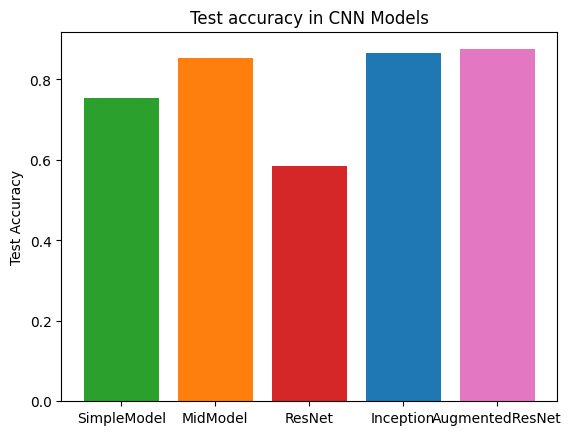

In [13]:
fig, ax = plt.subplots()

models = [name for name, _ in model_accuracies]
accuracies = [accuracy for _, accuracy in model_accuracies]
bar_colors = ["tab:green", "tab:orange", "tab:red", "tab:blue", 'tab:pink']
ax.bar(models, accuracies, label=models, color=bar_colors)

ax.set_ylabel("Test Accuracy")
ax.set_title("Test accuracy in CNN Models")

plt.show()